# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.6335786760712763 -2.9167527052668816
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [33]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    Qs_labels = tf.concat(axis=0, values=[targetQs[1:], tf.zeros(shape=[1, 1])])
    #g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
    #                                                                  labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
    #                                                                                    shape=[-1, 1])))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [34]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [35]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [36]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [37]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [38]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [39]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [40]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:9.0000 rate:0.0180 gloss:-0.1425 dloss:0.5798 dlossR:0.5798 dlossQ:0.6857
Episode:1 meanR:23.5000 rate:0.0760 gloss:-0.0272 dloss:0.6763 dlossR:0.6763 dlossQ:0.6930
Episode:2 meanR:21.0000 rate:0.0320 gloss:-0.0598 dloss:0.6522 dlossR:0.6522 dlossQ:0.6922
Episode:3 meanR:22.0000 rate:0.0500 gloss:-0.0790 dloss:0.6417 dlossR:0.6417 dlossQ:0.6915
Episode:4 meanR:20.0000 rate:0.0240 gloss:-0.1171 dloss:0.6130 dlossR:0.6130 dlossQ:0.6898
Episode:5 meanR:18.1667 rate:0.0180 gloss:-0.1691 dloss:0.5776 dlossR:0.5776 dlossQ:0.6862
Episode:6 meanR:17.2857 rate:0.0240 gloss:-0.2082 dloss:0.5579 dlossR:0.5579 dlossQ:0.6827
Episode:7 meanR:17.2500 rate:0.0340 gloss:-0.1948 dloss:0.5692 dlossR:0.5692 dlossQ:0.6840
Episode:8 meanR:17.7778 rate:0.0440 gloss:-0.2035 dloss:0.5673 dlossR:0.5673 dlossQ:0.6829
Episode:9 meanR:19.3000 rate:0.0660 gloss:-0.1745 dloss:0.5899 dlossR:0.5899 dlossQ:0.6857
Episode:10 meanR:20.5455 rate:0.0660 gloss:-0.2032 dloss:0.5748 dlossR:0.5748 dlossQ:0.6827

Episode:91 meanR:30.0109 rate:0.0940 gloss:-1.7671 dloss:0.3179 dlossR:0.3179 dlossQ:0.2818
Episode:92 meanR:29.9355 rate:0.0460 gloss:-1.8410 dloss:0.1895 dlossR:0.1895 dlossQ:0.2904
Episode:93 meanR:29.7766 rate:0.0300 gloss:-1.8860 dloss:0.1433 dlossR:0.1433 dlossQ:0.3046
Episode:94 meanR:29.6105 rate:0.0280 gloss:-1.9408 dloss:0.1361 dlossR:0.1361 dlossQ:0.3168
Episode:95 meanR:29.4583 rate:0.0300 gloss:-2.0183 dloss:0.1402 dlossR:0.1402 dlossQ:0.3055
Episode:96 meanR:29.2784 rate:0.0240 gloss:-2.1616 dloss:0.1192 dlossR:0.1192 dlossQ:0.2856
Episode:97 meanR:29.1224 rate:0.0280 gloss:-2.1772 dloss:0.1323 dlossR:0.1323 dlossQ:0.2694
Episode:98 meanR:29.0000 rate:0.0340 gloss:-2.1808 dloss:0.1538 dlossR:0.1538 dlossQ:0.2656
Episode:99 meanR:28.9400 rate:0.0460 gloss:-2.0629 dloss:0.1934 dlossR:0.1934 dlossQ:0.2641
Episode:100 meanR:29.8300 rate:0.1960 gloss:-1.8030 dloss:0.5906 dlossR:0.5906 dlossQ:0.2614
Episode:101 meanR:30.3600 rate:0.1820 gloss:-1.8111 dloss:0.5545 dlossR:0.5545 

Episode:185 meanR:32.6200 rate:0.4060 gloss:-1.5717 dloss:1.0258 dlossR:1.0258 dlossQ:0.3201
Episode:186 meanR:32.5000 rate:0.1020 gloss:-1.5053 dloss:0.3301 dlossR:0.3301 dlossQ:0.3432
Episode:187 meanR:32.5400 rate:0.0620 gloss:-1.4969 dloss:0.2422 dlossR:0.2422 dlossQ:0.3637
Episode:188 meanR:32.5300 rate:0.0620 gloss:-1.4822 dloss:0.2430 dlossR:0.2430 dlossQ:0.3674
Episode:189 meanR:32.0900 rate:0.0600 gloss:-1.4624 dloss:0.2386 dlossR:0.2386 dlossQ:0.3648
Episode:190 meanR:32.0400 rate:0.0460 gloss:-1.4374 dloss:0.2087 dlossR:0.2087 dlossQ:0.3721
Episode:191 meanR:31.7700 rate:0.0400 gloss:-1.5153 dloss:0.1895 dlossR:0.1895 dlossQ:0.3592
Episode:192 meanR:31.7200 rate:0.0360 gloss:-1.5227 dloss:0.1791 dlossR:0.1791 dlossQ:0.3604
Episode:193 meanR:31.7200 rate:0.0300 gloss:-1.5608 dloss:0.1611 dlossR:0.1611 dlossQ:0.3697
Episode:194 meanR:31.7700 rate:0.0380 gloss:-1.6954 dloss:0.1763 dlossR:0.1763 dlossQ:0.3446
Episode:195 meanR:31.8100 rate:0.0380 gloss:-1.6711 dloss:0.1760 dloss

Episode:279 meanR:73.8400 rate:0.0180 gloss:-1.3781 dloss:0.1629 dlossR:0.1629 dlossQ:0.4457
Episode:280 meanR:73.8200 rate:0.0240 gloss:-1.2874 dloss:0.1891 dlossR:0.1891 dlossQ:0.4424
Episode:281 meanR:73.7900 rate:0.0300 gloss:-1.4000 dloss:0.1837 dlossR:0.1837 dlossQ:0.4099
Episode:282 meanR:74.1800 rate:0.1220 gloss:-1.3095 dloss:0.3806 dlossR:0.3806 dlossQ:0.4104
Episode:283 meanR:74.7600 rate:0.1400 gloss:-1.3383 dloss:0.4176 dlossR:0.4176 dlossQ:0.3973
Episode:284 meanR:74.7100 rate:0.0820 gloss:-1.6654 dloss:0.2998 dlossR:0.2998 dlossQ:0.3293
Episode:285 meanR:72.8300 rate:0.0300 gloss:-1.4121 dloss:0.1879 dlossR:0.1879 dlossQ:0.4158
Episode:286 meanR:72.9800 rate:0.1320 gloss:-1.3855 dloss:0.4115 dlossR:0.4115 dlossQ:0.3908
Episode:287 meanR:72.7900 rate:0.0240 gloss:-1.6621 dloss:0.1496 dlossR:0.1496 dlossQ:0.3779
Episode:288 meanR:72.9900 rate:0.1020 gloss:-1.5024 dloss:0.3490 dlossR:0.3490 dlossQ:0.3683
Episode:289 meanR:73.2100 rate:0.1040 gloss:-1.5052 dloss:0.3519 dloss

Episode:374 meanR:29.5700 rate:0.0220 gloss:-2.5502 dloss:0.1134 dlossR:0.1134 dlossQ:0.2947
Episode:375 meanR:29.5700 rate:0.0220 gloss:-2.5840 dloss:0.1136 dlossR:0.1136 dlossQ:0.2944
Episode:376 meanR:29.7200 rate:0.0500 gloss:-1.9327 dloss:0.2015 dlossR:0.2015 dlossQ:0.2833
Episode:377 meanR:30.0300 rate:0.0800 gloss:-1.9286 dloss:0.2867 dlossR:0.2867 dlossQ:0.2651
Episode:378 meanR:30.0400 rate:0.0540 gloss:-2.0164 dloss:0.2150 dlossR:0.2150 dlossQ:0.2800
Episode:379 meanR:30.3000 rate:0.0700 gloss:-1.9704 dloss:0.2611 dlossR:0.2611 dlossQ:0.2732
Episode:380 meanR:30.4500 rate:0.0540 gloss:-2.0010 dloss:0.2140 dlossR:0.2140 dlossQ:0.2781
Episode:381 meanR:30.4900 rate:0.0380 gloss:-2.0780 dloss:0.1666 dlossR:0.1666 dlossQ:0.2992
Episode:382 meanR:30.1400 rate:0.0520 gloss:-1.9933 dloss:0.2076 dlossR:0.2076 dlossQ:0.2749
Episode:383 meanR:29.7200 rate:0.0560 gloss:-1.9932 dloss:0.2189 dlossR:0.2189 dlossQ:0.2655
Episode:384 meanR:29.4800 rate:0.0340 gloss:-2.1059 dloss:0.1531 dloss

Episode:467 meanR:38.9600 rate:0.1620 gloss:-1.5911 dloss:0.4777 dlossR:0.4777 dlossQ:0.3441
Episode:468 meanR:39.2600 rate:0.1020 gloss:-1.5875 dloss:0.3427 dlossR:0.3427 dlossQ:0.3668
Episode:469 meanR:40.6900 rate:0.3160 gloss:-1.6559 dloss:0.8541 dlossR:0.8541 dlossQ:0.3163
Episode:470 meanR:43.8200 rate:0.6520 gloss:-1.4521 dloss:1.4918 dlossR:1.4918 dlossQ:0.3543
Episode:471 meanR:47.5600 rate:0.7720 gloss:-1.5243 dloss:1.8140 dlossR:1.8140 dlossQ:0.3339
Episode:472 meanR:48.3500 rate:0.1900 gloss:-1.6553 dloss:0.5565 dlossR:0.5565 dlossQ:0.3186
Episode:473 meanR:49.2700 rate:0.2080 gloss:-1.5624 dloss:0.5778 dlossR:0.5778 dlossQ:0.3277
Episode:474 meanR:50.2300 rate:0.2140 gloss:-1.5362 dloss:0.5876 dlossR:0.5876 dlossQ:0.3346
Episode:475 meanR:51.4000 rate:0.2560 gloss:-1.4619 dloss:0.6659 dlossR:0.6659 dlossQ:0.3642
Episode:476 meanR:53.6600 rate:0.5020 gloss:-1.4156 dloss:1.1599 dlossR:1.1599 dlossQ:0.3696
Episode:477 meanR:55.4900 rate:0.4460 gloss:-1.3327 dloss:1.0068 dloss

Episode:563 meanR:45.9500 rate:0.0360 gloss:-2.0329 dloss:0.1608 dlossR:0.1608 dlossQ:0.2861
Episode:564 meanR:45.7900 rate:0.0260 gloss:-2.3507 dloss:0.1313 dlossR:0.1313 dlossQ:0.2793
Episode:565 meanR:45.5400 rate:0.0200 gloss:-2.3597 dloss:0.1121 dlossR:0.1121 dlossQ:0.3544
Episode:566 meanR:45.2700 rate:0.0200 gloss:-2.4076 dloss:0.1187 dlossR:0.1187 dlossQ:0.4170
Episode:567 meanR:44.5500 rate:0.0180 gloss:-2.4782 dloss:0.1078 dlossR:0.1078 dlossQ:0.4037
Episode:568 meanR:44.1300 rate:0.0180 gloss:-2.5251 dloss:0.1075 dlossR:0.1075 dlossQ:0.4051
Episode:569 meanR:42.6700 rate:0.0240 gloss:-2.5198 dloss:0.1268 dlossR:0.1268 dlossQ:0.3012
Episode:570 meanR:39.7800 rate:0.0740 gloss:-1.8285 dloss:0.2828 dlossR:0.2828 dlossQ:0.3138
Episode:571 meanR:36.3700 rate:0.0900 gloss:-1.6017 dloss:0.3055 dlossR:0.3055 dlossQ:0.3239
Episode:572 meanR:35.8200 rate:0.0800 gloss:-1.5092 dloss:0.2811 dlossR:0.2811 dlossQ:0.3436
Episode:573 meanR:35.0400 rate:0.0520 gloss:-1.5043 dloss:0.2181 dloss

Episode:656 meanR:47.1400 rate:0.1680 gloss:-1.2226 dloss:0.4689 dlossR:0.4689 dlossQ:0.4382
Episode:657 meanR:47.8300 rate:0.1740 gloss:-1.1203 dloss:0.4743 dlossR:0.4743 dlossQ:0.4682
Episode:658 meanR:49.3700 rate:0.3400 gloss:-1.0592 dloss:0.7237 dlossR:0.7237 dlossQ:0.4764
Episode:659 meanR:50.7100 rate:0.2960 gloss:-1.1472 dloss:0.6754 dlossR:0.6754 dlossQ:0.4513
Episode:660 meanR:55.5200 rate:1.0000 gloss:-1.0168 dloss:1.6802 dlossR:1.6802 dlossQ:0.4852
Episode:661 meanR:57.1200 rate:0.3480 gloss:-1.0248 dloss:0.7265 dlossR:0.7265 dlossQ:0.4864
Episode:662 meanR:59.7500 rate:0.5560 gloss:-0.9979 dloss:1.0200 dlossR:1.0200 dlossQ:0.4939
Episode:663 meanR:60.3800 rate:0.1620 gloss:-1.0491 dloss:0.4523 dlossR:0.4523 dlossQ:0.4791
Episode:664 meanR:60.7800 rate:0.1060 gloss:-1.0464 dloss:0.3664 dlossR:0.3664 dlossQ:0.4804
Episode:665 meanR:60.8700 rate:0.0380 gloss:-0.9767 dloss:0.2657 dlossR:0.2657 dlossQ:0.5115
Episode:666 meanR:61.1800 rate:0.0820 gloss:-1.0273 dloss:0.3348 dloss

Episode:747 meanR:74.8100 rate:0.0320 gloss:-1.3351 dloss:0.2020 dlossR:0.2020 dlossQ:0.4552
Episode:748 meanR:74.7800 rate:0.0320 gloss:-1.1856 dloss:0.2134 dlossR:0.2134 dlossQ:0.4553
Episode:749 meanR:74.8200 rate:0.0520 gloss:-1.1509 dloss:0.2580 dlossR:0.2580 dlossQ:0.4596
Episode:750 meanR:74.5100 rate:0.1160 gloss:-1.3151 dloss:0.3908 dlossR:0.3908 dlossQ:0.4464
Episode:751 meanR:74.2800 rate:0.0220 gloss:-2.3872 dloss:0.1347 dlossR:0.1347 dlossQ:0.3510
Episode:752 meanR:74.3400 rate:0.0840 gloss:-1.3684 dloss:0.3234 dlossR:0.3234 dlossQ:0.4517
Episode:753 meanR:77.2300 rate:0.6000 gloss:-1.1581 dloss:1.1790 dlossR:1.1790 dlossQ:0.4418
Episode:754 meanR:77.5700 rate:0.0860 gloss:-1.1666 dloss:0.3154 dlossR:0.3154 dlossQ:0.4479
Episode:755 meanR:77.5500 rate:0.0320 gloss:-1.3228 dloss:0.1938 dlossR:0.1938 dlossQ:0.4203
Episode:756 meanR:76.9600 rate:0.0500 gloss:-1.3180 dloss:0.2334 dlossR:0.2334 dlossQ:0.4201
Episode:757 meanR:76.3000 rate:0.0420 gloss:-1.3735 dloss:0.2108 dloss

Episode:837 meanR:47.7300 rate:0.1960 gloss:-1.6521 dloss:0.5744 dlossR:0.5744 dlossQ:0.3277
Episode:838 meanR:48.6400 rate:0.2060 gloss:-1.8349 dloss:0.6344 dlossR:0.6344 dlossQ:0.2839
Episode:839 meanR:49.0400 rate:0.1080 gloss:-1.3493 dloss:0.3452 dlossR:0.3452 dlossQ:0.3867
Episode:840 meanR:49.3400 rate:0.0900 gloss:-1.3193 dloss:0.3100 dlossR:0.3100 dlossQ:0.3959
Episode:841 meanR:49.5300 rate:0.0640 gloss:-1.2972 dloss:0.2600 dlossR:0.2600 dlossQ:0.4051
Episode:842 meanR:49.5900 rate:0.0620 gloss:-1.2994 dloss:0.2565 dlossR:0.2565 dlossQ:0.4061
Episode:843 meanR:49.7300 rate:0.0540 gloss:-1.2955 dloss:0.2410 dlossR:0.2410 dlossQ:0.4082
Episode:844 meanR:49.8800 rate:0.0520 gloss:-1.3282 dloss:0.2339 dlossR:0.2339 dlossQ:0.4032
Episode:845 meanR:50.0300 rate:0.0560 gloss:-1.3418 dloss:0.2413 dlossR:0.2413 dlossQ:0.3968
Episode:846 meanR:50.1100 rate:0.0420 gloss:-1.3684 dloss:0.2092 dlossR:0.2092 dlossQ:0.4014
Episode:847 meanR:50.2000 rate:0.0500 gloss:-1.3656 dloss:0.2268 dloss

Episode:927 meanR:46.5500 rate:0.0200 gloss:-2.0857 dloss:0.1256 dlossR:0.1256 dlossQ:0.3939
Episode:928 meanR:46.5600 rate:0.0240 gloss:-2.3338 dloss:0.1323 dlossR:0.1323 dlossQ:0.3122
Episode:929 meanR:47.0000 rate:0.1080 gloss:-1.7434 dloss:0.3663 dlossR:0.3663 dlossQ:0.3268
Episode:930 meanR:47.9700 rate:0.2140 gloss:-1.7745 dloss:0.6429 dlossR:0.6429 dlossQ:0.3045
Episode:931 meanR:51.2800 rate:0.6820 gloss:-1.3170 dloss:1.4423 dlossR:1.4423 dlossQ:0.3944
Episode:932 meanR:51.6600 rate:0.0960 gloss:-1.4564 dloss:0.3254 dlossR:0.3254 dlossQ:0.3809
Episode:933 meanR:51.8500 rate:0.0580 gloss:-1.4003 dloss:0.2457 dlossR:0.2457 dlossQ:0.4010
Episode:934 meanR:51.7300 rate:0.0280 gloss:-1.5710 dloss:0.1599 dlossR:0.1599 dlossQ:0.3616
Episode:935 meanR:47.3900 rate:0.0300 gloss:-1.5232 dloss:0.1688 dlossR:0.1688 dlossQ:0.3859
Episode:936 meanR:46.3600 rate:0.0560 gloss:-1.4098 dloss:0.2416 dlossR:0.2416 dlossQ:0.4053
Episode:937 meanR:45.5300 rate:0.0300 gloss:-1.5543 dloss:0.1676 dloss

Episode:1017 meanR:48.0700 rate:0.0420 gloss:-1.6377 dloss:0.1899 dlossR:0.1899 dlossQ:0.3460
Episode:1018 meanR:47.8200 rate:0.0580 gloss:-1.5811 dloss:0.2361 dlossR:0.2361 dlossQ:0.3727
Episode:1019 meanR:52.3400 rate:1.0000 gloss:-1.4130 dloss:2.1656 dlossR:2.1656 dlossQ:0.3601
Episode:1020 meanR:52.3000 rate:0.1040 gloss:-1.3825 dloss:0.3375 dlossR:0.3375 dlossQ:0.3865
Episode:1021 meanR:52.6200 rate:0.0860 gloss:-1.3987 dloss:0.3004 dlossR:0.3004 dlossQ:0.3813
Episode:1022 meanR:52.4500 rate:0.0500 gloss:-1.4691 dloss:0.2192 dlossR:0.2192 dlossQ:0.3801
Episode:1023 meanR:52.3200 rate:0.0580 gloss:-1.4673 dloss:0.2369 dlossR:0.2369 dlossQ:0.3740
Episode:1024 meanR:52.1300 rate:0.0380 gloss:-1.6022 dloss:0.1818 dlossR:0.1818 dlossQ:0.3422
Episode:1025 meanR:52.1600 rate:0.0260 gloss:-1.7181 dloss:0.1450 dlossR:0.1450 dlossQ:0.3552
Episode:1026 meanR:52.0800 rate:0.0260 gloss:-1.8136 dloss:0.1407 dlossR:0.1407 dlossQ:0.3296
Episode:1027 meanR:52.0900 rate:0.0220 gloss:-1.8465 dloss:0

Episode:1107 meanR:129.3600 rate:0.0500 gloss:-0.7683 dloss:0.3413 dlossR:0.3413 dlossQ:0.5715
Episode:1108 meanR:129.4000 rate:0.0380 gloss:-0.8249 dloss:0.3104 dlossR:0.3104 dlossQ:0.5568
Episode:1109 meanR:129.4000 rate:0.0320 gloss:-0.9368 dloss:0.2730 dlossR:0.2730 dlossQ:0.5311
Episode:1110 meanR:129.4200 rate:0.0320 gloss:-0.9914 dloss:0.2617 dlossR:0.2617 dlossQ:0.5144
Episode:1111 meanR:129.4800 rate:0.0420 gloss:-1.0783 dloss:0.2598 dlossR:0.2598 dlossQ:0.4835
Episode:1112 meanR:129.5600 rate:0.0480 gloss:-1.1392 dloss:0.2595 dlossR:0.2595 dlossQ:0.4706
Episode:1113 meanR:129.5800 rate:0.0340 gloss:-1.2429 dloss:0.2205 dlossR:0.2205 dlossQ:0.4347
Episode:1114 meanR:129.5900 rate:0.0280 gloss:-1.4377 dloss:0.1816 dlossR:0.1816 dlossQ:0.3985
Episode:1115 meanR:129.6300 rate:0.0320 gloss:-1.4785 dloss:0.1890 dlossR:0.1890 dlossQ:0.3843
Episode:1116 meanR:129.5300 rate:0.0260 gloss:-1.6255 dloss:0.1642 dlossR:0.1642 dlossQ:0.3755
Episode:1117 meanR:129.4900 rate:0.0340 gloss:-1.6

Episode:1198 meanR:64.0900 rate:0.1380 gloss:-0.6479 dloss:0.4692 dlossR:0.4692 dlossQ:0.6009
Episode:1199 meanR:65.9300 rate:0.4440 gloss:-0.7499 dloss:0.7923 dlossR:0.7923 dlossQ:0.5784
Episode:1200 meanR:67.7900 rate:0.4400 gloss:-0.8871 dloss:0.8280 dlossR:0.8280 dlossQ:0.5307
Episode:1201 meanR:67.9900 rate:0.0940 gloss:-1.0868 dloss:0.3725 dlossR:0.3725 dlossQ:0.5016
Episode:1202 meanR:67.8300 rate:0.0400 gloss:-1.2693 dloss:0.2658 dlossR:0.2658 dlossQ:0.4707
Episode:1203 meanR:68.1100 rate:0.0980 gloss:-1.0178 dloss:0.3781 dlossR:0.3781 dlossQ:0.5074
Episode:1204 meanR:72.7900 rate:1.0000 gloss:-0.6886 dloss:1.3134 dlossR:1.3134 dlossQ:0.5878
Episode:1205 meanR:73.0800 rate:0.0960 gloss:-0.7083 dloss:0.4168 dlossR:0.4168 dlossQ:0.5862
Episode:1206 meanR:73.2300 rate:0.0720 gloss:-0.7199 dloss:0.3873 dlossR:0.3873 dlossQ:0.5844
Episode:1207 meanR:73.3500 rate:0.0740 gloss:-0.6839 dloss:0.4002 dlossR:0.4002 dlossQ:0.5906
Episode:1208 meanR:73.4200 rate:0.0520 gloss:-0.6919 dloss:0

Episode:1285 meanR:127.1100 rate:0.8140 gloss:-0.5036 dloss:0.9920 dlossR:0.9920 dlossQ:0.6385
Episode:1286 meanR:127.4400 rate:0.0920 gloss:-0.5827 dloss:0.4494 dlossR:0.4494 dlossQ:0.6199
Episode:1287 meanR:127.7100 rate:0.0780 gloss:-0.5571 dloss:0.4443 dlossR:0.4443 dlossQ:0.6235
Episode:1288 meanR:127.9000 rate:0.0580 gloss:-0.5733 dloss:0.4204 dlossR:0.4204 dlossQ:0.6219
Episode:1289 meanR:128.0300 rate:0.0460 gloss:-0.6842 dloss:0.3736 dlossR:0.3736 dlossQ:0.6052
Episode:1290 meanR:128.1300 rate:0.0460 gloss:-0.6432 dloss:0.3849 dlossR:0.3849 dlossQ:0.6064
Episode:1291 meanR:127.8900 rate:0.0480 gloss:-0.6457 dloss:0.3847 dlossR:0.3847 dlossQ:0.6114
Episode:1292 meanR:127.0200 rate:0.0500 gloss:-0.6503 dloss:0.3890 dlossR:0.3890 dlossQ:0.6138
Episode:1293 meanR:127.1500 rate:0.0500 gloss:-0.7228 dloss:0.3622 dlossR:0.3622 dlossQ:0.5965
Episode:1294 meanR:127.0800 rate:0.0420 gloss:-0.8188 dloss:0.3275 dlossR:0.3275 dlossQ:0.5684
Episode:1295 meanR:127.0000 rate:0.0380 gloss:-0.8

Episode:1377 meanR:135.6600 rate:0.0760 gloss:-0.8131 dloss:0.4417 dlossR:0.4417 dlossQ:0.5915
Episode:1378 meanR:134.9800 rate:0.0460 gloss:-1.0258 dloss:0.3551 dlossR:0.3551 dlossQ:0.5383
Episode:1379 meanR:133.4300 rate:0.0900 gloss:-0.7695 dloss:0.4205 dlossR:0.4205 dlossQ:0.5669
Episode:1380 meanR:128.8800 rate:0.0900 gloss:-0.7574 dloss:0.4076 dlossR:0.4076 dlossQ:0.5721
Episode:1381 meanR:124.1900 rate:0.0620 gloss:-0.6766 dloss:0.3850 dlossR:0.3850 dlossQ:0.6034
Episode:1382 meanR:119.4400 rate:0.0500 gloss:-0.8658 dloss:0.3218 dlossR:0.3218 dlossQ:0.5552
Episode:1383 meanR:114.6300 rate:0.0380 gloss:-1.0315 dloss:0.2717 dlossR:0.2717 dlossQ:0.5160
Episode:1384 meanR:114.3100 rate:0.0260 gloss:-1.1467 dloss:0.2356 dlossR:0.2356 dlossQ:0.4878
Episode:1385 meanR:110.4000 rate:0.0320 gloss:-1.1862 dloss:0.2429 dlossR:0.2429 dlossQ:0.4831
Episode:1386 meanR:110.0600 rate:0.0240 gloss:-1.4186 dloss:0.2035 dlossR:0.2035 dlossQ:0.4356
Episode:1387 meanR:109.8300 rate:0.0320 gloss:-1.3

Episode:1464 meanR:101.5600 rate:1.0000 gloss:-0.5105 dloss:1.1379 dlossR:1.1379 dlossQ:0.6361
Episode:1465 meanR:100.4100 rate:0.0260 gloss:-1.7120 dloss:0.1859 dlossR:0.1859 dlossQ:0.3969
Episode:1466 meanR:99.8100 rate:0.0180 gloss:-2.0245 dloss:0.1881 dlossR:0.1881 dlossQ:0.5389
Episode:1467 meanR:104.1700 rate:1.0000 gloss:-0.4367 dloss:1.0693 dlossR:1.0693 dlossQ:0.6544
Episode:1468 meanR:104.4900 rate:0.2060 gloss:-0.1887 dloss:0.6481 dlossR:0.6481 dlossQ:0.6828
Episode:1469 meanR:104.2600 rate:0.0560 gloss:-0.9596 dloss:0.3130 dlossR:0.3130 dlossQ:0.5316
Episode:1470 meanR:103.7800 rate:0.0380 gloss:-1.1946 dloss:0.2535 dlossR:0.2535 dlossQ:0.4782
Episode:1471 meanR:103.5100 rate:0.0260 gloss:-1.4784 dloss:0.2049 dlossR:0.2049 dlossQ:0.4057
Episode:1472 meanR:103.2000 rate:0.0260 gloss:-1.5001 dloss:0.2152 dlossR:0.2152 dlossQ:0.4445
Episode:1473 meanR:103.2100 rate:0.0220 gloss:-1.5451 dloss:0.1960 dlossR:0.1960 dlossQ:0.4009
Episode:1474 meanR:103.1600 rate:0.0300 gloss:-1.51

Episode:1551 meanR:182.8400 rate:1.0000 gloss:-0.0053 dloss:0.7013 dlossR:0.7013 dlossQ:0.6945
Episode:1552 meanR:187.6000 rate:1.0000 gloss:-0.0015 dloss:0.6981 dlossR:0.6981 dlossQ:0.6966
Episode:1553 meanR:192.3900 rate:1.0000 gloss:0.0283 dloss:0.6763 dlossR:0.6763 dlossQ:0.6958
Episode:1554 meanR:197.1300 rate:1.0000 gloss:0.0538 dloss:0.6577 dlossR:0.6577 dlossQ:0.6949
Episode:1555 meanR:201.9800 rate:1.0000 gloss:0.0787 dloss:0.6408 dlossR:0.6408 dlossQ:0.6934
Episode:1556 meanR:206.8100 rate:1.0000 gloss:0.0998 dloss:0.6267 dlossR:0.6267 dlossQ:0.6917
Episode:1557 meanR:211.6600 rate:1.0000 gloss:0.1326 dloss:0.6041 dlossR:0.6041 dlossQ:0.6893
Episode:1558 meanR:216.5300 rate:1.0000 gloss:0.1628 dloss:0.5844 dlossR:0.5844 dlossQ:0.6871
Episode:1559 meanR:221.3700 rate:1.0000 gloss:0.1956 dloss:0.5635 dlossR:0.5635 dlossQ:0.6839
Episode:1560 meanR:225.5800 rate:1.0000 gloss:0.2282 dloss:0.5430 dlossR:0.5430 dlossQ:0.6809
Episode:1561 meanR:225.5800 rate:1.0000 gloss:0.2704 dloss

Episode:1640 meanR:265.0000 rate:0.0560 gloss:-0.9024 dloss:0.3277 dlossR:0.3277 dlossQ:0.5490
Episode:1641 meanR:263.1400 rate:0.0680 gloss:-1.0117 dloss:0.3284 dlossR:0.3284 dlossQ:0.5170
Episode:1642 meanR:260.9700 rate:0.0380 gloss:-1.1862 dloss:0.2460 dlossR:0.2460 dlossQ:0.4804
Episode:1643 meanR:258.4100 rate:0.0480 gloss:-1.2321 dloss:0.2678 dlossR:0.2678 dlossQ:0.4746
Episode:1644 meanR:253.6500 rate:0.0480 gloss:-1.3098 dloss:0.2576 dlossR:0.2576 dlossQ:0.4544
Episode:1645 meanR:253.3000 rate:0.0440 gloss:-1.4503 dloss:0.2412 dlossR:0.2412 dlossQ:0.4283
Episode:1646 meanR:248.4300 rate:0.0260 gloss:-1.8125 dloss:0.1627 dlossR:0.1627 dlossQ:0.3732
Episode:1647 meanR:243.6100 rate:0.0360 gloss:-1.8811 dloss:0.1927 dlossR:0.1927 dlossQ:0.3674
Episode:1648 meanR:238.7400 rate:0.0260 gloss:-1.9939 dloss:0.1593 dlossR:0.1593 dlossQ:0.3565
Episode:1649 meanR:233.8800 rate:0.0280 gloss:-2.1457 dloss:0.1594 dlossR:0.1594 dlossQ:0.3573
Episode:1650 meanR:229.0700 rate:0.0380 gloss:-1.9

Episode:1729 meanR:65.9300 rate:0.2760 gloss:-0.8162 dloss:0.6273 dlossR:0.6273 dlossQ:0.5727
Episode:1730 meanR:64.9700 rate:0.0540 gloss:-1.1141 dloss:0.3424 dlossR:0.3424 dlossQ:0.5349
Episode:1731 meanR:64.3500 rate:0.0680 gloss:-1.0272 dloss:0.3785 dlossR:0.3785 dlossQ:0.5596
Episode:1732 meanR:63.7800 rate:0.0680 gloss:-1.1618 dloss:0.3498 dlossR:0.3498 dlossQ:0.5116
Episode:1733 meanR:63.2300 rate:0.0160 gloss:-2.2853 dloss:0.1550 dlossR:0.1550 dlossQ:0.5678
Episode:1734 meanR:62.6500 rate:0.0220 gloss:-1.9459 dloss:0.1730 dlossR:0.1730 dlossQ:0.4367
Episode:1735 meanR:62.1100 rate:0.0220 gloss:-1.7912 dloss:0.1840 dlossR:0.1840 dlossQ:0.4489
Episode:1736 meanR:61.7200 rate:0.0240 gloss:-1.7933 dloss:0.1831 dlossR:0.1831 dlossQ:0.4180
Episode:1737 meanR:61.3800 rate:0.0280 gloss:-1.8089 dloss:0.1883 dlossR:0.1883 dlossQ:0.4063
Episode:1738 meanR:61.5800 rate:0.1220 gloss:-0.9586 dloss:0.4242 dlossR:0.4242 dlossQ:0.5323
Episode:1739 meanR:61.6800 rate:0.0860 gloss:-1.2756 dloss:0

Episode:1818 meanR:105.5600 rate:0.1340 gloss:-0.8197 dloss:0.4351 dlossR:0.4351 dlossQ:0.5625
Episode:1819 meanR:106.8100 rate:0.4140 gloss:-0.3071 dloss:0.6984 dlossR:0.6984 dlossQ:0.6647
Episode:1820 meanR:111.2700 rate:1.0000 gloss:-0.1380 dloss:0.8039 dlossR:0.8039 dlossQ:0.6905
Episode:1821 meanR:115.9100 rate:1.0000 gloss:-0.1958 dloss:0.8528 dlossR:0.8528 dlossQ:0.6849
Episode:1822 meanR:120.5600 rate:1.0000 gloss:-0.2576 dloss:0.9019 dlossR:0.9019 dlossQ:0.6822
Episode:1823 meanR:125.1400 rate:1.0000 gloss:-0.2551 dloss:0.9003 dlossR:0.9003 dlossQ:0.6824
Episode:1824 meanR:129.7600 rate:1.0000 gloss:-0.5207 dloss:1.1432 dlossR:1.1432 dlossQ:0.6410
Episode:1825 meanR:134.3600 rate:1.0000 gloss:-0.2913 dloss:0.9312 dlossR:0.9312 dlossQ:0.6798
Episode:1826 meanR:138.9100 rate:1.0000 gloss:-0.3925 dloss:1.0208 dlossR:1.0208 dlossQ:0.6656
Episode:1827 meanR:140.3600 rate:0.3800 gloss:-0.5020 dloss:0.7055 dlossR:0.7055 dlossQ:0.6439
Episode:1828 meanR:140.9100 rate:0.3120 gloss:-0.4

Episode:1905 meanR:411.4200 rate:1.0000 gloss:1.2597 dloss:0.1522 dlossR:0.1522 dlossQ:0.4062
Episode:1906 meanR:416.3300 rate:1.0000 gloss:1.3316 dloss:0.1369 dlossR:0.1369 dlossQ:0.3834
Episode:1907 meanR:420.8800 rate:1.0000 gloss:1.3406 dloss:0.1391 dlossR:0.1391 dlossQ:0.3825
Episode:1908 meanR:420.8800 rate:1.0000 gloss:1.4011 dloss:0.1256 dlossR:0.1256 dlossQ:0.3627
Episode:1909 meanR:420.8800 rate:1.0000 gloss:1.4457 dloss:0.1175 dlossR:0.1175 dlossQ:0.3489
Episode:1910 meanR:425.7700 rate:1.0000 gloss:1.4837 dloss:0.1147 dlossR:0.1147 dlossQ:0.3401
Episode:1911 meanR:430.6500 rate:1.0000 gloss:1.5506 dloss:0.1019 dlossR:0.1019 dlossQ:0.3190
Episode:1912 meanR:430.6500 rate:1.0000 gloss:1.7140 dloss:0.0829 dlossR:0.0829 dlossQ:0.2775
Episode:1913 meanR:435.3400 rate:1.0000 gloss:1.5920 dloss:0.0975 dlossR:0.0975 dlossQ:0.3092
Episode:1914 meanR:440.2500 rate:1.0000 gloss:1.7242 dloss:0.0810 dlossR:0.0810 dlossQ:0.2734
Episode:1915 meanR:445.0700 rate:1.0000 gloss:1.6838 dloss:0

Episode:1992 meanR:304.5000 rate:0.2220 gloss:-0.4025 dloss:0.6281 dlossR:0.6281 dlossQ:0.6467
Episode:1993 meanR:300.4500 rate:0.1900 gloss:-0.4744 dloss:0.5991 dlossR:0.5991 dlossQ:0.6332
Episode:1994 meanR:296.4800 rate:0.2060 gloss:-0.5039 dloss:0.6055 dlossR:0.6055 dlossQ:0.6322
Episode:1995 meanR:292.2700 rate:0.1580 gloss:-0.6458 dloss:0.5370 dlossR:0.5370 dlossQ:0.5997
Episode:1996 meanR:288.5400 rate:0.2540 gloss:-0.4673 dloss:0.6441 dlossR:0.6441 dlossQ:0.6421
Episode:1997 meanR:285.2200 rate:0.3360 gloss:-0.3883 dloss:0.6745 dlossR:0.6745 dlossQ:0.6441
Episode:1998 meanR:281.2900 rate:0.2140 gloss:-0.5583 dloss:0.5985 dlossR:0.5985 dlossQ:0.6218
Episode:1999 meanR:277.4700 rate:0.2360 gloss:-0.5223 dloss:0.6178 dlossR:0.6178 dlossQ:0.6339
Episode:2000 meanR:277.4700 rate:1.0000 gloss:-0.0920 dloss:0.7796 dlossR:0.7796 dlossQ:0.7107
Episode:2001 meanR:273.9700 rate:0.3000 gloss:-0.4622 dloss:0.6550 dlossR:0.6550 dlossQ:0.6278
Episode:2002 meanR:270.7000 rate:0.3460 gloss:-0.4

Episode:2081 meanR:64.4300 rate:0.1140 gloss:-1.4535 dloss:0.3799 dlossR:0.3799 dlossQ:0.4116
Episode:2082 meanR:63.9000 rate:0.0360 gloss:-2.0699 dloss:0.1834 dlossR:0.1834 dlossQ:0.3992
Episode:2083 meanR:63.4200 rate:0.0240 gloss:-2.6206 dloss:0.1422 dlossR:0.1422 dlossQ:0.3969
Episode:2084 meanR:62.9600 rate:0.0520 gloss:-1.8870 dloss:0.2350 dlossR:0.2350 dlossQ:0.3946
Episode:2085 meanR:61.0600 rate:0.0480 gloss:-1.9652 dloss:0.2122 dlossR:0.2122 dlossQ:0.3476
Episode:2086 meanR:59.5200 rate:0.0400 gloss:-2.0150 dloss:0.1911 dlossR:0.1911 dlossQ:0.3716
Episode:2087 meanR:56.1000 rate:0.1120 gloss:-1.7410 dloss:0.4141 dlossR:0.4141 dlossQ:0.4527
Episode:2088 meanR:56.0400 rate:0.1100 gloss:-1.6943 dloss:0.3662 dlossR:0.3662 dlossQ:0.3232
Episode:2089 meanR:55.4700 rate:0.0300 gloss:-2.9482 dloss:0.1944 dlossR:0.1944 dlossQ:0.5422
Episode:2090 meanR:55.5300 rate:0.1360 gloss:-1.5126 dloss:0.4186 dlossR:0.4186 dlossQ:0.3883
Episode:2091 meanR:56.3000 rate:0.2960 gloss:-1.1680 dloss:0

Episode:2169 meanR:36.2100 rate:0.0620 gloss:-1.8474 dloss:0.2615 dlossR:0.2615 dlossQ:0.4043
Episode:2170 meanR:36.1000 rate:0.0220 gloss:-2.6332 dloss:0.1253 dlossR:0.1253 dlossQ:0.3586
Episode:2171 meanR:35.0500 rate:0.1440 gloss:-1.6087 dloss:0.4474 dlossR:0.4474 dlossQ:0.3630
Episode:2172 meanR:35.5800 rate:0.2420 gloss:-1.4351 dloss:0.6289 dlossR:0.6289 dlossQ:0.3747
Episode:2173 meanR:36.3000 rate:0.2180 gloss:-1.5264 dloss:0.5947 dlossR:0.5947 dlossQ:0.3591
Episode:2174 meanR:36.5300 rate:0.1020 gloss:-1.4535 dloss:0.3412 dlossR:0.3412 dlossQ:0.3944
Episode:2175 meanR:36.9000 rate:0.0980 gloss:-1.5901 dloss:0.3291 dlossR:0.3291 dlossQ:0.3443
Episode:2176 meanR:37.2800 rate:0.1020 gloss:-1.6251 dloss:0.3459 dlossR:0.3459 dlossQ:0.3706
Episode:2177 meanR:37.5200 rate:0.0720 gloss:-1.5395 dloss:0.2759 dlossR:0.2759 dlossQ:0.3997
Episode:2178 meanR:37.7400 rate:0.0680 gloss:-1.6301 dloss:0.2592 dlossR:0.2592 dlossQ:0.3545
Episode:2179 meanR:38.0600 rate:0.1200 gloss:-1.6805 dloss:0

Episode:2260 meanR:101.7300 rate:1.0000 gloss:-0.1375 dloss:0.7990 dlossR:0.7990 dlossQ:0.6896
Episode:2261 meanR:106.6400 rate:1.0000 gloss:-0.0644 dloss:0.7448 dlossR:0.7448 dlossQ:0.6909
Episode:2262 meanR:107.0300 rate:0.1120 gloss:-0.5669 dloss:0.4663 dlossR:0.4663 dlossQ:0.6175
Episode:2263 meanR:107.0100 rate:0.0260 gloss:-1.0433 dloss:0.2889 dlossR:0.2889 dlossQ:0.5307
Episode:2264 meanR:107.0000 rate:0.0180 gloss:-1.0063 dloss:0.3050 dlossR:0.3050 dlossQ:0.5461
Episode:2265 meanR:106.8700 rate:0.0300 gloss:-0.9656 dloss:0.3055 dlossR:0.3055 dlossQ:0.5479
Episode:2266 meanR:107.2900 rate:0.1040 gloss:-0.5127 dloss:0.4752 dlossR:0.4752 dlossQ:0.6343
Episode:2267 meanR:107.9700 rate:0.1920 gloss:-0.2988 dloss:0.5902 dlossR:0.5902 dlossQ:0.6688
Episode:2268 meanR:109.0700 rate:0.2460 gloss:-0.1568 dloss:0.6450 dlossR:0.6450 dlossQ:0.6872
Episode:2269 meanR:110.3900 rate:0.3260 gloss:-0.3093 dloss:0.6703 dlossR:0.6703 dlossQ:0.6601
Episode:2270 meanR:112.3800 rate:0.4200 gloss:-0.3

Episode:2347 meanR:288.5900 rate:1.0000 gloss:0.4901 dloss:0.4019 dlossR:0.4019 dlossQ:0.6354
Episode:2348 meanR:289.9300 rate:0.3740 gloss:0.2854 dloss:0.7890 dlossR:0.7890 dlossQ:0.6592
Episode:2349 meanR:294.8200 rate:1.0000 gloss:0.5218 dloss:0.3869 dlossR:0.3869 dlossQ:0.6281
Episode:2350 meanR:294.5300 rate:0.2180 gloss:0.3231 dloss:0.8814 dlossR:0.8814 dlossQ:0.6535
Episode:2351 meanR:294.5300 rate:1.0000 gloss:0.5489 dloss:0.3753 dlossR:0.3753 dlossQ:0.6216
Episode:2352 meanR:291.3600 rate:0.3660 gloss:0.4106 dloss:0.8379 dlossR:0.8379 dlossQ:0.6392
Episode:2353 meanR:290.0100 rate:0.2060 gloss:0.2934 dloss:0.8754 dlossR:0.8754 dlossQ:0.6554
Episode:2354 meanR:291.0700 rate:0.2320 gloss:0.3933 dloss:0.9090 dlossR:0.9090 dlossQ:0.6424
Episode:2355 meanR:288.0200 rate:0.3900 gloss:0.4170 dloss:0.8266 dlossR:0.8266 dlossQ:0.6374
Episode:2356 meanR:289.7600 rate:0.4260 gloss:0.3680 dloss:0.7878 dlossR:0.7878 dlossQ:0.6484
Episode:2357 meanR:292.4000 rate:0.5480 gloss:0.3939 dloss:0

Episode:2437 meanR:218.4100 rate:0.1200 gloss:-0.3847 dloss:0.5664 dlossR:0.5664 dlossQ:0.6392
Episode:2438 meanR:213.7500 rate:0.0680 gloss:-0.5069 dloss:0.4831 dlossR:0.4831 dlossQ:0.6232
Episode:2439 meanR:209.0300 rate:0.0560 gloss:-0.6050 dloss:0.4293 dlossR:0.4293 dlossQ:0.6073
Episode:2440 meanR:204.2900 rate:0.0520 gloss:-0.6206 dloss:0.4249 dlossR:0.4249 dlossQ:0.6095
Episode:2441 meanR:199.4700 rate:0.0360 gloss:-0.7809 dloss:0.3446 dlossR:0.3446 dlossQ:0.5768
Episode:2442 meanR:194.7100 rate:0.0480 gloss:-0.6811 dloss:0.3968 dlossR:0.3968 dlossQ:0.5979
Episode:2443 meanR:189.9200 rate:0.0420 gloss:-0.7518 dloss:0.3696 dlossR:0.3696 dlossQ:0.5856
Episode:2444 meanR:185.1500 rate:0.0460 gloss:-0.7871 dloss:0.3676 dlossR:0.3676 dlossQ:0.5790
Episode:2445 meanR:180.2800 rate:0.0260 gloss:-1.0778 dloss:0.2550 dlossR:0.2550 dlossQ:0.4949
Episode:2446 meanR:177.1000 rate:0.0420 gloss:-0.9412 dloss:0.3158 dlossR:0.3158 dlossQ:0.5371
Episode:2447 meanR:172.3900 rate:0.0580 gloss:-0.8

Episode:2525 meanR:81.5800 rate:0.0260 gloss:-1.8873 dloss:0.1753 dlossR:0.1753 dlossQ:0.3979
Episode:2526 meanR:76.7800 rate:0.0400 gloss:-1.2688 dloss:0.2397 dlossR:0.2397 dlossQ:0.4441
Episode:2527 meanR:76.5700 rate:0.1400 gloss:-0.9988 dloss:0.4175 dlossR:0.4175 dlossQ:0.4984
Episode:2528 meanR:72.7900 rate:0.2440 gloss:-0.7398 dloss:0.5607 dlossR:0.5607 dlossQ:0.5746
Episode:2529 meanR:73.5800 rate:0.3440 gloss:-0.6809 dloss:0.6846 dlossR:0.6846 dlossQ:0.5912
Episode:2530 meanR:76.2500 rate:0.7420 gloss:-0.6153 dloss:1.0481 dlossR:1.0481 dlossQ:0.6120
Episode:2531 meanR:75.7900 rate:0.1220 gloss:-1.1752 dloss:0.4164 dlossR:0.4164 dlossQ:0.4776
Episode:2532 meanR:75.6200 rate:0.0640 gloss:-1.3332 dloss:0.2834 dlossR:0.2834 dlossQ:0.4360
Episode:2533 meanR:75.6200 rate:0.0800 gloss:-1.0148 dloss:0.3578 dlossR:0.3578 dlossQ:0.5145
Episode:2534 meanR:75.1900 rate:0.0340 gloss:-1.4189 dloss:0.2063 dlossR:0.2063 dlossQ:0.4169
Episode:2535 meanR:74.8000 rate:0.0340 gloss:-1.4533 dloss:0

Episode:2614 meanR:108.7000 rate:0.1540 gloss:-0.5964 dloss:0.5169 dlossR:0.5169 dlossQ:0.6210
Episode:2615 meanR:105.1700 rate:0.0240 gloss:-1.3693 dloss:0.2186 dlossR:0.2186 dlossQ:0.4758
Episode:2616 meanR:104.9300 rate:0.0260 gloss:-1.5092 dloss:0.2259 dlossR:0.2259 dlossQ:0.4953
Episode:2617 meanR:105.3300 rate:0.1060 gloss:-0.6434 dloss:0.4571 dlossR:0.4571 dlossQ:0.6088
Episode:2618 meanR:105.4100 rate:0.0380 gloss:-1.0367 dloss:0.3263 dlossR:0.3263 dlossQ:0.5639
Episode:2619 meanR:105.4400 rate:0.0240 gloss:-1.3795 dloss:0.2399 dlossR:0.2399 dlossQ:0.5048
Episode:2620 meanR:101.9800 rate:0.1080 gloss:-0.7081 dloss:0.4474 dlossR:0.4474 dlossQ:0.5983
Episode:2621 meanR:101.1800 rate:0.1000 gloss:-0.9053 dloss:0.3809 dlossR:0.3809 dlossQ:0.5307
Episode:2622 meanR:101.1000 rate:0.0240 gloss:-1.4555 dloss:0.2059 dlossR:0.2059 dlossQ:0.4608
Episode:2623 meanR:101.1400 rate:0.0300 gloss:-1.2965 dloss:0.2438 dlossR:0.2438 dlossQ:0.4674
Episode:2624 meanR:101.2200 rate:0.0360 gloss:-1.3

Episode:2701 meanR:74.8400 rate:1.0000 gloss:-0.9210 dloss:1.5691 dlossR:1.5691 dlossQ:0.5263
Episode:2702 meanR:78.1100 rate:1.0000 gloss:-0.8589 dloss:1.5012 dlossR:1.5012 dlossQ:0.5418
Episode:2703 meanR:73.9100 rate:0.1600 gloss:-1.6794 dloss:0.5300 dlossR:0.5300 dlossQ:0.3777
Episode:2704 meanR:73.5400 rate:0.9260 gloss:-0.8789 dloss:1.4365 dlossR:1.4365 dlossQ:0.5455
Episode:2705 meanR:73.5400 rate:1.0000 gloss:-0.6737 dloss:1.3026 dlossR:1.3026 dlossQ:0.6028
Episode:2706 meanR:78.3300 rate:1.0000 gloss:-0.7116 dloss:1.3470 dlossR:1.3470 dlossQ:0.5964
Episode:2707 meanR:74.2000 rate:0.1740 gloss:-0.9120 dloss:0.4952 dlossR:0.4952 dlossQ:0.5550
Episode:2708 meanR:73.9500 rate:0.0760 gloss:-1.0281 dloss:0.3820 dlossR:0.3820 dlossQ:0.5836
Episode:2709 meanR:73.8700 rate:0.0860 gloss:-1.0790 dloss:0.3690 dlossR:0.3690 dlossQ:0.5279
Episode:2710 meanR:74.4500 rate:0.1460 gloss:-0.9214 dloss:0.4590 dlossR:0.4590 dlossQ:0.5280
Episode:2711 meanR:78.8700 rate:1.0000 gloss:-0.3921 dloss:1

Episode:2789 meanR:115.0700 rate:0.5820 gloss:-0.8745 dloss:1.0158 dlossR:1.0158 dlossQ:0.5604
Episode:2790 meanR:115.4300 rate:0.1280 gloss:-1.2978 dloss:0.4546 dlossR:0.4546 dlossQ:0.4942
Episode:2791 meanR:115.0100 rate:0.0960 gloss:-1.1610 dloss:0.3684 dlossR:0.3684 dlossQ:0.4862
Episode:2792 meanR:114.7800 rate:0.0700 gloss:-1.3120 dloss:0.2983 dlossR:0.2983 dlossQ:0.4534
Episode:2793 meanR:114.8600 rate:0.0640 gloss:-1.3460 dloss:0.2807 dlossR:0.2807 dlossQ:0.4336
Episode:2794 meanR:114.7700 rate:0.0380 gloss:-1.5870 dloss:0.2026 dlossR:0.2026 dlossQ:0.3843
Episode:2795 meanR:114.6900 rate:0.0360 gloss:-1.7178 dloss:0.1897 dlossR:0.1897 dlossQ:0.3707
Episode:2796 meanR:109.9000 rate:0.0420 gloss:-1.6826 dloss:0.2124 dlossR:0.2124 dlossQ:0.3835
Episode:2797 meanR:109.6600 rate:0.0180 gloss:-2.2547 dloss:0.1376 dlossR:0.1376 dlossQ:0.4304
Episode:2798 meanR:109.3600 rate:0.0360 gloss:-1.6973 dloss:0.2006 dlossR:0.2006 dlossQ:0.4171
Episode:2799 meanR:109.1000 rate:0.0940 gloss:-1.1

Episode:2877 meanR:51.0300 rate:0.0860 gloss:-1.4680 dloss:0.3636 dlossR:0.3636 dlossQ:0.4876
Episode:2878 meanR:55.1700 rate:1.0000 gloss:-0.8140 dloss:1.4558 dlossR:1.4558 dlossQ:0.5598
Episode:2879 meanR:54.8000 rate:0.0200 gloss:-2.3307 dloss:0.1357 dlossR:0.1357 dlossQ:0.4329
Episode:2880 meanR:59.2100 rate:1.0000 gloss:-0.9457 dloss:1.5967 dlossR:1.5967 dlossQ:0.5142
Episode:2881 meanR:59.1000 rate:0.0420 gloss:-1.8103 dloss:0.2462 dlossR:0.2462 dlossQ:0.5125
Episode:2882 meanR:59.2500 rate:0.0860 gloss:-1.3690 dloss:0.3643 dlossR:0.3643 dlossQ:0.5147
Episode:2883 meanR:63.7300 rate:1.0000 gloss:-0.8310 dloss:1.4767 dlossR:1.4767 dlossQ:0.5556
Episode:2884 meanR:63.4600 rate:0.0660 gloss:-1.3810 dloss:0.3142 dlossR:0.3142 dlossQ:0.4792
Episode:2885 meanR:63.5200 rate:0.0960 gloss:-1.2634 dloss:0.3659 dlossR:0.3659 dlossQ:0.4905
Episode:2886 meanR:63.6800 rate:0.1060 gloss:-1.2744 dloss:0.3778 dlossR:0.3778 dlossQ:0.4650
Episode:2887 meanR:67.5000 rate:1.0000 gloss:-0.6949 dloss:1

Episode:2964 meanR:121.1500 rate:1.0000 gloss:-0.0370 dloss:0.7349 dlossR:0.7349 dlossQ:0.6997
Episode:2965 meanR:126.0200 rate:1.0000 gloss:-0.0754 dloss:0.7697 dlossR:0.7697 dlossQ:0.6918
Episode:2966 meanR:130.8100 rate:1.0000 gloss:-0.0520 dloss:0.7467 dlossR:0.7467 dlossQ:0.6949
Episode:2967 meanR:135.5000 rate:1.0000 gloss:-0.0966 dloss:0.7832 dlossR:0.7832 dlossQ:0.7097
Episode:2968 meanR:138.1800 rate:1.0000 gloss:-0.0504 dloss:0.7414 dlossR:0.7414 dlossQ:0.7059
Episode:2969 meanR:142.8300 rate:1.0000 gloss:-0.1046 dloss:0.7894 dlossR:0.7894 dlossQ:0.7120
Episode:2970 meanR:147.7000 rate:1.0000 gloss:-0.0527 dloss:0.7431 dlossR:0.7431 dlossQ:0.7184
Episode:2971 meanR:152.2900 rate:1.0000 gloss:0.0223 dloss:0.6858 dlossR:0.6858 dlossQ:0.7060
Episode:2972 meanR:156.3700 rate:1.0000 gloss:-0.0060 dloss:0.7083 dlossR:0.7083 dlossQ:0.7032
Episode:2973 meanR:160.2300 rate:1.0000 gloss:0.0377 dloss:0.6752 dlossR:0.6752 dlossQ:0.7183
Episode:2974 meanR:165.0300 rate:1.0000 gloss:0.0929

Episode:3057 meanR:302.2300 rate:0.0840 gloss:-1.2335 dloss:0.3729 dlossR:0.3729 dlossQ:0.4909
Episode:3058 meanR:302.3500 rate:0.0860 gloss:-1.1922 dloss:0.3526 dlossR:0.3526 dlossQ:0.4932
Episode:3059 meanR:302.5400 rate:0.0980 gloss:-1.1800 dloss:0.4069 dlossR:0.4069 dlossQ:0.5157
Episode:3060 meanR:302.7000 rate:0.0940 gloss:-1.3211 dloss:0.3767 dlossR:0.3767 dlossQ:0.4821
Episode:3061 meanR:302.0700 rate:0.0860 gloss:-1.3190 dloss:0.3611 dlossR:0.3611 dlossQ:0.5081
Episode:3062 meanR:301.3200 rate:0.0720 gloss:-1.4687 dloss:0.3300 dlossR:0.3300 dlossQ:0.5156
Episode:3063 meanR:300.5700 rate:0.0920 gloss:-1.3663 dloss:0.3800 dlossR:0.3800 dlossQ:0.5266
Episode:3064 meanR:296.0200 rate:0.0900 gloss:-1.4900 dloss:0.3458 dlossR:0.3458 dlossQ:0.4649
Episode:3065 meanR:291.6900 rate:0.1340 gloss:-1.2166 dloss:0.4508 dlossR:0.4508 dlossQ:0.5303
Episode:3066 meanR:287.7200 rate:0.2060 gloss:-0.9050 dloss:0.5219 dlossR:0.5219 dlossQ:0.5405
Episode:3067 meanR:284.0100 rate:0.2580 gloss:-0.6

Episode:3144 meanR:108.1000 rate:1.0000 gloss:-0.4737 dloss:1.0978 dlossR:1.0978 dlossQ:0.6501
Episode:3145 meanR:112.8000 rate:1.0000 gloss:-0.4153 dloss:1.0429 dlossR:1.0429 dlossQ:0.6633
Episode:3146 meanR:117.5900 rate:1.0000 gloss:-0.0612 dloss:0.7431 dlossR:0.7431 dlossQ:0.7023
Episode:3147 meanR:117.5100 rate:0.0200 gloss:-2.2218 dloss:0.2100 dlossR:0.2100 dlossQ:0.5194
Episode:3148 meanR:117.4600 rate:0.0180 gloss:-2.1500 dloss:0.2232 dlossR:0.2232 dlossQ:0.5523
Episode:3149 meanR:117.4300 rate:0.0240 gloss:-1.8121 dloss:0.2432 dlossR:0.2432 dlossQ:0.4905
Episode:3150 meanR:117.4000 rate:0.0260 gloss:-1.6864 dloss:0.2100 dlossR:0.2100 dlossQ:0.4247
Episode:3151 meanR:122.2800 rate:1.0000 gloss:-0.2021 dloss:0.8552 dlossR:0.8552 dlossQ:0.6966
Episode:3152 meanR:122.2800 rate:0.0240 gloss:-1.5592 dloss:0.2729 dlossR:0.2729 dlossQ:0.4757
Episode:3153 meanR:122.2600 rate:0.0200 gloss:-1.6383 dloss:0.2410 dlossR:0.2410 dlossQ:0.4940
Episode:3154 meanR:127.0700 rate:1.0000 gloss:0.17

Episode:3231 meanR:194.2600 rate:1.0000 gloss:0.2421 dloss:0.5373 dlossR:0.5373 dlossQ:0.6902
Episode:3232 meanR:198.5900 rate:0.9760 gloss:-0.2464 dloss:0.9193 dlossR:0.9193 dlossQ:0.6644
Episode:3233 meanR:199.8600 rate:0.3260 gloss:-0.3832 dloss:0.6978 dlossR:0.6978 dlossQ:0.6536
Episode:3234 meanR:200.3000 rate:0.1540 gloss:-0.5675 dloss:0.6521 dlossR:0.6521 dlossQ:0.5819
Episode:3235 meanR:200.5800 rate:0.1060 gloss:-0.7101 dloss:0.5507 dlossR:0.5507 dlossQ:0.5969
Episode:3236 meanR:200.8700 rate:0.0860 gloss:-0.8374 dloss:0.4952 dlossR:0.4952 dlossQ:0.5861
Episode:3237 meanR:201.0200 rate:0.0740 gloss:-0.8910 dloss:0.4479 dlossR:0.4479 dlossQ:0.5805
Episode:3238 meanR:200.9700 rate:0.0620 gloss:-0.9444 dloss:0.4023 dlossR:0.4023 dlossQ:0.5568
Episode:3239 meanR:200.6700 rate:0.0420 gloss:-1.3674 dloss:0.2846 dlossR:0.2846 dlossQ:0.4721
Episode:3240 meanR:199.3700 rate:0.0400 gloss:-1.2704 dloss:0.3197 dlossR:0.3197 dlossQ:0.4964
Episode:3241 meanR:194.5300 rate:0.0320 gloss:-1.45

Episode:3321 meanR:78.6800 rate:0.0480 gloss:-1.8107 dloss:0.2599 dlossR:0.2599 dlossQ:0.4498
Episode:3322 meanR:73.9400 rate:0.0520 gloss:-1.9862 dloss:0.2336 dlossR:0.2336 dlossQ:0.3137
Episode:3323 meanR:71.8700 rate:0.0260 gloss:-2.5504 dloss:0.1650 dlossR:0.1650 dlossQ:0.3405
Episode:3324 meanR:71.9000 rate:0.0280 gloss:-2.9302 dloss:0.1790 dlossR:0.1790 dlossQ:0.3383
Episode:3325 meanR:71.9000 rate:0.0200 gloss:-2.9620 dloss:0.1457 dlossR:0.1457 dlossQ:0.4039
Episode:3326 meanR:71.1400 rate:0.0320 gloss:-2.6301 dloss:0.1747 dlossR:0.1747 dlossQ:0.2785
Episode:3327 meanR:70.4500 rate:0.0920 gloss:-1.7471 dloss:0.3367 dlossR:0.3367 dlossQ:0.3640
Episode:3328 meanR:74.1000 rate:1.0000 gloss:-0.4595 dloss:1.0987 dlossR:1.0987 dlossQ:0.6776
Episode:3329 meanR:69.3800 rate:0.0560 gloss:-1.7318 dloss:0.2847 dlossR:0.2847 dlossQ:0.4523
Episode:3330 meanR:64.5000 rate:0.0240 gloss:-2.5950 dloss:0.1426 dlossR:0.1426 dlossQ:0.3745
Episode:3331 meanR:59.6400 rate:0.0280 gloss:-2.3372 dloss:0

Episode:3409 meanR:93.9500 rate:0.4380 gloss:-0.0762 dloss:0.7346 dlossR:0.7346 dlossQ:0.6618
Episode:3410 meanR:96.8400 rate:0.6120 gloss:-0.2521 dloss:0.8886 dlossR:0.8886 dlossQ:0.6080
Episode:3411 meanR:97.6700 rate:0.4180 gloss:-0.0713 dloss:0.7424 dlossR:0.7424 dlossQ:0.6526
Episode:3412 meanR:99.4000 rate:0.3920 gloss:-0.0703 dloss:0.7346 dlossR:0.7346 dlossQ:0.6554
Episode:3413 meanR:101.1900 rate:0.3960 gloss:-0.0611 dloss:0.7421 dlossR:0.7421 dlossQ:0.6511
Episode:3414 meanR:106.0900 rate:1.0000 gloss:0.4194 dloss:0.4865 dlossR:0.4865 dlossQ:0.6212
Episode:3415 meanR:106.7300 rate:0.3260 gloss:0.0170 dloss:0.7422 dlossR:0.7422 dlossQ:0.6599
Episode:3416 meanR:108.3000 rate:0.3300 gloss:-0.0267 dloss:0.7291 dlossR:0.7291 dlossQ:0.6639
Episode:3417 meanR:110.0500 rate:0.3760 gloss:-0.0173 dloss:0.7591 dlossR:0.7591 dlossQ:0.6389
Episode:3418 meanR:111.8100 rate:0.3740 gloss:-0.0856 dloss:0.7453 dlossR:0.7453 dlossQ:0.6409
Episode:3419 meanR:113.7500 rate:0.4080 gloss:-0.0394 dl

Episode:3496 meanR:259.1800 rate:0.4640 gloss:0.0165 dloss:0.7026 dlossR:0.7026 dlossQ:0.6878
Episode:3497 meanR:261.4900 rate:0.5060 gloss:0.0454 dloss:0.7006 dlossR:0.7006 dlossQ:0.6877
Episode:3498 meanR:265.9900 rate:1.0000 gloss:0.1282 dloss:0.6095 dlossR:0.6095 dlossQ:0.6873
Episode:3499 meanR:267.9100 rate:0.4780 gloss:0.0269 dloss:0.7024 dlossR:0.7024 dlossQ:0.6877
Episode:3500 meanR:271.7400 rate:1.0000 gloss:0.1579 dloss:0.5895 dlossR:0.5895 dlossQ:0.6857
Episode:3501 meanR:271.4000 rate:0.5020 gloss:0.0325 dloss:0.7058 dlossR:0.7058 dlossQ:0.6848
Episode:3502 meanR:269.5600 rate:0.6320 gloss:0.1034 dloss:0.6841 dlossR:0.6841 dlossQ:0.6852
Episode:3503 meanR:267.6700 rate:0.6220 gloss:0.1138 dloss:0.6835 dlossR:0.6835 dlossQ:0.6848
Episode:3504 meanR:265.1800 rate:0.5020 gloss:0.0745 dloss:0.7034 dlossR:0.7034 dlossQ:0.6850
Episode:3505 meanR:264.6400 rate:0.5780 gloss:0.0422 dloss:0.6956 dlossR:0.6956 dlossQ:0.6883
Episode:3506 meanR:263.8800 rate:0.4700 gloss:0.0865 dloss:0

Episode:3583 meanR:254.6400 rate:0.5260 gloss:-0.0957 dloss:0.7210 dlossR:0.7210 dlossQ:0.6751
Episode:3584 meanR:254.2600 rate:0.4220 gloss:-0.0120 dloss:0.6960 dlossR:0.6960 dlossQ:0.6918
Episode:3585 meanR:256.8100 rate:1.0000 gloss:0.1297 dloss:0.6078 dlossR:0.6078 dlossQ:0.6880
Episode:3586 meanR:256.6100 rate:0.4800 gloss:-0.0056 dloss:0.6983 dlossR:0.6983 dlossQ:0.6911
Episode:3587 meanR:256.1800 rate:0.4200 gloss:0.0118 dloss:0.6980 dlossR:0.6980 dlossQ:0.6922
Episode:3588 meanR:256.0800 rate:0.4220 gloss:0.0080 dloss:0.6989 dlossR:0.6989 dlossQ:0.6914
Episode:3589 meanR:255.8900 rate:0.4640 gloss:0.0099 dloss:0.6993 dlossR:0.6993 dlossQ:0.6914
Episode:3590 meanR:255.9900 rate:0.4340 gloss:0.0082 dloss:0.6987 dlossR:0.6987 dlossQ:0.6917
Episode:3591 meanR:255.4900 rate:0.4520 gloss:0.0206 dloss:0.7003 dlossR:0.7003 dlossQ:0.6912
Episode:3592 meanR:257.9500 rate:1.0000 gloss:0.2107 dloss:0.5577 dlossR:0.5577 dlossQ:0.6807
Episode:3593 meanR:255.2300 rate:0.4560 gloss:0.0259 dlos

Episode:3670 meanR:247.8300 rate:0.4660 gloss:-0.1315 dloss:0.6968 dlossR:0.6968 dlossQ:0.6888
Episode:3671 meanR:245.6100 rate:0.5380 gloss:-0.1206 dloss:0.7098 dlossR:0.7098 dlossQ:0.6887
Episode:3672 meanR:244.6500 rate:0.5500 gloss:-0.1088 dloss:0.7113 dlossR:0.7113 dlossQ:0.6890
Episode:3673 meanR:244.8600 rate:0.4700 gloss:-0.0980 dloss:0.6959 dlossR:0.6959 dlossQ:0.6913
Episode:3674 meanR:247.9500 rate:1.0000 gloss:0.1025 dloss:0.6278 dlossR:0.6278 dlossQ:0.6911
Episode:3675 meanR:250.7400 rate:1.0000 gloss:0.1466 dloss:0.6015 dlossR:0.6015 dlossQ:0.6871
Episode:3676 meanR:251.3700 rate:0.5660 gloss:-0.0274 dloss:0.7047 dlossR:0.7047 dlossQ:0.6912
Episode:3677 meanR:254.1200 rate:1.0000 gloss:0.1817 dloss:0.5793 dlossR:0.5793 dlossQ:0.6830
Episode:3678 meanR:256.8800 rate:1.0000 gloss:0.2199 dloss:0.5564 dlossR:0.5564 dlossQ:0.6801
Episode:3679 meanR:259.7800 rate:1.0000 gloss:0.2513 dloss:0.5371 dlossR:0.5371 dlossQ:0.6758
Episode:3680 meanR:257.7500 rate:0.5940 gloss:0.0660 dl

Episode:3764 meanR:234.9200 rate:0.0500 gloss:-0.9447 dloss:0.3417 dlossR:0.3417 dlossQ:0.5362
Episode:3765 meanR:230.1000 rate:0.0360 gloss:-1.2198 dloss:0.2764 dlossR:0.2764 dlossQ:0.5258
Episode:3766 meanR:227.9100 rate:0.0440 gloss:-1.1324 dloss:0.2983 dlossR:0.2983 dlossQ:0.5037
Episode:3767 meanR:223.2300 rate:0.0640 gloss:-1.1361 dloss:0.3244 dlossR:0.3244 dlossQ:0.5037
Episode:3768 meanR:220.9200 rate:0.0500 gloss:-1.3295 dloss:0.2619 dlossR:0.2619 dlossQ:0.4517
Episode:3769 meanR:216.2100 rate:0.0580 gloss:-1.2628 dloss:0.2900 dlossR:0.2900 dlossQ:0.4969
Episode:3770 meanR:214.4600 rate:0.1160 gloss:-0.9111 dloss:0.4622 dlossR:0.4622 dlossQ:0.5992
Episode:3771 meanR:212.7500 rate:0.1960 gloss:-0.7808 dloss:0.5355 dlossR:0.5355 dlossQ:0.5833
Episode:3772 meanR:211.1400 rate:0.2280 gloss:-0.6186 dloss:0.5665 dlossR:0.5665 dlossQ:0.6116
Episode:3773 meanR:209.8000 rate:0.2020 gloss:-0.8357 dloss:0.5927 dlossR:0.5927 dlossQ:0.5829
Episode:3774 meanR:205.5200 rate:0.1440 gloss:-0.5

Episode:3853 meanR:47.9300 rate:1.0000 gloss:-0.7009 dloss:1.3253 dlossR:1.3253 dlossQ:0.5853
Episode:3854 meanR:52.1900 rate:1.0000 gloss:-0.8398 dloss:1.4762 dlossR:1.4762 dlossQ:0.5452
Episode:3855 meanR:53.1800 rate:0.2360 gloss:-0.8235 dloss:0.5518 dlossR:0.5518 dlossQ:0.5507
Episode:3856 meanR:54.3400 rate:0.2640 gloss:-0.9636 dloss:0.6058 dlossR:0.6058 dlossQ:0.5127
Episode:3857 meanR:54.9800 rate:0.1540 gloss:-1.0496 dloss:0.4504 dlossR:0.4504 dlossQ:0.4972
Episode:3858 meanR:55.5500 rate:0.1340 gloss:-1.1153 dloss:0.4227 dlossR:0.4227 dlossQ:0.4918
Episode:3859 meanR:55.9100 rate:0.0980 gloss:-1.2101 dloss:0.3608 dlossR:0.3608 dlossQ:0.4795
Episode:3860 meanR:56.3900 rate:0.1260 gloss:-1.1438 dloss:0.4057 dlossR:0.4057 dlossQ:0.4778
Episode:3861 meanR:56.7800 rate:0.1100 gloss:-1.1230 dloss:0.3742 dlossR:0.3742 dlossQ:0.4785
Episode:3862 meanR:57.3900 rate:0.1660 gloss:-1.0566 dloss:0.4694 dlossR:0.4694 dlossQ:0.4940
Episode:3863 meanR:57.6500 rate:0.1780 gloss:-0.9410 dloss:0

Episode:3942 meanR:256.6600 rate:0.1860 gloss:-1.1284 dloss:0.5213 dlossR:0.5213 dlossQ:0.4544
Episode:3943 meanR:252.9400 rate:0.2560 gloss:-0.8441 dloss:0.5957 dlossR:0.5957 dlossQ:0.5348
Episode:3944 meanR:254.2800 rate:0.3420 gloss:-0.5313 dloss:0.6594 dlossR:0.6594 dlossQ:0.6189
Episode:3945 meanR:256.1200 rate:0.3920 gloss:-0.3231 dloss:0.6880 dlossR:0.6880 dlossQ:0.6554
Episode:3946 meanR:261.0000 rate:1.0000 gloss:0.3164 dloss:0.4954 dlossR:0.4954 dlossQ:0.6718
Episode:3947 meanR:265.7600 rate:1.0000 gloss:0.2171 dloss:0.5557 dlossR:0.5557 dlossQ:0.6850
Episode:3948 meanR:270.1900 rate:1.0000 gloss:0.4567 dloss:0.4190 dlossR:0.4190 dlossQ:0.6451
Episode:3949 meanR:269.6900 rate:0.3240 gloss:-0.1035 dloss:0.7189 dlossR:0.7189 dlossQ:0.6935
Episode:3950 meanR:270.6400 rate:0.3140 gloss:0.0168 dloss:0.7775 dlossR:0.7775 dlossQ:0.6643
Episode:3951 meanR:271.0000 rate:0.1020 gloss:-0.2016 dloss:0.6994 dlossR:0.6994 dlossQ:0.6680
Episode:3952 meanR:271.0200 rate:0.1380 gloss:-0.0832 

Episode:4030 meanR:133.5500 rate:0.3220 gloss:-0.3472 dloss:0.6895 dlossR:0.6895 dlossQ:0.6543
Episode:4031 meanR:132.7200 rate:0.0440 gloss:-1.3148 dloss:0.2727 dlossR:0.2727 dlossQ:0.4557
Episode:4032 meanR:131.8800 rate:0.0200 gloss:-1.7939 dloss:0.1779 dlossR:0.1779 dlossQ:0.4333
Episode:4033 meanR:131.1900 rate:0.0280 gloss:-1.6124 dloss:0.2495 dlossR:0.2495 dlossQ:0.4332
Episode:4034 meanR:130.5600 rate:0.0280 gloss:-1.6338 dloss:0.2375 dlossR:0.2375 dlossQ:0.4309
Episode:4035 meanR:130.0100 rate:0.0380 gloss:-1.3642 dloss:0.2568 dlossR:0.2568 dlossQ:0.4580
Episode:4036 meanR:129.5200 rate:0.0420 gloss:-1.4123 dloss:0.2550 dlossR:0.2550 dlossQ:0.4229
Episode:4037 meanR:129.0800 rate:0.0400 gloss:-1.5904 dloss:0.2182 dlossR:0.2182 dlossQ:0.4028
Episode:4038 meanR:129.1700 rate:0.0400 gloss:-1.6515 dloss:0.2085 dlossR:0.2085 dlossQ:0.3902
Episode:4039 meanR:129.2900 rate:0.0460 gloss:-1.5621 dloss:0.2291 dlossR:0.2291 dlossQ:0.3986
Episode:4040 meanR:129.6400 rate:0.0940 gloss:-1.1

Episode:4117 meanR:258.9200 rate:0.5660 gloss:0.6142 dloss:0.7619 dlossR:0.7619 dlossQ:0.5871
Episode:4118 meanR:255.4900 rate:0.3140 gloss:0.4419 dloss:0.9038 dlossR:0.9038 dlossQ:0.6218
Episode:4119 meanR:254.6100 rate:0.3300 gloss:0.3766 dloss:0.8661 dlossR:0.8661 dlossQ:0.6320
Episode:4120 meanR:254.9700 rate:0.3340 gloss:0.2957 dloss:0.8448 dlossR:0.8448 dlossQ:0.6358
Episode:4121 meanR:254.8400 rate:0.2980 gloss:0.1757 dloss:0.7833 dlossR:0.7833 dlossQ:0.6692
Episode:4122 meanR:255.2500 rate:0.3040 gloss:0.1655 dloss:0.7722 dlossR:0.7722 dlossQ:0.6744
Episode:4123 meanR:256.2300 rate:0.2860 gloss:-0.0908 dloss:0.6847 dlossR:0.6847 dlossQ:0.6802
Episode:4124 meanR:256.8400 rate:0.2620 gloss:0.0335 dloss:0.7245 dlossR:0.7245 dlossQ:0.6867
Episode:4125 meanR:257.7500 rate:0.2280 gloss:-0.2060 dloss:0.6301 dlossR:0.6301 dlossQ:0.6817
Episode:4126 meanR:258.9100 rate:0.2520 gloss:-0.2054 dloss:0.6444 dlossR:0.6444 dlossQ:0.6757
Episode:4127 meanR:260.2200 rate:0.2860 gloss:-0.0317 dlo

Episode:4206 meanR:103.1300 rate:0.5120 gloss:-0.5811 dloss:0.8008 dlossR:0.8008 dlossQ:0.6101
Episode:4207 meanR:101.1900 rate:0.1160 gloss:-1.0219 dloss:0.4217 dlossR:0.4217 dlossQ:0.5454
Episode:4208 meanR:96.3000 rate:0.0220 gloss:-2.2281 dloss:0.1885 dlossR:0.1885 dlossQ:0.4735
Episode:4209 meanR:96.3900 rate:0.3660 gloss:-0.5929 dloss:0.6787 dlossR:0.6787 dlossQ:0.6069
Episode:4210 meanR:92.7200 rate:0.0220 gloss:-1.9738 dloss:0.1678 dlossR:0.1678 dlossQ:0.4415
Episode:4211 meanR:90.2000 rate:0.0860 gloss:-1.3779 dloss:0.3248 dlossR:0.3248 dlossQ:0.4353
Episode:4212 meanR:88.9600 rate:0.3480 gloss:-0.5775 dloss:0.6627 dlossR:0.6627 dlossQ:0.6102
Episode:4213 meanR:87.3700 rate:0.1780 gloss:-1.1551 dloss:0.5024 dlossR:0.5024 dlossQ:0.4699
Episode:4214 meanR:85.6200 rate:0.0580 gloss:-1.7144 dloss:0.2573 dlossR:0.2573 dlossQ:0.3701
Episode:4215 meanR:83.4800 rate:0.0540 gloss:-1.8332 dloss:0.2361 dlossR:0.2361 dlossQ:0.3371
Episode:4216 meanR:81.5500 rate:0.0240 gloss:-2.1877 dloss

Episode:4295 meanR:111.1600 rate:0.2140 gloss:-0.6644 dloss:0.5674 dlossR:0.5674 dlossQ:0.6221
Episode:4296 meanR:111.9600 rate:0.2200 gloss:-0.5434 dloss:0.5875 dlossR:0.5875 dlossQ:0.6557
Episode:4297 meanR:114.0200 rate:0.4780 gloss:-0.0741 dloss:0.7305 dlossR:0.7305 dlossQ:0.6980
Episode:4298 meanR:114.3100 rate:0.0880 gloss:-1.0765 dloss:0.3710 dlossR:0.3710 dlossQ:0.4962
Episode:4299 meanR:114.4900 rate:0.0580 gloss:-1.3477 dloss:0.2759 dlossR:0.2759 dlossQ:0.4370
Episode:4300 meanR:114.7500 rate:0.0800 gloss:-1.0415 dloss:0.3771 dlossR:0.3771 dlossQ:0.5115
Episode:4301 meanR:114.8000 rate:0.0640 gloss:-1.1798 dloss:0.3269 dlossR:0.3269 dlossQ:0.4843
Episode:4302 meanR:114.4700 rate:0.0480 gloss:-1.3327 dloss:0.2594 dlossR:0.2594 dlossQ:0.4471
Episode:4303 meanR:112.1400 rate:0.0780 gloss:-0.9496 dloss:0.3945 dlossR:0.3945 dlossQ:0.5370
Episode:4304 meanR:111.8600 rate:0.0640 gloss:-1.0530 dloss:0.3502 dlossR:0.3502 dlossQ:0.5093
Episode:4305 meanR:112.0000 rate:0.0500 gloss:-1.2

Episode:4385 meanR:58.9700 rate:0.0860 gloss:-1.6583 dloss:0.3273 dlossR:0.3273 dlossQ:0.4071
Episode:4386 meanR:59.1500 rate:0.0820 gloss:-1.5745 dloss:0.3183 dlossR:0.3183 dlossQ:0.4232
Episode:4387 meanR:59.6500 rate:0.1300 gloss:-1.8363 dloss:0.4545 dlossR:0.4545 dlossQ:0.3340
Episode:4388 meanR:59.8100 rate:0.0700 gloss:-1.6798 dloss:0.2959 dlossR:0.2959 dlossQ:0.4056
Episode:4389 meanR:60.0100 rate:0.0640 gloss:-1.6141 dloss:0.2628 dlossR:0.2628 dlossQ:0.3682
Episode:4390 meanR:60.1800 rate:0.0720 gloss:-1.7621 dloss:0.2871 dlossR:0.2871 dlossQ:0.3753
Episode:4391 meanR:60.3600 rate:0.0700 gloss:-1.7955 dloss:0.2858 dlossR:0.2858 dlossQ:0.3830
Episode:4392 meanR:60.7900 rate:0.1380 gloss:-1.3024 dloss:0.4293 dlossR:0.4293 dlossQ:0.4353
Episode:4393 meanR:62.4600 rate:0.4140 gloss:-0.9718 dloss:0.8159 dlossR:0.8159 dlossQ:0.5123
Episode:4394 meanR:64.3000 rate:0.4460 gloss:-0.0309 dloss:0.7238 dlossR:0.7238 dlossQ:0.6695
Episode:4395 meanR:64.5700 rate:0.2680 gloss:-0.4323 dloss:0

Episode:4472 meanR:212.8700 rate:0.5200 gloss:0.3381 dloss:0.7528 dlossR:0.7528 dlossQ:0.6351
Episode:4473 meanR:215.8100 rate:0.6200 gloss:0.2536 dloss:0.6936 dlossR:0.6936 dlossQ:0.6598
Episode:4474 meanR:220.1400 rate:0.9340 gloss:0.0344 dloss:0.7241 dlossR:0.7241 dlossQ:0.6515
Episode:4475 meanR:224.1000 rate:0.8860 gloss:0.0742 dloss:0.6748 dlossR:0.6748 dlossQ:0.6811
Episode:4476 meanR:226.8800 rate:0.6280 gloss:0.3945 dloss:0.6887 dlossR:0.6887 dlossQ:0.6343
Episode:4477 meanR:231.7800 rate:1.0000 gloss:0.2322 dloss:0.5639 dlossR:0.5639 dlossQ:0.6647
Episode:4478 meanR:236.2800 rate:1.0000 gloss:0.3424 dloss:0.4857 dlossR:0.4857 dlossQ:0.6647
Episode:4479 meanR:240.6700 rate:1.0000 gloss:0.3502 dloss:0.4809 dlossR:0.4809 dlossQ:0.6635
Episode:4480 meanR:244.5000 rate:1.0000 gloss:0.3991 dloss:0.4528 dlossR:0.4528 dlossQ:0.6562
Episode:4481 meanR:248.3500 rate:1.0000 gloss:0.5475 dloss:0.3822 dlossR:0.3822 dlossQ:0.6197
Episode:4482 meanR:252.7100 rate:1.0000 gloss:0.4452 dloss:0

Episode:4560 meanR:393.0800 rate:0.2580 gloss:-0.1300 dloss:0.7520 dlossR:0.7520 dlossQ:0.6092
Episode:4561 meanR:391.1300 rate:0.2120 gloss:-0.3710 dloss:0.6680 dlossR:0.6680 dlossQ:0.5921
Episode:4562 meanR:390.4500 rate:0.1960 gloss:-0.2948 dloss:0.6731 dlossR:0.6731 dlossQ:0.6080
Episode:4563 meanR:388.7600 rate:0.1140 gloss:-0.1128 dloss:0.6925 dlossR:0.6925 dlossQ:0.6569
Episode:4564 meanR:387.5300 rate:0.1000 gloss:-0.0608 dloss:0.7216 dlossR:0.7216 dlossQ:0.6596
Episode:4565 meanR:386.6100 rate:0.1280 gloss:-0.0015 dloss:0.7582 dlossR:0.7582 dlossQ:0.6515
Episode:4566 meanR:384.6100 rate:0.0860 gloss:-0.1415 dloss:0.6662 dlossR:0.6662 dlossQ:0.6656
Episode:4567 meanR:382.4200 rate:0.0820 gloss:-0.2107 dloss:0.6263 dlossR:0.6263 dlossQ:0.6625
Episode:4568 meanR:380.6600 rate:0.1020 gloss:-0.1664 dloss:0.6600 dlossR:0.6600 dlossQ:0.6555
Episode:4569 meanR:378.8600 rate:0.0880 gloss:-0.1733 dloss:0.6626 dlossR:0.6626 dlossQ:0.6560
Episode:4570 meanR:376.3100 rate:0.1100 gloss:-0.2

Episode:4650 meanR:46.7700 rate:0.2320 gloss:-2.9753 dloss:1.0458 dlossR:1.0458 dlossQ:0.1634
Episode:4651 meanR:45.8400 rate:0.0460 gloss:-2.4462 dloss:0.2088 dlossR:0.2088 dlossQ:0.2672
Episode:4652 meanR:42.4900 rate:0.0400 gloss:-1.9695 dloss:0.1919 dlossR:0.1919 dlossQ:0.3363
Episode:4653 meanR:40.7900 rate:0.0220 gloss:-2.4389 dloss:0.1181 dlossR:0.1181 dlossQ:0.3461
Episode:4654 meanR:39.0200 rate:0.0200 gloss:-2.4446 dloss:0.1170 dlossR:0.1170 dlossQ:0.3814
Episode:4655 meanR:37.7000 rate:0.0260 gloss:-2.1491 dloss:0.1485 dlossR:0.1485 dlossQ:0.3771
Episode:4656 meanR:36.5500 rate:0.0340 gloss:-2.0086 dloss:0.1762 dlossR:0.1762 dlossQ:0.3522
Episode:4657 meanR:35.5200 rate:0.0360 gloss:-2.0984 dloss:0.1743 dlossR:0.1743 dlossQ:0.3228
Episode:4658 meanR:34.5300 rate:0.0700 gloss:-1.8839 dloss:0.2799 dlossR:0.2799 dlossQ:0.3264
Episode:4659 meanR:33.4300 rate:0.0320 gloss:-1.8205 dloss:0.1752 dlossR:0.1752 dlossQ:0.4201
Episode:4660 meanR:32.3000 rate:0.0320 gloss:-1.9780 dloss:0

Episode:4740 meanR:41.4000 rate:1.0000 gloss:-1.0961 dloss:1.7720 dlossR:1.7720 dlossQ:0.4577
Episode:4741 meanR:41.8300 rate:0.1300 gloss:-1.6172 dloss:0.4079 dlossR:0.4079 dlossQ:0.3331
Episode:4742 meanR:42.3300 rate:0.1300 gloss:-1.6006 dloss:0.4152 dlossR:0.4152 dlossQ:0.3475
Episode:4743 meanR:42.5200 rate:0.0700 gloss:-1.7226 dloss:0.2694 dlossR:0.2694 dlossQ:0.3262
Episode:4744 meanR:42.6300 rate:0.0540 gloss:-1.7054 dloss:0.2284 dlossR:0.2284 dlossQ:0.3411
Episode:4745 meanR:42.6700 rate:0.0340 gloss:-1.7640 dloss:0.1719 dlossR:0.1719 dlossQ:0.3406
Episode:4746 meanR:42.7100 rate:0.0320 gloss:-1.7569 dloss:0.1710 dlossR:0.1710 dlossQ:0.3524
Episode:4747 meanR:42.6800 rate:0.0220 gloss:-1.8752 dloss:0.1374 dlossR:0.1374 dlossQ:0.3705
Episode:4748 meanR:42.6000 rate:0.0280 gloss:-1.7722 dloss:0.1607 dlossR:0.1607 dlossQ:0.3744
Episode:4749 meanR:42.3600 rate:0.0300 gloss:-1.7622 dloss:0.1665 dlossR:0.1665 dlossQ:0.3610
Episode:4750 meanR:41.3400 rate:0.0280 gloss:-1.7612 dloss:0

Episode:4828 meanR:40.1400 rate:0.0300 gloss:-1.6840 dloss:0.1834 dlossR:0.1834 dlossQ:0.4141
Episode:4829 meanR:40.1900 rate:0.0280 gloss:-1.8311 dloss:0.1507 dlossR:0.1507 dlossQ:0.3473
Episode:4830 meanR:40.2100 rate:0.0300 gloss:-1.8646 dloss:0.1546 dlossR:0.1546 dlossQ:0.3284
Episode:4831 meanR:40.0300 rate:0.0300 gloss:-1.8427 dloss:0.1573 dlossR:0.1573 dlossQ:0.3388
Episode:4832 meanR:40.4200 rate:0.1480 gloss:-1.2716 dloss:0.4328 dlossR:0.4328 dlossQ:0.4369
Episode:4833 meanR:40.4000 rate:0.0520 gloss:-1.6647 dloss:0.2302 dlossR:0.2302 dlossQ:0.3755
Episode:4834 meanR:40.2400 rate:0.0400 gloss:-1.6827 dloss:0.1967 dlossR:0.1967 dlossQ:0.3780
Episode:4835 meanR:40.2600 rate:0.0300 gloss:-1.7384 dloss:0.1708 dlossR:0.1708 dlossQ:0.3702
Episode:4836 meanR:40.2800 rate:0.0320 gloss:-1.7338 dloss:0.1792 dlossR:0.1792 dlossQ:0.3842
Episode:4837 meanR:40.3700 rate:0.0520 gloss:-1.8537 dloss:0.2194 dlossR:0.2194 dlossQ:0.3234
Episode:4838 meanR:40.8500 rate:0.1280 gloss:-1.6688 dloss:0

Episode:4919 meanR:90.9200 rate:0.0980 gloss:-1.0772 dloss:0.3808 dlossR:0.3808 dlossQ:0.4990
Episode:4920 meanR:89.5700 rate:0.0520 gloss:-1.1104 dloss:0.2992 dlossR:0.2992 dlossQ:0.5140
Episode:4921 meanR:89.4900 rate:0.0780 gloss:-1.1328 dloss:0.3387 dlossR:0.3387 dlossQ:0.4954
Episode:4922 meanR:89.8400 rate:0.1480 gloss:-1.1146 dloss:0.4328 dlossR:0.4328 dlossQ:0.4607
Episode:4923 meanR:89.8400 rate:0.0840 gloss:-1.1711 dloss:0.3451 dlossR:0.3451 dlossQ:0.4821
Episode:4924 meanR:89.9600 rate:0.0720 gloss:-1.1701 dloss:0.3220 dlossR:0.3220 dlossQ:0.4808
Episode:4925 meanR:89.9500 rate:0.0500 gloss:-1.1252 dloss:0.2904 dlossR:0.2904 dlossQ:0.5045
Episode:4926 meanR:90.3400 rate:0.0960 gloss:-1.0531 dloss:0.3788 dlossR:0.3788 dlossQ:0.5081
Episode:4927 meanR:95.2500 rate:1.0000 gloss:-0.4163 dloss:1.0404 dlossR:1.0404 dlossQ:0.6560
Episode:4928 meanR:100.1000 rate:1.0000 gloss:0.1246 dloss:0.6388 dlossR:0.6388 dlossQ:0.6714
Episode:4929 meanR:103.0200 rate:0.6120 gloss:0.2692 dloss:0

Episode:5007 meanR:84.5300 rate:0.0460 gloss:-1.7840 dloss:0.2127 dlossR:0.2127 dlossQ:0.3389
Episode:5008 meanR:84.5900 rate:0.0340 gloss:-1.9737 dloss:0.1714 dlossR:0.1714 dlossQ:0.3355
Episode:5009 meanR:79.7200 rate:0.0260 gloss:-2.0571 dloss:0.1408 dlossR:0.1408 dlossQ:0.3402
Episode:5010 meanR:79.6000 rate:0.0260 gloss:-2.0454 dloss:0.1412 dlossR:0.1412 dlossQ:0.3412
Episode:5011 meanR:79.7000 rate:0.0380 gloss:-1.8093 dloss:0.1922 dlossR:0.1922 dlossQ:0.3565
Episode:5012 meanR:79.6500 rate:0.0340 gloss:-1.9733 dloss:0.1713 dlossR:0.1713 dlossQ:0.3375
Episode:5013 meanR:74.8200 rate:0.0340 gloss:-1.9582 dloss:0.1685 dlossR:0.1685 dlossQ:0.3375
Episode:5014 meanR:70.1900 rate:0.0740 gloss:-1.3605 dloss:0.3149 dlossR:0.3149 dlossQ:0.4442
Episode:5015 meanR:70.3700 rate:0.0960 gloss:-1.5354 dloss:0.3413 dlossR:0.3413 dlossQ:0.3876
Episode:5016 meanR:71.3800 rate:0.2520 gloss:-0.7453 dloss:0.5879 dlossR:0.5879 dlossQ:0.5638
Episode:5017 meanR:71.5200 rate:0.1300 gloss:-1.2563 dloss:0

Episode:5099 meanR:81.3800 rate:1.0000 gloss:-0.5791 dloss:1.2002 dlossR:1.2002 dlossQ:0.6230
Episode:5100 meanR:81.2900 rate:0.1660 gloss:-0.8210 dloss:0.4704 dlossR:0.4704 dlossQ:0.5546
Episode:5101 meanR:77.9700 rate:0.0640 gloss:-1.3251 dloss:0.2792 dlossR:0.2792 dlossQ:0.4232
Episode:5102 meanR:73.1300 rate:0.0320 gloss:-1.6108 dloss:0.1848 dlossR:0.1848 dlossQ:0.3893
Episode:5103 meanR:72.7100 rate:0.0260 gloss:-1.7615 dloss:0.1741 dlossR:0.1741 dlossQ:0.3843
Episode:5104 meanR:72.4100 rate:0.0220 gloss:-1.9395 dloss:0.1560 dlossR:0.1560 dlossQ:0.3676
Episode:5105 meanR:72.2400 rate:0.0300 gloss:-1.7357 dloss:0.1847 dlossR:0.1847 dlossQ:0.3678
Episode:5106 meanR:72.1300 rate:0.0260 gloss:-1.7913 dloss:0.1690 dlossR:0.1690 dlossQ:0.3773
Episode:5107 meanR:72.0600 rate:0.0320 gloss:-1.6095 dloss:0.1962 dlossR:0.1962 dlossQ:0.3847
Episode:5108 meanR:72.1200 rate:0.0460 gloss:-1.4138 dloss:0.2482 dlossR:0.2482 dlossQ:0.4247
Episode:5109 meanR:72.1900 rate:0.0400 gloss:-1.5742 dloss:0

Episode:5189 meanR:52.0700 rate:0.0280 gloss:-2.2579 dloss:0.1482 dlossR:0.1482 dlossQ:0.3350
Episode:5190 meanR:51.5600 rate:0.0280 gloss:-2.2330 dloss:0.1487 dlossR:0.1487 dlossQ:0.3379
Episode:5191 meanR:46.7600 rate:0.0400 gloss:-2.1608 dloss:0.1874 dlossR:0.1874 dlossQ:0.3224
Episode:5192 meanR:44.8800 rate:0.0240 gloss:-2.3747 dloss:0.1561 dlossR:0.1561 dlossQ:0.4153
Episode:5193 meanR:44.6400 rate:0.0500 gloss:-1.7141 dloss:0.2441 dlossR:0.2441 dlossQ:0.4259
Episode:5194 meanR:49.5400 rate:1.0000 gloss:-1.0848 dloss:1.7596 dlossR:1.7596 dlossQ:0.4694
Episode:5195 meanR:49.7300 rate:0.0600 gloss:-1.8172 dloss:0.2495 dlossR:0.2495 dlossQ:0.3435
Episode:5196 meanR:49.8300 rate:0.0380 gloss:-2.0712 dloss:0.1770 dlossR:0.1770 dlossQ:0.2926
Episode:5197 meanR:49.8900 rate:0.0400 gloss:-1.9523 dloss:0.1880 dlossR:0.1880 dlossQ:0.3143
Episode:5198 meanR:49.4800 rate:0.0320 gloss:-2.0816 dloss:0.1586 dlossR:0.1586 dlossQ:0.3097
Episode:5199 meanR:44.7400 rate:0.0520 gloss:-1.8342 dloss:0

Episode:5277 meanR:67.5800 rate:0.1340 gloss:-0.7021 dloss:0.4776 dlossR:0.4776 dlossQ:0.5965
Episode:5278 meanR:67.7700 rate:0.1020 gloss:-0.9195 dloss:0.4021 dlossR:0.4021 dlossQ:0.5433
Episode:5279 meanR:67.6500 rate:0.0200 gloss:-2.0056 dloss:0.1800 dlossR:0.1800 dlossQ:0.4769
Episode:5280 meanR:67.5000 rate:0.0200 gloss:-1.7495 dloss:0.1903 dlossR:0.1903 dlossQ:0.4804
Episode:5281 meanR:67.1000 rate:0.0220 gloss:-1.7249 dloss:0.1990 dlossR:0.1990 dlossQ:0.4497
Episode:5282 meanR:66.9200 rate:0.0240 gloss:-1.6783 dloss:0.1856 dlossR:0.1856 dlossQ:0.4278
Episode:5283 meanR:67.1000 rate:0.0640 gloss:-1.2199 dloss:0.3147 dlossR:0.3147 dlossQ:0.5183
Episode:5284 meanR:66.8900 rate:0.0200 gloss:-2.1263 dloss:0.1696 dlossR:0.1696 dlossQ:0.4727
Episode:5285 meanR:67.6800 rate:0.1880 gloss:-0.8774 dloss:0.5208 dlossR:0.5208 dlossQ:0.5651
Episode:5286 meanR:67.6200 rate:0.0860 gloss:-1.1139 dloss:0.3424 dlossR:0.3424 dlossQ:0.4977
Episode:5287 meanR:66.2500 rate:0.0200 gloss:-1.7799 dloss:0

Episode:5366 meanR:83.5300 rate:0.1080 gloss:-1.0348 dloss:0.3991 dlossR:0.3991 dlossQ:0.5277
Episode:5367 meanR:83.4300 rate:0.0500 gloss:-1.3917 dloss:0.2565 dlossR:0.2565 dlossQ:0.4300
Episode:5368 meanR:83.1900 rate:0.0520 gloss:-1.5242 dloss:0.2580 dlossR:0.2580 dlossQ:0.4594
Episode:5369 meanR:83.2700 rate:0.1260 gloss:-1.2834 dloss:0.4265 dlossR:0.4265 dlossQ:0.4713
Episode:5370 meanR:87.7900 rate:1.0000 gloss:-0.6552 dloss:1.2802 dlossR:1.2802 dlossQ:0.6110
Episode:5371 meanR:87.6200 rate:0.0940 gloss:-1.0528 dloss:0.3911 dlossR:0.3911 dlossQ:0.5525
Episode:5372 meanR:86.0800 rate:0.0740 gloss:-1.1710 dloss:0.3490 dlossR:0.3490 dlossQ:0.5359
Episode:5373 meanR:81.3500 rate:0.0540 gloss:-1.3222 dloss:0.2864 dlossR:0.2864 dlossQ:0.5046
Episode:5374 meanR:81.1700 rate:0.1760 gloss:-1.2420 dloss:0.5009 dlossR:0.5009 dlossQ:0.4524
Episode:5375 meanR:81.1000 rate:0.0640 gloss:-1.4960 dloss:0.2779 dlossR:0.2779 dlossQ:0.4059
Episode:5376 meanR:80.8900 rate:0.0200 gloss:-2.1575 dloss:0

Episode:5454 meanR:82.7900 rate:0.0540 gloss:-1.6969 dloss:0.2558 dlossR:0.2558 dlossQ:0.4316
Episode:5455 meanR:81.9300 rate:0.0260 gloss:-2.3923 dloss:0.1670 dlossR:0.1670 dlossQ:0.4211
Episode:5456 meanR:82.3600 rate:0.1820 gloss:-0.5202 dloss:0.5838 dlossR:0.5838 dlossQ:0.6429
Episode:5457 meanR:82.1500 rate:0.0180 gloss:-2.1664 dloss:0.1421 dlossR:0.1421 dlossQ:0.4531
Episode:5458 meanR:86.8900 rate:1.0000 gloss:-0.8695 dloss:1.5107 dlossR:1.5107 dlossQ:0.5420
Episode:5459 meanR:86.8200 rate:0.0300 gloss:-2.3824 dloss:0.1756 dlossR:0.1756 dlossQ:0.3643
Episode:5460 meanR:86.6300 rate:0.0200 gloss:-2.7427 dloss:0.1237 dlossR:0.1237 dlossQ:0.4259
Episode:5461 meanR:90.8100 rate:1.0000 gloss:-0.7597 dloss:1.3907 dlossR:1.3907 dlossQ:0.5793
Episode:5462 meanR:88.8400 rate:0.0320 gloss:-1.8830 dloss:0.1708 dlossR:0.1708 dlossQ:0.3470
Episode:5463 meanR:88.7000 rate:0.0260 gloss:-1.9072 dloss:0.1645 dlossR:0.1645 dlossQ:0.3836
Episode:5464 meanR:88.5400 rate:0.0260 gloss:-2.0527 dloss:0

Episode:5542 meanR:83.9300 rate:0.1800 gloss:-0.8988 dloss:0.4839 dlossR:0.4839 dlossQ:0.5318
Episode:5543 meanR:84.9800 rate:0.2560 gloss:-0.4235 dloss:0.6295 dlossR:0.6295 dlossQ:0.6503
Episode:5544 meanR:86.1000 rate:0.2720 gloss:-0.4305 dloss:0.6495 dlossR:0.6495 dlossQ:0.6529
Episode:5545 meanR:90.8000 rate:1.0000 gloss:-0.3323 dloss:0.9667 dlossR:0.9667 dlossQ:0.6769
Episode:5546 meanR:95.3700 rate:1.0000 gloss:-0.2498 dloss:0.8952 dlossR:0.8952 dlossQ:0.6862
Episode:5547 meanR:99.0400 rate:1.0000 gloss:-0.3041 dloss:0.9431 dlossR:0.9431 dlossQ:0.6870
Episode:5548 meanR:99.1100 rate:0.1000 gloss:-0.8987 dloss:0.4285 dlossR:0.4285 dlossQ:0.5802
Episode:5549 meanR:100.9700 rate:0.4240 gloss:-0.4906 dloss:0.7115 dlossR:0.7115 dlossQ:0.6403
Episode:5550 meanR:101.2300 rate:0.1080 gloss:-0.8688 dloss:0.4392 dlossR:0.4392 dlossQ:0.5794
Episode:5551 meanR:102.7700 rate:0.3620 gloss:-0.4646 dloss:0.6693 dlossR:0.6693 dlossQ:0.6462
Episode:5552 meanR:107.3900 rate:1.0000 gloss:-0.2025 dlo

Episode:5631 meanR:131.4600 rate:0.0340 gloss:-1.5425 dloss:0.2182 dlossR:0.2182 dlossQ:0.4093
Episode:5632 meanR:130.8600 rate:0.0260 gloss:-1.6737 dloss:0.1881 dlossR:0.1881 dlossQ:0.3974
Episode:5633 meanR:130.8200 rate:0.0500 gloss:-1.3083 dloss:0.2760 dlossR:0.2760 dlossQ:0.4727
Episode:5634 meanR:131.5600 rate:0.1980 gloss:-0.8651 dloss:0.5226 dlossR:0.5226 dlossQ:0.5446
Episode:5635 meanR:131.4800 rate:0.0180 gloss:-2.8443 dloss:0.1547 dlossR:0.1547 dlossQ:0.5146
Episode:5636 meanR:131.4600 rate:0.0180 gloss:-2.0306 dloss:0.1594 dlossR:0.1594 dlossQ:0.4365
Episode:5637 meanR:131.4200 rate:0.0200 gloss:-2.1038 dloss:0.1854 dlossR:0.1854 dlossQ:0.4519
Episode:5638 meanR:131.4400 rate:0.0240 gloss:-1.9966 dloss:0.1826 dlossR:0.1826 dlossQ:0.3873
Episode:5639 meanR:132.0300 rate:0.1500 gloss:-0.8544 dloss:0.4837 dlossR:0.4837 dlossQ:0.5525
Episode:5640 meanR:132.0000 rate:0.0240 gloss:-2.5737 dloss:0.1784 dlossR:0.1784 dlossQ:0.3538
Episode:5641 meanR:131.7700 rate:0.0260 gloss:-2.5

Episode:5724 meanR:118.1900 rate:0.0240 gloss:-1.5721 dloss:0.2480 dlossR:0.2480 dlossQ:0.4439
Episode:5725 meanR:113.3500 rate:0.0320 gloss:-1.3898 dloss:0.2727 dlossR:0.2727 dlossQ:0.4364
Episode:5726 meanR:112.7600 rate:0.0420 gloss:-1.2369 dloss:0.2942 dlossR:0.2942 dlossQ:0.4836
Episode:5727 meanR:112.6800 rate:0.0640 gloss:-1.0445 dloss:0.3565 dlossR:0.3565 dlossQ:0.5292
Episode:5728 meanR:112.7900 rate:0.0780 gloss:-1.0244 dloss:0.3632 dlossR:0.3632 dlossQ:0.5276
Episode:5729 meanR:112.9700 rate:0.0740 gloss:-1.0660 dloss:0.3592 dlossR:0.3592 dlossQ:0.5237
Episode:5730 meanR:113.2400 rate:0.0760 gloss:-1.1260 dloss:0.3488 dlossR:0.3488 dlossQ:0.5133
Episode:5731 meanR:113.4500 rate:0.0760 gloss:-1.1130 dloss:0.3564 dlossR:0.3564 dlossQ:0.5281
Episode:5732 meanR:113.6700 rate:0.0700 gloss:-1.1588 dloss:0.3323 dlossR:0.3323 dlossQ:0.4960
Episode:5733 meanR:113.7200 rate:0.0600 gloss:-1.1116 dloss:0.3322 dlossR:0.3322 dlossQ:0.5241
Episode:5734 meanR:112.8900 rate:0.0320 gloss:-1.9

Episode:5813 meanR:53.5200 rate:0.0800 gloss:-1.5765 dloss:0.3111 dlossR:0.3111 dlossQ:0.4067
Episode:5814 meanR:52.9100 rate:0.1040 gloss:-1.3771 dloss:0.3555 dlossR:0.3555 dlossQ:0.4260
Episode:5815 meanR:53.3600 rate:0.2360 gloss:-1.0987 dloss:0.5746 dlossR:0.5746 dlossQ:0.4765
Episode:5816 meanR:53.7800 rate:0.3340 gloss:-0.7254 dloss:0.6898 dlossR:0.6898 dlossQ:0.5990
Episode:5817 meanR:54.6800 rate:0.2800 gloss:-0.7721 dloss:0.6355 dlossR:0.6355 dlossQ:0.5895
Episode:5818 meanR:59.3100 rate:1.0000 gloss:-0.3913 dloss:1.0231 dlossR:1.0231 dlossQ:0.6796
Episode:5819 meanR:62.1800 rate:0.6280 gloss:-0.5562 dloss:0.9192 dlossR:0.9192 dlossQ:0.6199
Episode:5820 meanR:66.9700 rate:1.0000 gloss:-0.2522 dloss:0.9298 dlossR:0.9298 dlossQ:0.6574
Episode:5821 meanR:71.8200 rate:1.0000 gloss:-0.0495 dloss:0.7688 dlossR:0.7688 dlossQ:0.6693
Episode:5822 meanR:72.1000 rate:0.0880 gloss:-1.1002 dloss:0.3784 dlossR:0.3784 dlossQ:0.5507
Episode:5823 meanR:72.6100 rate:0.1280 gloss:-0.9279 dloss:0

Episode:5901 meanR:174.1000 rate:0.1120 gloss:-1.0803 dloss:0.5051 dlossR:0.5051 dlossQ:0.5212
Episode:5902 meanR:169.2400 rate:0.0280 gloss:-0.7909 dloss:0.3971 dlossR:0.3971 dlossQ:0.5720
Episode:5903 meanR:168.6600 rate:0.0340 gloss:-0.6987 dloss:0.4277 dlossR:0.4277 dlossQ:0.6010
Episode:5904 meanR:168.8100 rate:0.0920 gloss:-1.2572 dloss:0.4099 dlossR:0.4099 dlossQ:0.5262
Episode:5905 meanR:168.7500 rate:0.0300 gloss:-0.8793 dloss:0.3703 dlossR:0.3703 dlossQ:0.5746
Episode:5906 meanR:169.2200 rate:0.1560 gloss:-0.8878 dloss:0.4976 dlossR:0.4976 dlossQ:0.5850
Episode:5907 meanR:167.3700 rate:0.1020 gloss:-1.0844 dloss:0.4824 dlossR:0.4824 dlossQ:0.5918
Episode:5908 meanR:162.8900 rate:0.1040 gloss:-1.2276 dloss:0.4157 dlossR:0.4157 dlossQ:0.5341
Episode:5909 meanR:162.3800 rate:0.0240 gloss:-1.4056 dloss:0.3116 dlossR:0.3116 dlossQ:0.4998
Episode:5910 meanR:162.5800 rate:0.1100 gloss:-1.0926 dloss:0.4314 dlossR:0.4314 dlossQ:0.5401
Episode:5911 meanR:162.8100 rate:0.1220 gloss:-0.9

Episode:5989 meanR:98.7200 rate:1.0000 gloss:-0.2553 dloss:0.9043 dlossR:0.9043 dlossQ:0.7035
Episode:5990 meanR:99.2300 rate:0.3200 gloss:-0.5056 dloss:0.6586 dlossR:0.6586 dlossQ:0.6292
Episode:5991 meanR:100.2600 rate:0.4120 gloss:-0.3252 dloss:0.7712 dlossR:0.7712 dlossQ:0.6535
Episode:5992 meanR:97.9700 rate:0.1160 gloss:-0.7349 dloss:0.4815 dlossR:0.4815 dlossQ:0.6158
Episode:5993 meanR:99.0700 rate:0.4020 gloss:-0.1618 dloss:0.7510 dlossR:0.7510 dlossQ:0.6535
Episode:5994 meanR:98.4700 rate:0.0860 gloss:-0.9616 dloss:0.4145 dlossR:0.4145 dlossQ:0.5868
Episode:5995 meanR:102.5700 rate:1.0000 gloss:0.1243 dloss:0.6225 dlossR:0.6225 dlossQ:0.6985
Episode:5996 meanR:102.5700 rate:0.2400 gloss:-0.3832 dloss:0.6933 dlossR:0.6933 dlossQ:0.6709
Episode:5997 meanR:103.5200 rate:0.2200 gloss:-0.4625 dloss:0.6040 dlossR:0.6040 dlossQ:0.6579
Episode:5998 meanR:104.0200 rate:0.1260 gloss:-0.8790 dloss:0.4668 dlossR:0.4668 dlossQ:0.5839
Episode:5999 meanR:104.4900 rate:0.2240 gloss:-0.6869 dl

Episode:6079 meanR:140.4900 rate:0.2400 gloss:-0.7213 dloss:0.6042 dlossR:0.6042 dlossQ:0.5700
Episode:6080 meanR:141.8500 rate:0.3420 gloss:-0.4329 dloss:0.7041 dlossR:0.7041 dlossQ:0.6319
Episode:6081 meanR:141.3200 rate:0.0840 gloss:-1.2035 dloss:0.3672 dlossR:0.3672 dlossQ:0.5371
Episode:6082 meanR:140.3000 rate:0.0800 gloss:-1.0739 dloss:0.3637 dlossR:0.3637 dlossQ:0.5450
Episode:6083 meanR:140.4200 rate:0.1000 gloss:-1.1364 dloss:0.3976 dlossR:0.3976 dlossQ:0.5411
Episode:6084 meanR:140.8400 rate:0.1540 gloss:-0.9555 dloss:0.4736 dlossR:0.4736 dlossQ:0.5519
Episode:6085 meanR:145.1400 rate:1.0000 gloss:-0.1568 dloss:0.8230 dlossR:0.8230 dlossQ:0.7129
Episode:6086 meanR:142.4200 rate:0.4560 gloss:-0.6604 dloss:0.7964 dlossR:0.7964 dlossQ:0.6137
Episode:6087 meanR:141.5800 rate:0.1000 gloss:-1.1163 dloss:0.4078 dlossR:0.4078 dlossQ:0.5381
Episode:6088 meanR:141.6300 rate:0.0640 gloss:-1.4472 dloss:0.2962 dlossR:0.2962 dlossQ:0.4645
Episode:6089 meanR:137.8100 rate:0.2360 gloss:-0.7

Episode:6167 meanR:182.6600 rate:1.0000 gloss:0.3878 dloss:0.4588 dlossR:0.4588 dlossQ:0.6626
Episode:6168 meanR:182.6600 rate:0.0280 gloss:-1.6728 dloss:0.2767 dlossR:0.2767 dlossQ:0.5000
Episode:6169 meanR:182.6300 rate:0.0320 gloss:-1.5405 dloss:0.2479 dlossR:0.2479 dlossQ:0.4642
Episode:6170 meanR:183.8000 rate:0.3480 gloss:-0.6605 dloss:0.7027 dlossR:0.7027 dlossQ:0.6077
Episode:6171 meanR:187.2500 rate:1.0000 gloss:0.5066 dloss:0.3945 dlossR:0.3945 dlossQ:0.6365
Episode:6172 meanR:192.1100 rate:1.0000 gloss:0.6791 dloss:0.3389 dlossR:0.3389 dlossQ:0.6014
Episode:6173 meanR:192.1000 rate:0.0540 gloss:-0.9784 dloss:0.3743 dlossR:0.3743 dlossQ:0.5778
Episode:6174 meanR:190.5200 rate:0.0300 gloss:-1.4794 dloss:0.3432 dlossR:0.3432 dlossQ:0.5777
Episode:6175 meanR:187.7100 rate:0.4380 gloss:0.1059 dloss:0.7593 dlossR:0.7593 dlossQ:0.6728
Episode:6176 meanR:190.4900 rate:0.6540 gloss:0.2735 dloss:0.7065 dlossR:0.7065 dlossQ:0.6685
Episode:6177 meanR:194.6300 rate:0.8640 gloss:0.0259 dl

Episode:6254 meanR:248.2600 rate:0.5960 gloss:0.3587 dloss:0.7261 dlossR:0.7261 dlossQ:0.6486
Episode:6255 meanR:250.7000 rate:0.5380 gloss:0.3435 dloss:0.7513 dlossR:0.7513 dlossQ:0.6516
Episode:6256 meanR:252.7400 rate:0.5800 gloss:0.4217 dloss:0.7273 dlossR:0.7273 dlossQ:0.6492
Episode:6257 meanR:253.7200 rate:0.4220 gloss:0.2205 dloss:0.7618 dlossR:0.7618 dlossQ:0.6891
Episode:6258 meanR:249.9100 rate:0.2380 gloss:-0.0837 dloss:0.6854 dlossR:0.6854 dlossQ:0.6998
Episode:6259 meanR:246.9800 rate:0.4140 gloss:0.3417 dloss:0.8014 dlossR:0.8014 dlossQ:0.6628
Episode:6260 meanR:242.1600 rate:0.0360 gloss:-0.5675 dloss:0.5804 dlossR:0.5804 dlossQ:0.7112
Episode:6261 meanR:240.2600 rate:0.6200 gloss:0.4211 dloss:0.7063 dlossR:0.7063 dlossQ:0.6436
Episode:6262 meanR:240.2600 rate:1.0000 gloss:0.4993 dloss:0.4371 dlossR:0.4371 dlossQ:0.6218
Episode:6263 meanR:243.1100 rate:1.0000 gloss:0.8335 dloss:0.2638 dlossR:0.2638 dlossQ:0.5416
Episode:6264 meanR:246.8600 rate:1.0000 gloss:0.6854 dloss

Episode:6347 meanR:155.3600 rate:0.2380 gloss:-0.5618 dloss:0.5927 dlossR:0.5927 dlossQ:0.6337
Episode:6348 meanR:152.5500 rate:0.0720 gloss:-1.6815 dloss:0.3118 dlossR:0.3118 dlossQ:0.4087
Episode:6349 meanR:150.3200 rate:0.0180 gloss:-2.9256 dloss:0.1647 dlossR:0.1647 dlossQ:0.5557
Episode:6350 meanR:148.8500 rate:0.3340 gloss:-0.8181 dloss:0.6734 dlossR:0.6734 dlossQ:0.5638
Episode:6351 meanR:146.1600 rate:0.0680 gloss:-1.6173 dloss:0.2798 dlossR:0.2798 dlossQ:0.3783
Episode:6352 meanR:144.1200 rate:0.0240 gloss:-2.4985 dloss:0.1753 dlossR:0.1753 dlossQ:0.3648
Episode:6353 meanR:141.2100 rate:0.0220 gloss:-2.5814 dloss:0.1816 dlossR:0.1816 dlossQ:0.4077
Episode:6354 meanR:138.4500 rate:0.0440 gloss:-1.7746 dloss:0.2240 dlossR:0.2240 dlossQ:0.3725
Episode:6355 meanR:136.4000 rate:0.1280 gloss:-1.2455 dloss:0.4192 dlossR:0.4192 dlossQ:0.4704
Episode:6356 meanR:136.2100 rate:0.5420 gloss:-0.6629 dloss:0.8898 dlossR:0.8898 dlossQ:0.6141
Episode:6357 meanR:135.5700 rate:0.2940 gloss:-1.1

Episode:6434 meanR:222.2100 rate:1.0000 gloss:1.2604 dloss:0.1643 dlossR:0.1643 dlossQ:0.4187
Episode:6435 meanR:224.6900 rate:1.0000 gloss:0.9037 dloss:0.2990 dlossR:0.2990 dlossQ:0.5089
Episode:6436 meanR:228.0000 rate:0.6920 gloss:0.7620 dloss:0.6706 dlossR:0.6706 dlossQ:0.5659
Episode:6437 meanR:230.4900 rate:0.5180 gloss:0.7830 dloss:0.8730 dlossR:0.8730 dlossQ:0.5591
Episode:6438 meanR:233.8300 rate:0.7340 gloss:0.6706 dloss:0.6322 dlossR:0.6322 dlossQ:0.5810
Episode:6439 meanR:234.7700 rate:0.5360 gloss:0.6689 dloss:0.8045 dlossR:0.8045 dlossQ:0.5990
Episode:6440 meanR:237.1200 rate:0.5420 gloss:0.5478 dloss:0.7731 dlossR:0.7731 dlossQ:0.6331
Episode:6441 meanR:241.7800 rate:0.9660 gloss:0.9909 dloss:0.3090 dlossR:0.3090 dlossQ:0.4915
Episode:6442 meanR:245.3600 rate:0.7380 gloss:0.6827 dloss:0.6161 dlossR:0.6161 dlossQ:0.5895
Episode:6443 meanR:249.5800 rate:0.8680 gloss:0.9156 dloss:0.4945 dlossR:0.4945 dlossQ:0.4897
Episode:6444 meanR:253.5200 rate:0.8840 gloss:0.9863 dloss:0

Episode:6521 meanR:265.5600 rate:1.0000 gloss:-0.1333 dloss:0.8314 dlossR:0.8314 dlossQ:0.7341
Episode:6522 meanR:264.8200 rate:0.8520 gloss:-0.0296 dloss:0.7680 dlossR:0.7680 dlossQ:0.6684
Episode:6523 meanR:264.8200 rate:1.0000 gloss:0.6678 dloss:0.3519 dlossR:0.3519 dlossQ:0.6235
Episode:6524 meanR:264.8200 rate:1.0000 gloss:0.5045 dloss:0.4453 dlossR:0.4453 dlossQ:0.6252
Episode:6525 meanR:264.8200 rate:1.0000 gloss:0.7122 dloss:0.3586 dlossR:0.3586 dlossQ:0.5806
Episode:6526 meanR:264.8200 rate:1.0000 gloss:0.9679 dloss:0.2630 dlossR:0.2630 dlossQ:0.5159
Episode:6527 meanR:264.8200 rate:1.0000 gloss:0.6789 dloss:0.3920 dlossR:0.3920 dlossQ:0.5784
Episode:6528 meanR:264.5800 rate:0.9520 gloss:0.7522 dloss:0.4046 dlossR:0.4046 dlossQ:0.5635
Episode:6529 meanR:264.3700 rate:0.9580 gloss:0.8538 dloss:0.3759 dlossR:0.3759 dlossQ:0.5354
Episode:6530 meanR:264.1300 rate:0.9520 gloss:0.8658 dloss:0.3845 dlossR:0.3845 dlossQ:0.5285
Episode:6531 meanR:263.8600 rate:0.9460 gloss:0.9747 dloss

Episode:6610 meanR:135.1600 rate:0.1040 gloss:-1.5000 dloss:0.3904 dlossR:0.3904 dlossQ:0.4420
Episode:6611 meanR:135.0000 rate:0.0780 gloss:-1.5149 dloss:0.3182 dlossR:0.3182 dlossQ:0.4252
Episode:6612 meanR:134.8500 rate:0.1160 gloss:-1.3541 dloss:0.4065 dlossR:0.4065 dlossQ:0.4467
Episode:6613 meanR:133.7700 rate:0.0740 gloss:-1.6116 dloss:0.2992 dlossR:0.2992 dlossQ:0.3819
Episode:6614 meanR:133.4300 rate:0.0440 gloss:-2.0343 dloss:0.1957 dlossR:0.1957 dlossQ:0.3106
Episode:6615 meanR:133.3500 rate:0.1240 gloss:-1.2940 dloss:0.4178 dlossR:0.4178 dlossQ:0.4535
Episode:6616 meanR:133.2200 rate:0.0660 gloss:-1.6614 dloss:0.2808 dlossR:0.2808 dlossQ:0.3904
Episode:6617 meanR:132.8900 rate:0.0320 gloss:-2.2435 dloss:0.1565 dlossR:0.1565 dlossQ:0.3261
Episode:6618 meanR:132.3500 rate:0.0560 gloss:-1.8391 dloss:0.2400 dlossR:0.2400 dlossQ:0.3406
Episode:6619 meanR:130.6400 rate:0.0700 gloss:-1.7257 dloss:0.3245 dlossR:0.3245 dlossQ:0.4867
Episode:6620 meanR:129.8900 rate:0.0520 gloss:-1.8

Episode:6699 meanR:39.9900 rate:0.0800 gloss:-1.7085 dloss:0.2858 dlossR:0.2858 dlossQ:0.3063
Episode:6700 meanR:39.9600 rate:0.0320 gloss:-1.8042 dloss:0.1733 dlossR:0.1733 dlossQ:0.3604
Episode:6701 meanR:39.8900 rate:0.0320 gloss:-1.8964 dloss:0.1719 dlossR:0.1719 dlossQ:0.3483
Episode:6702 meanR:39.7700 rate:0.0480 gloss:-1.9272 dloss:0.1972 dlossR:0.1972 dlossQ:0.2811
Episode:6703 meanR:39.8800 rate:0.0960 gloss:-1.7125 dloss:0.3256 dlossR:0.3256 dlossQ:0.3048
Episode:6704 meanR:39.9400 rate:0.0700 gloss:-1.8012 dloss:0.2578 dlossR:0.2578 dlossQ:0.2840
Episode:6705 meanR:40.0600 rate:0.0740 gloss:-1.7786 dloss:0.2724 dlossR:0.2724 dlossQ:0.2953
Episode:6706 meanR:39.9800 rate:0.0380 gloss:-1.9854 dloss:0.1678 dlossR:0.1678 dlossQ:0.2681
Episode:6707 meanR:39.8400 rate:0.0220 gloss:-2.2350 dloss:0.1338 dlossR:0.1338 dlossQ:0.3894
Episode:6708 meanR:40.0600 rate:0.0900 gloss:-1.7609 dloss:0.3113 dlossR:0.3113 dlossQ:0.2909
Episode:6709 meanR:41.1100 rate:0.2680 gloss:-1.2722 dloss:0

Episode:6792 meanR:52.6900 rate:0.0420 gloss:-1.8689 dloss:0.2081 dlossR:0.2081 dlossQ:0.4142
Episode:6793 meanR:52.7400 rate:0.0880 gloss:-1.4228 dloss:0.3310 dlossR:0.3310 dlossQ:0.4408
Episode:6794 meanR:52.9100 rate:0.0580 gloss:-1.6703 dloss:0.2353 dlossR:0.2353 dlossQ:0.3455
Episode:6795 meanR:53.0500 rate:0.0480 gloss:-1.7703 dloss:0.2117 dlossR:0.2117 dlossQ:0.3417
Episode:6796 meanR:53.0700 rate:0.0260 gloss:-2.0524 dloss:0.1451 dlossR:0.1451 dlossQ:0.3442
Episode:6797 meanR:52.8100 rate:0.0340 gloss:-1.9186 dloss:0.1604 dlossR:0.1604 dlossQ:0.3205
Episode:6798 meanR:52.6900 rate:0.1360 gloss:-1.3967 dloss:0.4117 dlossR:0.4117 dlossQ:0.3935
Episode:6799 meanR:52.6500 rate:0.0720 gloss:-1.5827 dloss:0.2891 dlossR:0.2891 dlossQ:0.4239
Episode:6800 meanR:52.6000 rate:0.0220 gloss:-2.5200 dloss:0.1335 dlossR:0.1335 dlossQ:0.4043
Episode:6801 meanR:52.5300 rate:0.0180 gloss:-2.1958 dloss:0.1202 dlossR:0.1202 dlossQ:0.4200
Episode:6802 meanR:52.3800 rate:0.0180 gloss:-2.3522 dloss:0

Episode:6883 meanR:41.4300 rate:0.0960 gloss:-1.6215 dloss:0.3220 dlossR:0.3220 dlossQ:0.3297
Episode:6884 meanR:41.2800 rate:0.1160 gloss:-1.3890 dloss:0.3634 dlossR:0.3634 dlossQ:0.3860
Episode:6885 meanR:41.3900 rate:0.1820 gloss:-1.0665 dloss:0.4837 dlossR:0.4837 dlossQ:0.4751
Episode:6886 meanR:43.8900 rate:0.5380 gloss:-0.9803 dloss:0.9932 dlossR:0.9932 dlossQ:0.4984
Episode:6887 meanR:44.6800 rate:0.1900 gloss:-1.2455 dloss:0.5022 dlossR:0.5022 dlossQ:0.4251
Episode:6888 meanR:44.9700 rate:0.0880 gloss:-1.4865 dloss:0.3050 dlossR:0.3050 dlossQ:0.3706
Episode:6889 meanR:45.2000 rate:0.0860 gloss:-1.5721 dloss:0.3016 dlossR:0.3016 dlossQ:0.3552
Episode:6890 meanR:45.1400 rate:0.0720 gloss:-1.5952 dloss:0.2699 dlossR:0.2699 dlossQ:0.3512
Episode:6891 meanR:45.1900 rate:0.0620 gloss:-1.6747 dloss:0.2419 dlossR:0.2419 dlossQ:0.3354
Episode:6892 meanR:45.3900 rate:0.0820 gloss:-1.4797 dloss:0.2998 dlossR:0.2998 dlossQ:0.3845
Episode:6893 meanR:45.5400 rate:0.1180 gloss:-1.3828 dloss:0

Episode:6973 meanR:106.1600 rate:0.0980 gloss:-1.3924 dloss:0.3583 dlossR:0.3583 dlossQ:0.4464
Episode:6974 meanR:106.3200 rate:0.0740 gloss:-1.5544 dloss:0.2957 dlossR:0.2957 dlossQ:0.3957
Episode:6975 meanR:106.5600 rate:0.0700 gloss:-1.4346 dloss:0.2858 dlossR:0.2858 dlossQ:0.4104
Episode:6976 meanR:107.6800 rate:0.2600 gloss:-0.9013 dloss:0.6048 dlossR:0.6048 dlossQ:0.5419
Episode:6977 meanR:109.0000 rate:0.3440 gloss:-0.4345 dloss:0.6495 dlossR:0.6495 dlossQ:0.6480
Episode:6978 meanR:108.6700 rate:0.2900 gloss:-0.6274 dloss:0.6085 dlossR:0.6085 dlossQ:0.6070
Episode:6979 meanR:109.0400 rate:0.2240 gloss:-0.7570 dloss:0.5411 dlossR:0.5411 dlossQ:0.5698
Episode:6980 meanR:109.4200 rate:0.1880 gloss:-0.8127 dloss:0.4961 dlossR:0.4961 dlossQ:0.5517
Episode:6981 meanR:109.8700 rate:0.1220 gloss:-1.0238 dloss:0.3995 dlossR:0.3995 dlossQ:0.5054
Episode:6982 meanR:109.8800 rate:0.0220 gloss:-2.0641 dloss:0.1643 dlossR:0.1643 dlossQ:0.4298
Episode:6983 meanR:109.4900 rate:0.0180 gloss:-2.6

Episode:7066 meanR:92.5200 rate:0.5840 gloss:0.3189 dloss:0.7022 dlossR:0.7022 dlossQ:0.6567
Episode:7067 meanR:94.3400 rate:0.4980 gloss:-0.2643 dloss:0.7585 dlossR:0.7585 dlossQ:0.6439
Episode:7068 meanR:94.6300 rate:0.2940 gloss:-0.4624 dloss:0.6700 dlossR:0.6700 dlossQ:0.6036
Episode:7069 meanR:93.8400 rate:0.1280 gloss:-1.2975 dloss:0.3917 dlossR:0.3917 dlossQ:0.4042
Episode:7070 meanR:92.3000 rate:0.0460 gloss:-1.7355 dloss:0.2101 dlossR:0.2101 dlossQ:0.3296
Episode:7071 meanR:90.9000 rate:0.0260 gloss:-1.9721 dloss:0.1548 dlossR:0.1548 dlossQ:0.3409
Episode:7072 meanR:90.6500 rate:0.0240 gloss:-1.9938 dloss:0.1581 dlossR:0.1581 dlossQ:0.3720
Episode:7073 meanR:90.3000 rate:0.0280 gloss:-2.1181 dloss:0.1626 dlossR:0.1626 dlossQ:0.3382
Episode:7074 meanR:90.0700 rate:0.0280 gloss:-2.0597 dloss:0.1554 dlossR:0.1554 dlossQ:0.3070
Episode:7075 meanR:89.8800 rate:0.0320 gloss:-1.9772 dloss:0.1757 dlossR:0.1757 dlossQ:0.3173
Episode:7076 meanR:88.7800 rate:0.0400 gloss:-1.8934 dloss:0.

Episode:7157 meanR:56.8800 rate:0.2420 gloss:-0.7758 dloss:0.5599 dlossR:0.5599 dlossQ:0.5661
Episode:7158 meanR:56.5800 rate:0.0560 gloss:-1.5002 dloss:0.2460 dlossR:0.2460 dlossQ:0.3926
Episode:7159 meanR:52.2300 rate:0.0340 gloss:-1.8053 dloss:0.1806 dlossR:0.1806 dlossQ:0.3691
Episode:7160 meanR:52.2500 rate:0.0400 gloss:-1.5726 dloss:0.2087 dlossR:0.2087 dlossQ:0.3902
Episode:7161 meanR:53.7100 rate:0.3160 gloss:-0.8767 dloss:0.6596 dlossR:0.6596 dlossQ:0.5399
Episode:7162 meanR:53.8400 rate:0.0520 gloss:-1.5719 dloss:0.2425 dlossR:0.2425 dlossQ:0.4046
Episode:7163 meanR:53.9200 rate:0.0380 gloss:-1.8048 dloss:0.2013 dlossR:0.2013 dlossQ:0.3643
Episode:7164 meanR:54.0700 rate:0.0700 gloss:-1.3459 dloss:0.2864 dlossR:0.2864 dlossQ:0.4235
Episode:7165 meanR:54.1600 rate:0.0980 gloss:-1.1236 dloss:0.3496 dlossR:0.3496 dlossQ:0.4769
Episode:7166 meanR:51.4700 rate:0.0460 gloss:-1.7400 dloss:0.2134 dlossR:0.2134 dlossQ:0.3592
Episode:7167 meanR:49.3400 rate:0.0720 gloss:-1.3681 dloss:0

Episode:7245 meanR:107.8800 rate:0.0220 gloss:-1.7575 dloss:0.1812 dlossR:0.1812 dlossQ:0.4385
Episode:7246 meanR:109.9000 rate:0.4960 gloss:-0.0405 dloss:0.7327 dlossR:0.7327 dlossQ:0.6625
Episode:7247 meanR:109.3200 rate:0.7300 gloss:-0.3169 dloss:0.8575 dlossR:0.8575 dlossQ:0.6445
Episode:7248 meanR:108.6400 rate:0.0220 gloss:-1.6871 dloss:0.2145 dlossR:0.2145 dlossQ:0.4443
Episode:7249 meanR:109.3300 rate:0.1940 gloss:-0.9087 dloss:0.5009 dlossR:0.5009 dlossQ:0.5287
Episode:7250 meanR:114.1400 rate:1.0000 gloss:-0.3429 dloss:0.9817 dlossR:0.9817 dlossQ:0.6584
Episode:7251 meanR:117.5300 rate:0.7000 gloss:0.2324 dloss:0.6729 dlossR:0.6729 dlossQ:0.6568
Episode:7252 meanR:120.0100 rate:0.5980 gloss:0.0456 dloss:0.7243 dlossR:0.7243 dlossQ:0.6661
Episode:7253 meanR:119.0300 rate:0.4760 gloss:-0.1235 dloss:0.7317 dlossR:0.7317 dlossQ:0.6599
Episode:7254 meanR:120.8600 rate:0.4280 gloss:-0.1817 dloss:0.7365 dlossR:0.7365 dlossQ:0.6411
Episode:7255 meanR:122.5400 rate:0.3720 gloss:-0.214

Episode:7332 meanR:222.9900 rate:0.3720 gloss:0.1420 dloss:0.7612 dlossR:0.7612 dlossQ:0.6668
Episode:7333 meanR:224.5100 rate:0.3260 gloss:0.1291 dloss:0.7554 dlossR:0.7554 dlossQ:0.6716
Episode:7334 meanR:226.1400 rate:0.4280 gloss:0.2343 dloss:0.7824 dlossR:0.7824 dlossQ:0.6440
Episode:7335 meanR:225.2100 rate:0.4000 gloss:0.0472 dloss:0.7461 dlossR:0.7461 dlossQ:0.6623
Episode:7336 meanR:225.0400 rate:0.3720 gloss:0.0039 dloss:0.7195 dlossR:0.7195 dlossQ:0.6796
Episode:7337 meanR:226.9100 rate:0.3980 gloss:0.0387 dloss:0.7334 dlossR:0.7334 dlossQ:0.6705
Episode:7338 meanR:226.3900 rate:0.3840 gloss:-0.0253 dloss:0.7100 dlossR:0.7100 dlossQ:0.6815
Episode:7339 meanR:226.7600 rate:0.2440 gloss:-0.2066 dloss:0.6405 dlossR:0.6405 dlossQ:0.6801
Episode:7340 meanR:228.6700 rate:0.4040 gloss:-0.0421 dloss:0.7180 dlossR:0.7180 dlossQ:0.6730
Episode:7341 meanR:229.1100 rate:0.2380 gloss:-0.2679 dloss:0.6197 dlossR:0.6197 dlossQ:0.6748
Episode:7342 meanR:227.4500 rate:0.4020 gloss:-0.1700 dl

Episode:7419 meanR:130.9900 rate:0.5420 gloss:-0.2761 dloss:0.7550 dlossR:0.7550 dlossQ:0.6572
Episode:7420 meanR:128.5600 rate:0.0580 gloss:-1.6418 dloss:0.2381 dlossR:0.2381 dlossQ:0.3335
Episode:7421 meanR:126.4000 rate:0.0260 gloss:-2.0099 dloss:0.1570 dlossR:0.1570 dlossQ:0.3402
Episode:7422 meanR:124.1000 rate:0.0260 gloss:-2.2455 dloss:0.1706 dlossR:0.1706 dlossQ:0.3761
Episode:7423 meanR:120.5900 rate:0.0240 gloss:-2.1793 dloss:0.1522 dlossR:0.1522 dlossQ:0.3080
Episode:7424 meanR:120.1700 rate:0.3560 gloss:-0.3981 dloss:0.6949 dlossR:0.6949 dlossQ:0.6295
Episode:7425 meanR:122.2400 rate:0.8560 gloss:-0.0901 dloss:0.7545 dlossR:0.7545 dlossQ:0.6853
Episode:7426 meanR:122.3500 rate:0.4120 gloss:-0.5897 dloss:0.7168 dlossR:0.7168 dlossQ:0.6118
Episode:7427 meanR:120.8800 rate:0.0600 gloss:-1.6411 dloss:0.2396 dlossR:0.2396 dlossQ:0.3354
Episode:7428 meanR:119.3500 rate:0.0280 gloss:-1.9677 dloss:0.1927 dlossR:0.1927 dlossQ:0.3423
Episode:7429 meanR:117.5900 rate:0.0220 gloss:-2.1

Episode:7510 meanR:137.7100 rate:0.0360 gloss:-1.7101 dloss:0.2097 dlossR:0.2097 dlossQ:0.3659
Episode:7511 meanR:137.5400 rate:0.0500 gloss:-1.4386 dloss:0.2528 dlossR:0.2528 dlossQ:0.4205
Episode:7512 meanR:137.6800 rate:0.0540 gloss:-1.3626 dloss:0.2642 dlossR:0.2642 dlossQ:0.4215
Episode:7513 meanR:137.9300 rate:0.0700 gloss:-1.2175 dloss:0.3227 dlossR:0.3227 dlossQ:0.4829
Episode:7514 meanR:138.1200 rate:0.0600 gloss:-1.3956 dloss:0.2803 dlossR:0.2803 dlossQ:0.4462
Episode:7515 meanR:138.0600 rate:0.0580 gloss:-1.3495 dloss:0.2859 dlossR:0.2859 dlossQ:0.4450
Episode:7516 meanR:137.2500 rate:0.0320 gloss:-1.9589 dloss:0.1887 dlossR:0.1887 dlossQ:0.3520
Episode:7517 meanR:132.7200 rate:0.0360 gloss:-2.0843 dloss:0.2034 dlossR:0.2034 dlossQ:0.3191
Episode:7518 meanR:129.4000 rate:0.0340 gloss:-2.1904 dloss:0.1925 dlossR:0.1925 dlossQ:0.3375
Episode:7519 meanR:126.8800 rate:0.0380 gloss:-2.0940 dloss:0.2129 dlossR:0.2129 dlossQ:0.3508
Episode:7520 meanR:126.8000 rate:0.0420 gloss:-1.9

Episode:7600 meanR:74.9700 rate:0.0540 gloss:-1.9786 dloss:0.2245 dlossR:0.2245 dlossQ:0.2828
Episode:7601 meanR:74.5500 rate:0.0580 gloss:-1.8216 dloss:0.2373 dlossR:0.2373 dlossQ:0.3081
Episode:7602 meanR:74.5200 rate:0.0620 gloss:-1.8095 dloss:0.2534 dlossR:0.2534 dlossQ:0.3198
Episode:7603 meanR:74.4800 rate:0.0460 gloss:-2.0135 dloss:0.1942 dlossR:0.1942 dlossQ:0.2774
Episode:7604 meanR:74.5300 rate:0.0440 gloss:-1.9321 dloss:0.2070 dlossR:0.2070 dlossQ:0.3097
Episode:7605 meanR:74.5800 rate:0.0400 gloss:-2.1041 dloss:0.1922 dlossR:0.1922 dlossQ:0.2848
Episode:7606 meanR:74.6000 rate:0.0340 gloss:-2.1943 dloss:0.1715 dlossR:0.1715 dlossQ:0.2727
Episode:7607 meanR:74.6600 rate:0.0360 gloss:-2.1540 dloss:0.1833 dlossR:0.1833 dlossQ:0.2857
Episode:7608 meanR:74.7300 rate:0.0460 gloss:-1.9521 dloss:0.1972 dlossR:0.1972 dlossQ:0.2862
Episode:7609 meanR:75.0500 rate:0.0900 gloss:-1.5487 dloss:0.3205 dlossR:0.3205 dlossQ:0.3618
Episode:7610 meanR:79.8700 rate:1.0000 gloss:-0.4095 dloss:1

Episode:7693 meanR:90.9200 rate:0.1180 gloss:-1.1743 dloss:0.3792 dlossR:0.3792 dlossQ:0.4498
Episode:7694 meanR:91.8000 rate:0.2040 gloss:-0.8060 dloss:0.5375 dlossR:0.5375 dlossQ:0.5480
Episode:7695 meanR:93.2100 rate:0.3080 gloss:-0.5283 dloss:0.6543 dlossR:0.6543 dlossQ:0.6083
Episode:7696 meanR:94.5800 rate:0.3020 gloss:-0.3497 dloss:0.6495 dlossR:0.6495 dlossQ:0.6451
Episode:7697 meanR:96.0500 rate:0.3300 gloss:-0.3850 dloss:0.6664 dlossR:0.6664 dlossQ:0.6357
Episode:7698 meanR:98.0700 rate:0.4400 gloss:-0.3483 dloss:0.7183 dlossR:0.7183 dlossQ:0.6486
Episode:7699 meanR:100.0500 rate:0.4340 gloss:-0.1921 dloss:0.7136 dlossR:0.7136 dlossQ:0.6616
Episode:7700 meanR:102.1900 rate:0.4820 gloss:-0.1533 dloss:0.7245 dlossR:0.7245 dlossQ:0.6641
Episode:7701 meanR:103.9700 rate:0.4140 gloss:-0.0686 dloss:0.6940 dlossR:0.6940 dlossQ:0.6865
Episode:7702 meanR:106.4500 rate:0.5580 gloss:-0.1254 dloss:0.7352 dlossR:0.7352 dlossQ:0.6672
Episode:7703 meanR:109.3300 rate:0.6220 gloss:-0.0436 dl

Episode:7781 meanR:271.6700 rate:0.2980 gloss:-0.3453 dloss:0.6437 dlossR:0.6437 dlossQ:0.6513
Episode:7782 meanR:272.8100 rate:0.3280 gloss:-0.2084 dloss:0.6636 dlossR:0.6636 dlossQ:0.6757
Episode:7783 meanR:275.2600 rate:0.5240 gloss:-0.0199 dloss:0.7100 dlossR:0.7100 dlossQ:0.6812
Episode:7784 meanR:276.9600 rate:0.3700 gloss:-0.1709 dloss:0.6823 dlossR:0.6823 dlossQ:0.6775
Episode:7785 meanR:278.5200 rate:0.3500 gloss:-0.1826 dloss:0.6693 dlossR:0.6693 dlossQ:0.6817
Episode:7786 meanR:280.2300 rate:0.4340 gloss:-0.1426 dloss:0.6981 dlossR:0.6981 dlossQ:0.6792
Episode:7787 meanR:279.0200 rate:0.3120 gloss:-0.2735 dloss:0.6471 dlossR:0.6471 dlossQ:0.6704
Episode:7788 meanR:281.0600 rate:0.4980 gloss:-0.1252 dloss:0.7110 dlossR:0.7110 dlossQ:0.6817
Episode:7789 meanR:281.7700 rate:0.1720 gloss:-0.6695 dloss:0.5427 dlossR:0.5427 dlossQ:0.5718
Episode:7790 meanR:283.7100 rate:0.4400 gloss:-0.1627 dloss:0.6988 dlossR:0.6988 dlossQ:0.6774
Episode:7791 meanR:284.9100 rate:0.2960 gloss:-0.3

Episode:7869 meanR:209.6500 rate:1.0000 gloss:0.7033 dloss:0.3132 dlossR:0.3132 dlossQ:0.5817
Episode:7870 meanR:210.9300 rate:0.7420 gloss:0.3181 dloss:0.6244 dlossR:0.6244 dlossQ:0.6553
Episode:7871 meanR:210.7600 rate:0.4360 gloss:-0.1380 dloss:0.6906 dlossR:0.6906 dlossQ:0.6869
Episode:7872 meanR:210.1800 rate:0.4140 gloss:-0.2467 dloss:0.6868 dlossR:0.6868 dlossQ:0.6760
Episode:7873 meanR:209.7700 rate:0.3640 gloss:-0.4157 dloss:0.6686 dlossR:0.6686 dlossQ:0.6516
Episode:7874 meanR:208.9300 rate:0.2880 gloss:-0.4503 dloss:0.6219 dlossR:0.6219 dlossQ:0.6410
Episode:7875 meanR:206.4400 rate:0.1080 gloss:-0.8406 dloss:0.4314 dlossR:0.4314 dlossQ:0.5790
Episode:7876 meanR:204.0500 rate:0.0500 gloss:-1.4140 dloss:0.2957 dlossR:0.2957 dlossQ:0.5129
Episode:7877 meanR:206.3900 rate:1.0000 gloss:0.4217 dloss:0.4586 dlossR:0.4586 dlossQ:0.6373
Episode:7878 meanR:203.6500 rate:0.0540 gloss:-1.3950 dloss:0.2485 dlossR:0.2485 dlossQ:0.4175
Episode:7879 meanR:201.9300 rate:0.0480 gloss:-1.5851

Episode:7956 meanR:370.3900 rate:0.7560 gloss:1.3990 dloss:0.7124 dlossR:0.7124 dlossQ:0.3649
Episode:7957 meanR:374.1000 rate:1.0000 gloss:1.7190 dloss:0.1080 dlossR:0.1080 dlossQ:0.2906
Episode:7958 meanR:376.3100 rate:0.5120 gloss:0.7778 dloss:1.0184 dlossR:1.0184 dlossQ:0.4656
Episode:7959 meanR:377.5400 rate:0.6580 gloss:1.1996 dloss:0.8679 dlossR:0.8679 dlossQ:0.4083
Episode:7960 meanR:378.3200 rate:0.6740 gloss:0.8679 dloss:0.8872 dlossR:0.8872 dlossQ:0.4211
Episode:7961 meanR:377.2200 rate:0.7800 gloss:1.1482 dloss:0.7053 dlossR:0.7053 dlossQ:0.3841
Episode:7962 meanR:377.3500 rate:0.3760 gloss:0.5220 dloss:1.0538 dlossR:1.0538 dlossQ:0.5126
Episode:7963 meanR:378.6300 rate:0.3860 gloss:0.4625 dloss:0.9730 dlossR:0.9730 dlossQ:0.5525
Episode:7964 meanR:380.2200 rate:0.4100 gloss:0.7689 dloss:1.0793 dlossR:1.0793 dlossQ:0.5018
Episode:7965 meanR:381.8100 rate:0.3920 gloss:0.6163 dloss:1.0163 dlossR:1.0163 dlossQ:0.5410
Episode:7966 meanR:384.3300 rate:0.6280 gloss:0.6238 dloss:0

Episode:8049 meanR:106.6400 rate:0.0380 gloss:-2.0236 dloss:0.1955 dlossR:0.1955 dlossQ:0.3579
Episode:8050 meanR:103.6800 rate:0.0320 gloss:-2.2721 dloss:0.1741 dlossR:0.1741 dlossQ:0.3579
Episode:8051 meanR:101.2300 rate:0.0500 gloss:-1.6627 dloss:0.2272 dlossR:0.2272 dlossQ:0.3647
Episode:8052 meanR:98.6600 rate:0.0980 gloss:-1.3397 dloss:0.3357 dlossR:0.3357 dlossQ:0.4165
Episode:8053 meanR:95.3600 rate:0.0240 gloss:-2.9053 dloss:0.1316 dlossR:0.1316 dlossQ:0.3485
Episode:8054 meanR:91.0200 rate:0.0380 gloss:-2.5247 dloss:0.1844 dlossR:0.1844 dlossQ:0.2940
Episode:8055 meanR:86.4300 rate:0.0480 gloss:-1.9174 dloss:0.2142 dlossR:0.2142 dlossQ:0.3359
Episode:8056 meanR:82.8300 rate:0.0360 gloss:-2.3280 dloss:0.1816 dlossR:0.1816 dlossQ:0.3343
Episode:8057 meanR:78.0100 rate:0.0360 gloss:-2.2330 dloss:0.1744 dlossR:0.1744 dlossQ:0.2986
Episode:8058 meanR:75.7200 rate:0.0540 gloss:-1.9738 dloss:0.2316 dlossR:0.2316 dlossQ:0.3349
Episode:8059 meanR:73.0300 rate:0.1200 gloss:-1.4594 dlos

Episode:8137 meanR:96.1600 rate:1.0000 gloss:0.5182 dloss:0.4158 dlossR:0.4158 dlossQ:0.6191
Episode:8138 meanR:100.6500 rate:1.0000 gloss:0.5297 dloss:0.4101 dlossR:0.4101 dlossQ:0.6173
Episode:8139 meanR:105.3500 rate:1.0000 gloss:0.1261 dloss:0.6203 dlossR:0.6203 dlossQ:0.6883
Episode:8140 meanR:110.1900 rate:1.0000 gloss:0.6063 dloss:0.3957 dlossR:0.3957 dlossQ:0.5874
Episode:8141 meanR:114.9900 rate:1.0000 gloss:0.5362 dloss:0.4148 dlossR:0.4148 dlossQ:0.6122
Episode:8142 meanR:115.5100 rate:0.1360 gloss:-0.4976 dloss:0.5109 dlossR:0.5109 dlossQ:0.6274
Episode:8143 meanR:120.1300 rate:1.0000 gloss:0.1871 dloss:0.5687 dlossR:0.5687 dlossQ:0.6872
Episode:8144 meanR:123.9600 rate:0.7880 gloss:0.8560 dloss:0.5358 dlossR:0.5358 dlossQ:0.5357
Episode:8145 meanR:128.8600 rate:1.0000 gloss:1.0075 dloss:0.2227 dlossR:0.2227 dlossQ:0.4897
Episode:8146 meanR:133.0500 rate:0.8600 gloss:1.0207 dloss:0.4380 dlossR:0.4380 dlossQ:0.4848
Episode:8147 meanR:136.0600 rate:0.6200 gloss:0.8325 dloss:0

Episode:8224 meanR:255.5300 rate:1.0000 gloss:1.0230 dloss:0.2133 dlossR:0.2133 dlossQ:0.4827
Episode:8225 meanR:256.8700 rate:1.0000 gloss:0.9457 dloss:0.2413 dlossR:0.2413 dlossQ:0.5064
Episode:8226 meanR:258.2800 rate:0.8300 gloss:0.8982 dloss:0.4811 dlossR:0.4811 dlossQ:0.5184
Episode:8227 meanR:262.1200 rate:1.0000 gloss:0.8165 dloss:0.2768 dlossR:0.2768 dlossQ:0.5467
Episode:8228 meanR:264.9000 rate:0.6980 gloss:0.8770 dloss:0.6559 dlossR:0.6559 dlossQ:0.5211
Episode:8229 meanR:269.4400 rate:1.0000 gloss:0.6109 dloss:0.3502 dlossR:0.3502 dlossQ:0.6079
Episode:8230 meanR:273.8100 rate:1.0000 gloss:0.6105 dloss:0.3520 dlossR:0.3520 dlossQ:0.6116
Episode:8231 meanR:276.8600 rate:1.0000 gloss:1.0073 dloss:0.2193 dlossR:0.2193 dlossQ:0.4869
Episode:8232 meanR:279.4600 rate:1.0000 gloss:0.6954 dloss:0.3172 dlossR:0.3172 dlossQ:0.5879
Episode:8233 meanR:281.8400 rate:1.0000 gloss:0.9937 dloss:0.2149 dlossR:0.2149 dlossQ:0.4914
Episode:8234 meanR:283.5400 rate:1.0000 gloss:1.0965 dloss:0

Episode:8314 meanR:208.2100 rate:0.4080 gloss:-0.1704 dloss:0.7029 dlossR:0.7029 dlossQ:0.6670
Episode:8315 meanR:208.2100 rate:1.0000 gloss:0.2527 dloss:0.5791 dlossR:0.5791 dlossQ:0.6674
Episode:8316 meanR:203.4100 rate:0.0400 gloss:-2.0860 dloss:0.1786 dlossR:0.1786 dlossQ:0.2803
Episode:8317 meanR:199.9300 rate:0.0200 gloss:-2.0386 dloss:0.1313 dlossR:0.1313 dlossQ:0.3920
Episode:8318 meanR:198.8500 rate:0.0460 gloss:-2.0348 dloss:0.2107 dlossR:0.2107 dlossQ:0.2919
Episode:8319 meanR:195.6500 rate:0.1560 gloss:-1.2702 dloss:0.4642 dlossR:0.4642 dlossQ:0.4278
Episode:8320 meanR:196.4200 rate:1.0000 gloss:0.1592 dloss:0.6265 dlossR:0.6265 dlossQ:0.6772
Episode:8321 meanR:196.4200 rate:1.0000 gloss:0.6168 dloss:0.3906 dlossR:0.3906 dlossQ:0.5942
Episode:8322 meanR:194.1700 rate:0.5500 gloss:0.0335 dloss:0.7106 dlossR:0.7106 dlossQ:0.6836
Episode:8323 meanR:191.4400 rate:0.4540 gloss:-0.1153 dloss:0.7134 dlossR:0.7134 dlossQ:0.6768
Episode:8324 meanR:188.3700 rate:0.3860 gloss:-0.0964 

Episode:8403 meanR:149.5600 rate:0.0440 gloss:-1.5909 dloss:0.2951 dlossR:0.2951 dlossQ:0.5334
Episode:8404 meanR:149.7400 rate:0.0540 gloss:-1.5204 dloss:0.3079 dlossR:0.3079 dlossQ:0.4522
Episode:8405 meanR:147.5800 rate:0.0800 gloss:-1.1878 dloss:0.3984 dlossR:0.3984 dlossQ:0.5322
Episode:8406 meanR:150.8300 rate:0.6700 gloss:0.2722 dloss:0.6802 dlossR:0.6802 dlossQ:0.6654
Episode:8407 meanR:153.4300 rate:1.0000 gloss:0.3422 dloss:0.5153 dlossR:0.5153 dlossQ:0.7082
Episode:8408 meanR:155.1900 rate:0.3960 gloss:-0.2493 dloss:0.7730 dlossR:0.7730 dlossQ:0.6386
Episode:8409 meanR:155.5100 rate:0.0800 gloss:-1.4725 dloss:0.2945 dlossR:0.2945 dlossQ:0.3763
Episode:8410 meanR:152.3400 rate:0.0500 gloss:-1.6065 dloss:0.2603 dlossR:0.2603 dlossQ:0.3889
Episode:8411 meanR:152.3500 rate:0.0280 gloss:-2.1065 dloss:0.1688 dlossR:0.1688 dlossQ:0.3333
Episode:8412 meanR:152.4400 rate:0.0420 gloss:-1.8399 dloss:0.2052 dlossR:0.2052 dlossQ:0.3372
Episode:8413 meanR:152.6600 rate:0.0800 gloss:-1.418

Episode:8491 meanR:62.7800 rate:1.0000 gloss:0.2455 dloss:0.5976 dlossR:0.5976 dlossQ:0.6443
Episode:8492 meanR:62.7500 rate:0.0180 gloss:-2.2764 dloss:0.1295 dlossR:0.1295 dlossQ:0.4599
Episode:8493 meanR:62.7000 rate:0.0200 gloss:-2.1886 dloss:0.1688 dlossR:0.1688 dlossQ:0.4432
Episode:8494 meanR:62.6800 rate:0.0240 gloss:-2.1756 dloss:0.1357 dlossR:0.1357 dlossQ:0.3355
Episode:8495 meanR:62.6000 rate:0.0220 gloss:-1.9752 dloss:0.1847 dlossR:0.1847 dlossQ:0.4508
Episode:8496 meanR:62.5100 rate:0.0220 gloss:-2.0287 dloss:0.1940 dlossR:0.1940 dlossQ:0.4575
Episode:8497 meanR:62.4100 rate:0.0300 gloss:-1.9633 dloss:0.1828 dlossR:0.1828 dlossQ:0.3705
Episode:8498 meanR:62.6300 rate:0.1020 gloss:-1.2859 dloss:0.3528 dlossR:0.3528 dlossQ:0.4178
Episode:8499 meanR:62.5000 rate:0.0260 gloss:-1.9399 dloss:0.1695 dlossR:0.1695 dlossQ:0.3652
Episode:8500 meanR:62.3600 rate:0.0200 gloss:-2.0052 dloss:0.1419 dlossR:0.1419 dlossQ:0.3928
Episode:8501 meanR:62.3000 rate:0.0240 gloss:-1.9725 dloss:0.

Episode:8581 meanR:70.1900 rate:1.0000 gloss:0.2370 dloss:0.6091 dlossR:0.6091 dlossQ:0.6470
Episode:8582 meanR:70.2700 rate:0.0600 gloss:-1.7533 dloss:0.2359 dlossR:0.2359 dlossQ:0.3038
Episode:8583 meanR:70.1300 rate:0.0180 gloss:-1.8670 dloss:0.1208 dlossR:0.1208 dlossQ:0.3903
Episode:8584 meanR:70.1500 rate:0.0400 gloss:-1.8180 dloss:0.1992 dlossR:0.1992 dlossQ:0.3155
Episode:8585 meanR:70.2500 rate:0.1760 gloss:-0.8987 dloss:0.4895 dlossR:0.4895 dlossQ:0.5229
Episode:8586 meanR:70.9800 rate:1.0000 gloss:-0.3016 dloss:0.9568 dlossR:0.9568 dlossQ:0.6775
Episode:8587 meanR:71.2800 rate:0.0800 gloss:-1.4493 dloss:0.3002 dlossR:0.3002 dlossQ:0.3867
Episode:8588 meanR:71.3300 rate:0.0300 gloss:-1.7178 dloss:0.1992 dlossR:0.1992 dlossQ:0.3541
Episode:8589 meanR:71.3000 rate:0.0180 gloss:-1.9256 dloss:0.1179 dlossR:0.1179 dlossQ:0.3786
Episode:8590 meanR:71.7100 rate:0.1000 gloss:-1.2310 dloss:0.3588 dlossR:0.3588 dlossQ:0.4514
Episode:8591 meanR:69.3200 rate:0.5220 gloss:0.0860 dloss:0.7

Episode:8668 meanR:159.3800 rate:0.4440 gloss:0.0735 dloss:0.7131 dlossR:0.7131 dlossQ:0.6928
Episode:8669 meanR:160.8400 rate:0.4340 gloss:-0.2433 dloss:0.6997 dlossR:0.6997 dlossQ:0.6788
Episode:8670 meanR:162.6200 rate:0.3740 gloss:-0.2499 dloss:0.6739 dlossR:0.6739 dlossQ:0.6740
Episode:8671 meanR:164.3500 rate:0.3620 gloss:-0.2777 dloss:0.6746 dlossR:0.6746 dlossQ:0.6681
Episode:8672 meanR:165.9900 rate:0.3760 gloss:-0.2919 dloss:0.6799 dlossR:0.6799 dlossQ:0.6686
Episode:8673 meanR:167.3600 rate:0.3520 gloss:-0.3043 dloss:0.6716 dlossR:0.6716 dlossQ:0.6627
Episode:8674 meanR:169.0200 rate:0.3540 gloss:-0.3524 dloss:0.6746 dlossR:0.6746 dlossQ:0.6575
Episode:8675 meanR:169.0900 rate:0.0700 gloss:-0.9945 dloss:0.4084 dlossR:0.4084 dlossQ:0.5875
Episode:8676 meanR:165.7900 rate:0.3400 gloss:-0.2892 dloss:0.6622 dlossR:0.6622 dlossQ:0.6657
Episode:8677 meanR:167.1700 rate:0.3360 gloss:-0.2168 dloss:0.6598 dlossR:0.6598 dlossQ:0.6801
Episode:8678 meanR:169.6000 rate:0.5100 gloss:0.343

Episode:8759 meanR:190.2300 rate:0.5740 gloss:-0.4496 dloss:0.8714 dlossR:0.8714 dlossQ:0.6011
Episode:8760 meanR:191.0600 rate:0.2740 gloss:-0.7970 dloss:0.6368 dlossR:0.6368 dlossQ:0.5417
Episode:8761 meanR:190.8100 rate:0.0540 gloss:-2.2649 dloss:0.2408 dlossR:0.2408 dlossQ:0.2451
Episode:8762 meanR:185.9300 rate:0.0240 gloss:-2.6941 dloss:0.1281 dlossR:0.1281 dlossQ:0.2878
Episode:8763 meanR:181.0600 rate:0.0260 gloss:-2.5072 dloss:0.1686 dlossR:0.1686 dlossQ:0.3247
Episode:8764 meanR:176.1800 rate:0.0240 gloss:-2.6214 dloss:0.1678 dlossR:0.1678 dlossQ:0.3480
Episode:8765 meanR:171.3500 rate:0.0340 gloss:-2.5265 dloss:0.1770 dlossR:0.1770 dlossQ:0.2809
Episode:8766 meanR:166.6000 rate:0.0500 gloss:-2.2361 dloss:0.2345 dlossR:0.2345 dlossQ:0.2601
Episode:8767 meanR:162.2500 rate:0.1100 gloss:-1.8863 dloss:0.3694 dlossR:0.3694 dlossQ:0.2537
Episode:8768 meanR:160.8400 rate:0.1620 gloss:-1.4021 dloss:0.4591 dlossR:0.4591 dlossQ:0.3733
Episode:8769 meanR:159.3000 rate:0.1260 gloss:-1.6

Episode:8848 meanR:61.3800 rate:0.0480 gloss:-1.7032 dloss:0.2198 dlossR:0.2198 dlossQ:0.3190
Episode:8849 meanR:61.5700 rate:0.0560 gloss:-1.3593 dloss:0.2388 dlossR:0.2388 dlossQ:0.3891
Episode:8850 meanR:62.7000 rate:0.2500 gloss:-0.5964 dloss:0.5781 dlossR:0.5781 dlossQ:0.6074
Episode:8851 meanR:64.0100 rate:0.2840 gloss:-0.3548 dloss:0.6231 dlossR:0.6231 dlossQ:0.6646
Episode:8852 meanR:64.5200 rate:0.1200 gloss:-1.0826 dloss:0.3914 dlossR:0.3914 dlossQ:0.4869
Episode:8853 meanR:64.9400 rate:0.1040 gloss:-1.1949 dloss:0.3595 dlossR:0.3595 dlossQ:0.4689
Episode:8854 meanR:63.5500 rate:0.1240 gloss:-1.0603 dloss:0.3995 dlossR:0.3995 dlossQ:0.4882
Episode:8855 meanR:65.0400 rate:0.3380 gloss:-0.4662 dloss:0.6488 dlossR:0.6488 dlossQ:0.6428
Episode:8856 meanR:65.5200 rate:0.1160 gloss:-1.2276 dloss:0.3644 dlossR:0.3644 dlossQ:0.4237
Episode:8857 meanR:66.0900 rate:0.1340 gloss:-1.1343 dloss:0.4171 dlossR:0.4171 dlossQ:0.4602
Episode:8858 meanR:66.3400 rate:0.0760 gloss:-1.5625 dloss:0

Episode:8938 meanR:95.9400 rate:0.8820 gloss:0.4725 dloss:0.5374 dlossR:0.5374 dlossQ:0.6090
Episode:8939 meanR:96.3100 rate:0.1160 gloss:-1.2010 dloss:0.3967 dlossR:0.3967 dlossQ:0.4417
Episode:8940 meanR:96.0800 rate:0.0200 gloss:-2.1681 dloss:0.1932 dlossR:0.1932 dlossQ:0.4217
Episode:8941 meanR:95.9600 rate:0.0600 gloss:-1.6935 dloss:0.2579 dlossR:0.2579 dlossQ:0.3309
Episode:8942 meanR:94.5500 rate:0.0160 gloss:-2.2049 dloss:0.0980 dlossR:0.0980 dlossQ:0.4096
Episode:8943 meanR:96.2200 rate:1.0000 gloss:0.5305 dloss:0.5268 dlossR:0.5268 dlossQ:0.5366
Episode:8944 meanR:95.8000 rate:0.0240 gloss:-2.2645 dloss:0.1308 dlossR:0.1308 dlossQ:0.3612
Episode:8945 meanR:95.5900 rate:0.0160 gloss:-2.1286 dloss:0.1092 dlossR:0.1092 dlossQ:0.4135
Episode:8946 meanR:95.5600 rate:0.0480 gloss:-1.9127 dloss:0.2236 dlossR:0.2236 dlossQ:0.2950
Episode:8947 meanR:95.3500 rate:0.0200 gloss:-1.9753 dloss:0.2186 dlossR:0.2186 dlossQ:0.4820
Episode:8948 meanR:95.2200 rate:0.0220 gloss:-2.1852 dloss:0.1

Episode:9026 meanR:104.7000 rate:0.3760 gloss:-0.2180 dloss:0.6877 dlossR:0.6877 dlossQ:0.6670
Episode:9027 meanR:106.8600 rate:1.0000 gloss:-0.1214 dloss:0.7917 dlossR:0.7917 dlossQ:0.6997
Episode:9028 meanR:108.2100 rate:0.3440 gloss:-0.1313 dloss:0.9999 dlossR:0.9999 dlossQ:0.4949
Episode:9029 meanR:108.4500 rate:0.0680 gloss:-1.6989 dloss:0.2502 dlossR:0.2502 dlossQ:0.2979
Episode:9030 meanR:108.5400 rate:0.0520 gloss:-1.8194 dloss:0.2266 dlossR:0.2266 dlossQ:0.3209
Episode:9031 meanR:103.7100 rate:0.0340 gloss:-1.9585 dloss:0.1792 dlossR:0.1792 dlossQ:0.3113
Episode:9032 meanR:101.8600 rate:0.0240 gloss:-2.0601 dloss:0.1997 dlossR:0.1997 dlossQ:0.3669
Episode:9033 meanR:101.9700 rate:0.0480 gloss:-1.8402 dloss:0.2407 dlossR:0.2407 dlossQ:0.3229
Episode:9034 meanR:100.4200 rate:0.1520 gloss:-1.0806 dloss:0.4525 dlossR:0.4525 dlossQ:0.4668
Episode:9035 meanR:103.5900 rate:0.7140 gloss:0.6995 dloss:0.6340 dlossR:0.6340 dlossQ:0.5683
Episode:9036 meanR:105.2700 rate:0.3580 gloss:-0.38

Episode:9113 meanR:227.5700 rate:0.8160 gloss:1.4886 dloss:0.5268 dlossR:0.5268 dlossQ:0.3405
Episode:9114 meanR:229.5300 rate:0.7400 gloss:1.3083 dloss:0.6580 dlossR:0.6580 dlossQ:0.3919
Episode:9115 meanR:233.1500 rate:0.7940 gloss:1.4273 dloss:0.5652 dlossR:0.5652 dlossQ:0.3569
Episode:9116 meanR:238.0400 rate:1.0000 gloss:1.8465 dloss:0.0679 dlossR:0.0679 dlossQ:0.2441
Episode:9117 meanR:242.0300 rate:0.8220 gloss:1.5343 dloss:0.5192 dlossR:0.5192 dlossQ:0.3282
Episode:9118 meanR:246.4600 rate:1.0000 gloss:1.9218 dloss:0.0624 dlossR:0.0624 dlossQ:0.2298
Episode:9119 meanR:249.0700 rate:1.0000 gloss:1.7783 dloss:0.0975 dlossR:0.0975 dlossQ:0.2771
Episode:9120 meanR:253.8300 rate:1.0000 gloss:1.9678 dloss:0.0586 dlossR:0.0586 dlossQ:0.2199
Episode:9121 meanR:255.9300 rate:0.4500 gloss:1.2618 dloss:1.1837 dlossR:1.1837 dlossQ:0.4042
Episode:9122 meanR:260.8400 rate:1.0000 gloss:1.9148 dloss:0.0717 dlossR:0.0717 dlossQ:0.2371
Episode:9123 meanR:265.7100 rate:1.0000 gloss:1.8879 dloss:0

Episode:9201 meanR:204.2000 rate:0.0840 gloss:-1.1972 dloss:0.3538 dlossR:0.3538 dlossQ:0.4562
Episode:9202 meanR:199.9800 rate:0.1560 gloss:-0.4671 dloss:0.6787 dlossR:0.6787 dlossQ:0.5513
Episode:9203 meanR:197.0400 rate:0.4120 gloss:-0.2597 dloss:0.6979 dlossR:0.6979 dlossQ:0.6682
Episode:9204 meanR:196.7100 rate:0.9340 gloss:0.7788 dloss:0.4002 dlossR:0.4002 dlossQ:0.5377
Episode:9205 meanR:196.7100 rate:1.0000 gloss:1.0915 dloss:0.2013 dlossR:0.2013 dlossQ:0.4678
Episode:9206 meanR:193.7400 rate:0.4060 gloss:0.3859 dloss:0.8654 dlossR:0.8654 dlossQ:0.6258
Episode:9207 meanR:190.7200 rate:0.3960 gloss:0.2388 dloss:0.8289 dlossR:0.8289 dlossQ:0.6385
Episode:9208 meanR:187.7000 rate:0.3960 gloss:-0.0820 dloss:0.7479 dlossR:0.7479 dlossQ:0.6700
Episode:9209 meanR:183.2200 rate:0.1040 gloss:-1.1395 dloss:0.4149 dlossR:0.4149 dlossQ:0.4675
Episode:9210 meanR:178.6600 rate:0.0880 gloss:-1.2367 dloss:0.3964 dlossR:0.3964 dlossQ:0.4471
Episode:9211 meanR:174.0200 rate:0.0720 gloss:-1.5232 

Episode:9289 meanR:88.2500 rate:0.0560 gloss:-1.3915 dloss:0.2614 dlossR:0.2614 dlossQ:0.4095
Episode:9290 meanR:86.9700 rate:0.1060 gloss:-0.9522 dloss:0.3741 dlossR:0.3741 dlossQ:0.5113
Episode:9291 meanR:86.3000 rate:0.0360 gloss:-1.3176 dloss:0.2495 dlossR:0.2495 dlossQ:0.5103
Episode:9292 meanR:85.4900 rate:0.0320 gloss:-1.7287 dloss:0.2002 dlossR:0.2002 dlossQ:0.3704
Episode:9293 meanR:85.2900 rate:0.0720 gloss:-1.2770 dloss:0.3257 dlossR:0.3257 dlossQ:0.4638
Episode:9294 meanR:89.8700 rate:1.0000 gloss:0.0943 dloss:0.6716 dlossR:0.6716 dlossQ:0.6757
Episode:9295 meanR:90.2000 rate:0.1240 gloss:-0.4177 dloss:0.5401 dlossR:0.5401 dlossQ:0.6539
Episode:9296 meanR:90.2700 rate:0.0520 gloss:-1.2434 dloss:0.2787 dlossR:0.2787 dlossQ:0.4681
Episode:9297 meanR:90.5300 rate:0.0780 gloss:-1.2727 dloss:0.3437 dlossR:0.3437 dlossQ:0.4628
Episode:9298 meanR:90.5700 rate:0.0380 gloss:-1.8015 dloss:0.1947 dlossR:0.1947 dlossQ:0.3495
Episode:9299 meanR:90.8700 rate:0.0880 gloss:-1.3216 dloss:0.

Episode:9378 meanR:70.9500 rate:0.3640 gloss:-0.8217 dloss:0.7388 dlossR:0.7388 dlossQ:0.5390
Episode:9379 meanR:73.8500 rate:0.6400 gloss:-0.4439 dloss:0.8835 dlossR:0.8835 dlossQ:0.6222
Episode:9380 meanR:73.6600 rate:0.2480 gloss:-0.8085 dloss:0.5962 dlossR:0.5962 dlossQ:0.5436
Episode:9381 meanR:73.5600 rate:0.0460 gloss:-2.1265 dloss:0.2037 dlossR:0.2037 dlossQ:0.2527
Episode:9382 meanR:73.4300 rate:0.0220 gloss:-1.9740 dloss:0.1439 dlossR:0.1439 dlossQ:0.3913
Episode:9383 meanR:73.6600 rate:0.1040 gloss:-1.4858 dloss:0.3414 dlossR:0.3414 dlossQ:0.3570
Episode:9384 meanR:73.6600 rate:1.0000 gloss:-0.2883 dloss:0.9460 dlossR:0.9460 dlossQ:0.6715
Episode:9385 meanR:73.6200 rate:0.0580 gloss:-1.7819 dloss:0.2245 dlossR:0.2245 dlossQ:0.2826
Episode:9386 meanR:73.4700 rate:0.0260 gloss:-1.9479 dloss:0.1428 dlossR:0.1428 dlossQ:0.3086
Episode:9387 meanR:73.1300 rate:0.0180 gloss:-2.1204 dloss:0.1013 dlossR:0.1013 dlossQ:0.3431
Episode:9388 meanR:77.6500 rate:1.0000 gloss:-0.0232 dloss:0

Episode:9466 meanR:216.6200 rate:1.0000 gloss:1.3405 dloss:0.1400 dlossR:0.1400 dlossQ:0.3842
Episode:9467 meanR:221.1100 rate:1.0000 gloss:1.4942 dloss:0.1125 dlossR:0.1125 dlossQ:0.3381
Episode:9468 meanR:223.7300 rate:0.6340 gloss:0.9247 dloss:0.7351 dlossR:0.7351 dlossQ:0.5155
Episode:9469 meanR:228.6100 rate:1.0000 gloss:1.5244 dloss:0.1086 dlossR:0.1086 dlossQ:0.3298
Episode:9470 meanR:233.4500 rate:1.0000 gloss:1.5697 dloss:0.1024 dlossR:0.1024 dlossQ:0.3174
Episode:9471 meanR:234.5500 rate:0.5540 gloss:0.6649 dloss:0.7643 dlossR:0.7643 dlossQ:0.5937
Episode:9472 meanR:234.7500 rate:0.4660 gloss:0.2144 dloss:0.7404 dlossR:0.7404 dlossQ:0.6679
Episode:9473 meanR:236.7100 rate:0.4820 gloss:0.4045 dloss:0.7650 dlossR:0.7650 dlossQ:0.6474
Episode:9474 meanR:237.2500 rate:0.1700 gloss:-0.2978 dloss:0.6205 dlossR:0.6205 dlossQ:0.6509
Episode:9475 meanR:238.5700 rate:0.2920 gloss:-0.0805 dloss:0.6894 dlossR:0.6894 dlossQ:0.6757
Episode:9476 meanR:239.0200 rate:0.1140 gloss:-0.3789 dlos

Episode:9553 meanR:265.0100 rate:0.5960 gloss:0.3075 dloss:0.7452 dlossR:0.7452 dlossQ:0.6241
Episode:9554 meanR:263.2100 rate:0.5220 gloss:0.2283 dloss:0.7799 dlossR:0.7799 dlossQ:0.6229
Episode:9555 meanR:263.8100 rate:0.6460 gloss:0.5870 dloss:0.7367 dlossR:0.7367 dlossQ:0.5622
Episode:9556 meanR:260.8100 rate:0.4000 gloss:0.3258 dloss:0.8356 dlossR:0.8356 dlossQ:0.6206
Episode:9557 meanR:257.8300 rate:0.4040 gloss:0.2629 dloss:0.8408 dlossR:0.8408 dlossQ:0.6093
Episode:9558 meanR:255.0200 rate:0.4380 gloss:0.2508 dloss:0.8208 dlossR:0.8208 dlossQ:0.6193
Episode:9559 meanR:251.9100 rate:0.3780 gloss:0.2540 dloss:0.8446 dlossR:0.8446 dlossQ:0.6097
Episode:9560 meanR:247.7100 rate:0.1600 gloss:-0.5442 dloss:0.5459 dlossR:0.5459 dlossQ:0.6026
Episode:9561 meanR:243.2700 rate:0.1120 gloss:-0.9305 dloss:0.3962 dlossR:0.3962 dlossQ:0.5187
Episode:9562 meanR:238.7100 rate:0.0880 gloss:-0.9834 dloss:0.3719 dlossR:0.3719 dlossQ:0.5018
Episode:9563 meanR:234.0300 rate:0.0640 gloss:-1.2896 dlo

Episode:9640 meanR:250.9400 rate:0.8620 gloss:0.9113 dloss:0.4826 dlossR:0.4826 dlossQ:0.5046
Episode:9641 meanR:249.3700 rate:0.6860 gloss:0.8451 dloss:0.6918 dlossR:0.6918 dlossQ:0.5242
Episode:9642 meanR:248.1100 rate:0.7480 gloss:1.2005 dloss:0.6227 dlossR:0.6227 dlossQ:0.4312
Episode:9643 meanR:248.1100 rate:1.0000 gloss:0.6347 dloss:0.3409 dlossR:0.3409 dlossQ:0.5992
Episode:9644 meanR:248.1100 rate:1.0000 gloss:0.8486 dloss:0.2588 dlossR:0.2588 dlossQ:0.5378
Episode:9645 meanR:248.8400 rate:1.0000 gloss:0.8457 dloss:0.2617 dlossR:0.2617 dlossQ:0.5406
Episode:9646 meanR:248.8400 rate:1.0000 gloss:0.8004 dloss:0.2762 dlossR:0.2762 dlossQ:0.5510
Episode:9647 meanR:251.0700 rate:1.0000 gloss:0.8631 dloss:0.2583 dlossR:0.2583 dlossQ:0.5303
Episode:9648 meanR:252.0500 rate:0.7380 gloss:-0.4738 dloss:0.9555 dlossR:0.9555 dlossQ:0.6163
Episode:9649 meanR:249.5000 rate:0.4900 gloss:-0.3373 dloss:0.7758 dlossR:0.7758 dlossQ:0.6267
Episode:9650 meanR:248.6400 rate:0.5320 gloss:-0.3284 dlos

Episode:9727 meanR:299.1000 rate:0.2960 gloss:-0.1072 dloss:0.6919 dlossR:0.6919 dlossQ:0.6688
Episode:9728 meanR:300.3900 rate:0.3820 gloss:0.0324 dloss:0.7717 dlossR:0.7717 dlossQ:0.6431
Episode:9729 meanR:301.8600 rate:0.4420 gloss:0.0841 dloss:0.7719 dlossR:0.7719 dlossQ:0.6424
Episode:9730 meanR:301.4600 rate:0.4240 gloss:0.0675 dloss:0.7647 dlossR:0.7647 dlossQ:0.6484
Episode:9731 meanR:298.7200 rate:0.4520 gloss:0.0397 dloss:0.7849 dlossR:0.7849 dlossQ:0.6362
Episode:9732 meanR:296.2100 rate:0.4980 gloss:0.0953 dloss:0.7772 dlossR:0.7772 dlossQ:0.6360
Episode:9733 meanR:293.7200 rate:0.2840 gloss:-0.5263 dloss:0.6474 dlossR:0.6474 dlossQ:0.6118
Episode:9734 meanR:290.4100 rate:0.3380 gloss:-0.2519 dloss:0.6823 dlossR:0.6823 dlossQ:0.6596
Episode:9735 meanR:287.0400 rate:0.3260 gloss:-0.4184 dloss:0.6854 dlossR:0.6854 dlossQ:0.6292
Episode:9736 meanR:283.7000 rate:0.3120 gloss:-0.4249 dloss:0.6689 dlossR:0.6689 dlossQ:0.6287
Episode:9737 meanR:279.9600 rate:0.2520 gloss:-0.2129 d

Episode:9820 meanR:106.6000 rate:0.0960 gloss:-1.4709 dloss:0.3224 dlossR:0.3224 dlossQ:0.3617
Episode:9821 meanR:106.4400 rate:0.3480 gloss:-0.8233 dloss:0.6909 dlossR:0.6909 dlossQ:0.5479
Episode:9822 meanR:104.7500 rate:0.0380 gloss:-2.1520 dloss:0.1939 dlossR:0.1939 dlossQ:0.2865
Episode:9823 meanR:103.1000 rate:0.0220 gloss:-2.4115 dloss:0.1619 dlossR:0.1619 dlossQ:0.3808
Episode:9824 meanR:101.4200 rate:0.0460 gloss:-2.0012 dloss:0.1996 dlossR:0.1996 dlossQ:0.3001
Episode:9825 meanR:99.7200 rate:0.0840 gloss:-1.6980 dloss:0.2950 dlossR:0.2950 dlossQ:0.3174
Episode:9826 meanR:99.8400 rate:0.3940 gloss:-0.7559 dloss:0.7278 dlossR:0.7278 dlossQ:0.5680
Episode:9827 meanR:99.7100 rate:0.2700 gloss:-0.6030 dloss:0.6150 dlossR:0.6150 dlossQ:0.5942
Episode:9828 meanR:98.4300 rate:0.1260 gloss:-1.2861 dloss:0.3803 dlossR:0.3803 dlossQ:0.4057
Episode:9829 meanR:96.5200 rate:0.0600 gloss:-2.0396 dloss:0.2328 dlossR:0.2328 dlossQ:0.2431
Episode:9830 meanR:94.5400 rate:0.0280 gloss:-2.2985 dl

Episode:9909 meanR:87.1700 rate:0.1540 gloss:-0.9031 dloss:0.4577 dlossR:0.4577 dlossQ:0.5318
Episode:9910 meanR:90.8300 rate:1.0000 gloss:0.1685 dloss:0.5885 dlossR:0.5885 dlossQ:0.6880
Episode:9911 meanR:91.2600 rate:0.1700 gloss:-0.5519 dloss:0.5289 dlossR:0.5289 dlossQ:0.6182
Episode:9912 meanR:91.7000 rate:0.1600 gloss:-0.7032 dloss:0.4957 dlossR:0.4957 dlossQ:0.5872
Episode:9913 meanR:93.5900 rate:0.3960 gloss:-0.2766 dloss:0.6929 dlossR:0.6929 dlossQ:0.6728
Episode:9914 meanR:94.7400 rate:0.3640 gloss:-0.3214 dloss:0.6880 dlossR:0.6880 dlossQ:0.6604
Episode:9915 meanR:95.9900 rate:0.2680 gloss:-0.3789 dloss:0.6197 dlossR:0.6197 dlossQ:0.6613
Episode:9916 meanR:96.6100 rate:0.1440 gloss:-0.6717 dloss:0.4921 dlossR:0.4921 dlossQ:0.5976
Episode:9917 meanR:99.5300 rate:0.6720 gloss:-0.0451 dloss:0.7273 dlossR:0.7273 dlossQ:0.6841
Episode:9918 meanR:102.8500 rate:0.6860 gloss:0.1371 dloss:0.6819 dlossR:0.6819 dlossQ:0.6759
Episode:9919 meanR:107.7500 rate:1.0000 gloss:0.1254 dloss:0.

Episode:9997 meanR:275.6800 rate:0.1900 gloss:-0.4217 dloss:0.5752 dlossR:0.5752 dlossQ:0.6351
Episode:9998 meanR:275.4700 rate:0.2620 gloss:-0.5183 dloss:0.6198 dlossR:0.6198 dlossQ:0.6045
Episode:9999 meanR:272.7900 rate:0.2740 gloss:-0.6080 dloss:0.5975 dlossR:0.5975 dlossQ:0.6116
Episode:10000 meanR:272.8300 rate:0.2140 gloss:-0.5334 dloss:0.5559 dlossR:0.5559 dlossQ:0.6205
Episode:10001 meanR:273.8400 rate:0.2660 gloss:-0.4808 dloss:0.6200 dlossR:0.6200 dlossQ:0.6187
Episode:10002 meanR:273.6600 rate:0.1700 gloss:-0.7677 dloss:0.4758 dlossR:0.4758 dlossQ:0.5608
Episode:10003 meanR:271.6900 rate:0.1640 gloss:-0.7508 dloss:0.5015 dlossR:0.5015 dlossQ:0.5582
Episode:10004 meanR:269.7900 rate:0.0940 gloss:-0.9083 dloss:0.3606 dlossR:0.3606 dlossQ:0.5215
Episode:10005 meanR:269.7700 rate:0.1100 gloss:-0.9831 dloss:0.3769 dlossR:0.3769 dlossQ:0.4985
Episode:10006 meanR:268.9400 rate:0.1160 gloss:-0.8310 dloss:0.4042 dlossR:0.4042 dlossQ:0.5440
Episode:10007 meanR:269.2200 rate:0.2040 gl

Episode:10083 meanR:237.4600 rate:0.9100 gloss:0.7379 dloss:0.4156 dlossR:0.4156 dlossQ:0.5572
Episode:10084 meanR:240.5600 rate:1.0000 gloss:1.1091 dloss:0.1919 dlossR:0.1919 dlossQ:0.4534
Episode:10085 meanR:241.7200 rate:0.6260 gloss:0.8051 dloss:0.7655 dlossR:0.7655 dlossQ:0.5154
Episode:10086 meanR:244.2900 rate:0.8360 gloss:0.6812 dloss:0.5132 dlossR:0.5132 dlossQ:0.5649
Episode:10087 meanR:243.1300 rate:0.2000 gloss:-0.3817 dloss:0.5817 dlossR:0.5817 dlossQ:0.6490
Episode:10088 meanR:245.0800 rate:0.7760 gloss:0.7846 dloss:0.5661 dlossR:0.5661 dlossQ:0.5373
Episode:10089 meanR:244.7900 rate:0.3520 gloss:0.0185 dloss:0.7427 dlossR:0.7427 dlossQ:0.6647
Episode:10090 meanR:247.0400 rate:0.6800 gloss:0.7732 dloss:0.6818 dlossR:0.6818 dlossQ:0.5350
Episode:10091 meanR:248.6500 rate:0.6620 gloss:0.6827 dloss:0.7014 dlossR:0.7014 dlossQ:0.5552
Episode:10092 meanR:247.3100 rate:0.1540 gloss:-0.7689 dloss:0.4588 dlossR:0.4588 dlossQ:0.5615
Episode:10093 meanR:246.6300 rate:0.2660 gloss:-

Episode:10169 meanR:260.0500 rate:1.0000 gloss:0.8084 dloss:0.2803 dlossR:0.2803 dlossQ:0.5461
Episode:10170 meanR:262.0300 rate:0.7020 gloss:0.6888 dloss:0.6398 dlossR:0.6398 dlossQ:0.5817
Episode:10171 meanR:260.9600 rate:0.7400 gloss:0.5578 dloss:0.6165 dlossR:0.6165 dlossQ:0.6064
Episode:10172 meanR:261.5900 rate:0.5300 gloss:0.2686 dloss:0.7266 dlossR:0.7266 dlossQ:0.6693
Episode:10173 meanR:259.3500 rate:0.5520 gloss:0.2987 dloss:0.7343 dlossR:0.7343 dlossQ:0.6485
Episode:10174 meanR:256.8800 rate:0.5060 gloss:0.1184 dloss:0.7160 dlossR:0.7160 dlossQ:0.6821
Episode:10175 meanR:254.8900 rate:0.4900 gloss:0.1568 dloss:0.7168 dlossR:0.7168 dlossQ:0.6848
Episode:10176 meanR:255.2100 rate:0.4460 gloss:-0.1092 dloss:0.7116 dlossR:0.7116 dlossQ:0.6720
Episode:10177 meanR:252.1500 rate:0.3780 gloss:-0.1743 dloss:0.6956 dlossR:0.6956 dlossQ:0.6659
Episode:10178 meanR:250.0700 rate:0.4360 gloss:-0.1343 dloss:0.7209 dlossR:0.7209 dlossQ:0.6618
Episode:10179 meanR:250.6600 rate:0.4400 gloss:

Episode:10255 meanR:249.3600 rate:1.0000 gloss:1.2265 dloss:0.1684 dlossR:0.1684 dlossQ:0.4214
Episode:10256 meanR:252.8200 rate:1.0000 gloss:1.0403 dloss:0.2037 dlossR:0.2037 dlossQ:0.4805
Episode:10257 meanR:256.9800 rate:1.0000 gloss:1.2726 dloss:0.1583 dlossR:0.1583 dlossQ:0.4086
Episode:10258 meanR:259.8600 rate:0.7160 gloss:0.5431 dloss:0.6323 dlossR:0.6323 dlossQ:0.6037
Episode:10259 meanR:263.9000 rate:0.9380 gloss:0.7077 dloss:0.4026 dlossR:0.4026 dlossQ:0.5677
Episode:10260 meanR:268.5600 rate:1.0000 gloss:1.6326 dloss:0.0947 dlossR:0.0947 dlossQ:0.3032
Episode:10261 meanR:273.3700 rate:1.0000 gloss:1.1955 dloss:0.1660 dlossR:0.1660 dlossQ:0.4292
Episode:10262 meanR:278.2400 rate:1.0000 gloss:1.6592 dloss:0.0934 dlossR:0.0934 dlossQ:0.2956
Episode:10263 meanR:281.6900 rate:0.7200 gloss:0.8951 dloss:0.6448 dlossR:0.6448 dlossQ:0.5057
Episode:10264 meanR:285.0600 rate:0.7000 gloss:0.7090 dloss:0.6679 dlossR:0.6679 dlossQ:0.5495
Episode:10265 meanR:287.7200 rate:0.6000 gloss:0.5

Episode:10341 meanR:133.7400 rate:0.1200 gloss:-1.4147 dloss:0.3701 dlossR:0.3701 dlossQ:0.3654
Episode:10342 meanR:133.4600 rate:0.0480 gloss:-1.8387 dloss:0.1960 dlossR:0.1960 dlossQ:0.2728
Episode:10343 meanR:130.1000 rate:0.0280 gloss:-1.9390 dloss:0.1370 dlossR:0.1370 dlossQ:0.2912
Episode:10344 meanR:127.6400 rate:0.0280 gloss:-1.9549 dloss:0.1461 dlossR:0.1461 dlossQ:0.3259
Episode:10345 meanR:125.2700 rate:0.0240 gloss:-1.9778 dloss:0.1342 dlossR:0.1342 dlossQ:0.3307
Episode:10346 meanR:122.9000 rate:0.0320 gloss:-1.8959 dloss:0.1571 dlossR:0.1571 dlossQ:0.2939
Episode:10347 meanR:121.0500 rate:0.2260 gloss:-1.0184 dloss:0.5422 dlossR:0.5422 dlossQ:0.4850
Episode:10348 meanR:116.4300 rate:0.0760 gloss:-1.9565 dloss:0.2772 dlossR:0.2772 dlossQ:0.2518
Episode:10349 meanR:111.5800 rate:0.0300 gloss:-1.9940 dloss:0.1518 dlossR:0.1518 dlossQ:0.3305
Episode:10350 meanR:106.7000 rate:0.0240 gloss:-1.9465 dloss:0.1585 dlossR:0.1585 dlossQ:0.3963
Episode:10351 meanR:101.8700 rate:0.0340

Episode:10430 meanR:77.2700 rate:0.3560 gloss:-0.3592 dloss:0.6770 dlossR:0.6770 dlossQ:0.6457
Episode:10431 meanR:80.3600 rate:1.0000 gloss:0.6587 dloss:0.3401 dlossR:0.3401 dlossQ:0.5969
Episode:10432 meanR:80.6200 rate:0.0980 gloss:-1.0481 dloss:0.3989 dlossR:0.3989 dlossQ:0.5164
Episode:10433 meanR:80.6900 rate:0.0360 gloss:-1.6975 dloss:0.2720 dlossR:0.2720 dlossQ:0.3603
Episode:10434 meanR:80.6900 rate:0.0200 gloss:-2.0911 dloss:0.1188 dlossR:0.1188 dlossQ:0.3391
Episode:10435 meanR:80.7500 rate:0.0480 gloss:-1.4663 dloss:0.2523 dlossR:0.2523 dlossQ:0.3996
Episode:10436 meanR:82.4600 rate:0.4140 gloss:-0.4142 dloss:0.7365 dlossR:0.7365 dlossQ:0.6234
Episode:10437 meanR:86.7100 rate:1.0000 gloss:0.5820 dloss:0.3615 dlossR:0.3615 dlossQ:0.6181
Episode:10438 meanR:88.7000 rate:0.8200 gloss:0.2903 dloss:0.6247 dlossR:0.6247 dlossQ:0.6457
Episode:10439 meanR:85.4900 rate:0.3580 gloss:-0.3648 dloss:0.6818 dlossR:0.6818 dlossQ:0.6411
Episode:10440 meanR:84.6300 rate:0.1140 gloss:-1.0079

Episode:10516 meanR:203.5700 rate:0.4600 gloss:-0.3376 dloss:0.7419 dlossR:0.7419 dlossQ:0.6444
Episode:10517 meanR:205.3000 rate:0.3800 gloss:-0.4247 dloss:0.7003 dlossR:0.7003 dlossQ:0.6314
Episode:10518 meanR:206.5900 rate:0.2740 gloss:-0.6330 dloss:0.6014 dlossR:0.6014 dlossQ:0.5977
Episode:10519 meanR:207.1900 rate:0.2040 gloss:-0.7981 dloss:0.5170 dlossR:0.5170 dlossQ:0.5559
Episode:10520 meanR:205.7000 rate:0.0760 gloss:-1.2283 dloss:0.3611 dlossR:0.3611 dlossQ:0.4219
Episode:10521 meanR:205.8300 rate:0.0460 gloss:-1.4128 dloss:0.2933 dlossR:0.2933 dlossQ:0.4135
Episode:10522 meanR:205.9900 rate:0.0560 gloss:-1.3068 dloss:0.3402 dlossR:0.3402 dlossQ:0.4352
Episode:10523 meanR:205.8000 rate:0.0320 gloss:-1.5728 dloss:0.3319 dlossR:0.3319 dlossQ:0.3923
Episode:10524 meanR:201.4700 rate:0.0700 gloss:-1.2967 dloss:0.3422 dlossR:0.3422 dlossQ:0.4117
Episode:10525 meanR:201.4200 rate:0.0680 gloss:-1.1989 dloss:0.3789 dlossR:0.3789 dlossQ:0.4592
Episode:10526 meanR:201.9700 rate:0.1440

Episode:10602 meanR:222.1800 rate:0.1580 gloss:-0.5602 dloss:0.7067 dlossR:0.7067 dlossQ:0.4824
Episode:10603 meanR:222.2800 rate:0.1240 gloss:-0.7690 dloss:0.5512 dlossR:0.5512 dlossQ:0.4934
Episode:10604 meanR:220.8000 rate:0.0940 gloss:-1.0208 dloss:0.3437 dlossR:0.3437 dlossQ:0.4864
Episode:10605 meanR:220.7800 rate:0.0740 gloss:-0.4433 dloss:0.7495 dlossR:0.7495 dlossQ:0.5187
Episode:10606 meanR:220.6900 rate:0.0600 gloss:-1.0984 dloss:0.4303 dlossR:0.4303 dlossQ:0.4642
Episode:10607 meanR:220.5700 rate:0.0500 gloss:-0.9349 dloss:0.4802 dlossR:0.4802 dlossQ:0.5501
Episode:10608 meanR:220.5900 rate:0.0500 gloss:-1.2200 dloss:0.4164 dlossR:0.4164 dlossQ:0.4971
Episode:10609 meanR:220.5900 rate:0.0380 gloss:-1.6434 dloss:0.2290 dlossR:0.2290 dlossQ:0.3732
Episode:10610 meanR:220.4200 rate:0.0520 gloss:-1.4309 dloss:0.2658 dlossR:0.2658 dlossQ:0.4092
Episode:10611 meanR:215.6400 rate:0.0440 gloss:-1.6274 dloss:0.2026 dlossR:0.2026 dlossQ:0.3509
Episode:10612 meanR:210.8700 rate:0.0460

Episode:10688 meanR:125.5900 rate:0.7500 gloss:0.4642 dloss:0.6200 dlossR:0.6200 dlossQ:0.6176
Episode:10689 meanR:128.0800 rate:1.0000 gloss:0.9578 dloss:0.2289 dlossR:0.2289 dlossQ:0.5051
Episode:10690 meanR:130.7100 rate:1.0000 gloss:1.1713 dloss:0.2127 dlossR:0.2127 dlossQ:0.4259
Episode:10691 meanR:134.2400 rate:1.0000 gloss:1.3388 dloss:0.1374 dlossR:0.1374 dlossQ:0.3823
Episode:10692 meanR:134.4300 rate:0.4440 gloss:-0.1699 dloss:0.7468 dlossR:0.7468 dlossQ:0.6416
Episode:10693 meanR:133.5700 rate:0.1040 gloss:-0.5724 dloss:0.6594 dlossR:0.6594 dlossQ:0.4924
Episode:10694 meanR:132.3100 rate:0.0640 gloss:-0.8375 dloss:0.5689 dlossR:0.5689 dlossQ:0.5010
Episode:10695 meanR:130.9100 rate:0.0800 gloss:-0.5922 dloss:0.7090 dlossR:0.7090 dlossQ:0.4790
Episode:10696 meanR:129.7000 rate:0.0640 gloss:-1.1053 dloss:0.4337 dlossR:0.4337 dlossQ:0.4498
Episode:10697 meanR:128.4800 rate:0.0660 gloss:-1.1839 dloss:0.4206 dlossR:0.4206 dlossQ:0.4325
Episode:10698 meanR:129.9900 rate:0.5160 glo

Episode:10774 meanR:295.0100 rate:0.5280 gloss:-0.3178 dloss:0.7789 dlossR:0.7789 dlossQ:0.6440
Episode:10775 meanR:291.4900 rate:0.2960 gloss:-0.0042 dloss:0.7644 dlossR:0.7644 dlossQ:0.6373
Episode:10776 meanR:296.3400 rate:1.0000 gloss:1.6743 dloss:0.0883 dlossR:0.0883 dlossQ:0.2906
Episode:10777 meanR:301.2200 rate:1.0000 gloss:1.5958 dloss:0.1104 dlossR:0.1104 dlossQ:0.3143
Episode:10778 meanR:304.2100 rate:0.6360 gloss:0.0493 dloss:0.7847 dlossR:0.7847 dlossQ:0.6386
Episode:10779 meanR:304.2100 rate:1.0000 gloss:1.5933 dloss:0.0976 dlossR:0.0976 dlossQ:0.3118
Episode:10780 meanR:304.2100 rate:1.0000 gloss:1.6958 dloss:0.0869 dlossR:0.0869 dlossQ:0.2845
Episode:10781 meanR:300.3800 rate:0.2340 gloss:-0.1813 dloss:0.7780 dlossR:0.7780 dlossQ:0.5897
Episode:10782 meanR:297.9100 rate:0.1300 gloss:0.2414 dloss:1.0788 dlossR:1.0788 dlossQ:0.5380
Episode:10783 meanR:295.8900 rate:0.0840 gloss:-0.7054 dloss:0.5052 dlossR:0.5052 dlossQ:0.6007
Episode:10784 meanR:295.8000 rate:0.0720 gloss

Episode:10860 meanR:197.5700 rate:0.5220 gloss:0.2968 dloss:0.7730 dlossR:0.7730 dlossQ:0.6220
Episode:10861 meanR:194.7800 rate:0.4420 gloss:0.2873 dloss:0.7874 dlossR:0.7874 dlossQ:0.6361
Episode:10862 meanR:192.4900 rate:0.3780 gloss:-0.0490 dloss:0.7196 dlossR:0.7196 dlossQ:0.6696
Episode:10863 meanR:192.9700 rate:0.4580 gloss:0.3168 dloss:0.7979 dlossR:0.7979 dlossQ:0.6218
Episode:10864 meanR:192.9500 rate:0.5060 gloss:0.4043 dloss:0.7604 dlossR:0.7604 dlossQ:0.6396
Episode:10865 meanR:192.9500 rate:1.0000 gloss:1.5845 dloss:0.1124 dlossR:0.1124 dlossQ:0.3180
Episode:10866 meanR:192.0100 rate:0.5120 gloss:0.6627 dloss:0.8180 dlossR:0.8180 dlossQ:0.5806
Episode:10867 meanR:192.0100 rate:1.0000 gloss:1.7260 dloss:0.0868 dlossR:0.0868 dlossQ:0.2804
Episode:10868 meanR:195.6600 rate:1.0000 gloss:1.5895 dloss:0.1081 dlossR:0.1081 dlossQ:0.3199
Episode:10869 meanR:199.3100 rate:1.0000 gloss:0.7715 dloss:0.2981 dlossR:0.2981 dlossQ:0.5648
Episode:10870 meanR:203.2200 rate:1.0000 gloss:0.

Episode:10954 meanR:123.6500 rate:0.0340 gloss:-2.5504 dloss:0.1680 dlossR:0.1680 dlossQ:0.2644
Episode:10955 meanR:120.8300 rate:0.0600 gloss:-1.7243 dloss:0.2697 dlossR:0.2697 dlossQ:0.3776
Episode:10956 meanR:118.6600 rate:0.0640 gloss:-1.4764 dloss:0.2832 dlossR:0.2832 dlossQ:0.3892
Episode:10957 meanR:116.3000 rate:0.0840 gloss:-1.4568 dloss:0.2963 dlossR:0.2963 dlossQ:0.3648
Episode:10958 meanR:119.2900 rate:1.0000 gloss:0.1507 dloss:0.6372 dlossR:0.6372 dlossQ:0.6713
Episode:10959 meanR:117.2600 rate:0.0720 gloss:-1.5688 dloss:0.2952 dlossR:0.2952 dlossQ:0.3567
Episode:10960 meanR:114.8400 rate:0.0380 gloss:-1.9724 dloss:0.1735 dlossR:0.1735 dlossQ:0.2880
Episode:10961 meanR:112.7900 rate:0.0320 gloss:-2.0640 dloss:0.1968 dlossR:0.1968 dlossQ:0.3245
Episode:10962 meanR:111.0600 rate:0.0320 gloss:-2.0041 dloss:0.1537 dlossR:0.1537 dlossQ:0.2922
Episode:10963 meanR:109.1500 rate:0.0760 gloss:-1.3366 dloss:0.3354 dlossR:0.3354 dlossQ:0.4316
Episode:10964 meanR:107.7300 rate:0.2220 

Episode:11041 meanR:82.5500 rate:0.3960 gloss:-0.2470 dloss:0.6949 dlossR:0.6949 dlossQ:0.6612
Episode:11042 meanR:87.3300 rate:1.0000 gloss:0.9253 dloss:0.2489 dlossR:0.2489 dlossQ:0.5131
Episode:11043 meanR:87.4100 rate:0.0480 gloss:-1.8827 dloss:0.2023 dlossR:0.2023 dlossQ:0.2872
Episode:11044 meanR:87.3800 rate:0.0260 gloss:-2.2660 dloss:0.1503 dlossR:0.1503 dlossQ:0.2953
Episode:11045 meanR:87.3500 rate:0.0260 gloss:-2.0841 dloss:0.3044 dlossR:0.3044 dlossQ:0.3661
Episode:11046 meanR:87.4900 rate:0.0620 gloss:-1.5922 dloss:0.2573 dlossR:0.2573 dlossQ:0.3483
Episode:11047 meanR:92.3300 rate:1.0000 gloss:1.2390 dloss:0.1945 dlossR:0.1945 dlossQ:0.4184
Episode:11048 meanR:92.7500 rate:0.1200 gloss:-0.8562 dloss:0.5163 dlossR:0.5163 dlossQ:0.4825
Episode:11049 meanR:92.7500 rate:0.0340 gloss:-2.2245 dloss:0.1674 dlossR:0.1674 dlossQ:0.2785
Episode:11050 meanR:92.6500 rate:0.0260 gloss:-2.3213 dloss:0.1704 dlossR:0.1704 dlossQ:0.3250
Episode:11051 meanR:92.9400 rate:0.1040 gloss:-1.110

Episode:11127 meanR:236.0200 rate:0.4060 gloss:-0.2080 dloss:0.7512 dlossR:0.7512 dlossQ:0.6396
Episode:11128 meanR:238.5200 rate:0.5200 gloss:0.2729 dloss:0.8418 dlossR:0.8418 dlossQ:0.5974
Episode:11129 meanR:239.9100 rate:0.3300 gloss:0.1046 dloss:0.8913 dlossR:0.8913 dlossQ:0.5602
Episode:11130 meanR:241.4800 rate:0.3680 gloss:-0.0899 dloss:0.7800 dlossR:0.7800 dlossQ:0.6180
Episode:11131 meanR:244.6200 rate:0.6500 gloss:0.1876 dloss:0.7826 dlossR:0.7826 dlossQ:0.6083
Episode:11132 meanR:242.5600 rate:0.5880 gloss:-0.1007 dloss:0.8110 dlossR:0.8110 dlossQ:0.6242
Episode:11133 meanR:244.6100 rate:0.4460 gloss:0.3382 dloss:0.9297 dlossR:0.9297 dlossQ:0.5514
Episode:11134 meanR:249.5000 rate:1.0000 gloss:1.5971 dloss:0.1083 dlossR:0.1083 dlossQ:0.3140
Episode:11135 meanR:250.5000 rate:0.2200 gloss:0.0012 dloss:0.7954 dlossR:0.7954 dlossQ:0.6107
Episode:11136 meanR:254.8800 rate:1.0000 gloss:1.3098 dloss:0.1547 dlossR:0.1547 dlossQ:0.4158
Episode:11137 meanR:259.1000 rate:1.0000 gloss:

Episode:11214 meanR:184.6700 rate:0.0800 gloss:-0.8054 dloss:0.4152 dlossR:0.4152 dlossQ:0.5797
Episode:11215 meanR:184.9300 rate:0.1280 gloss:-1.2725 dloss:0.4451 dlossR:0.4451 dlossQ:0.4247
Episode:11216 meanR:184.7200 rate:0.0320 gloss:-2.0765 dloss:0.2104 dlossR:0.2104 dlossQ:0.3401
Episode:11217 meanR:184.4000 rate:0.0220 gloss:-2.2444 dloss:0.1437 dlossR:0.1437 dlossQ:0.3612
Episode:11218 meanR:184.3400 rate:0.0560 gloss:-1.8136 dloss:0.2429 dlossR:0.2429 dlossQ:0.3198
Episode:11219 meanR:188.9000 rate:1.0000 gloss:0.0255 dloss:0.7162 dlossR:0.7162 dlossQ:0.6677
Episode:11220 meanR:189.6100 rate:1.0000 gloss:-0.1206 dloss:0.7939 dlossR:0.7939 dlossQ:0.6938
Episode:11221 meanR:187.7500 rate:0.0780 gloss:-1.5529 dloss:0.3049 dlossR:0.3049 dlossQ:0.3362
Episode:11222 meanR:182.9700 rate:0.0440 gloss:-1.7890 dloss:0.1966 dlossR:0.1966 dlossQ:0.3070
Episode:11223 meanR:181.0700 rate:0.0280 gloss:-1.8617 dloss:0.1433 dlossR:0.1433 dlossQ:0.3185
Episode:11224 meanR:176.2500 rate:0.0360 

Episode:11300 meanR:214.9000 rate:0.3620 gloss:-0.3592 dloss:0.6716 dlossR:0.6716 dlossQ:0.6499
Episode:11301 meanR:215.8100 rate:0.3660 gloss:-0.3559 dloss:0.7354 dlossR:0.7354 dlossQ:0.6056
Episode:11302 meanR:216.5100 rate:0.3640 gloss:-0.2835 dloss:0.6872 dlossR:0.6872 dlossQ:0.6545
Episode:11303 meanR:217.6700 rate:0.3480 gloss:-0.3888 dloss:0.7337 dlossR:0.7337 dlossQ:0.5945
Episode:11304 meanR:218.2600 rate:0.2900 gloss:-0.5518 dloss:0.6239 dlossR:0.6239 dlossQ:0.6147
Episode:11305 meanR:218.9200 rate:0.2900 gloss:-0.6131 dloss:0.6156 dlossR:0.6156 dlossQ:0.6006
Episode:11306 meanR:220.1900 rate:0.3160 gloss:-0.5185 dloss:0.6792 dlossR:0.6792 dlossQ:0.5949
Episode:11307 meanR:221.4800 rate:0.3600 gloss:-0.3839 dloss:0.6731 dlossR:0.6731 dlossQ:0.6449
Episode:11308 meanR:222.6300 rate:0.4480 gloss:-0.2965 dloss:0.7278 dlossR:0.7278 dlossQ:0.6494
Episode:11309 meanR:220.0300 rate:0.3240 gloss:-0.5089 dloss:0.6768 dlossR:0.6768 dlossQ:0.6066
Episode:11310 meanR:221.8300 rate:0.3800

Episode:11387 meanR:243.5400 rate:0.3700 gloss:-0.2797 dloss:0.6952 dlossR:0.6952 dlossQ:0.6592
Episode:11388 meanR:243.9800 rate:0.4700 gloss:-0.0657 dloss:0.7129 dlossR:0.7129 dlossQ:0.6840
Episode:11389 meanR:244.2400 rate:0.4200 gloss:-0.0877 dloss:0.7030 dlossR:0.7030 dlossQ:0.6843
Episode:11390 meanR:244.3600 rate:0.3780 gloss:-0.2266 dloss:0.6794 dlossR:0.6794 dlossQ:0.6702
Episode:11391 meanR:244.8200 rate:0.4060 gloss:-0.0900 dloss:0.6955 dlossR:0.6955 dlossQ:0.6873
Episode:11392 meanR:245.9000 rate:0.4740 gloss:-0.1190 dloss:0.7489 dlossR:0.7489 dlossQ:0.6559
Episode:11393 meanR:245.9200 rate:0.3700 gloss:-0.2941 dloss:0.6952 dlossR:0.6952 dlossQ:0.6603
Episode:11394 meanR:247.0200 rate:0.4960 gloss:0.0073 dloss:0.7101 dlossR:0.7101 dlossQ:0.6828
Episode:11395 meanR:247.2500 rate:0.3860 gloss:-0.2480 dloss:0.6767 dlossR:0.6767 dlossQ:0.6748
Episode:11396 meanR:247.8100 rate:0.4820 gloss:-0.1217 dloss:0.7169 dlossR:0.7169 dlossQ:0.6767
Episode:11397 meanR:248.2600 rate:0.4120 

Episode:11475 meanR:231.7800 rate:0.1520 gloss:-0.4348 dloss:0.6075 dlossR:0.6075 dlossQ:0.6157
Episode:11476 meanR:229.8900 rate:0.0800 gloss:-0.9880 dloss:0.3279 dlossR:0.3279 dlossQ:0.4996
Episode:11477 meanR:228.3200 rate:0.1060 gloss:-0.7660 dloss:0.4071 dlossR:0.4071 dlossQ:0.5674
Episode:11478 meanR:227.1200 rate:0.1360 gloss:-0.6986 dloss:0.5022 dlossR:0.5022 dlossQ:0.5761
Episode:11479 meanR:227.0300 rate:0.4840 gloss:-0.0729 dloss:0.7147 dlossR:0.7147 dlossQ:0.6740
Episode:11480 meanR:224.2500 rate:0.4440 gloss:-0.1561 dloss:0.6954 dlossR:0.6954 dlossQ:0.6864
Episode:11481 meanR:222.9600 rate:0.1400 gloss:-0.6889 dloss:0.5191 dlossR:0.5191 dlossQ:0.5669
Episode:11482 meanR:221.4500 rate:0.1000 gloss:-1.0497 dloss:0.3991 dlossR:0.3991 dlossQ:0.4993
Episode:11483 meanR:220.8400 rate:0.1500 gloss:-0.6397 dloss:0.5455 dlossR:0.5455 dlossQ:0.5719
Episode:11484 meanR:223.5100 rate:1.0000 gloss:0.8613 dloss:0.2679 dlossR:0.2679 dlossQ:0.5368
Episode:11485 meanR:221.8500 rate:0.1000 

Episode:11561 meanR:266.1100 rate:0.4580 gloss:-0.0718 dloss:0.7192 dlossR:0.7192 dlossQ:0.6714
Episode:11562 meanR:265.3100 rate:0.3480 gloss:-0.2710 dloss:0.6864 dlossR:0.6864 dlossQ:0.6524
Episode:11563 meanR:266.0900 rate:0.5780 gloss:-0.1543 dloss:0.7491 dlossR:0.7491 dlossQ:0.6732
Episode:11564 meanR:268.6900 rate:1.0000 gloss:1.3435 dloss:0.1417 dlossR:0.1417 dlossQ:0.3821
Episode:11565 meanR:270.5100 rate:0.5420 gloss:-0.0735 dloss:0.7148 dlossR:0.7148 dlossQ:0.6853
Episode:11566 meanR:271.3500 rate:0.3260 gloss:-0.2705 dloss:0.6624 dlossR:0.6624 dlossQ:0.6703
Episode:11567 meanR:273.1400 rate:0.5100 gloss:-0.1988 dloss:0.7249 dlossR:0.7249 dlossQ:0.6861
Episode:11568 meanR:275.6500 rate:1.0000 gloss:1.1985 dloss:0.1772 dlossR:0.1772 dlossQ:0.4250
Episode:11569 meanR:278.8300 rate:1.0000 gloss:1.2169 dloss:0.2367 dlossR:0.2367 dlossQ:0.4018
Episode:11570 meanR:279.7300 rate:0.3220 gloss:-0.2718 dloss:0.6600 dlossR:0.6600 dlossQ:0.6638
Episode:11571 meanR:284.0400 rate:1.0000 gl

Episode:11651 meanR:169.6800 rate:0.0600 gloss:-1.5533 dloss:0.2915 dlossR:0.2915 dlossQ:0.3823
Episode:11652 meanR:167.1200 rate:0.0400 gloss:-1.7204 dloss:0.1823 dlossR:0.1823 dlossQ:0.3285
Episode:11653 meanR:164.3100 rate:0.0580 gloss:-1.7158 dloss:0.2617 dlossR:0.2617 dlossQ:0.3350
Episode:11654 meanR:162.2400 rate:0.0580 gloss:-1.5609 dloss:0.2357 dlossR:0.2357 dlossQ:0.3478
Episode:11655 meanR:159.8100 rate:0.0660 gloss:-1.6325 dloss:0.2742 dlossR:0.2742 dlossQ:0.3519
Episode:11656 meanR:156.8500 rate:0.0900 gloss:-1.3212 dloss:0.3466 dlossR:0.3466 dlossQ:0.4388
Episode:11657 meanR:155.2000 rate:0.1060 gloss:-1.1938 dloss:0.3595 dlossR:0.3595 dlossQ:0.4549
Episode:11658 meanR:153.8700 rate:0.0880 gloss:-0.9185 dloss:0.4152 dlossR:0.4152 dlossQ:0.5378
Episode:11659 meanR:151.6700 rate:0.0220 gloss:-1.2683 dloss:0.2217 dlossR:0.2217 dlossQ:0.4900
Episode:11660 meanR:150.2900 rate:0.1180 gloss:-1.2339 dloss:0.3917 dlossR:0.3917 dlossQ:0.4425
Episode:11661 meanR:148.3000 rate:0.0600

Episode:11738 meanR:71.9200 rate:0.1140 gloss:-1.2041 dloss:0.3664 dlossR:0.3664 dlossQ:0.4311
Episode:11739 meanR:71.0300 rate:0.2080 gloss:-0.8866 dloss:0.5317 dlossR:0.5317 dlossQ:0.5219
Episode:11740 meanR:70.5900 rate:0.2880 gloss:-0.7240 dloss:0.6215 dlossR:0.6215 dlossQ:0.5667
Episode:11741 meanR:70.6300 rate:0.3460 gloss:-0.4365 dloss:0.6751 dlossR:0.6751 dlossQ:0.6243
Episode:11742 meanR:72.6700 rate:0.8980 gloss:-0.1082 dloss:0.8130 dlossR:0.8130 dlossQ:0.6542
Episode:11743 meanR:72.6700 rate:1.0000 gloss:-0.4500 dloss:1.1064 dlossR:1.1064 dlossQ:0.6328
Episode:11744 meanR:68.8700 rate:0.2400 gloss:-1.0131 dloss:0.5855 dlossR:0.5855 dlossQ:0.4813
Episode:11745 meanR:68.8800 rate:0.1120 gloss:-1.3518 dloss:0.3695 dlossR:0.3695 dlossQ:0.3884
Episode:11746 meanR:67.6100 rate:0.0700 gloss:-1.5898 dloss:0.2726 dlossR:0.2726 dlossQ:0.3284
Episode:11747 meanR:67.7100 rate:0.0740 gloss:-1.4209 dloss:0.2754 dlossR:0.2754 dlossQ:0.3650
Episode:11748 meanR:67.3800 rate:0.0260 gloss:-1.6

Episode:11825 meanR:96.8800 rate:0.0220 gloss:-2.2812 dloss:0.1157 dlossR:0.1157 dlossQ:0.3190
Episode:11826 meanR:96.7700 rate:0.0640 gloss:-1.6709 dloss:0.2487 dlossR:0.2487 dlossQ:0.3278
Episode:11827 meanR:97.7900 rate:0.2840 gloss:-0.4852 dloss:0.6597 dlossR:0.6597 dlossQ:0.5968
Episode:11828 meanR:102.4500 rate:1.0000 gloss:0.5211 dloss:0.4923 dlossR:0.4923 dlossQ:0.5661
Episode:11829 meanR:106.3900 rate:0.8640 gloss:-0.4436 dloss:1.0006 dlossR:1.0006 dlossQ:0.6433
Episode:11830 meanR:106.1800 rate:0.0180 gloss:-1.5868 dloss:0.1419 dlossR:0.1419 dlossQ:0.4285
Episode:11831 meanR:106.1700 rate:0.0520 gloss:-1.7343 dloss:0.2101 dlossR:0.2101 dlossQ:0.2984
Episode:11832 meanR:106.0500 rate:0.0180 gloss:-2.1857 dloss:0.1348 dlossR:0.1348 dlossQ:0.4074
Episode:11833 meanR:105.9500 rate:0.0200 gloss:-2.2052 dloss:0.1291 dlossR:0.1291 dlossQ:0.3729
Episode:11834 meanR:106.3400 rate:0.1120 gloss:-1.2018 dloss:0.3646 dlossR:0.3646 dlossQ:0.4414
Episode:11835 meanR:109.8300 rate:0.7360 glo

Episode:11911 meanR:231.4300 rate:1.0000 gloss:0.9827 dloss:0.3210 dlossR:0.3210 dlossQ:0.4524
Episode:11912 meanR:235.0800 rate:0.7820 gloss:0.5999 dloss:0.5960 dlossR:0.5960 dlossQ:0.5766
Episode:11913 meanR:236.1700 rate:0.2700 gloss:-0.1841 dloss:0.6542 dlossR:0.6542 dlossQ:0.6757
Episode:11914 meanR:239.4100 rate:0.6740 gloss:0.4410 dloss:0.6677 dlossR:0.6677 dlossQ:0.6199
Episode:11915 meanR:243.1000 rate:0.8040 gloss:0.7950 dloss:0.5421 dlossR:0.5421 dlossQ:0.5382
Episode:11916 meanR:246.4700 rate:0.8040 gloss:0.7577 dloss:0.5589 dlossR:0.5589 dlossQ:0.5361
Episode:11917 meanR:247.7000 rate:1.0000 gloss:0.7995 dloss:0.3543 dlossR:0.3543 dlossQ:0.5371
Episode:11918 meanR:244.5800 rate:0.3760 gloss:0.0559 dloss:0.7367 dlossR:0.7367 dlossQ:0.6673
Episode:11919 meanR:246.9000 rate:1.0000 gloss:1.1023 dloss:0.2770 dlossR:0.2770 dlossQ:0.4354
Episode:11920 meanR:250.6800 rate:0.8180 gloss:0.8575 dloss:0.5471 dlossR:0.5471 dlossQ:0.5103
Episode:11921 meanR:255.4100 rate:1.0000 gloss:1.

Episode:11998 meanR:203.8100 rate:0.0860 gloss:-1.6377 dloss:0.3030 dlossR:0.3030 dlossQ:0.3080
Episode:11999 meanR:201.3600 rate:0.2440 gloss:-0.8974 dloss:0.5773 dlossR:0.5773 dlossQ:0.5171
Episode:12000 meanR:199.4300 rate:0.2800 gloss:-0.6146 dloss:0.6291 dlossR:0.6291 dlossQ:0.5899
Episode:12001 meanR:195.8600 rate:0.2860 gloss:-0.4858 dloss:0.6297 dlossR:0.6297 dlossQ:0.6243
Episode:12002 meanR:194.6200 rate:0.1640 gloss:-1.2408 dloss:0.4640 dlossR:0.4640 dlossQ:0.4155
Episode:12003 meanR:191.2100 rate:0.0680 gloss:-1.6203 dloss:0.2920 dlossR:0.2920 dlossQ:0.3375
Episode:12004 meanR:187.7500 rate:0.0300 gloss:-1.9450 dloss:0.1997 dlossR:0.1997 dlossQ:0.3248
Episode:12005 meanR:184.5400 rate:0.0240 gloss:-2.2151 dloss:0.1188 dlossR:0.1188 dlossQ:0.2851
Episode:12006 meanR:179.7800 rate:0.0480 gloss:-1.8695 dloss:0.1977 dlossR:0.1977 dlossQ:0.2771
Episode:12007 meanR:176.9700 rate:0.0940 gloss:-1.5579 dloss:0.3123 dlossR:0.3123 dlossQ:0.3283
Episode:12008 meanR:175.6100 rate:0.6020

Episode:12085 meanR:97.4600 rate:0.2340 gloss:-0.5178 dloss:0.6095 dlossR:0.6095 dlossQ:0.6039
Episode:12086 meanR:102.3500 rate:1.0000 gloss:-0.5016 dloss:1.1513 dlossR:1.1513 dlossQ:0.6157
Episode:12087 meanR:101.0700 rate:0.1400 gloss:-1.2640 dloss:0.4136 dlossR:0.4136 dlossQ:0.4179
Episode:12088 meanR:100.6600 rate:0.0560 gloss:-1.6145 dloss:0.2259 dlossR:0.2259 dlossQ:0.3460
Episode:12089 meanR:105.5500 rate:1.0000 gloss:-0.5604 dloss:1.1861 dlossR:1.1861 dlossQ:0.6249
Episode:12090 meanR:110.4600 rate:1.0000 gloss:0.2074 dloss:0.5994 dlossR:0.5994 dlossQ:0.6654
Episode:12091 meanR:109.9000 rate:0.3480 gloss:-0.2466 dloss:0.7636 dlossR:0.7636 dlossQ:0.5924
Episode:12092 meanR:109.6700 rate:0.0580 gloss:-1.6022 dloss:0.2331 dlossR:0.2331 dlossQ:0.3241
Episode:12093 meanR:109.7200 rate:0.0580 gloss:-1.4894 dloss:0.2661 dlossR:0.2661 dlossQ:0.3641
Episode:12094 meanR:109.8200 rate:0.0460 gloss:-1.5986 dloss:0.2133 dlossR:0.2133 dlossQ:0.3569
Episode:12095 meanR:109.9900 rate:0.0540 g

Episode:12172 meanR:243.0700 rate:0.1040 gloss:-0.4123 dloss:0.8177 dlossR:0.8177 dlossQ:0.4651
Episode:12173 meanR:243.2900 rate:0.0800 gloss:-1.2296 dloss:0.3161 dlossR:0.3161 dlossQ:0.4420
Episode:12174 meanR:243.3700 rate:0.0460 gloss:-1.7062 dloss:0.2021 dlossR:0.2021 dlossQ:0.3265
Episode:12175 meanR:243.7800 rate:0.1120 gloss:-0.9843 dloss:0.5007 dlossR:0.5007 dlossQ:0.4697
Episode:12176 meanR:244.0600 rate:0.0800 gloss:-1.2148 dloss:0.3092 dlossR:0.3092 dlossQ:0.4401
Episode:12177 meanR:244.2400 rate:0.0920 gloss:-1.0677 dloss:0.3482 dlossR:0.3482 dlossQ:0.4827
Episode:12178 meanR:244.6000 rate:0.1520 gloss:-0.7551 dloss:0.5412 dlossR:0.5412 dlossQ:0.5393
Episode:12179 meanR:245.3100 rate:0.4420 gloss:-0.0323 dloss:0.7132 dlossR:0.7132 dlossQ:0.6802
Episode:12180 meanR:245.2000 rate:0.4700 gloss:0.0807 dloss:0.7171 dlossR:0.7171 dlossQ:0.6789
Episode:12181 meanR:249.8000 rate:1.0000 gloss:0.9368 dloss:0.2856 dlossR:0.2856 dlossQ:0.4869
Episode:12182 meanR:254.6200 rate:1.0000 g

Episode:12259 meanR:252.2500 rate:0.5780 gloss:0.4164 dloss:0.7255 dlossR:0.7255 dlossQ:0.6270
Episode:12260 meanR:247.6600 rate:0.0820 gloss:-1.0237 dloss:0.3255 dlossR:0.3255 dlossQ:0.4866
Episode:12261 meanR:246.0900 rate:0.1240 gloss:-0.7552 dloss:0.6134 dlossR:0.6134 dlossQ:0.4555
Episode:12262 meanR:245.6400 rate:0.0480 gloss:-1.4786 dloss:0.2155 dlossR:0.2155 dlossQ:0.3636
Episode:12263 meanR:243.8300 rate:0.0860 gloss:-1.3186 dloss:0.3191 dlossR:0.3191 dlossQ:0.4030
Episode:12264 meanR:243.6500 rate:0.0680 gloss:-1.1149 dloss:0.4727 dlossR:0.4727 dlossQ:0.4162
Episode:12265 meanR:241.6300 rate:0.0720 gloss:-0.7961 dloss:0.6113 dlossR:0.6113 dlossQ:0.4462
Episode:12266 meanR:241.3900 rate:0.0460 gloss:-1.7715 dloss:0.1980 dlossR:0.1980 dlossQ:0.3034
Episode:12267 meanR:241.3700 rate:0.0800 gloss:-0.9181 dloss:0.6110 dlossR:0.6110 dlossQ:0.4085
Episode:12268 meanR:240.8800 rate:0.0600 gloss:-1.3440 dloss:0.3998 dlossR:0.3998 dlossQ:0.3978
Episode:12269 meanR:240.4800 rate:0.0480 

Episode:12345 meanR:234.5400 rate:0.3100 gloss:0.1503 dloss:0.8804 dlossR:0.8804 dlossQ:0.5772
Episode:12346 meanR:230.2600 rate:0.0800 gloss:-1.5255 dloss:0.2888 dlossR:0.2888 dlossQ:0.3536
Episode:12347 meanR:225.6000 rate:0.0680 gloss:-1.2816 dloss:0.4517 dlossR:0.4517 dlossQ:0.3871
Episode:12348 meanR:224.8800 rate:0.0700 gloss:-1.2949 dloss:0.4232 dlossR:0.4232 dlossQ:0.3924
Episode:12349 meanR:224.2100 rate:0.0800 gloss:-1.2578 dloss:0.4891 dlossR:0.4891 dlossQ:0.3854
Episode:12350 meanR:221.4500 rate:0.1820 gloss:-0.5629 dloss:0.5348 dlossR:0.5348 dlossQ:0.6087
Episode:12351 meanR:219.1800 rate:0.5460 gloss:0.3058 dloss:0.7909 dlossR:0.7909 dlossQ:0.6007
Episode:12352 meanR:214.4800 rate:0.0600 gloss:-1.7639 dloss:0.2340 dlossR:0.2340 dlossQ:0.3005
Episode:12353 meanR:209.8900 rate:0.0820 gloss:-1.3980 dloss:0.2923 dlossR:0.2923 dlossQ:0.3820
Episode:12354 meanR:206.2900 rate:0.2800 gloss:-0.4668 dloss:0.6221 dlossR:0.6221 dlossQ:0.6253
Episode:12355 meanR:202.8900 rate:0.1520 g

Episode:12437 meanR:51.0200 rate:0.0260 gloss:-2.2705 dloss:0.1232 dlossR:0.1232 dlossQ:0.2723
Episode:12438 meanR:51.5700 rate:0.2460 gloss:-1.2881 dloss:0.6155 dlossR:0.6155 dlossQ:0.4023
Episode:12439 meanR:50.6800 rate:0.0340 gloss:-1.8926 dloss:0.1535 dlossR:0.1535 dlossQ:0.2815
Episode:12440 meanR:49.9000 rate:0.0220 gloss:-2.4647 dloss:0.1107 dlossR:0.1107 dlossQ:0.2881
Episode:12441 meanR:49.4800 rate:0.0780 gloss:-1.5091 dloss:0.2776 dlossR:0.2776 dlossQ:0.3418
Episode:12442 meanR:48.9600 rate:0.0220 gloss:-2.1239 dloss:0.1120 dlossR:0.1120 dlossQ:0.3096
Episode:12443 meanR:44.0800 rate:0.0240 gloss:-1.9427 dloss:0.1336 dlossR:0.1336 dlossQ:0.3549
Episode:12444 meanR:43.7000 rate:0.0280 gloss:-2.1014 dloss:0.1378 dlossR:0.1378 dlossQ:0.2870
Episode:12445 meanR:43.1400 rate:0.1980 gloss:-1.3289 dloss:0.5274 dlossR:0.5274 dlossQ:0.3905
Episode:12446 meanR:42.9800 rate:0.0480 gloss:-1.7031 dloss:0.1977 dlossR:0.1977 dlossQ:0.3038
Episode:12447 meanR:42.7700 rate:0.0260 gloss:-2.1

Episode:12525 meanR:39.4400 rate:0.1520 gloss:-1.3154 dloss:0.4386 dlossR:0.4386 dlossQ:0.4130
Episode:12526 meanR:39.4300 rate:0.0240 gloss:-2.0775 dloss:0.1173 dlossR:0.1173 dlossQ:0.2800
Episode:12527 meanR:39.5200 rate:0.0440 gloss:-1.9614 dloss:0.1817 dlossR:0.1817 dlossQ:0.2504
Episode:12528 meanR:38.3800 rate:0.0200 gloss:-2.2111 dloss:0.1252 dlossR:0.1252 dlossQ:0.4032
Episode:12529 meanR:38.0800 rate:0.0180 gloss:-2.1802 dloss:0.0972 dlossR:0.0972 dlossQ:0.3433
Episode:12530 meanR:37.9200 rate:0.0200 gloss:-2.2094 dloss:0.1129 dlossR:0.1129 dlossQ:0.3362
Episode:12531 meanR:37.9400 rate:0.0260 gloss:-2.2396 dloss:0.1255 dlossR:0.1255 dlossQ:0.2789
Episode:12532 meanR:37.9300 rate:0.0200 gloss:-2.3189 dloss:0.1149 dlossR:0.1149 dlossQ:0.3467
Episode:12533 meanR:37.8200 rate:0.0300 gloss:-2.1686 dloss:0.1437 dlossR:0.1437 dlossQ:0.2528
Episode:12534 meanR:37.9100 rate:0.1280 gloss:-1.4381 dloss:0.3911 dlossR:0.3911 dlossQ:0.3568
Episode:12535 meanR:37.8800 rate:0.0380 gloss:-2.1

Episode:12613 meanR:29.5800 rate:0.1820 gloss:-1.1300 dloss:0.4818 dlossR:0.4818 dlossQ:0.4523
Episode:12614 meanR:29.4300 rate:0.0560 gloss:-1.9468 dloss:0.2192 dlossR:0.2192 dlossQ:0.2495
Episode:12615 meanR:29.4500 rate:0.0320 gloss:-2.2345 dloss:0.1465 dlossR:0.1465 dlossQ:0.2438
Episode:12616 meanR:29.3300 rate:0.0340 gloss:-2.2851 dloss:0.1499 dlossR:0.1499 dlossQ:0.2260
Episode:12617 meanR:29.1200 rate:0.0320 gloss:-2.1101 dloss:0.1428 dlossR:0.1428 dlossQ:0.2453
Episode:12618 meanR:28.7200 rate:0.0640 gloss:-1.9732 dloss:0.2419 dlossR:0.2419 dlossQ:0.2411
Episode:12619 meanR:29.0400 rate:0.1100 gloss:-1.7654 dloss:0.3597 dlossR:0.3597 dlossQ:0.2743
Episode:12620 meanR:29.6900 rate:0.1520 gloss:-1.1903 dloss:0.4363 dlossR:0.4363 dlossQ:0.4291
Episode:12621 meanR:30.8200 rate:0.3300 gloss:-1.2568 dloss:0.7583 dlossR:0.7583 dlossQ:0.4114
Episode:12622 meanR:31.1800 rate:0.1280 gloss:-1.3242 dloss:0.3903 dlossR:0.3903 dlossQ:0.3957
Episode:12623 meanR:31.6500 rate:0.1580 gloss:-1.2

Episode:12702 meanR:31.5000 rate:0.2320 gloss:-1.3360 dloss:0.5890 dlossR:0.5890 dlossQ:0.3885
Episode:12703 meanR:31.4900 rate:0.0380 gloss:-1.9638 dloss:0.1663 dlossR:0.1663 dlossQ:0.2607
Episode:12704 meanR:31.5100 rate:0.0340 gloss:-2.1134 dloss:0.1520 dlossR:0.1520 dlossQ:0.2396
Episode:12705 meanR:31.5900 rate:0.0360 gloss:-1.9887 dloss:0.1603 dlossR:0.1603 dlossQ:0.2542
Episode:12706 meanR:31.5300 rate:0.0640 gloss:-1.6676 dloss:0.2445 dlossR:0.2445 dlossQ:0.3164
Episode:12707 meanR:31.6800 rate:0.0480 gloss:-1.7098 dloss:0.2006 dlossR:0.2006 dlossQ:0.3127
Episode:12708 meanR:31.7200 rate:0.0300 gloss:-2.0979 dloss:0.1381 dlossR:0.1381 dlossQ:0.2449
Episode:12709 meanR:31.9200 rate:0.0640 gloss:-1.9735 dloss:0.2424 dlossR:0.2424 dlossQ:0.2376
Episode:12710 meanR:31.9600 rate:0.0440 gloss:-1.6859 dloss:0.1928 dlossR:0.1928 dlossQ:0.3119
Episode:12711 meanR:31.7300 rate:0.0460 gloss:-1.9368 dloss:0.1921 dlossR:0.1921 dlossQ:0.2635
Episode:12712 meanR:31.6800 rate:0.0200 gloss:-2.1

Episode:12791 meanR:49.2400 rate:0.8720 gloss:-0.1440 dloss:0.7882 dlossR:0.7882 dlossQ:0.6857
Episode:12792 meanR:50.7300 rate:0.3540 gloss:-0.1806 dloss:0.6970 dlossR:0.6970 dlossQ:0.6607
Episode:12793 meanR:51.4400 rate:0.2240 gloss:-0.6793 dloss:0.5438 dlossR:0.5438 dlossQ:0.5898
Episode:12794 meanR:53.2800 rate:0.4280 gloss:-0.3761 dloss:0.7042 dlossR:0.7042 dlossQ:0.6531
Episode:12795 meanR:53.7900 rate:0.1580 gloss:-0.7509 dloss:0.4747 dlossR:0.4747 dlossQ:0.5748
Episode:12796 meanR:54.7900 rate:0.2320 gloss:-0.6972 dloss:0.5877 dlossR:0.5877 dlossQ:0.5656
Episode:12797 meanR:55.1400 rate:0.0980 gloss:-1.1068 dloss:0.3497 dlossR:0.3497 dlossQ:0.4728
Episode:12798 meanR:55.1700 rate:0.1140 gloss:-0.9836 dloss:0.3857 dlossR:0.3857 dlossQ:0.5102
Episode:12799 meanR:55.8600 rate:0.1840 gloss:-0.7512 dloss:0.5046 dlossR:0.5046 dlossQ:0.5692
Episode:12800 meanR:58.0800 rate:0.5200 gloss:-0.1217 dloss:0.7138 dlossR:0.7138 dlossQ:0.6821
Episode:12801 meanR:58.3800 rate:0.1420 gloss:-0.7

Episode:12881 meanR:120.3800 rate:0.5140 gloss:0.1605 dloss:0.7215 dlossR:0.7215 dlossQ:0.6837
Episode:12882 meanR:120.3100 rate:0.1360 gloss:-0.7621 dloss:0.5060 dlossR:0.5060 dlossQ:0.5630
Episode:12883 meanR:119.5300 rate:0.0200 gloss:-2.1665 dloss:0.2394 dlossR:0.2394 dlossQ:0.4654
Episode:12884 meanR:114.6100 rate:0.0160 gloss:-2.5147 dloss:0.0940 dlossR:0.0940 dlossQ:0.4075
Episode:12885 meanR:114.1700 rate:0.0260 gloss:-2.2754 dloss:0.1408 dlossR:0.1408 dlossQ:0.2772
Episode:12886 meanR:115.3200 rate:0.2680 gloss:-0.4809 dloss:0.6216 dlossR:0.6216 dlossQ:0.6426
Episode:12887 meanR:115.2800 rate:0.0220 gloss:-2.1318 dloss:0.2176 dlossR:0.2176 dlossQ:0.4089
Episode:12888 meanR:116.6900 rate:0.3080 gloss:-0.6213 dloss:0.6512 dlossR:0.6512 dlossQ:0.6051
Episode:12889 meanR:117.0400 rate:0.1100 gloss:-1.4056 dloss:0.3871 dlossR:0.3871 dlossQ:0.3852
Episode:12890 meanR:116.7800 rate:0.0260 gloss:-2.3501 dloss:0.1577 dlossR:0.1577 dlossQ:0.3079
Episode:12891 meanR:112.5700 rate:0.0300 

Episode:12967 meanR:80.0200 rate:0.4080 gloss:0.0787 dloss:0.7796 dlossR:0.7796 dlossQ:0.6312
Episode:12968 meanR:84.8900 rate:1.0000 gloss:1.0457 dloss:0.2705 dlossR:0.2705 dlossQ:0.4672
Episode:12969 meanR:86.4700 rate:0.3460 gloss:-0.3546 dloss:0.6893 dlossR:0.6893 dlossQ:0.6341
Episode:12970 meanR:88.8700 rate:0.5160 gloss:-0.1008 dloss:0.7238 dlossR:0.7238 dlossQ:0.6773
Episode:12971 meanR:89.2300 rate:0.1320 gloss:-0.8285 dloss:0.4493 dlossR:0.4493 dlossQ:0.5434
Episode:12972 meanR:90.9100 rate:0.4260 gloss:-0.0622 dloss:0.7897 dlossR:0.7897 dlossQ:0.6128
Episode:12973 meanR:91.0800 rate:0.1180 gloss:-1.1090 dloss:0.3736 dlossR:0.3736 dlossQ:0.4559
Episode:12974 meanR:90.7300 rate:0.0780 gloss:-1.4389 dloss:0.3301 dlossR:0.3301 dlossQ:0.3866
Episode:12975 meanR:89.9400 rate:0.0380 gloss:-1.9872 dloss:0.1659 dlossR:0.1659 dlossQ:0.2543
Episode:12976 meanR:85.1700 rate:0.0460 gloss:-1.9629 dloss:0.1935 dlossR:0.1935 dlossQ:0.2551
Episode:12977 meanR:85.7400 rate:0.1960 gloss:-0.742

Episode:13054 meanR:93.1000 rate:0.1020 gloss:-1.0039 dloss:0.3763 dlossR:0.3763 dlossQ:0.4909
Episode:13055 meanR:88.2900 rate:0.0380 gloss:-1.8930 dloss:0.1657 dlossR:0.1657 dlossQ:0.2724
Episode:13056 meanR:88.2400 rate:0.0160 gloss:-2.0879 dloss:0.0917 dlossR:0.0917 dlossQ:0.3656
Episode:13057 meanR:88.1800 rate:0.0200 gloss:-1.7576 dloss:0.1238 dlossR:0.1238 dlossQ:0.3886
Episode:13058 meanR:86.2800 rate:0.0180 gloss:-1.4206 dloss:0.1375 dlossR:0.1375 dlossQ:0.4089
Episode:13059 meanR:86.0100 rate:0.0200 gloss:-2.1539 dloss:0.2089 dlossR:0.2089 dlossQ:0.4374
Episode:13060 meanR:85.6600 rate:0.0180 gloss:-2.0248 dloss:0.2039 dlossR:0.2039 dlossQ:0.4456
Episode:13061 meanR:84.9300 rate:0.0260 gloss:-1.8419 dloss:0.1513 dlossR:0.1513 dlossQ:0.3309
Episode:13062 meanR:80.0400 rate:0.0220 gloss:-2.3108 dloss:0.1199 dlossR:0.1199 dlossQ:0.3358
Episode:13063 meanR:80.0000 rate:0.0200 gloss:-2.1142 dloss:0.1682 dlossR:0.1682 dlossQ:0.3957
Episode:13064 meanR:79.9800 rate:0.0480 gloss:-2.1

Episode:13141 meanR:100.5300 rate:1.0000 gloss:0.9670 dloss:0.2514 dlossR:0.2514 dlossQ:0.4845
Episode:13142 meanR:101.0300 rate:0.1400 gloss:-1.0441 dloss:0.4280 dlossR:0.4280 dlossQ:0.4809
Episode:13143 meanR:105.8900 rate:1.0000 gloss:0.9134 dloss:0.2814 dlossR:0.2814 dlossQ:0.5101
Episode:13144 meanR:106.2300 rate:0.2320 gloss:-0.7575 dloss:0.5581 dlossR:0.5581 dlossQ:0.5638
Episode:13145 meanR:108.2300 rate:0.5720 gloss:0.1769 dloss:0.7139 dlossR:0.7139 dlossQ:0.6680
Episode:13146 meanR:111.4400 rate:1.0000 gloss:0.5866 dloss:0.3636 dlossR:0.3636 dlossQ:0.6108
Episode:13147 meanR:115.7600 rate:1.0000 gloss:1.6465 dloss:0.1481 dlossR:0.1481 dlossQ:0.3152
Episode:13148 meanR:117.7500 rate:0.5200 gloss:0.6975 dloss:0.8567 dlossR:0.8567 dlossQ:0.5401
Episode:13149 meanR:117.3400 rate:0.1740 gloss:-0.6274 dloss:0.5159 dlossR:0.5159 dlossQ:0.5960
Episode:13150 meanR:118.7600 rate:0.4820 gloss:0.5397 dloss:0.9438 dlossR:0.9438 dlossQ:0.5296
Episode:13151 meanR:123.5700 rate:1.0000 gloss:

Episode:13229 meanR:259.2400 rate:0.3580 gloss:-0.5092 dloss:0.6883 dlossR:0.6883 dlossQ:0.6212
Episode:13230 meanR:260.0600 rate:0.2040 gloss:-0.8604 dloss:0.5198 dlossR:0.5198 dlossQ:0.5317
Episode:13231 meanR:260.2500 rate:0.0900 gloss:-1.1902 dloss:0.4036 dlossR:0.4036 dlossQ:0.4212
Episode:13232 meanR:260.2600 rate:0.0440 gloss:-1.6386 dloss:0.2420 dlossR:0.2420 dlossQ:0.3839
Episode:13233 meanR:259.1600 rate:0.0280 gloss:-1.9176 dloss:0.2586 dlossR:0.2586 dlossQ:0.3729
Episode:13234 meanR:255.5600 rate:0.0240 gloss:-1.9688 dloss:0.2141 dlossR:0.2141 dlossQ:0.4247
Episode:13235 meanR:250.6700 rate:0.0220 gloss:-2.0938 dloss:0.2714 dlossR:0.2714 dlossQ:0.4324
Episode:13236 meanR:248.9600 rate:0.0800 gloss:-1.4636 dloss:0.2892 dlossR:0.2892 dlossQ:0.3630
Episode:13237 meanR:244.9500 rate:0.1980 gloss:-0.9490 dloss:0.5061 dlossR:0.5061 dlossQ:0.5090
Episode:13238 meanR:241.8500 rate:0.3800 gloss:-0.4784 dloss:0.7105 dlossR:0.7105 dlossQ:0.6254
Episode:13239 meanR:242.4200 rate:0.2160

Episode:13315 meanR:178.0500 rate:1.0000 gloss:1.2182 dloss:0.1658 dlossR:0.1658 dlossQ:0.4233
Episode:13316 meanR:179.7100 rate:0.4180 gloss:0.3121 dloss:0.8376 dlossR:0.8376 dlossQ:0.6222
Episode:13317 meanR:184.4100 rate:1.0000 gloss:1.9211 dloss:0.0687 dlossR:0.0687 dlossQ:0.2374
Episode:13318 meanR:189.1500 rate:1.0000 gloss:1.9961 dloss:0.1239 dlossR:0.1239 dlossQ:0.2288
Episode:13319 meanR:191.6200 rate:0.5400 gloss:0.4917 dloss:0.8052 dlossR:0.8052 dlossQ:0.5911
Episode:13320 meanR:196.4400 rate:1.0000 gloss:0.9733 dloss:0.2467 dlossR:0.2467 dlossQ:0.4996
Episode:13321 meanR:201.2600 rate:1.0000 gloss:0.6203 dloss:0.4057 dlossR:0.4057 dlossQ:0.5763
Episode:13322 meanR:206.0300 rate:1.0000 gloss:1.1675 dloss:0.1775 dlossR:0.1775 dlossQ:0.4451
Episode:13323 meanR:210.6600 rate:1.0000 gloss:0.8904 dloss:0.2851 dlossR:0.2851 dlossQ:0.5191
Episode:13324 meanR:211.9300 rate:0.2960 gloss:-0.4647 dloss:0.6432 dlossR:0.6432 dlossQ:0.6370
Episode:13325 meanR:216.6600 rate:1.0000 gloss:1.

Episode:13407 meanR:269.3200 rate:0.0640 gloss:-1.3522 dloss:0.4279 dlossR:0.4279 dlossQ:0.4177
Episode:13408 meanR:268.8400 rate:0.0420 gloss:-1.8940 dloss:0.2034 dlossR:0.2034 dlossQ:0.3499
Episode:13409 meanR:266.0900 rate:0.0500 gloss:-1.6904 dloss:0.3731 dlossR:0.3731 dlossQ:0.4689
Episode:13410 meanR:264.0600 rate:0.0760 gloss:-1.3178 dloss:0.4379 dlossR:0.4379 dlossQ:0.4448
Episode:13411 meanR:261.2600 rate:0.4400 gloss:-0.2088 dloss:0.7682 dlossR:0.7682 dlossQ:0.6265
Episode:13412 meanR:265.5600 rate:1.0000 gloss:0.5435 dloss:0.5012 dlossR:0.5012 dlossQ:0.5477
Episode:13413 meanR:264.2800 rate:0.5420 gloss:-0.2270 dloss:0.7450 dlossR:0.7450 dlossQ:0.6770
Episode:13414 meanR:266.2500 rate:1.0000 gloss:1.3389 dloss:0.1453 dlossR:0.1453 dlossQ:0.3972
Episode:13415 meanR:266.2500 rate:1.0000 gloss:1.3053 dloss:0.1598 dlossR:0.1598 dlossQ:0.4388
Episode:13416 meanR:269.1600 rate:1.0000 gloss:0.7786 dloss:0.3136 dlossR:0.3136 dlossQ:0.5654
Episode:13417 meanR:266.1400 rate:0.3960 glo

Episode:13493 meanR:229.6900 rate:1.0000 gloss:1.9398 dloss:0.0753 dlossR:0.0753 dlossQ:0.2455
Episode:13494 meanR:233.5300 rate:1.0000 gloss:1.4201 dloss:0.1362 dlossR:0.1362 dlossQ:0.3577
Episode:13495 meanR:235.2600 rate:0.5900 gloss:0.3921 dloss:0.7910 dlossR:0.7910 dlossQ:0.5942
Episode:13496 meanR:239.0500 rate:1.0000 gloss:0.1923 dloss:0.6642 dlossR:0.6642 dlossQ:0.6171
Episode:13497 meanR:243.0200 rate:1.0000 gloss:2.1905 dloss:0.0481 dlossR:0.0481 dlossQ:0.1883
Episode:13498 meanR:247.1000 rate:1.0000 gloss:1.6171 dloss:0.2068 dlossR:0.2068 dlossQ:0.3131
Episode:13499 meanR:251.0200 rate:1.0000 gloss:2.1808 dloss:0.0571 dlossR:0.0571 dlossQ:0.1842
Episode:13500 meanR:255.4700 rate:1.0000 gloss:2.0788 dloss:0.0551 dlossR:0.0551 dlossQ:0.2045
Episode:13501 meanR:260.0800 rate:1.0000 gloss:1.7939 dloss:0.0962 dlossR:0.0962 dlossQ:0.2706
Episode:13502 meanR:264.7900 rate:1.0000 gloss:2.4107 dloss:0.0422 dlossR:0.0422 dlossQ:0.1472
Episode:13503 meanR:268.2600 rate:0.7380 gloss:0.2

Episode:13579 meanR:229.6700 rate:0.5720 gloss:-0.2891 dloss:0.7894 dlossR:0.7894 dlossQ:0.6438
Episode:13580 meanR:231.3800 rate:0.3920 gloss:-0.2107 dloss:0.7395 dlossR:0.7395 dlossQ:0.6333
Episode:13581 meanR:232.3000 rate:0.3880 gloss:-0.3522 dloss:0.7116 dlossR:0.7116 dlossQ:0.6335
Episode:13582 meanR:232.1500 rate:0.3980 gloss:-0.3468 dloss:0.7300 dlossR:0.7300 dlossQ:0.6237
Episode:13583 meanR:229.5900 rate:0.2680 gloss:-0.6608 dloss:0.6133 dlossR:0.6133 dlossQ:0.5763
Episode:13584 meanR:225.7900 rate:0.2400 gloss:-0.6204 dloss:0.6209 dlossR:0.6209 dlossQ:0.5605
Episode:13585 meanR:222.5800 rate:0.3580 gloss:-0.3291 dloss:0.6996 dlossR:0.6996 dlossQ:0.6324
Episode:13586 meanR:218.7100 rate:0.2260 gloss:-0.7372 dloss:0.5863 dlossR:0.5863 dlossQ:0.5440
Episode:13587 meanR:214.6200 rate:0.1820 gloss:-0.9450 dloss:0.4798 dlossR:0.4798 dlossQ:0.5083
Episode:13588 meanR:210.6300 rate:0.2020 gloss:-0.7050 dloss:0.5741 dlossR:0.5741 dlossQ:0.5443
Episode:13589 meanR:206.5000 rate:0.1740

Episode:13665 meanR:245.5100 rate:0.5660 gloss:-0.1618 dloss:0.7724 dlossR:0.7724 dlossQ:0.6382
Episode:13666 meanR:248.0400 rate:0.5320 gloss:-0.2413 dloss:0.8030 dlossR:0.8030 dlossQ:0.6148
Episode:13667 meanR:249.3100 rate:0.2900 gloss:-0.4515 dloss:0.6241 dlossR:0.6241 dlossQ:0.6427
Episode:13668 meanR:250.4800 rate:0.2740 gloss:-0.4950 dloss:0.6060 dlossR:0.6060 dlossQ:0.6323
Episode:13669 meanR:252.1100 rate:0.3760 gloss:-0.1674 dloss:0.6847 dlossR:0.6847 dlossQ:0.6740
Episode:13670 meanR:254.0800 rate:0.4820 gloss:-0.0614 dloss:0.7414 dlossR:0.7414 dlossQ:0.6606
Episode:13671 meanR:254.9200 rate:0.2820 gloss:-0.3888 dloss:0.6573 dlossR:0.6573 dlossQ:0.6277
Episode:13672 meanR:256.5600 rate:0.4360 gloss:-0.1208 dloss:0.7092 dlossR:0.7092 dlossQ:0.6733
Episode:13673 meanR:256.9400 rate:0.3020 gloss:-0.4182 dloss:0.6372 dlossR:0.6372 dlossQ:0.6462
Episode:13674 meanR:254.4600 rate:0.5040 gloss:-0.0086 dloss:0.7410 dlossR:0.7410 dlossQ:0.6625
Episode:13675 meanR:251.4600 rate:0.4000

Episode:13751 meanR:284.3900 rate:0.5820 gloss:-0.0606 dloss:0.7219 dlossR:0.7219 dlossQ:0.6742
Episode:13752 meanR:280.3400 rate:0.1900 gloss:-0.2254 dloss:0.6051 dlossR:0.6051 dlossQ:0.6793
Episode:13753 meanR:277.0100 rate:0.3340 gloss:-0.0453 dloss:0.7108 dlossR:0.7108 dlossQ:0.6762
Episode:13754 meanR:273.3000 rate:0.2580 gloss:-0.1408 dloss:0.6900 dlossR:0.6900 dlossQ:0.6648
Episode:13755 meanR:269.3500 rate:0.2100 gloss:-0.2936 dloss:0.6022 dlossR:0.6022 dlossQ:0.6708
Episode:13756 meanR:267.7200 rate:0.2700 gloss:-0.1618 dloss:0.6760 dlossR:0.6760 dlossQ:0.6690
Episode:13757 meanR:266.7900 rate:0.2400 gloss:-0.1825 dloss:0.6930 dlossR:0.6930 dlossQ:0.6535
Episode:13758 meanR:266.2400 rate:0.2760 gloss:-0.1254 dloss:0.7172 dlossR:0.7172 dlossQ:0.6485
Episode:13759 meanR:264.6300 rate:0.1960 gloss:-0.3935 dloss:0.5735 dlossR:0.5735 dlossQ:0.6557
Episode:13760 meanR:264.0600 rate:0.2860 gloss:-0.0839 dloss:0.7080 dlossR:0.7080 dlossQ:0.6660
Episode:13761 meanR:262.8900 rate:0.2120

Episode:13837 meanR:245.0500 rate:1.0000 gloss:1.7093 dloss:0.0999 dlossR:0.0999 dlossQ:0.2899
Episode:13838 meanR:245.8600 rate:1.0000 gloss:1.6635 dloss:0.0993 dlossR:0.0993 dlossQ:0.2944
Episode:13839 meanR:245.2900 rate:0.8020 gloss:0.1623 dloss:0.6736 dlossR:0.6736 dlossQ:0.6507
Episode:13840 meanR:244.6200 rate:0.7200 gloss:-0.1853 dloss:0.7931 dlossR:0.7931 dlossQ:0.6579
Episode:13841 meanR:243.6700 rate:0.5080 gloss:0.0335 dloss:0.7364 dlossR:0.7364 dlossQ:0.6649
Episode:13842 meanR:244.6800 rate:0.5560 gloss:-0.3876 dloss:0.7897 dlossR:0.7897 dlossQ:0.6364
Episode:13843 meanR:245.9800 rate:1.0000 gloss:1.8351 dloss:0.0975 dlossR:0.0975 dlossQ:0.2599
Episode:13844 meanR:243.1400 rate:0.2620 gloss:-0.3492 dloss:0.6617 dlossR:0.6617 dlossQ:0.6257
Episode:13845 meanR:241.9800 rate:0.1800 gloss:-0.5936 dloss:0.5082 dlossR:0.5082 dlossQ:0.6092
Episode:13846 meanR:240.5300 rate:0.2900 gloss:-0.3467 dloss:0.6912 dlossR:0.6912 dlossQ:0.6097
Episode:13847 meanR:239.6200 rate:0.1840 glos

Episode:13924 meanR:271.2500 rate:0.2040 gloss:-0.4113 dloss:0.6046 dlossR:0.6046 dlossQ:0.6241
Episode:13925 meanR:270.1200 rate:0.1640 gloss:-0.5253 dloss:0.5103 dlossR:0.5103 dlossQ:0.6238
Episode:13926 meanR:267.1900 rate:0.4140 gloss:-0.1211 dloss:0.7682 dlossR:0.7682 dlossQ:0.6144
Episode:13927 meanR:265.1900 rate:0.6000 gloss:0.0420 dloss:0.7218 dlossR:0.7218 dlossQ:0.6647
Episode:13928 meanR:261.8000 rate:0.3220 gloss:-0.3792 dloss:0.6556 dlossR:0.6556 dlossQ:0.6407
Episode:13929 meanR:257.6600 rate:0.1720 gloss:-0.5902 dloss:0.5035 dlossR:0.5035 dlossQ:0.6090
Episode:13930 meanR:253.6300 rate:0.1940 gloss:-0.5111 dloss:0.5390 dlossR:0.5390 dlossQ:0.6260
Episode:13931 meanR:249.7000 rate:0.2140 gloss:-0.5033 dloss:0.5664 dlossR:0.5664 dlossQ:0.6253
Episode:13932 meanR:246.6700 rate:0.3940 gloss:-0.2000 dloss:0.7118 dlossR:0.7118 dlossQ:0.6604
Episode:13933 meanR:243.8200 rate:0.4300 gloss:-0.1157 dloss:0.7532 dlossR:0.7532 dlossQ:0.6311
Episode:13934 meanR:243.2900 rate:0.8940 

Episode:14014 meanR:225.7400 rate:0.3440 gloss:-0.1776 dloss:0.7162 dlossR:0.7162 dlossQ:0.6537
Episode:14015 meanR:228.3500 rate:1.0000 gloss:0.9862 dloss:0.2345 dlossR:0.2345 dlossQ:0.5138
Episode:14016 meanR:227.8000 rate:0.4360 gloss:0.0746 dloss:0.7269 dlossR:0.7269 dlossQ:0.6698
Episode:14017 meanR:230.2600 rate:1.0000 gloss:0.9927 dloss:0.2342 dlossR:0.2342 dlossQ:0.5045
Episode:14018 meanR:231.4000 rate:0.4540 gloss:-0.0071 dloss:0.7117 dlossR:0.7117 dlossQ:0.6794
Episode:14019 meanR:234.2100 rate:0.7520 gloss:0.1781 dloss:0.6537 dlossR:0.6537 dlossQ:0.6891
Episode:14020 meanR:234.1300 rate:0.2080 gloss:-0.2050 dloss:0.6393 dlossR:0.6393 dlossQ:0.6629
Episode:14021 meanR:233.0300 rate:0.1220 gloss:-0.0167 dloss:0.8623 dlossR:0.8623 dlossQ:0.5574
Episode:14022 meanR:232.8000 rate:0.1660 gloss:-0.2525 dloss:0.6233 dlossR:0.6233 dlossQ:0.6581
Episode:14023 meanR:232.2900 rate:0.0780 gloss:-0.4804 dloss:0.5994 dlossR:0.5994 dlossQ:0.5609
Episode:14024 meanR:232.0000 rate:0.1460 glo

Episode:14101 meanR:239.2700 rate:1.0000 gloss:1.0287 dloss:0.3264 dlossR:0.3264 dlossQ:0.4518
Episode:14102 meanR:241.1700 rate:0.5620 gloss:0.3168 dloss:0.7328 dlossR:0.7328 dlossQ:0.6352
Episode:14103 meanR:241.6400 rate:0.2400 gloss:-0.4324 dloss:0.5867 dlossR:0.5867 dlossQ:0.6423
Episode:14104 meanR:244.4600 rate:0.7720 gloss:0.1854 dloss:0.6471 dlossR:0.6471 dlossQ:0.6748
Episode:14105 meanR:246.1800 rate:1.0000 gloss:2.0475 dloss:0.0610 dlossR:0.0610 dlossQ:0.2054
Episode:14106 meanR:248.5900 rate:0.5840 gloss:-0.2532 dloss:0.7851 dlossR:0.7851 dlossQ:0.6394
Episode:14107 meanR:251.0400 rate:0.6260 gloss:0.2963 dloss:0.7293 dlossR:0.7293 dlossQ:0.6182
Episode:14108 meanR:252.4500 rate:0.4120 gloss:-0.1180 dloss:0.7085 dlossR:0.7085 dlossQ:0.6672
Episode:14109 meanR:252.3100 rate:0.1420 gloss:-0.4714 dloss:0.6065 dlossR:0.6065 dlossQ:0.5800
Episode:14110 meanR:253.2500 rate:0.2740 gloss:-0.2864 dloss:0.6365 dlossR:0.6365 dlossQ:0.6614
Episode:14111 meanR:253.7100 rate:0.1940 glos

Episode:14188 meanR:234.6900 rate:0.8980 gloss:0.6715 dloss:0.5210 dlossR:0.5210 dlossQ:0.5325
Episode:14189 meanR:234.9600 rate:0.3040 gloss:-0.1533 dloss:0.6736 dlossR:0.6736 dlossQ:0.6804
Episode:14190 meanR:235.9000 rate:0.4000 gloss:0.1268 dloss:0.7805 dlossR:0.7805 dlossQ:0.6387
Episode:14191 meanR:236.9800 rate:0.8540 gloss:0.6622 dloss:0.5421 dlossR:0.5421 dlossQ:0.5760
Episode:14192 meanR:236.1900 rate:0.2180 gloss:-0.0271 dloss:0.7887 dlossR:0.7887 dlossQ:0.6039
Episode:14193 meanR:236.1200 rate:0.1760 gloss:-0.0874 dloss:0.7334 dlossR:0.7334 dlossQ:0.6253
Episode:14194 meanR:236.3400 rate:0.2900 gloss:-0.3418 dloss:0.6383 dlossR:0.6383 dlossQ:0.6492
Episode:14195 meanR:236.9800 rate:0.5440 gloss:0.3676 dloss:0.7740 dlossR:0.7740 dlossQ:0.6352
Episode:14196 meanR:237.1700 rate:0.3000 gloss:-0.2483 dloss:0.6772 dlossR:0.6772 dlossQ:0.6465
Episode:14197 meanR:236.6300 rate:0.2800 gloss:-0.2698 dloss:0.6484 dlossR:0.6484 dlossQ:0.6561
Episode:14198 meanR:237.5100 rate:0.2620 glo

Episode:14274 meanR:135.8200 rate:0.7020 gloss:0.2560 dloss:0.6911 dlossR:0.6911 dlossQ:0.6327
Episode:14275 meanR:135.2900 rate:0.8940 gloss:0.2060 dloss:0.6141 dlossR:0.6141 dlossQ:0.6644
Episode:14276 meanR:136.9800 rate:0.7640 gloss:0.2837 dloss:0.6316 dlossR:0.6316 dlossQ:0.6546
Episode:14277 meanR:136.9800 rate:1.0000 gloss:0.5672 dloss:0.3817 dlossR:0.3817 dlossQ:0.6184
Episode:14278 meanR:141.0000 rate:1.0000 gloss:0.6998 dloss:0.3360 dlossR:0.3360 dlossQ:0.5915
Episode:14279 meanR:145.1400 rate:1.0000 gloss:0.8779 dloss:0.2878 dlossR:0.2878 dlossQ:0.5206
Episode:14280 meanR:149.6300 rate:1.0000 gloss:0.7722 dloss:0.2851 dlossR:0.2851 dlossQ:0.5616
Episode:14281 meanR:150.0400 rate:0.2800 gloss:-0.5666 dloss:0.6140 dlossR:0.6140 dlossQ:0.6118
Episode:14282 meanR:154.5400 rate:1.0000 gloss:0.8237 dloss:0.2882 dlossR:0.2882 dlossQ:0.5365
Episode:14283 meanR:159.2100 rate:1.0000 gloss:0.9851 dloss:0.2320 dlossR:0.2320 dlossQ:0.4907
Episode:14284 meanR:163.5700 rate:1.0000 gloss:0.

Episode:14360 meanR:258.1500 rate:1.0000 gloss:2.3732 dloss:0.0354 dlossR:0.0354 dlossQ:0.1482
Episode:14361 meanR:261.0800 rate:0.6160 gloss:0.3865 dloss:0.6772 dlossR:0.6772 dlossQ:0.6495
Episode:14362 meanR:263.5200 rate:0.5480 gloss:0.2242 dloss:0.7220 dlossR:0.7220 dlossQ:0.6540
Episode:14363 meanR:266.8500 rate:0.7500 gloss:0.5492 dloss:0.6133 dlossR:0.6133 dlossQ:0.6069
Episode:14364 meanR:270.7200 rate:0.8600 gloss:1.3257 dloss:0.4777 dlossR:0.4777 dlossQ:0.3919
Episode:14365 meanR:270.9800 rate:0.2020 gloss:-0.0710 dloss:0.7431 dlossR:0.7431 dlossQ:0.6463
Episode:14366 meanR:271.2700 rate:0.2440 gloss:0.3497 dloss:1.1157 dlossR:1.1157 dlossQ:0.5010
Episode:14367 meanR:270.8300 rate:0.1480 gloss:-0.2032 dloss:0.8776 dlossR:0.8776 dlossQ:0.5235
Episode:14368 meanR:270.1100 rate:0.0980 gloss:-0.3309 dloss:1.0264 dlossR:1.0264 dlossQ:0.3879
Episode:14369 meanR:269.1000 rate:0.0560 gloss:-1.6177 dloss:0.2272 dlossR:0.2272 dlossQ:0.3324
Episode:14370 meanR:267.6100 rate:0.0600 gloss

Episode:14447 meanR:163.2000 rate:0.0800 gloss:-1.5396 dloss:0.3002 dlossR:0.3002 dlossQ:0.3474
Episode:14448 meanR:158.3800 rate:0.0360 gloss:-1.6947 dloss:0.1712 dlossR:0.1712 dlossQ:0.3402
Episode:14449 meanR:155.4300 rate:0.2280 gloss:-0.9320 dloss:0.5538 dlossR:0.5538 dlossQ:0.5125
Episode:14450 meanR:151.8200 rate:0.2780 gloss:-0.5441 dloss:0.6321 dlossR:0.6321 dlossQ:0.6021
Episode:14451 meanR:149.8800 rate:0.6120 gloss:0.6894 dloss:0.7743 dlossR:0.7743 dlossQ:0.5423
Episode:14452 meanR:149.8800 rate:1.0000 gloss:0.3262 dloss:0.4917 dlossR:0.4917 dlossQ:0.6786
Episode:14453 meanR:147.6400 rate:0.1200 gloss:-0.6825 dloss:0.4589 dlossR:0.4589 dlossQ:0.5871
Episode:14454 meanR:144.9700 rate:0.4660 gloss:-0.0393 dloss:0.7368 dlossR:0.7368 dlossQ:0.6597
Episode:14455 meanR:144.5200 rate:0.9100 gloss:0.3492 dloss:0.5377 dlossR:0.5377 dlossQ:0.6534
Episode:14456 meanR:146.4400 rate:0.4800 gloss:-0.0749 dloss:0.7152 dlossR:0.7152 dlossQ:0.6838
Episode:14457 meanR:144.6900 rate:0.2540 gl

Episode:14534 meanR:249.6600 rate:0.7200 gloss:-0.1112 dloss:0.7743 dlossR:0.7743 dlossQ:0.6532
Episode:14535 meanR:250.6500 rate:0.3740 gloss:0.0547 dloss:0.7340 dlossR:0.7340 dlossQ:0.6689
Episode:14536 meanR:251.5100 rate:0.3340 gloss:-0.1848 dloss:0.6793 dlossR:0.6793 dlossQ:0.6653
Episode:14537 meanR:253.1300 rate:0.4540 gloss:-0.0162 dloss:0.7465 dlossR:0.7465 dlossQ:0.6539
Episode:14538 meanR:254.2800 rate:0.2760 gloss:-0.2636 dloss:0.6350 dlossR:0.6350 dlossQ:0.6673
Episode:14539 meanR:256.3700 rate:0.4660 gloss:0.0154 dloss:0.7321 dlossR:0.7321 dlossQ:0.6651
Episode:14540 meanR:260.9800 rate:0.9500 gloss:0.5186 dloss:0.5699 dlossR:0.5699 dlossQ:0.5352
Episode:14541 meanR:262.4900 rate:0.3860 gloss:0.0341 dloss:0.7609 dlossR:0.7609 dlossQ:0.6494
Episode:14542 meanR:263.7800 rate:0.3640 gloss:-0.2169 dloss:0.6818 dlossR:0.6818 dlossQ:0.6655
Episode:14543 meanR:267.3200 rate:0.9000 gloss:1.2087 dloss:0.4332 dlossR:0.4332 dlossQ:0.4044
Episode:14544 meanR:268.1100 rate:0.3260 glos

Episode:14621 meanR:223.0600 rate:0.1260 gloss:-1.6759 dloss:0.4068 dlossR:0.4068 dlossQ:0.2987
Episode:14622 meanR:218.2600 rate:0.0400 gloss:-2.1291 dloss:0.1719 dlossR:0.1719 dlossQ:0.2470
Episode:14623 meanR:213.4000 rate:0.0280 gloss:-2.1958 dloss:0.1633 dlossR:0.1633 dlossQ:0.3441
Episode:14624 meanR:208.5200 rate:0.0240 gloss:-2.1206 dloss:0.1386 dlossR:0.1386 dlossQ:0.3508
Episode:14625 meanR:203.6500 rate:0.0260 gloss:-2.0182 dloss:0.1545 dlossR:0.1545 dlossQ:0.3537
Episode:14626 meanR:198.8000 rate:0.0300 gloss:-2.1408 dloss:0.1549 dlossR:0.1549 dlossQ:0.3146
Episode:14627 meanR:197.2600 rate:0.0340 gloss:-2.1453 dloss:0.1849 dlossR:0.1849 dlossQ:0.2960
Episode:14628 meanR:194.5200 rate:0.1620 gloss:-1.4129 dloss:0.4764 dlossR:0.4764 dlossQ:0.3747
Episode:14629 meanR:192.8500 rate:0.5120 gloss:-0.0448 dloss:0.8277 dlossR:0.8277 dlossQ:0.5873
Episode:14630 meanR:193.2400 rate:1.0000 gloss:0.0605 dloss:0.6848 dlossR:0.6848 dlossQ:0.7286
Episode:14631 meanR:193.2900 rate:0.4580 

Episode:14707 meanR:212.4200 rate:0.5340 gloss:-0.1511 dloss:0.7467 dlossR:0.7467 dlossQ:0.6624
Episode:14708 meanR:217.1900 rate:1.0000 gloss:1.3154 dloss:0.1443 dlossR:0.1443 dlossQ:0.3907
Episode:14709 meanR:219.1000 rate:1.0000 gloss:1.5640 dloss:0.1094 dlossR:0.1094 dlossQ:0.3269
Episode:14710 meanR:220.0900 rate:0.3580 gloss:-0.2646 dloss:0.6876 dlossR:0.6876 dlossQ:0.6567
Episode:14711 meanR:221.9100 rate:0.4580 gloss:-0.0529 dloss:0.7344 dlossR:0.7344 dlossQ:0.6620
Episode:14712 meanR:226.6400 rate:1.0000 gloss:1.5948 dloss:0.1108 dlossR:0.1108 dlossQ:0.3121
Episode:14713 meanR:228.1900 rate:0.3500 gloss:-0.2301 dloss:0.6837 dlossR:0.6837 dlossQ:0.6606
Episode:14714 meanR:229.6600 rate:0.3240 gloss:-0.1872 dloss:0.6797 dlossR:0.6797 dlossQ:0.6656
Episode:14715 meanR:234.5500 rate:1.0000 gloss:2.0002 dloss:0.0605 dlossR:0.0605 dlossQ:0.2176
Episode:14716 meanR:239.2900 rate:1.0000 gloss:1.6325 dloss:0.0972 dlossR:0.0972 dlossQ:0.2967
Episode:14717 meanR:243.6800 rate:1.0000 glos

Episode:14795 meanR:218.6400 rate:0.1300 gloss:-1.2952 dloss:0.3922 dlossR:0.3922 dlossQ:0.4047
Episode:14796 meanR:218.8000 rate:0.3560 gloss:-0.5817 dloss:0.6901 dlossR:0.6901 dlossQ:0.5946
Episode:14797 meanR:218.8000 rate:1.0000 gloss:0.7459 dloss:0.3591 dlossR:0.3591 dlossQ:0.5480
Episode:14798 meanR:215.8300 rate:0.4060 gloss:-0.7081 dloss:0.7403 dlossR:0.7403 dlossQ:0.5715
Episode:14799 meanR:219.6700 rate:1.0000 gloss:1.5304 dloss:0.1859 dlossR:0.1859 dlossQ:0.3206
Episode:14800 meanR:215.6400 rate:0.1940 gloss:-0.9562 dloss:0.5001 dlossR:0.5001 dlossQ:0.5085
Episode:14801 meanR:211.1700 rate:0.1060 gloss:-1.1536 dloss:0.4587 dlossR:0.4587 dlossQ:0.4339
Episode:14802 meanR:206.6100 rate:0.0880 gloss:-1.2506 dloss:0.3827 dlossR:0.3827 dlossQ:0.4553
Episode:14803 meanR:201.8000 rate:0.0380 gloss:-2.1366 dloss:0.1699 dlossR:0.1699 dlossQ:0.2761
Episode:14804 meanR:197.1400 rate:0.0680 gloss:-1.4809 dloss:0.3811 dlossR:0.3811 dlossQ:0.3785
Episode:14805 meanR:194.4600 rate:0.0520 g

Episode:14882 meanR:186.7500 rate:0.8740 gloss:0.3367 dloss:0.5626 dlossR:0.5626 dlossQ:0.6673
Episode:14883 meanR:183.8700 rate:0.4240 gloss:0.0258 dloss:0.7195 dlossR:0.7195 dlossQ:0.6979
Episode:14884 meanR:184.5600 rate:0.3980 gloss:-0.1650 dloss:0.7477 dlossR:0.7477 dlossQ:0.6414
Episode:14885 meanR:185.4500 rate:0.3860 gloss:0.0324 dloss:0.8308 dlossR:0.8308 dlossQ:0.5907
Episode:14886 meanR:185.0100 rate:0.0560 gloss:-1.4553 dloss:0.2309 dlossR:0.2309 dlossQ:0.3683
Episode:14887 meanR:184.2000 rate:0.0260 gloss:-1.6680 dloss:0.1587 dlossR:0.1587 dlossQ:0.3719
Episode:14888 meanR:183.9500 rate:0.0200 gloss:-1.9031 dloss:0.1350 dlossR:0.1350 dlossQ:0.3730
Episode:14889 meanR:184.1000 rate:0.0940 gloss:-1.1230 dloss:0.3502 dlossR:0.3502 dlossQ:0.4551
Episode:14890 meanR:184.6900 rate:0.1840 gloss:-0.8375 dloss:0.5231 dlossR:0.5231 dlossQ:0.5232
Episode:14891 meanR:185.2400 rate:0.1460 gloss:-1.1078 dloss:0.4285 dlossR:0.4285 dlossQ:0.4604
Episode:14892 meanR:185.9100 rate:0.1940 gl

Episode:14968 meanR:140.9200 rate:0.4120 gloss:-0.0880 dloss:0.7215 dlossR:0.7215 dlossQ:0.6644
Episode:14969 meanR:145.3700 rate:1.0000 gloss:0.9820 dloss:0.2238 dlossR:0.2238 dlossQ:0.4915
Episode:14970 meanR:149.7500 rate:1.0000 gloss:1.4454 dloss:0.1550 dlossR:0.1550 dlossQ:0.3608
Episode:14971 meanR:154.2900 rate:1.0000 gloss:1.7210 dloss:0.1320 dlossR:0.1320 dlossQ:0.3075
Episode:14972 meanR:158.9700 rate:1.0000 gloss:0.9169 dloss:0.3276 dlossR:0.3276 dlossQ:0.4880
Episode:14973 meanR:163.7600 rate:1.0000 gloss:1.6810 dloss:0.1225 dlossR:0.1225 dlossQ:0.3114
Episode:14974 meanR:168.4800 rate:1.0000 gloss:1.8619 dloss:0.1053 dlossR:0.1053 dlossQ:0.2538
Episode:14975 meanR:173.3000 rate:1.0000 gloss:1.9066 dloss:0.1193 dlossR:0.1193 dlossQ:0.2501
Episode:14976 meanR:173.6600 rate:0.1040 gloss:-1.0603 dloss:0.3586 dlossR:0.3586 dlossQ:0.4765
Episode:14977 meanR:173.9700 rate:0.0920 gloss:-1.1069 dloss:0.3654 dlossR:0.3654 dlossQ:0.4592
Episode:14978 meanR:174.2300 rate:0.0880 gloss:

Episode:15054 meanR:192.7300 rate:0.1280 gloss:-1.2123 dloss:0.3871 dlossR:0.3871 dlossQ:0.4251
Episode:15055 meanR:190.0600 rate:0.3460 gloss:-1.0311 dloss:0.7389 dlossR:0.7389 dlossQ:0.4798
Episode:15056 meanR:191.8400 rate:0.4500 gloss:-0.9003 dloss:0.8627 dlossR:0.8627 dlossQ:0.5110
Episode:15057 meanR:191.0100 rate:0.1960 gloss:-1.1374 dloss:0.5323 dlossR:0.5323 dlossQ:0.4407
Episode:15058 meanR:186.6900 rate:0.1360 gloss:-1.3299 dloss:0.4335 dlossR:0.4335 dlossQ:0.3866
Episode:15059 meanR:182.3700 rate:0.0800 gloss:-1.6632 dloss:0.2806 dlossR:0.2806 dlossQ:0.2985
Episode:15060 meanR:181.6600 rate:0.1260 gloss:-1.0905 dloss:0.3961 dlossR:0.3961 dlossQ:0.4676
Episode:15061 meanR:176.8000 rate:0.0280 gloss:-1.6442 dloss:0.1518 dlossR:0.1518 dlossQ:0.3417
Episode:15062 meanR:176.3500 rate:0.0280 gloss:-1.5803 dloss:0.1881 dlossR:0.1881 dlossQ:0.3646
Episode:15063 meanR:174.8300 rate:0.0300 gloss:-1.6641 dloss:0.2070 dlossR:0.2070 dlossQ:0.3517
Episode:15064 meanR:169.9800 rate:0.0300

Episode:15143 meanR:46.5700 rate:0.0440 gloss:-2.1542 dloss:0.1863 dlossR:0.1863 dlossQ:0.2226
Episode:15144 meanR:46.6000 rate:0.0800 gloss:-1.6133 dloss:0.2947 dlossR:0.2947 dlossQ:0.3253
Episode:15145 meanR:42.5600 rate:0.1920 gloss:-1.1119 dloss:0.4953 dlossR:0.4953 dlossQ:0.4543
Episode:15146 meanR:42.9300 rate:0.1580 gloss:-1.1174 dloss:0.4429 dlossR:0.4429 dlossQ:0.4530
Episode:15147 meanR:43.2500 rate:0.0840 gloss:-1.7487 dloss:0.2915 dlossR:0.2915 dlossQ:0.2800
Episode:15148 meanR:45.1000 rate:0.3900 gloss:-1.1681 dloss:0.8506 dlossR:0.8506 dlossQ:0.4459
Episode:15149 meanR:46.2700 rate:0.2560 gloss:-1.0746 dloss:0.6201 dlossR:0.6201 dlossQ:0.4711
Episode:15150 meanR:46.8300 rate:0.1320 gloss:-1.2957 dloss:0.4029 dlossR:0.4029 dlossQ:0.4171
Episode:15151 meanR:47.4400 rate:0.1460 gloss:-1.5516 dloss:0.4435 dlossR:0.4435 dlossQ:0.3379
Episode:15152 meanR:47.9200 rate:0.1520 gloss:-1.4564 dloss:0.4515 dlossR:0.4515 dlossQ:0.3656
Episode:15153 meanR:48.2400 rate:0.0840 gloss:-1.8

Episode:15234 meanR:39.2800 rate:0.0640 gloss:-1.7333 dloss:0.2455 dlossR:0.2455 dlossQ:0.3028
Episode:15235 meanR:39.4100 rate:0.0700 gloss:-1.4013 dloss:0.2675 dlossR:0.2675 dlossQ:0.3820
Episode:15236 meanR:39.4000 rate:0.0220 gloss:-2.4079 dloss:0.1191 dlossR:0.1191 dlossQ:0.3434
Episode:15237 meanR:39.5100 rate:0.0460 gloss:-1.8470 dloss:0.1923 dlossR:0.1923 dlossQ:0.2857
Episode:15238 meanR:39.7200 rate:0.0660 gloss:-1.6738 dloss:0.2463 dlossR:0.2463 dlossQ:0.2998
Episode:15239 meanR:40.0400 rate:0.0900 gloss:-1.4427 dloss:0.3085 dlossR:0.3085 dlossQ:0.3561
Episode:15240 meanR:39.7500 rate:0.0380 gloss:-2.1955 dloss:0.1651 dlossR:0.1651 dlossQ:0.2183
Episode:15241 meanR:39.7600 rate:0.0200 gloss:-2.1412 dloss:0.1129 dlossR:0.1129 dlossQ:0.3016
Episode:15242 meanR:40.0700 rate:0.0860 gloss:-1.7984 dloss:0.3046 dlossR:0.3046 dlossQ:0.2795
Episode:15243 meanR:40.1900 rate:0.0680 gloss:-1.8619 dloss:0.2529 dlossR:0.2529 dlossQ:0.2634
Episode:15244 meanR:41.0300 rate:0.2480 gloss:-1.4

Episode:15321 meanR:37.5600 rate:0.1800 gloss:-1.4213 dloss:0.4974 dlossR:0.4974 dlossQ:0.3610
Episode:15322 meanR:39.2900 rate:0.4060 gloss:-0.7554 dloss:0.7569 dlossR:0.7569 dlossQ:0.5570
Episode:15323 meanR:40.2300 rate:0.2120 gloss:-1.2061 dloss:0.5398 dlossR:0.5398 dlossQ:0.4251
Episode:15324 meanR:40.6800 rate:0.1660 gloss:-1.3278 dloss:0.4666 dlossR:0.4666 dlossQ:0.3889
Episode:15325 meanR:41.3100 rate:0.1620 gloss:-1.4125 dloss:0.4630 dlossR:0.4630 dlossQ:0.3644
Episode:15326 meanR:41.0900 rate:0.1740 gloss:-1.2764 dloss:0.4781 dlossR:0.4781 dlossQ:0.4056
Episode:15327 meanR:40.2300 rate:0.0940 gloss:-1.5588 dloss:0.3211 dlossR:0.3211 dlossQ:0.3273
Episode:15328 meanR:40.4600 rate:0.0660 gloss:-1.7213 dloss:0.2520 dlossR:0.2520 dlossQ:0.2948
Episode:15329 meanR:39.9900 rate:0.0260 gloss:-2.0306 dloss:0.1262 dlossR:0.1262 dlossQ:0.2827
Episode:15330 meanR:39.4300 rate:0.0240 gloss:-1.9831 dloss:0.1256 dlossR:0.1256 dlossQ:0.3003
Episode:15331 meanR:39.4200 rate:0.0200 gloss:-2.3

Episode:15409 meanR:42.1800 rate:0.1380 gloss:-1.3600 dloss:0.4038 dlossR:0.4038 dlossQ:0.3772
Episode:15410 meanR:43.8200 rate:0.3520 gloss:-1.0657 dloss:0.7552 dlossR:0.7552 dlossQ:0.4685
Episode:15411 meanR:44.6600 rate:0.1860 gloss:-1.4707 dloss:0.5125 dlossR:0.5125 dlossQ:0.3467
Episode:15412 meanR:44.7500 rate:0.0920 gloss:-1.5860 dloss:0.3096 dlossR:0.3096 dlossQ:0.3246
Episode:15413 meanR:44.0700 rate:0.0500 gloss:-1.9475 dloss:0.1988 dlossR:0.1988 dlossQ:0.2527
Episode:15414 meanR:43.9300 rate:0.0500 gloss:-1.9910 dloss:0.2014 dlossR:0.2014 dlossQ:0.2521
Episode:15415 meanR:43.9500 rate:0.0480 gloss:-2.0429 dloss:0.1941 dlossR:0.1941 dlossQ:0.2420
Episode:15416 meanR:44.2000 rate:0.0700 gloss:-1.6702 dloss:0.2643 dlossR:0.2643 dlossQ:0.3222
Episode:15417 meanR:44.8800 rate:0.1540 gloss:-1.3027 dloss:0.4373 dlossR:0.4373 dlossQ:0.3979
Episode:15418 meanR:45.4300 rate:0.1380 gloss:-1.2522 dloss:0.4046 dlossR:0.4046 dlossQ:0.4125
Episode:15419 meanR:45.2800 rate:0.0180 gloss:-2.1

Episode:15500 meanR:48.6200 rate:0.0580 gloss:-1.9335 dloss:0.2333 dlossR:0.2333 dlossQ:0.2661
Episode:15501 meanR:48.9500 rate:0.0840 gloss:-1.4618 dloss:0.2931 dlossR:0.2931 dlossQ:0.3580
Episode:15502 meanR:48.4200 rate:0.1340 gloss:-1.3120 dloss:0.3979 dlossR:0.3979 dlossQ:0.3970
Episode:15503 meanR:48.8900 rate:0.1240 gloss:-1.3116 dloss:0.3772 dlossR:0.3772 dlossQ:0.3946
Episode:15504 meanR:49.0900 rate:0.0620 gloss:-1.6275 dloss:0.2360 dlossR:0.2360 dlossQ:0.3144
Episode:15505 meanR:49.1700 rate:0.0500 gloss:-1.8511 dloss:0.2033 dlossR:0.2033 dlossQ:0.2722
Episode:15506 meanR:49.1400 rate:0.0300 gloss:-2.0471 dloss:0.1390 dlossR:0.1390 dlossQ:0.2643
Episode:15507 meanR:48.9700 rate:0.0340 gloss:-2.1480 dloss:0.1607 dlossR:0.1607 dlossQ:0.2576
Episode:15508 meanR:48.0500 rate:0.0300 gloss:-2.0667 dloss:0.1457 dlossR:0.1457 dlossQ:0.2780
Episode:15509 meanR:47.4900 rate:0.0260 gloss:-2.1988 dloss:0.1272 dlossR:0.1272 dlossQ:0.2835
Episode:15510 meanR:45.8600 rate:0.0260 gloss:-2.2

Episode:15590 meanR:34.6500 rate:0.0400 gloss:-2.0727 dloss:0.1749 dlossR:0.1749 dlossQ:0.2482
Episode:15591 meanR:34.6600 rate:0.0220 gloss:-2.3179 dloss:0.1184 dlossR:0.1184 dlossQ:0.3387
Episode:15592 meanR:34.6700 rate:0.0220 gloss:-2.2586 dloss:0.1224 dlossR:0.1224 dlossQ:0.3318
Episode:15593 meanR:33.5100 rate:0.0460 gloss:-2.0987 dloss:0.1891 dlossR:0.1891 dlossQ:0.2286
Episode:15594 meanR:34.0500 rate:0.1280 gloss:-1.3760 dloss:0.3880 dlossR:0.3880 dlossQ:0.3749
Episode:15595 meanR:34.9100 rate:0.3420 gloss:-1.0592 dloss:0.7262 dlossR:0.7262 dlossQ:0.4701
Episode:15596 meanR:35.0300 rate:0.1080 gloss:-1.4157 dloss:0.3483 dlossR:0.3483 dlossQ:0.3646
Episode:15597 meanR:35.1200 rate:0.0500 gloss:-1.9908 dloss:0.2010 dlossR:0.2010 dlossQ:0.2450
Episode:15598 meanR:35.1100 rate:0.0240 gloss:-2.1103 dloss:0.1177 dlossR:0.1177 dlossQ:0.2807
Episode:15599 meanR:35.0700 rate:0.0200 gloss:-2.0034 dloss:0.1066 dlossR:0.1066 dlossQ:0.3103
Episode:15600 meanR:34.9300 rate:0.0300 gloss:-2.0

Episode:15683 meanR:37.4600 rate:0.0600 gloss:-1.9708 dloss:0.2302 dlossR:0.2302 dlossQ:0.2456
Episode:15684 meanR:37.0400 rate:0.0200 gloss:-2.4027 dloss:0.1024 dlossR:0.1024 dlossQ:0.3145
Episode:15685 meanR:37.0700 rate:0.0220 gloss:-2.3002 dloss:0.1139 dlossR:0.1139 dlossQ:0.3095
Episode:15686 meanR:37.1000 rate:0.0300 gloss:-1.9650 dloss:0.1448 dlossR:0.1448 dlossQ:0.2879
Episode:15687 meanR:37.3300 rate:0.0640 gloss:-2.0325 dloss:0.2460 dlossR:0.2460 dlossQ:0.2402
Episode:15688 meanR:37.8400 rate:0.1420 gloss:-1.2793 dloss:0.4114 dlossR:0.4114 dlossQ:0.4057
Episode:15689 meanR:37.8700 rate:0.1140 gloss:-1.4101 dloss:0.3581 dlossR:0.3581 dlossQ:0.3668
Episode:15690 meanR:38.7700 rate:0.2200 gloss:-0.9340 dloss:0.5367 dlossR:0.5367 dlossQ:0.5125
Episode:15691 meanR:39.8400 rate:0.2360 gloss:-1.0633 dloss:0.5680 dlossR:0.5680 dlossQ:0.4724
Episode:15692 meanR:41.0700 rate:0.2680 gloss:-1.4623 dloss:0.6873 dlossR:0.6873 dlossQ:0.3504
Episode:15693 meanR:41.1400 rate:0.0600 gloss:-1.8

Episode:15770 meanR:34.6800 rate:0.2540 gloss:-1.0487 dloss:0.5898 dlossR:0.5898 dlossQ:0.4747
Episode:15771 meanR:35.3500 rate:0.1600 gloss:-1.4109 dloss:0.4548 dlossR:0.4548 dlossQ:0.3651
Episode:15772 meanR:36.0800 rate:0.1660 gloss:-1.0996 dloss:0.4567 dlossR:0.4567 dlossQ:0.4611
Episode:15773 meanR:36.5100 rate:0.1120 gloss:-1.3819 dloss:0.3519 dlossR:0.3519 dlossQ:0.3727
Episode:15774 meanR:36.5400 rate:0.1160 gloss:-1.4799 dloss:0.3628 dlossR:0.3628 dlossQ:0.3456
Episode:15775 meanR:36.6700 rate:0.0460 gloss:-1.8199 dloss:0.1906 dlossR:0.1906 dlossQ:0.2751
Episode:15776 meanR:36.2200 rate:0.0380 gloss:-2.0093 dloss:0.1680 dlossR:0.1680 dlossQ:0.2554
Episode:15777 meanR:36.2300 rate:0.0340 gloss:-1.8079 dloss:0.1602 dlossR:0.1602 dlossQ:0.2993
Episode:15778 meanR:36.2000 rate:0.0180 gloss:-2.0662 dloss:0.1033 dlossR:0.1033 dlossQ:0.3367
Episode:15779 meanR:36.2300 rate:0.0240 gloss:-1.9370 dloss:0.1301 dlossR:0.1301 dlossQ:0.3119
Episode:15780 meanR:36.3200 rate:0.0480 gloss:-1.9

Episode:15863 meanR:37.9200 rate:0.0280 gloss:-2.3228 dloss:0.1320 dlossR:0.1320 dlossQ:0.2651
Episode:15864 meanR:37.9400 rate:0.0240 gloss:-2.3119 dloss:0.1204 dlossR:0.1204 dlossQ:0.2813
Episode:15865 meanR:37.9200 rate:0.0280 gloss:-2.3115 dloss:0.1379 dlossR:0.1379 dlossQ:0.2743
Episode:15866 meanR:37.9300 rate:0.0600 gloss:-1.7444 dloss:0.2306 dlossR:0.2306 dlossQ:0.2957
Episode:15867 meanR:37.8500 rate:0.0860 gloss:-1.5662 dloss:0.3000 dlossR:0.3000 dlossQ:0.3255
Episode:15868 meanR:37.3800 rate:0.1680 gloss:-1.3937 dloss:0.4701 dlossR:0.4701 dlossQ:0.3684
Episode:15869 meanR:36.4300 rate:0.0540 gloss:-1.9542 dloss:0.2118 dlossR:0.2118 dlossQ:0.2515
Episode:15870 meanR:35.3400 rate:0.0360 gloss:-2.1319 dloss:0.1577 dlossR:0.1577 dlossQ:0.2519
Episode:15871 meanR:34.6800 rate:0.0280 gloss:-2.2471 dloss:0.1334 dlossR:0.1334 dlossQ:0.2605
Episode:15872 meanR:34.0000 rate:0.0300 gloss:-2.0918 dloss:0.1363 dlossR:0.1363 dlossQ:0.2612
Episode:15873 meanR:34.3900 rate:0.1900 gloss:-1.3

Episode:15951 meanR:36.8000 rate:0.0620 gloss:-1.8648 dloss:0.2370 dlossR:0.2370 dlossQ:0.2698
Episode:15952 meanR:36.5400 rate:0.1180 gloss:-1.4696 dloss:0.3669 dlossR:0.3669 dlossQ:0.3530
Episode:15953 meanR:37.1800 rate:0.1480 gloss:-1.2169 dloss:0.4228 dlossR:0.4228 dlossQ:0.4270
Episode:15954 meanR:37.8500 rate:0.1520 gloss:-1.1416 dloss:0.4316 dlossR:0.4316 dlossQ:0.4500
Episode:15955 meanR:38.8500 rate:0.2320 gloss:-1.0065 dloss:0.5568 dlossR:0.5568 dlossQ:0.4896
Episode:15956 meanR:38.7400 rate:0.1280 gloss:-1.4268 dloss:0.3868 dlossR:0.3868 dlossQ:0.3629
Episode:15957 meanR:39.0400 rate:0.0820 gloss:-1.6760 dloss:0.2856 dlossR:0.2856 dlossQ:0.3006
Episode:15958 meanR:39.1600 rate:0.0460 gloss:-1.9054 dloss:0.1896 dlossR:0.1896 dlossQ:0.2679
Episode:15959 meanR:38.5600 rate:0.0280 gloss:-2.0650 dloss:0.1334 dlossR:0.1334 dlossQ:0.2751
Episode:15960 meanR:38.3400 rate:0.0240 gloss:-2.0367 dloss:0.1244 dlossR:0.1244 dlossQ:0.3017
Episode:15961 meanR:38.3500 rate:0.0260 gloss:-2.0

Episode:16039 meanR:44.8900 rate:0.1260 gloss:-1.4327 dloss:0.3840 dlossR:0.3840 dlossQ:0.3621
Episode:16040 meanR:44.7600 rate:0.0380 gloss:-2.1685 dloss:0.1671 dlossR:0.1671 dlossQ:0.2417
Episode:16041 meanR:44.4900 rate:0.0240 gloss:-2.3495 dloss:0.1235 dlossR:0.1235 dlossQ:0.2941
Episode:16042 meanR:44.2800 rate:0.0200 gloss:-2.1280 dloss:0.1092 dlossR:0.1092 dlossQ:0.3303
Episode:16043 meanR:44.0500 rate:0.0260 gloss:-2.3090 dloss:0.1233 dlossR:0.1233 dlossQ:0.2625
Episode:16044 meanR:44.1100 rate:0.0580 gloss:-1.9603 dloss:0.2236 dlossR:0.2236 dlossQ:0.2471
Episode:16045 meanR:44.4900 rate:0.1200 gloss:-1.4249 dloss:0.3711 dlossR:0.3711 dlossQ:0.3659
Episode:16046 meanR:45.5100 rate:0.2340 gloss:-1.3051 dloss:0.5874 dlossR:0.5874 dlossQ:0.3968
Episode:16047 meanR:45.8700 rate:0.1040 gloss:-1.6509 dloss:0.3392 dlossR:0.3392 dlossQ:0.3065
Episode:16048 meanR:45.9400 rate:0.0420 gloss:-2.1798 dloss:0.1824 dlossR:0.1824 dlossQ:0.2307
Episode:16049 meanR:45.9300 rate:0.0280 gloss:-2.5

Episode:16130 meanR:34.3300 rate:0.2100 gloss:-0.9756 dloss:0.5285 dlossR:0.5285 dlossQ:0.4961
Episode:16131 meanR:34.9500 rate:0.1580 gloss:-1.4168 dloss:0.4510 dlossR:0.4510 dlossQ:0.3673
Episode:16132 meanR:36.1200 rate:0.2500 gloss:-1.1111 dloss:0.5923 dlossR:0.5923 dlossQ:0.4564
Episode:16133 meanR:36.9400 rate:0.1960 gloss:-1.2626 dloss:0.5149 dlossR:0.5149 dlossQ:0.4102
Episode:16134 meanR:37.6400 rate:0.1560 gloss:-1.2854 dloss:0.4387 dlossR:0.4387 dlossQ:0.4026
Episode:16135 meanR:37.3700 rate:0.1160 gloss:-1.3344 dloss:0.3600 dlossR:0.3600 dlossQ:0.3887
Episode:16136 meanR:37.7700 rate:0.1220 gloss:-1.4367 dloss:0.3738 dlossR:0.3738 dlossQ:0.3567
Episode:16137 meanR:38.4700 rate:0.1600 gloss:-1.3805 dloss:0.4502 dlossR:0.4502 dlossQ:0.3721
Episode:16138 meanR:38.6400 rate:0.0880 gloss:-1.5760 dloss:0.2995 dlossR:0.2995 dlossQ:0.3199
Episode:16139 meanR:38.6400 rate:0.1260 gloss:-1.5274 dloss:0.3862 dlossR:0.3862 dlossQ:0.3340
Episode:16140 meanR:38.9400 rate:0.0980 gloss:-1.3

Episode:16217 meanR:40.9800 rate:0.1160 gloss:-1.4226 dloss:0.3666 dlossR:0.3666 dlossQ:0.3768
Episode:16218 meanR:41.0900 rate:0.0560 gloss:-1.8571 dloss:0.2193 dlossR:0.2193 dlossQ:0.2780
Episode:16219 meanR:40.6900 rate:0.0280 gloss:-2.2155 dloss:0.1301 dlossR:0.1301 dlossQ:0.2558
Episode:16220 meanR:40.5300 rate:0.0360 gloss:-2.0826 dloss:0.1640 dlossR:0.1640 dlossQ:0.2620
Episode:16221 meanR:40.4600 rate:0.0360 gloss:-2.0199 dloss:0.1576 dlossR:0.1576 dlossQ:0.2614
Episode:16222 meanR:40.8600 rate:0.1200 gloss:-1.2089 dloss:0.3860 dlossR:0.3860 dlossQ:0.4417
Episode:16223 meanR:41.3900 rate:0.1280 gloss:-1.3420 dloss:0.3861 dlossR:0.3861 dlossQ:0.3906
Episode:16224 meanR:41.7500 rate:0.0900 gloss:-1.5819 dloss:0.3053 dlossR:0.3053 dlossQ:0.3281
Episode:16225 meanR:42.0400 rate:0.0780 gloss:-1.5385 dloss:0.2793 dlossR:0.2793 dlossQ:0.3445
Episode:16226 meanR:41.5900 rate:0.0360 gloss:-2.1769 dloss:0.1561 dlossR:0.1561 dlossQ:0.2428
Episode:16227 meanR:41.4700 rate:0.0560 gloss:-1.8

Episode:16308 meanR:34.7700 rate:0.2000 gloss:-1.3065 dloss:0.5226 dlossR:0.5226 dlossQ:0.3965
Episode:16309 meanR:34.9400 rate:0.0540 gloss:-1.8767 dloss:0.2145 dlossR:0.2145 dlossQ:0.2702
Episode:16310 meanR:34.8800 rate:0.0200 gloss:-2.0607 dloss:0.1134 dlossR:0.1134 dlossQ:0.3454
Episode:16311 meanR:34.8800 rate:0.0840 gloss:-1.6401 dloss:0.2922 dlossR:0.2922 dlossQ:0.3072
Episode:16312 meanR:34.9700 rate:0.1220 gloss:-1.2671 dloss:0.3727 dlossR:0.3727 dlossQ:0.4088
Episode:16313 meanR:35.6200 rate:0.1540 gloss:-1.1248 dloss:0.4348 dlossR:0.4348 dlossQ:0.4534
Episode:16314 meanR:35.6600 rate:0.0960 gloss:-1.3701 dloss:0.3212 dlossR:0.3212 dlossQ:0.3842
Episode:16315 meanR:35.2200 rate:0.0200 gloss:-1.9986 dloss:0.1070 dlossR:0.1070 dlossQ:0.3192
Episode:16316 meanR:34.8200 rate:0.0220 gloss:-2.0116 dloss:0.1171 dlossR:0.1171 dlossQ:0.3070
Episode:16317 meanR:34.4100 rate:0.0340 gloss:-2.1033 dloss:0.1543 dlossR:0.1543 dlossQ:0.2529
Episode:16318 meanR:34.5000 rate:0.0740 gloss:-1.4

Episode:16399 meanR:53.6200 rate:1.0000 gloss:-0.8722 dloss:1.5131 dlossR:1.5131 dlossQ:0.5318
Episode:16400 meanR:54.0500 rate:0.1360 gloss:-1.1455 dloss:0.4037 dlossR:0.4037 dlossQ:0.4478
Episode:16401 meanR:54.6700 rate:0.1740 gloss:-1.0627 dloss:0.4698 dlossR:0.4698 dlossQ:0.4734
Episode:16402 meanR:54.8600 rate:0.1400 gloss:-1.2213 dloss:0.4174 dlossR:0.4174 dlossQ:0.4248
Episode:16403 meanR:54.7200 rate:0.0900 gloss:-1.4563 dloss:0.3124 dlossR:0.3124 dlossQ:0.3614
Episode:16404 meanR:54.8000 rate:0.0540 gloss:-1.5337 dloss:0.2445 dlossR:0.2445 dlossQ:0.3598
Episode:16405 meanR:54.8300 rate:0.0260 gloss:-1.9864 dloss:0.1586 dlossR:0.1586 dlossQ:0.3345
Episode:16406 meanR:54.5800 rate:0.0300 gloss:-2.0324 dloss:0.1491 dlossR:0.1491 dlossQ:0.2915
Episode:16407 meanR:54.6800 rate:0.0420 gloss:-1.7688 dloss:0.2052 dlossR:0.2052 dlossQ:0.3155
Episode:16408 meanR:54.0500 rate:0.0740 gloss:-1.3504 dloss:0.2880 dlossR:0.2880 dlossQ:0.4042
Episode:16409 meanR:54.4400 rate:0.1320 gloss:-1.0

Episode:16486 meanR:51.3300 rate:0.2000 gloss:-1.2463 dloss:0.5182 dlossR:0.5182 dlossQ:0.4155
Episode:16487 meanR:51.4000 rate:0.0620 gloss:-1.6527 dloss:0.2383 dlossR:0.2383 dlossQ:0.3232
Episode:16488 meanR:51.4600 rate:0.0320 gloss:-2.0742 dloss:0.1546 dlossR:0.1546 dlossQ:0.2931
Episode:16489 meanR:49.8800 rate:0.0300 gloss:-2.1436 dloss:0.1396 dlossR:0.1396 dlossQ:0.2853
Episode:16490 meanR:49.9100 rate:0.0320 gloss:-2.1689 dloss:0.1551 dlossR:0.1551 dlossQ:0.2709
Episode:16491 meanR:50.0100 rate:0.0480 gloss:-1.9562 dloss:0.1964 dlossR:0.1964 dlossQ:0.2635
Episode:16492 meanR:50.0100 rate:0.0840 gloss:-1.5445 dloss:0.2909 dlossR:0.2909 dlossQ:0.3356
Episode:16493 meanR:46.5800 rate:0.3140 gloss:-0.9752 dloss:0.6671 dlossR:0.6671 dlossQ:0.4985
Episode:16494 meanR:47.0600 rate:0.1460 gloss:-1.1976 dloss:0.4195 dlossR:0.4195 dlossQ:0.4327
Episode:16495 meanR:47.3400 rate:0.0780 gloss:-1.5232 dloss:0.2771 dlossR:0.2771 dlossQ:0.3398
Episode:16496 meanR:48.0800 rate:0.1680 gloss:-1.3

Episode:16573 meanR:69.3700 rate:0.5120 gloss:0.0903 dloss:0.7924 dlossR:0.7924 dlossQ:0.6185
Episode:16574 meanR:69.4500 rate:0.0360 gloss:-1.9513 dloss:0.1944 dlossR:0.1944 dlossQ:0.3408
Episode:16575 meanR:69.5100 rate:0.0340 gloss:-1.7430 dloss:0.2618 dlossR:0.2618 dlossQ:0.3905
Episode:16576 meanR:69.5700 rate:0.0300 gloss:-1.7607 dloss:0.1921 dlossR:0.1921 dlossQ:0.3745
Episode:16577 meanR:69.6000 rate:0.0640 gloss:-1.3004 dloss:0.3181 dlossR:0.3181 dlossQ:0.4271
Episode:16578 meanR:69.0300 rate:0.0180 gloss:-2.1295 dloss:0.1254 dlossR:0.1254 dlossQ:0.3981
Episode:16579 meanR:69.2100 rate:0.1080 gloss:-0.8301 dloss:0.4470 dlossR:0.4470 dlossQ:0.5295
Episode:16580 meanR:69.0000 rate:0.0220 gloss:-1.5578 dloss:0.3454 dlossR:0.3454 dlossQ:0.4670
Episode:16581 meanR:69.1100 rate:0.0560 gloss:-1.7331 dloss:0.2285 dlossR:0.2285 dlossQ:0.3066
Episode:16582 meanR:71.6200 rate:0.5460 gloss:-0.5408 dloss:0.9003 dlossR:0.9003 dlossQ:0.6337
Episode:16583 meanR:71.6300 rate:0.0220 gloss:-2.04

Episode:16660 meanR:68.5700 rate:0.0240 gloss:-2.0010 dloss:0.1382 dlossR:0.1382 dlossQ:0.3357
Episode:16661 meanR:67.8000 rate:0.0300 gloss:-2.0156 dloss:0.2203 dlossR:0.2203 dlossQ:0.3409
Episode:16662 meanR:67.1900 rate:0.0320 gloss:-2.0224 dloss:0.1505 dlossR:0.1505 dlossQ:0.2848
Episode:16663 meanR:66.4400 rate:0.0420 gloss:-1.7509 dloss:0.2116 dlossR:0.2116 dlossQ:0.3272
Episode:16664 meanR:64.1300 rate:0.0660 gloss:-1.3269 dloss:0.3134 dlossR:0.3134 dlossQ:0.4308
Episode:16665 meanR:63.5600 rate:0.1780 gloss:-0.9326 dloss:0.4795 dlossR:0.4795 dlossQ:0.5150
Episode:16666 meanR:62.9700 rate:0.1280 gloss:-1.2559 dloss:0.3877 dlossR:0.3877 dlossQ:0.4190
Episode:16667 meanR:63.2800 rate:0.1020 gloss:-1.5383 dloss:0.3467 dlossR:0.3467 dlossQ:0.3717
Episode:16668 meanR:63.4000 rate:0.0500 gloss:-1.8810 dloss:0.2046 dlossR:0.2046 dlossQ:0.2836
Episode:16669 meanR:63.3900 rate:0.0340 gloss:-2.1305 dloss:0.1674 dlossR:0.1674 dlossQ:0.2891
Episode:16670 meanR:58.6500 rate:0.0520 gloss:-1.7

Episode:16751 meanR:63.9900 rate:0.0180 gloss:-2.3273 dloss:0.1051 dlossR:0.1051 dlossQ:0.3801
Episode:16752 meanR:64.6800 rate:0.1620 gloss:-1.2266 dloss:0.4596 dlossR:0.4596 dlossQ:0.4336
Episode:16753 meanR:64.6600 rate:0.0200 gloss:-2.5369 dloss:0.2091 dlossR:0.2091 dlossQ:0.4256
Episode:16754 meanR:64.0700 rate:0.0720 gloss:-1.2799 dloss:0.3724 dlossR:0.3724 dlossQ:0.4232
Episode:16755 meanR:64.4200 rate:0.0980 gloss:-1.4838 dloss:0.3241 dlossR:0.3241 dlossQ:0.3547
Episode:16756 meanR:65.1600 rate:0.1720 gloss:-1.0852 dloss:0.4672 dlossR:0.4672 dlossQ:0.4686
Episode:16757 meanR:64.8700 rate:0.0460 gloss:-2.1901 dloss:0.2291 dlossR:0.2291 dlossQ:0.2538
Episode:16758 meanR:63.3500 rate:0.0240 gloss:-2.3915 dloss:0.1551 dlossR:0.1551 dlossQ:0.3146
Episode:16759 meanR:63.2400 rate:0.0280 gloss:-2.4609 dloss:0.1317 dlossR:0.1317 dlossQ:0.2509
Episode:16760 meanR:63.3500 rate:0.0460 gloss:-2.0822 dloss:0.1892 dlossR:0.1892 dlossQ:0.2457
Episode:16761 meanR:63.7300 rate:0.1060 gloss:-1.5

Episode:16838 meanR:70.3900 rate:1.0000 gloss:0.4468 dloss:0.5467 dlossR:0.5467 dlossQ:0.5523
Episode:16839 meanR:70.1200 rate:0.0320 gloss:-1.8244 dloss:0.1554 dlossR:0.1554 dlossQ:0.3235
Episode:16840 meanR:69.6500 rate:0.0260 gloss:-1.9585 dloss:0.1498 dlossR:0.1498 dlossQ:0.3128
Episode:16841 meanR:69.4400 rate:0.1720 gloss:-1.0221 dloss:0.4654 dlossR:0.4654 dlossQ:0.4924
Episode:16842 meanR:69.3800 rate:0.0340 gloss:-2.1035 dloss:0.1550 dlossR:0.1550 dlossQ:0.2914
Episode:16843 meanR:74.2600 rate:1.0000 gloss:0.3424 dloss:0.5122 dlossR:0.5122 dlossQ:0.6448
Episode:16844 meanR:74.3700 rate:0.0500 gloss:-1.4523 dloss:0.2321 dlossR:0.2321 dlossQ:0.4089
Episode:16845 meanR:74.1400 rate:0.0280 gloss:-1.7663 dloss:0.1756 dlossR:0.1756 dlossQ:0.3518
Episode:16846 meanR:74.1700 rate:0.1200 gloss:-1.1573 dloss:0.4047 dlossR:0.4047 dlossQ:0.4507
Episode:16847 meanR:73.7500 rate:0.0340 gloss:-1.7440 dloss:0.1768 dlossR:0.1768 dlossQ:0.3564
Episode:16848 meanR:78.6400 rate:1.0000 gloss:0.9165

Episode:16928 meanR:83.9300 rate:0.0360 gloss:-2.1853 dloss:0.1571 dlossR:0.1571 dlossQ:0.2420
Episode:16929 meanR:83.4800 rate:0.0200 gloss:-2.3279 dloss:0.1043 dlossR:0.1043 dlossQ:0.3023
Episode:16930 meanR:84.5100 rate:0.2800 gloss:-0.6538 dloss:0.6212 dlossR:0.6212 dlossQ:0.5864
Episode:16931 meanR:84.2300 rate:0.0240 gloss:-2.4512 dloss:0.1194 dlossR:0.1194 dlossQ:0.2842
Episode:16932 meanR:84.4800 rate:0.0880 gloss:-1.3314 dloss:0.3246 dlossR:0.3246 dlossQ:0.4466
Episode:16933 meanR:84.6500 rate:0.0600 gloss:-1.5900 dloss:0.2371 dlossR:0.2371 dlossQ:0.3459
Episode:16934 meanR:84.6600 rate:0.0240 gloss:-2.3687 dloss:0.1451 dlossR:0.1451 dlossQ:0.3245
Episode:16935 meanR:85.4800 rate:0.1940 gloss:-0.9506 dloss:0.5248 dlossR:0.5248 dlossQ:0.5120
Episode:16936 meanR:85.5400 rate:0.0460 gloss:-1.7409 dloss:0.2049 dlossR:0.2049 dlossQ:0.3234
Episode:16937 meanR:85.2200 rate:0.0220 gloss:-2.1739 dloss:0.1214 dlossR:0.1214 dlossQ:0.3254
Episode:16938 meanR:80.3400 rate:0.0240 gloss:-1.9

Episode:17015 meanR:62.2000 rate:0.6980 gloss:-0.3542 dloss:0.8844 dlossR:0.8844 dlossQ:0.6644
Episode:17016 meanR:62.9700 rate:0.4480 gloss:-0.1884 dloss:0.7095 dlossR:0.7095 dlossQ:0.6817
Episode:17017 meanR:63.6300 rate:0.2540 gloss:-0.6167 dloss:0.5800 dlossR:0.5800 dlossQ:0.6021
Episode:17018 meanR:63.5200 rate:0.0480 gloss:-1.9040 dloss:0.2092 dlossR:0.2092 dlossQ:0.3282
Episode:17019 meanR:64.1900 rate:0.1740 gloss:-1.4016 dloss:0.4981 dlossR:0.4981 dlossQ:0.3850
Episode:17020 meanR:64.1700 rate:0.0180 gloss:-2.3301 dloss:0.0984 dlossR:0.0984 dlossQ:0.3574
Episode:17021 meanR:64.7400 rate:0.1340 gloss:-1.3511 dloss:0.4100 dlossR:0.4100 dlossQ:0.3857
Episode:17022 meanR:65.3500 rate:0.2140 gloss:-1.0520 dloss:0.5474 dlossR:0.5474 dlossQ:0.4880
Episode:17023 meanR:67.5700 rate:0.5980 gloss:0.1829 dloss:0.7245 dlossR:0.7245 dlossQ:0.6567
Episode:17024 meanR:69.2200 rate:0.3560 gloss:-0.5133 dloss:0.6716 dlossR:0.6716 dlossQ:0.6246
Episode:17025 meanR:70.2500 rate:0.2380 gloss:-0.66

Episode:17105 meanR:71.6000 rate:0.0640 gloss:-1.8688 dloss:0.2607 dlossR:0.2607 dlossQ:0.2764
Episode:17106 meanR:71.4700 rate:0.0340 gloss:-2.2222 dloss:0.1492 dlossR:0.1492 dlossQ:0.2339
Episode:17107 meanR:71.5400 rate:0.0360 gloss:-1.8884 dloss:0.1630 dlossR:0.1630 dlossQ:0.2905
Episode:17108 meanR:70.5800 rate:0.0200 gloss:-2.1324 dloss:0.1039 dlossR:0.1039 dlossQ:0.3040
Episode:17109 meanR:67.5100 rate:0.0220 gloss:-2.0271 dloss:0.1177 dlossR:0.1177 dlossQ:0.3093
Episode:17110 meanR:66.6900 rate:0.0340 gloss:-2.1117 dloss:0.1591 dlossR:0.1591 dlossQ:0.2683
Episode:17111 meanR:66.1500 rate:0.0480 gloss:-2.0668 dloss:0.1947 dlossR:0.1947 dlossQ:0.2359
Episode:17112 meanR:66.3800 rate:0.1840 gloss:-1.1299 dloss:0.5057 dlossR:0.5057 dlossQ:0.4472
Episode:17113 meanR:66.0100 rate:0.0380 gloss:-2.1140 dloss:0.1648 dlossR:0.1648 dlossQ:0.2674
Episode:17114 meanR:65.3700 rate:0.0220 gloss:-2.1535 dloss:0.1200 dlossR:0.1200 dlossQ:0.3421
Episode:17115 meanR:62.0100 rate:0.0260 gloss:-2.2

Episode:17192 meanR:99.1000 rate:1.0000 gloss:0.6262 dloss:0.3660 dlossR:0.3660 dlossQ:0.5931
Episode:17193 meanR:103.9500 rate:1.0000 gloss:0.6429 dloss:0.3346 dlossR:0.3346 dlossQ:0.5980
Episode:17194 meanR:108.8200 rate:1.0000 gloss:1.1516 dloss:0.1956 dlossR:0.1956 dlossQ:0.4361
Episode:17195 meanR:113.6700 rate:1.0000 gloss:1.6912 dloss:0.1063 dlossR:0.1063 dlossQ:0.2962
Episode:17196 meanR:118.5300 rate:1.0000 gloss:1.7031 dloss:0.1467 dlossR:0.1467 dlossQ:0.3000
Episode:17197 meanR:123.1700 rate:1.0000 gloss:1.8068 dloss:0.1057 dlossR:0.1057 dlossQ:0.2714
Episode:17198 meanR:125.6700 rate:0.6920 gloss:0.9802 dloss:0.7280 dlossR:0.7280 dlossQ:0.4675
Episode:17199 meanR:124.1400 rate:0.6940 gloss:0.9468 dloss:0.7617 dlossR:0.7617 dlossQ:0.4638
Episode:17200 meanR:125.8800 rate:0.6560 gloss:1.3331 dloss:0.8450 dlossR:0.8450 dlossQ:0.3775
Episode:17201 meanR:127.9100 rate:0.6460 gloss:1.3576 dloss:0.8703 dlossR:0.8703 dlossQ:0.3678
Episode:17202 meanR:132.1100 rate:1.0000 gloss:0.96

Episode:17279 meanR:330.4100 rate:1.0000 gloss:1.2110 dloss:0.1977 dlossR:0.1977 dlossQ:0.4555
Episode:17280 meanR:329.1200 rate:0.1840 gloss:-0.5529 dloss:0.5520 dlossR:0.5520 dlossQ:0.6241
Episode:17281 meanR:329.1200 rate:1.0000 gloss:1.3202 dloss:0.2198 dlossR:0.2198 dlossQ:0.3872
Episode:17282 meanR:326.2800 rate:0.4320 gloss:-0.0212 dloss:0.7099 dlossR:0.7099 dlossQ:0.6797
Episode:17283 meanR:326.0800 rate:0.6820 gloss:0.9629 dloss:0.7624 dlossR:0.7624 dlossQ:0.4748
Episode:17284 meanR:329.1200 rate:1.0000 gloss:1.5964 dloss:0.1901 dlossR:0.1901 dlossQ:0.3057
Episode:17285 meanR:329.2500 rate:0.2900 gloss:-0.5150 dloss:0.6227 dlossR:0.6227 dlossQ:0.6270
Episode:17286 meanR:328.9700 rate:0.1960 gloss:-0.4478 dloss:0.5812 dlossR:0.5812 dlossQ:0.6410
Episode:17287 meanR:328.7300 rate:0.2840 gloss:-0.4133 dloss:0.6655 dlossR:0.6655 dlossQ:0.6185
Episode:17288 meanR:330.5400 rate:0.6740 gloss:-0.2504 dloss:0.8717 dlossR:0.8717 dlossQ:0.6052
Episode:17289 meanR:330.9900 rate:0.3500 glo

Episode:17365 meanR:259.9600 rate:0.7720 gloss:1.3580 dloss:0.6677 dlossR:0.6677 dlossQ:0.3804
Episode:17366 meanR:261.6800 rate:0.4220 gloss:-0.1102 dloss:0.7163 dlossR:0.7163 dlossQ:0.6936
Episode:17367 meanR:261.8900 rate:0.3220 gloss:-0.3368 dloss:0.6569 dlossR:0.6569 dlossQ:0.6567
Episode:17368 meanR:263.2900 rate:1.0000 gloss:1.6615 dloss:0.1057 dlossR:0.1057 dlossQ:0.3140
Episode:17369 meanR:263.2900 rate:1.0000 gloss:1.4327 dloss:0.2054 dlossR:0.2054 dlossQ:0.3582
Episode:17370 meanR:264.5200 rate:1.0000 gloss:0.9431 dloss:0.3128 dlossR:0.3128 dlossQ:0.4823
Episode:17371 meanR:264.7200 rate:1.0000 gloss:1.0827 dloss:0.2258 dlossR:0.2258 dlossQ:0.4932
Episode:17372 meanR:264.7200 rate:1.0000 gloss:1.1154 dloss:0.2439 dlossR:0.2439 dlossQ:0.4707
Episode:17373 meanR:264.7200 rate:1.0000 gloss:1.4551 dloss:0.1727 dlossR:0.1727 dlossQ:0.3559
Episode:17374 meanR:264.7200 rate:1.0000 gloss:0.9269 dloss:0.3388 dlossR:0.3388 dlossQ:0.4707
Episode:17375 meanR:264.7200 rate:1.0000 gloss:1

Episode:17452 meanR:207.7700 rate:0.4380 gloss:-0.4406 dloss:0.7776 dlossR:0.7776 dlossQ:0.6071
Episode:17453 meanR:208.0900 rate:0.3820 gloss:-0.5939 dloss:0.7220 dlossR:0.7220 dlossQ:0.5952
Episode:17454 meanR:206.8500 rate:0.0940 gloss:-2.0724 dloss:0.3366 dlossR:0.3366 dlossQ:0.2269
Episode:17455 meanR:205.5700 rate:0.2000 gloss:-1.4388 dloss:0.5585 dlossR:0.5585 dlossQ:0.3774
Episode:17456 meanR:203.4900 rate:0.0700 gloss:-2.3403 dloss:0.2746 dlossR:0.2746 dlossQ:0.1877
Episode:17457 meanR:199.9300 rate:0.0740 gloss:-2.4410 dloss:0.2968 dlossR:0.2968 dlossQ:0.1778
Episode:17458 meanR:198.2300 rate:0.0600 gloss:-2.6069 dloss:0.2550 dlossR:0.2550 dlossQ:0.1701
Episode:17459 meanR:196.9600 rate:0.0700 gloss:-2.3814 dloss:0.2820 dlossR:0.2820 dlossQ:0.1985
Episode:17460 meanR:192.2100 rate:0.0500 gloss:-2.7466 dloss:0.2301 dlossR:0.2301 dlossQ:0.1807
Episode:17461 meanR:187.4000 rate:0.0340 gloss:-2.6460 dloss:0.1576 dlossR:0.1576 dlossQ:0.2150
Episode:17462 meanR:183.0800 rate:0.0300

Episode:17540 meanR:143.7900 rate:0.3600 gloss:-1.0919 dloss:0.7730 dlossR:0.7730 dlossQ:0.4588
Episode:17541 meanR:146.1400 rate:0.5000 gloss:-0.5690 dloss:0.7969 dlossR:0.7969 dlossQ:0.6050
Episode:17542 meanR:147.9100 rate:0.3760 gloss:-0.7942 dloss:0.7217 dlossR:0.7217 dlossQ:0.5488
Episode:17543 meanR:149.4400 rate:0.3600 gloss:-0.6892 dloss:0.6895 dlossR:0.6895 dlossQ:0.5754
Episode:17544 meanR:151.5500 rate:0.4400 gloss:-0.4456 dloss:0.7534 dlossR:0.7534 dlossQ:0.6094
Episode:17545 meanR:153.4100 rate:0.3980 gloss:-0.5634 dloss:0.7097 dlossR:0.7097 dlossQ:0.6063
Episode:17546 meanR:155.3000 rate:0.4020 gloss:-0.5676 dloss:0.7093 dlossR:0.7093 dlossQ:0.6098
Episode:17547 meanR:155.3000 rate:0.0240 gloss:-1.6154 dloss:0.1494 dlossR:0.1494 dlossQ:0.3889
Episode:17548 meanR:157.5500 rate:0.4780 gloss:-0.0484 dloss:0.7388 dlossR:0.7388 dlossQ:0.6514
Episode:17549 meanR:158.4600 rate:0.5620 gloss:0.1594 dloss:0.7739 dlossR:0.7739 dlossQ:0.6244
Episode:17550 meanR:157.2400 rate:0.1500 

Episode:17626 meanR:143.0300 rate:0.4060 gloss:-0.3111 dloss:0.6944 dlossR:0.6944 dlossQ:0.6594
Episode:17627 meanR:143.2900 rate:0.2700 gloss:-0.3680 dloss:0.6318 dlossR:0.6318 dlossQ:0.6454
Episode:17628 meanR:143.3000 rate:0.1780 gloss:-0.4881 dloss:0.5400 dlossR:0.5400 dlossQ:0.6314
Episode:17629 meanR:147.5200 rate:1.0000 gloss:1.2702 dloss:0.1645 dlossR:0.1645 dlossQ:0.4022
Episode:17630 meanR:148.0500 rate:0.2240 gloss:-0.4934 dloss:0.5725 dlossR:0.5725 dlossQ:0.6289
Episode:17631 meanR:152.2600 rate:1.0000 gloss:1.5387 dloss:0.1225 dlossR:0.1225 dlossQ:0.3347
Episode:17632 meanR:153.1500 rate:0.3580 gloss:-0.1808 dloss:0.7015 dlossR:0.7015 dlossQ:0.6597
Episode:17633 meanR:153.4800 rate:0.1900 gloss:-0.4239 dloss:0.5664 dlossR:0.5664 dlossQ:0.6407
Episode:17634 meanR:157.9500 rate:1.0000 gloss:1.1518 dloss:0.2102 dlossR:0.2102 dlossQ:0.4415
Episode:17635 meanR:160.0100 rate:0.5140 gloss:0.0439 dloss:0.7511 dlossR:0.7511 dlossQ:0.6442
Episode:17636 meanR:163.9300 rate:0.9540 glo

Episode:17719 meanR:229.5400 rate:0.1600 gloss:-0.8928 dloss:0.5452 dlossR:0.5452 dlossQ:0.5162
Episode:17720 meanR:231.3600 rate:0.6620 gloss:0.0542 dloss:0.7343 dlossR:0.7343 dlossQ:0.6737
Episode:17721 meanR:228.8900 rate:0.0480 gloss:-1.2682 dloss:0.2351 dlossR:0.2351 dlossQ:0.4232
Episode:17722 meanR:225.4700 rate:0.0220 gloss:-1.2685 dloss:0.3116 dlossR:0.3116 dlossQ:0.4830
Episode:17723 meanR:224.8200 rate:0.0220 gloss:-1.4800 dloss:0.1952 dlossR:0.1952 dlossQ:0.4232
Episode:17724 meanR:222.3900 rate:0.0300 gloss:-1.5594 dloss:0.1898 dlossR:0.1898 dlossQ:0.4338
Episode:17725 meanR:220.3700 rate:0.0220 gloss:-1.7103 dloss:0.1545 dlossR:0.1545 dlossQ:0.3760
Episode:17726 meanR:218.5800 rate:0.0480 gloss:-1.2935 dloss:0.2547 dlossR:0.2547 dlossQ:0.4328
Episode:17727 meanR:218.7100 rate:0.2960 gloss:-0.9538 dloss:0.6450 dlossR:0.6450 dlossQ:0.5019
Episode:17728 meanR:218.9500 rate:0.2260 gloss:-0.5737 dloss:0.6155 dlossR:0.6155 dlossQ:0.6338
Episode:17729 meanR:214.1700 rate:0.0440 

Episode:17807 meanR:77.8400 rate:0.3620 gloss:-0.4986 dloss:0.6726 dlossR:0.6726 dlossQ:0.6245
Episode:17808 meanR:79.2900 rate:0.3620 gloss:-0.5305 dloss:0.7164 dlossR:0.7164 dlossQ:0.5889
Episode:17809 meanR:78.9800 rate:0.0220 gloss:-2.4034 dloss:0.1159 dlossR:0.1159 dlossQ:0.3078
Episode:17810 meanR:78.6700 rate:0.0180 gloss:-2.2449 dloss:0.1108 dlossR:0.1108 dlossQ:0.3718
Episode:17811 meanR:78.5200 rate:0.0240 gloss:-1.8212 dloss:0.1364 dlossR:0.1364 dlossQ:0.3441
Episode:17812 meanR:79.8900 rate:0.3440 gloss:-0.6365 dloss:0.6857 dlossR:0.6857 dlossQ:0.5818
Episode:17813 meanR:83.6300 rate:0.7800 gloss:-0.1917 dloss:0.8628 dlossR:0.8628 dlossQ:0.6124
Episode:17814 meanR:84.3700 rate:0.1840 gloss:-1.0533 dloss:0.4877 dlossR:0.4877 dlossQ:0.4770
Episode:17815 meanR:88.1700 rate:0.8020 gloss:-0.1327 dloss:0.7754 dlossR:0.7754 dlossQ:0.6765
Episode:17816 meanR:89.4100 rate:0.2720 gloss:-0.9328 dloss:0.6107 dlossR:0.6107 dlossQ:0.5143
Episode:17817 meanR:91.3000 rate:0.3960 gloss:-0.3

Episode:17896 meanR:130.5000 rate:0.0400 gloss:-1.8437 dloss:0.1822 dlossR:0.1822 dlossQ:0.2935
Episode:17897 meanR:129.0300 rate:0.0320 gloss:-1.6926 dloss:0.1982 dlossR:0.1982 dlossQ:0.3527
Episode:17898 meanR:129.0100 rate:0.0200 gloss:-2.0548 dloss:0.1073 dlossR:0.1073 dlossQ:0.3190
Episode:17899 meanR:128.9900 rate:0.0160 gloss:-2.2378 dloss:0.0902 dlossR:0.0902 dlossQ:0.3754
Episode:17900 meanR:127.4900 rate:0.0160 gloss:-2.1545 dloss:0.0915 dlossR:0.0915 dlossQ:0.3767
Episode:17901 meanR:124.7900 rate:0.0360 gloss:-1.9076 dloss:0.1597 dlossR:0.1597 dlossQ:0.2823
Episode:17902 meanR:125.1200 rate:0.3520 gloss:-0.8879 dloss:0.7046 dlossR:0.7046 dlossQ:0.5275
Episode:17903 meanR:127.2500 rate:0.5240 gloss:-0.2215 dloss:0.7649 dlossR:0.7649 dlossQ:0.6377
Episode:17904 meanR:123.9500 rate:0.0560 gloss:-1.5250 dloss:0.2328 dlossR:0.2328 dlossQ:0.3624
Episode:17905 meanR:123.4200 rate:0.0240 gloss:-2.0994 dloss:0.1361 dlossR:0.1361 dlossQ:0.3086
Episode:17906 meanR:123.4400 rate:0.0220

Episode:17982 meanR:154.8400 rate:0.4900 gloss:-0.0703 dloss:0.7453 dlossR:0.7453 dlossQ:0.6633
Episode:17983 meanR:157.6200 rate:0.5720 gloss:0.0459 dloss:0.7604 dlossR:0.7604 dlossQ:0.6414
Episode:17984 meanR:158.9000 rate:0.6720 gloss:0.1374 dloss:0.7141 dlossR:0.7141 dlossQ:0.6650
Episode:17985 meanR:160.5600 rate:0.3500 gloss:-0.5680 dloss:0.6682 dlossR:0.6682 dlossQ:0.6119
Episode:17986 meanR:161.6300 rate:0.2340 gloss:-0.7812 dloss:0.5549 dlossR:0.5549 dlossQ:0.5657
Episode:17987 meanR:161.9200 rate:0.2100 gloss:-0.8888 dloss:0.5208 dlossR:0.5208 dlossQ:0.5294
Episode:17988 meanR:160.0300 rate:0.2420 gloss:-0.9170 dloss:0.5657 dlossR:0.5657 dlossQ:0.5214
Episode:17989 meanR:159.7400 rate:0.2540 gloss:-0.6405 dloss:0.5806 dlossR:0.5806 dlossQ:0.5958
Episode:17990 meanR:160.7100 rate:0.7840 gloss:0.0705 dloss:0.7071 dlossR:0.7071 dlossQ:0.6766
Episode:17991 meanR:164.1400 rate:0.7860 gloss:-0.3519 dloss:0.9054 dlossR:0.9054 dlossQ:0.6690
Episode:17992 meanR:167.9600 rate:0.8280 gl

Episode:18068 meanR:115.3800 rate:0.4980 gloss:-1.1353 dloss:1.0076 dlossR:1.0076 dlossQ:0.4482
Episode:18069 meanR:115.4500 rate:0.2200 gloss:-1.2153 dloss:0.5500 dlossR:0.5500 dlossQ:0.4235
Episode:18070 meanR:116.1100 rate:0.3720 gloss:-1.0995 dloss:0.7835 dlossR:0.7835 dlossQ:0.4602
Episode:18071 meanR:117.1700 rate:0.5640 gloss:-0.4688 dloss:0.8200 dlossR:0.8200 dlossQ:0.6242
Episode:18072 meanR:115.9100 rate:0.0380 gloss:-1.8800 dloss:0.1719 dlossR:0.1719 dlossQ:0.3106
Episode:18073 meanR:115.0000 rate:0.0680 gloss:-1.6527 dloss:0.2698 dlossR:0.2698 dlossQ:0.3483
Episode:18074 meanR:115.1400 rate:0.8080 gloss:-0.8426 dloss:1.2523 dlossR:1.2523 dlossQ:0.5425
Episode:18075 meanR:117.3500 rate:0.6040 gloss:-0.1528 dloss:0.7397 dlossR:0.7397 dlossQ:0.6755
Episode:18076 meanR:116.8900 rate:0.4420 gloss:-0.5183 dloss:0.7434 dlossR:0.7434 dlossQ:0.6156
Episode:18077 meanR:117.4700 rate:0.2920 gloss:-0.9142 dloss:0.6287 dlossR:0.6287 dlossQ:0.5225
Episode:18078 meanR:115.9200 rate:0.0900

Episode:18154 meanR:167.1000 rate:0.0920 gloss:-1.5620 dloss:0.3091 dlossR:0.3091 dlossQ:0.3266
Episode:18155 meanR:169.1500 rate:0.4340 gloss:-0.3715 dloss:0.7032 dlossR:0.7032 dlossQ:0.6539
Episode:18156 meanR:169.3200 rate:0.0560 gloss:-1.8120 dloss:0.2169 dlossR:0.2169 dlossQ:0.2729
Episode:18157 meanR:169.6600 rate:0.0900 gloss:-1.6192 dloss:0.3083 dlossR:0.3083 dlossQ:0.3229
Episode:18158 meanR:168.9800 rate:0.0300 gloss:-2.2302 dloss:0.1409 dlossR:0.1409 dlossQ:0.2537
Episode:18159 meanR:168.8300 rate:0.0440 gloss:-2.2531 dloss:0.1921 dlossR:0.1921 dlossQ:0.2256
Episode:18160 meanR:168.9200 rate:0.0540 gloss:-2.0501 dloss:0.2151 dlossR:0.2151 dlossQ:0.2372
Episode:18161 meanR:168.8600 rate:0.0180 gloss:-2.4155 dloss:0.0948 dlossR:0.0948 dlossQ:0.3413
Episode:18162 meanR:168.8700 rate:0.0220 gloss:-2.2298 dloss:0.1283 dlossR:0.1283 dlossQ:0.3235
Episode:18163 meanR:169.1000 rate:0.0740 gloss:-1.7180 dloss:0.2735 dlossR:0.2735 dlossQ:0.3078
Episode:18164 meanR:169.7300 rate:0.1480

Episode:18240 meanR:184.9000 rate:1.0000 gloss:0.3147 dloss:0.5550 dlossR:0.5550 dlossQ:0.6190
Episode:18241 meanR:186.5500 rate:0.3940 gloss:0.3192 dloss:0.8818 dlossR:0.8818 dlossQ:0.5767
Episode:18242 meanR:185.3800 rate:0.0840 gloss:-0.8497 dloss:0.4867 dlossR:0.4867 dlossQ:0.4683
Episode:18243 meanR:185.6000 rate:0.0660 gloss:-1.0038 dloss:0.4446 dlossR:0.4446 dlossQ:0.4445
Episode:18244 meanR:185.8700 rate:0.0800 gloss:-1.1804 dloss:0.3420 dlossR:0.3420 dlossQ:0.4445
Episode:18245 meanR:186.0500 rate:0.0540 gloss:-1.4021 dloss:0.2484 dlossR:0.2484 dlossQ:0.3864
Episode:18246 meanR:188.3900 rate:0.4860 gloss:-0.0638 dloss:0.8351 dlossR:0.8351 dlossQ:0.5813
Episode:18247 meanR:188.3500 rate:0.2760 gloss:-0.0989 dloss:0.7601 dlossR:0.7601 dlossQ:0.6203
Episode:18248 meanR:190.2800 rate:0.5120 gloss:0.2771 dloss:0.7857 dlossR:0.7857 dlossQ:0.6140
Episode:18249 meanR:190.9400 rate:0.1580 gloss:-0.9679 dloss:0.4530 dlossR:0.4530 dlossQ:0.5023
Episode:18250 meanR:191.8100 rate:0.1920 gl

Episode:18326 meanR:160.9000 rate:0.6100 gloss:0.4541 dloss:0.6975 dlossR:0.6975 dlossQ:0.6273
Episode:18327 meanR:161.5700 rate:0.9640 gloss:0.3133 dloss:0.5554 dlossR:0.5554 dlossQ:0.6337
Episode:18328 meanR:159.2300 rate:0.0520 gloss:-1.9031 dloss:0.2198 dlossR:0.2198 dlossQ:0.2786
Episode:18329 meanR:156.3000 rate:0.0220 gloss:-1.9330 dloss:0.1158 dlossR:0.1158 dlossQ:0.3293
Episode:18330 meanR:152.7000 rate:0.0240 gloss:-2.8903 dloss:0.1255 dlossR:0.1255 dlossQ:0.3160
Episode:18331 meanR:152.4000 rate:0.0500 gloss:-1.7530 dloss:0.2037 dlossR:0.2037 dlossQ:0.2983
Episode:18332 meanR:151.9400 rate:0.0160 gloss:-2.0776 dloss:0.0901 dlossR:0.0901 dlossQ:0.3754
Episode:18333 meanR:149.9400 rate:0.0400 gloss:-2.0564 dloss:0.1791 dlossR:0.1791 dlossQ:0.2664
Episode:18334 meanR:148.6600 rate:0.0200 gloss:-2.1783 dloss:0.1129 dlossR:0.1129 dlossQ:0.3235
Episode:18335 meanR:147.3900 rate:0.0260 gloss:-2.6345 dloss:0.1304 dlossR:0.1304 dlossQ:0.2726
Episode:18336 meanR:144.9400 rate:0.0420 g

Episode:18412 meanR:84.3100 rate:0.5800 gloss:0.3076 dloss:0.7304 dlossR:0.7304 dlossQ:0.6302
Episode:18413 meanR:88.7900 rate:1.0000 gloss:0.4026 dloss:0.4748 dlossR:0.4748 dlossQ:0.6309
Episode:18414 meanR:89.4200 rate:0.1780 gloss:-0.7526 dloss:0.4902 dlossR:0.4902 dlossQ:0.5727
Episode:18415 meanR:91.4400 rate:0.4480 gloss:-0.0204 dloss:0.7276 dlossR:0.7276 dlossQ:0.6640
Episode:18416 meanR:92.9800 rate:0.3500 gloss:-0.4808 dloss:0.6810 dlossR:0.6810 dlossQ:0.6211
Episode:18417 meanR:93.4200 rate:0.3180 gloss:-0.4403 dloss:0.6463 dlossR:0.6463 dlossQ:0.6411
Episode:18418 meanR:95.6300 rate:0.7540 gloss:0.3343 dloss:0.6250 dlossR:0.6250 dlossQ:0.6454
Episode:18419 meanR:96.4900 rate:0.2200 gloss:-0.7317 dloss:0.5434 dlossR:0.5434 dlossQ:0.5708
Episode:18420 meanR:96.9400 rate:0.1400 gloss:-1.1234 dloss:0.4093 dlossR:0.4093 dlossQ:0.4527
Episode:18421 meanR:97.2000 rate:0.0920 gloss:-1.1323 dloss:0.3296 dlossR:0.3296 dlossQ:0.4481
Episode:18422 meanR:100.1700 rate:0.6240 gloss:0.5634

Episode:18498 meanR:128.9500 rate:0.4640 gloss:-0.4698 dloss:0.7682 dlossR:0.7682 dlossQ:0.6264
Episode:18499 meanR:131.8500 rate:1.0000 gloss:-0.1034 dloss:0.7826 dlossR:0.7826 dlossQ:0.6850
Episode:18500 meanR:131.5100 rate:0.2560 gloss:-0.9102 dloss:0.6312 dlossR:0.6312 dlossQ:0.5122
Episode:18501 meanR:130.7700 rate:0.0600 gloss:-1.8975 dloss:0.2418 dlossR:0.2418 dlossQ:0.2961
Episode:18502 meanR:130.6100 rate:0.0520 gloss:-1.7465 dloss:0.2117 dlossR:0.2117 dlossQ:0.3224
Episode:18503 meanR:131.4500 rate:0.2320 gloss:-0.6077 dloss:0.6108 dlossR:0.6108 dlossQ:0.5915
Episode:18504 meanR:133.0000 rate:0.3480 gloss:-0.7395 dloss:0.6996 dlossR:0.6996 dlossQ:0.5660
Episode:18505 meanR:132.9100 rate:0.0240 gloss:-2.1182 dloss:0.1226 dlossR:0.1226 dlossQ:0.3036
Episode:18506 meanR:132.8600 rate:0.0240 gloss:-2.4271 dloss:0.1218 dlossR:0.1218 dlossQ:0.2875
Episode:18507 meanR:132.9900 rate:0.0820 gloss:-1.4611 dloss:0.2891 dlossR:0.2891 dlossQ:0.3618
Episode:18508 meanR:131.7300 rate:0.1120

Episode:18586 meanR:74.3200 rate:0.2340 gloss:-1.0394 dloss:0.5818 dlossR:0.5818 dlossQ:0.4728
Episode:18587 meanR:74.4600 rate:0.0860 gloss:-1.4068 dloss:0.2987 dlossR:0.2987 dlossQ:0.3715
Episode:18588 meanR:75.4800 rate:0.2580 gloss:-0.8923 dloss:0.6059 dlossR:0.6059 dlossQ:0.5195
Episode:18589 meanR:80.0500 rate:1.0000 gloss:0.9901 dloss:0.2454 dlossR:0.2454 dlossQ:0.4871
Episode:18590 meanR:81.7500 rate:0.4160 gloss:-0.1335 dloss:0.7059 dlossR:0.7059 dlossQ:0.6707
Episode:18591 meanR:84.0800 rate:0.4920 gloss:-0.0711 dloss:0.7328 dlossR:0.7328 dlossQ:0.6625
Episode:18592 meanR:88.8000 rate:1.0000 gloss:0.3055 dloss:0.5084 dlossR:0.5084 dlossQ:0.6670
Episode:18593 meanR:91.3300 rate:0.7240 gloss:0.2360 dloss:0.6523 dlossR:0.6523 dlossQ:0.6651
Episode:18594 meanR:90.6800 rate:0.8700 gloss:0.7248 dloss:0.5146 dlossR:0.5146 dlossQ:0.5291
Episode:18595 meanR:91.1500 rate:0.1360 gloss:-0.8068 dloss:0.4407 dlossR:0.4407 dlossQ:0.5508
Episode:18596 meanR:93.4200 rate:0.4740 gloss:-0.4915 

Episode:18676 meanR:159.9700 rate:0.0900 gloss:-1.2246 dloss:0.3278 dlossR:0.3278 dlossQ:0.4327
Episode:18677 meanR:159.8000 rate:0.0860 gloss:-1.4916 dloss:0.2993 dlossR:0.2993 dlossQ:0.3519
Episode:18678 meanR:162.6000 rate:0.6060 gloss:0.1489 dloss:0.7003 dlossR:0.7003 dlossQ:0.6687
Episode:18679 meanR:167.0700 rate:0.9880 gloss:0.8925 dloss:0.3858 dlossR:0.3858 dlossQ:0.4573
Episode:18680 meanR:169.5400 rate:0.5240 gloss:-0.4851 dloss:0.7977 dlossR:0.7977 dlossQ:0.6302
Episode:18681 meanR:173.9300 rate:1.0000 gloss:0.5451 dloss:0.3852 dlossR:0.3852 dlossQ:0.6188
Episode:18682 meanR:176.2700 rate:0.5140 gloss:0.4040 dloss:0.8780 dlossR:0.8780 dlossQ:0.5381
Episode:18683 meanR:175.9800 rate:0.0220 gloss:-2.4388 dloss:0.1147 dlossR:0.1147 dlossQ:0.3386
Episode:18684 meanR:176.1700 rate:0.1280 gloss:-1.0982 dloss:0.4884 dlossR:0.4884 dlossQ:0.4545
Episode:18685 meanR:175.3600 rate:0.0220 gloss:-2.3211 dloss:0.1609 dlossR:0.1609 dlossQ:0.3910
Episode:18686 meanR:174.2700 rate:0.0160 glo

Episode:18762 meanR:134.4600 rate:0.1380 gloss:-1.1469 dloss:0.4296 dlossR:0.4296 dlossQ:0.4462
Episode:18763 meanR:132.8500 rate:0.0700 gloss:-1.4770 dloss:0.2638 dlossR:0.2638 dlossQ:0.3609
Episode:18764 meanR:134.5300 rate:0.5440 gloss:0.0012 dloss:0.7129 dlossR:0.7129 dlossQ:0.6788
Episode:18765 meanR:133.5800 rate:0.0800 gloss:-1.4615 dloss:0.2840 dlossR:0.2840 dlossQ:0.3567
Episode:18766 meanR:135.8100 rate:0.6400 gloss:-0.3571 dloss:0.8444 dlossR:0.8444 dlossQ:0.6317
Episode:18767 meanR:138.0800 rate:0.5380 gloss:0.1201 dloss:0.7006 dlossR:0.7006 dlossQ:0.6811
Episode:18768 meanR:140.4500 rate:0.5220 gloss:0.5073 dloss:0.8218 dlossR:0.8218 dlossQ:0.5742
Episode:18769 meanR:140.5700 rate:0.0520 gloss:-1.2230 dloss:0.3702 dlossR:0.3702 dlossQ:0.4580
Episode:18770 meanR:139.7800 rate:0.3840 gloss:-0.0287 dloss:0.7385 dlossR:0.7385 dlossQ:0.6475
Episode:18771 meanR:139.6600 rate:0.0220 gloss:-1.9996 dloss:0.2409 dlossR:0.2409 dlossQ:0.3876
Episode:18772 meanR:139.6600 rate:0.0360 gl

Episode:18850 meanR:108.2900 rate:0.2340 gloss:-0.9072 dloss:0.5641 dlossR:0.5641 dlossQ:0.5354
Episode:18851 meanR:108.1800 rate:0.2740 gloss:-0.6560 dloss:0.6171 dlossR:0.6171 dlossQ:0.5943
Episode:18852 meanR:106.4600 rate:0.1500 gloss:-1.1782 dloss:0.4276 dlossR:0.4276 dlossQ:0.4401
Episode:18853 meanR:110.8500 rate:1.0000 gloss:1.4180 dloss:0.1322 dlossR:0.1322 dlossQ:0.3626
Episode:18854 meanR:114.0500 rate:0.7420 gloss:-0.1512 dloss:0.7621 dlossR:0.7621 dlossQ:0.6838
Episode:18855 meanR:114.8200 rate:1.0000 gloss:1.4219 dloss:0.1929 dlossR:0.1929 dlossQ:0.3487
Episode:18856 meanR:118.5300 rate:0.7980 gloss:0.8304 dloss:0.6120 dlossR:0.6120 dlossQ:0.4894
Episode:18857 meanR:121.0800 rate:0.6160 gloss:0.5573 dloss:0.7644 dlossR:0.7644 dlossQ:0.5591
Episode:18858 meanR:123.5100 rate:0.5380 gloss:0.3090 dloss:0.7664 dlossR:0.7664 dlossQ:0.6169
Episode:18859 meanR:123.3200 rate:0.4900 gloss:0.0662 dloss:0.7192 dlossR:0.7192 dlossQ:0.6724
Episode:18860 meanR:123.8800 rate:0.1840 gloss

Episode:18936 meanR:205.2000 rate:0.1280 gloss:-0.6815 dloss:0.4487 dlossR:0.4487 dlossQ:0.5892
Episode:18937 meanR:205.4300 rate:0.0800 gloss:-1.1799 dloss:0.3106 dlossR:0.3106 dlossQ:0.4414
Episode:18938 meanR:206.0200 rate:0.1480 gloss:-0.8181 dloss:0.4493 dlossR:0.4493 dlossQ:0.5516
Episode:18939 meanR:206.7900 rate:0.1760 gloss:-0.6072 dloss:0.5787 dlossR:0.5787 dlossQ:0.5579
Episode:18940 meanR:207.1800 rate:0.1080 gloss:-0.8624 dloss:0.4876 dlossR:0.4876 dlossQ:0.4824
Episode:18941 meanR:207.2600 rate:0.2260 gloss:-0.4458 dloss:0.6047 dlossR:0.6047 dlossQ:0.6305
Episode:18942 meanR:204.2500 rate:0.1220 gloss:-0.7928 dloss:0.5001 dlossR:0.5001 dlossQ:0.5071
Episode:18943 meanR:204.9600 rate:0.3080 gloss:-0.1542 dloss:0.6975 dlossR:0.6975 dlossQ:0.6569
Episode:18944 meanR:201.4500 rate:0.2980 gloss:-0.4441 dloss:0.6436 dlossR:0.6436 dlossQ:0.6286
Episode:18945 meanR:197.5600 rate:0.2220 gloss:-0.5025 dloss:0.5824 dlossR:0.5824 dlossQ:0.6202
Episode:18946 meanR:195.8300 rate:0.6540

Episode:19023 meanR:206.5000 rate:0.4280 gloss:-0.2963 dloss:0.7245 dlossR:0.7245 dlossQ:0.6519
Episode:19024 meanR:205.9300 rate:0.4120 gloss:0.1533 dloss:0.7958 dlossR:0.7958 dlossQ:0.6306
Episode:19025 meanR:204.4400 rate:0.1980 gloss:-0.6722 dloss:0.5473 dlossR:0.5473 dlossQ:0.5781
Episode:19026 meanR:207.0900 rate:0.8600 gloss:0.8508 dloss:0.5496 dlossR:0.5496 dlossQ:0.4824
Episode:19027 meanR:210.0700 rate:0.7220 gloss:0.7658 dloss:0.7114 dlossR:0.7114 dlossQ:0.5026
Episode:19028 meanR:210.7900 rate:0.2740 gloss:-0.4783 dloss:0.6149 dlossR:0.6149 dlossQ:0.6240
Episode:19029 meanR:210.5700 rate:0.0600 gloss:-1.2262 dloss:0.2595 dlossR:0.2595 dlossQ:0.4271
Episode:19030 meanR:210.6300 rate:0.0420 gloss:-1.5777 dloss:0.1977 dlossR:0.1977 dlossQ:0.3467
Episode:19031 meanR:210.7500 rate:0.0460 gloss:-1.4398 dloss:0.2932 dlossR:0.2932 dlossQ:0.4431
Episode:19032 meanR:208.3000 rate:0.0360 gloss:-2.0089 dloss:0.1723 dlossR:0.1723 dlossQ:0.3337
Episode:19033 meanR:203.4700 rate:0.0340 gl

Episode:19111 meanR:141.5100 rate:0.5360 gloss:-0.4967 dloss:0.8203 dlossR:0.8203 dlossQ:0.6166
Episode:19112 meanR:136.8700 rate:0.0720 gloss:-1.5915 dloss:0.2758 dlossR:0.2758 dlossQ:0.3230
Episode:19113 meanR:136.6800 rate:0.0560 gloss:-1.5944 dloss:0.2311 dlossR:0.2311 dlossQ:0.3275
Episode:19114 meanR:131.8400 rate:0.0320 gloss:-1.6313 dloss:0.1660 dlossR:0.1660 dlossQ:0.3291
Episode:19115 meanR:129.1700 rate:0.0440 gloss:-1.7301 dloss:0.1913 dlossR:0.1913 dlossQ:0.2981
Episode:19116 meanR:124.2700 rate:0.0200 gloss:-1.9880 dloss:0.1111 dlossR:0.1111 dlossQ:0.3248
Episode:19117 meanR:122.8800 rate:0.0180 gloss:-1.9003 dloss:0.1022 dlossR:0.1022 dlossQ:0.3367
Episode:19118 meanR:122.4900 rate:0.0220 gloss:-1.8790 dloss:0.1261 dlossR:0.1261 dlossQ:0.3277
Episode:19119 meanR:119.7100 rate:0.0320 gloss:-1.9624 dloss:0.1953 dlossR:0.1953 dlossQ:0.3002
Episode:19120 meanR:118.0200 rate:0.0360 gloss:-1.9792 dloss:0.1910 dlossR:0.1910 dlossQ:0.2816
Episode:19121 meanR:113.2600 rate:0.0480

Episode:19201 meanR:70.0900 rate:0.4400 gloss:-0.6731 dloss:0.8054 dlossR:0.8054 dlossQ:0.5733
Episode:19202 meanR:69.9000 rate:0.0200 gloss:-2.3621 dloss:0.1532 dlossR:0.1532 dlossQ:0.4301
Episode:19203 meanR:68.5400 rate:0.1440 gloss:-1.3448 dloss:0.4213 dlossR:0.4213 dlossQ:0.3956
Episode:19204 meanR:68.3300 rate:0.0260 gloss:-2.0798 dloss:0.1305 dlossR:0.1305 dlossQ:0.2976
Episode:19205 meanR:68.2500 rate:0.0220 gloss:-2.3845 dloss:0.1149 dlossR:0.1149 dlossQ:0.3159
Episode:19206 meanR:68.2800 rate:0.0260 gloss:-2.0160 dloss:0.1742 dlossR:0.1742 dlossQ:0.3430
Episode:19207 meanR:69.1700 rate:0.6800 gloss:0.2841 dloss:0.6900 dlossR:0.6900 dlossQ:0.6386
Episode:19208 meanR:71.7700 rate:0.5400 gloss:-0.8206 dloss:0.9371 dlossR:0.9371 dlossQ:0.5401
Episode:19209 meanR:72.0500 rate:0.0860 gloss:-1.5423 dloss:0.2952 dlossR:0.2952 dlossQ:0.3294
Episode:19210 meanR:72.1700 rate:0.0440 gloss:-1.9281 dloss:0.1839 dlossR:0.1839 dlossQ:0.2646
Episode:19211 meanR:69.6600 rate:0.0340 gloss:-2.03

Episode:19291 meanR:84.4400 rate:0.1300 gloss:-0.6443 dloss:0.5390 dlossR:0.5390 dlossQ:0.5629
Episode:19292 meanR:84.4900 rate:0.0340 gloss:-1.7380 dloss:0.1590 dlossR:0.1590 dlossQ:0.3136
Episode:19293 meanR:84.8800 rate:0.1040 gloss:-1.2751 dloss:0.3395 dlossR:0.3395 dlossQ:0.4077
Episode:19294 meanR:89.3200 rate:0.9200 gloss:0.9590 dloss:0.4263 dlossR:0.4263 dlossQ:0.5076
Episode:19295 meanR:89.3400 rate:0.0280 gloss:-2.0542 dloss:0.1357 dlossR:0.1357 dlossQ:0.2944
Episode:19296 meanR:89.4700 rate:0.0480 gloss:-1.9742 dloss:0.2062 dlossR:0.2062 dlossQ:0.2638
Episode:19297 meanR:89.4800 rate:0.0260 gloss:-2.1868 dloss:0.1287 dlossR:0.1287 dlossQ:0.2908
Episode:19298 meanR:92.4600 rate:0.6380 gloss:0.2438 dloss:0.7193 dlossR:0.7193 dlossQ:0.6290
Episode:19299 meanR:96.2100 rate:0.8300 gloss:0.3468 dloss:0.6175 dlossR:0.6175 dlossQ:0.6193
Episode:19300 meanR:98.9200 rate:0.5620 gloss:-0.2279 dloss:0.7692 dlossR:0.7692 dlossQ:0.6542
Episode:19301 meanR:101.3500 rate:0.9260 gloss:0.5718

Episode:19382 meanR:118.6200 rate:0.0560 gloss:-1.2051 dloss:0.3618 dlossR:0.3618 dlossQ:0.4571
Episode:19383 meanR:118.2800 rate:0.0320 gloss:-1.8552 dloss:0.1748 dlossR:0.1748 dlossQ:0.3634
Episode:19384 meanR:118.2400 rate:0.0180 gloss:-2.1813 dloss:0.1098 dlossR:0.1098 dlossQ:0.3830
Episode:19385 meanR:118.3800 rate:0.0460 gloss:-2.0365 dloss:0.1999 dlossR:0.1999 dlossQ:0.2652
Episode:19386 meanR:115.7500 rate:0.0560 gloss:-1.7919 dloss:0.2173 dlossR:0.2173 dlossQ:0.2829
Episode:19387 meanR:115.8300 rate:0.6280 gloss:0.6914 dloss:0.8119 dlossR:0.8119 dlossQ:0.5176
Episode:19388 meanR:118.0800 rate:0.5600 gloss:-0.0424 dloss:0.7834 dlossR:0.7834 dlossQ:0.6245
Episode:19389 meanR:121.4500 rate:0.8260 gloss:0.8864 dloss:0.5416 dlossR:0.5416 dlossQ:0.4961
Episode:19390 meanR:123.6700 rate:0.4640 gloss:0.2256 dloss:0.8095 dlossR:0.8095 dlossQ:0.6062
Episode:19391 meanR:123.2000 rate:0.0360 gloss:-1.9194 dloss:0.1608 dlossR:0.1608 dlossQ:0.2903
Episode:19392 meanR:123.1900 rate:0.0320 gl

Episode:19469 meanR:220.6300 rate:0.2700 gloss:-0.1999 dloss:0.6678 dlossR:0.6678 dlossQ:0.6640
Episode:19470 meanR:217.5600 rate:0.1240 gloss:-0.3881 dloss:0.5712 dlossR:0.5712 dlossQ:0.6241
Episode:19471 meanR:213.2400 rate:0.1360 gloss:-0.7153 dloss:0.4697 dlossR:0.4697 dlossQ:0.5711
Episode:19472 meanR:208.7500 rate:0.1020 gloss:-0.8423 dloss:0.3839 dlossR:0.3839 dlossQ:0.5411
Episode:19473 meanR:208.2000 rate:0.0540 gloss:-1.6225 dloss:0.2275 dlossR:0.2275 dlossQ:0.3259
Episode:19474 meanR:207.3400 rate:0.0420 gloss:-1.6407 dloss:0.2494 dlossR:0.2494 dlossQ:0.3528
Episode:19475 meanR:207.2200 rate:0.0340 gloss:-1.8386 dloss:0.1748 dlossR:0.1748 dlossQ:0.3390
Episode:19476 meanR:207.0300 rate:0.0260 gloss:-1.8715 dloss:0.2299 dlossR:0.2299 dlossQ:0.3674
Episode:19477 meanR:206.8000 rate:0.0280 gloss:-1.8828 dloss:0.1478 dlossR:0.1478 dlossQ:0.3673
Episode:19478 meanR:207.3700 rate:0.1860 gloss:-0.5553 dloss:0.5353 dlossR:0.5353 dlossQ:0.6176
Episode:19479 meanR:209.2100 rate:0.4160

Episode:19555 meanR:261.6800 rate:0.2500 gloss:-0.4980 dloss:0.6091 dlossR:0.6091 dlossQ:0.6087
Episode:19556 meanR:259.2800 rate:0.2820 gloss:-0.4278 dloss:0.6398 dlossR:0.6398 dlossQ:0.6192
Episode:19557 meanR:255.2900 rate:0.2020 gloss:-0.6556 dloss:0.5221 dlossR:0.5221 dlossQ:0.5902
Episode:19558 meanR:251.4300 rate:0.2280 gloss:-0.6486 dloss:0.5600 dlossR:0.5600 dlossQ:0.5903
Episode:19559 meanR:246.9600 rate:0.1060 gloss:-0.5543 dloss:0.5116 dlossR:0.5116 dlossQ:0.6063
Episode:19560 meanR:244.4200 rate:0.1260 gloss:-0.7631 dloss:0.5296 dlossR:0.5296 dlossQ:0.5218
Episode:19561 meanR:242.5200 rate:0.0860 gloss:-1.0449 dloss:0.3640 dlossR:0.3640 dlossQ:0.4972
Episode:19562 meanR:237.9300 rate:0.0820 gloss:-1.0316 dloss:0.4133 dlossR:0.4133 dlossQ:0.4821
Episode:19563 meanR:233.3900 rate:0.0920 gloss:-0.8380 dloss:0.5367 dlossR:0.5367 dlossQ:0.4809
Episode:19564 meanR:229.6100 rate:0.0760 gloss:-0.6366 dloss:0.5158 dlossR:0.5158 dlossQ:0.5972
Episode:19565 meanR:225.8700 rate:0.2520

Episode:19645 meanR:144.2900 rate:0.2300 gloss:-0.3653 dloss:0.5898 dlossR:0.5898 dlossQ:0.6550
Episode:19646 meanR:142.9800 rate:0.5260 gloss:0.3704 dloss:0.7880 dlossR:0.7880 dlossQ:0.6020
Episode:19647 meanR:141.4700 rate:0.4720 gloss:0.0159 dloss:0.7014 dlossR:0.7014 dlossQ:0.6886
Episode:19648 meanR:138.2300 rate:0.3520 gloss:-0.1867 dloss:0.6806 dlossR:0.6806 dlossQ:0.6698
Episode:19649 meanR:139.6800 rate:0.6360 gloss:0.4096 dloss:0.6865 dlossR:0.6865 dlossQ:0.6330
Episode:19650 meanR:136.0100 rate:0.1020 gloss:-0.8243 dloss:0.4567 dlossR:0.4567 dlossQ:0.5531
Episode:19651 meanR:134.5800 rate:0.0600 gloss:-1.3851 dloss:0.2525 dlossR:0.2525 dlossQ:0.4096
Episode:19652 meanR:130.5500 rate:0.1940 gloss:-0.5385 dloss:0.5596 dlossR:0.5596 dlossQ:0.6245
Episode:19653 meanR:129.4500 rate:0.5380 gloss:0.3996 dloss:0.7666 dlossR:0.7666 dlossQ:0.6122
Episode:19654 meanR:128.0500 rate:0.0700 gloss:-0.9515 dloss:0.5351 dlossR:0.5351 dlossQ:0.5762
Episode:19655 meanR:127.1500 rate:0.0700 glo

Episode:19731 meanR:120.7600 rate:0.5680 gloss:0.1455 dloss:0.7189 dlossR:0.7189 dlossQ:0.6900
Episode:19732 meanR:122.0800 rate:0.4140 gloss:-0.2140 dloss:0.6866 dlossR:0.6866 dlossQ:0.6817
Episode:19733 meanR:121.9600 rate:0.2140 gloss:-0.5757 dloss:0.5615 dlossR:0.5615 dlossQ:0.6020
Episode:19734 meanR:120.1600 rate:0.1300 gloss:-0.9725 dloss:0.4058 dlossR:0.4058 dlossQ:0.5000
Episode:19735 meanR:115.7100 rate:0.1100 gloss:-1.1355 dloss:0.3762 dlossR:0.3762 dlossQ:0.4630
Episode:19736 meanR:113.9400 rate:0.0520 gloss:-1.6653 dloss:0.2532 dlossR:0.2532 dlossQ:0.3781
Episode:19737 meanR:111.0600 rate:0.0400 gloss:-1.8360 dloss:0.2355 dlossR:0.2355 dlossQ:0.3327
Episode:19738 meanR:109.5200 rate:0.0340 gloss:-2.0597 dloss:0.1694 dlossR:0.1694 dlossQ:0.2994
Episode:19739 meanR:109.0500 rate:0.0440 gloss:-1.6925 dloss:0.2343 dlossR:0.2343 dlossQ:0.3741
Episode:19740 meanR:109.4000 rate:0.1200 gloss:-1.3816 dloss:0.3776 dlossR:0.3776 dlossQ:0.3882
Episode:19741 meanR:111.5700 rate:0.4660 

Episode:19817 meanR:187.4400 rate:0.5540 gloss:-0.2311 dloss:0.7629 dlossR:0.7629 dlossQ:0.6535
Episode:19818 meanR:188.0900 rate:0.2960 gloss:-0.4194 dloss:0.6226 dlossR:0.6226 dlossQ:0.6457
Episode:19819 meanR:189.5300 rate:0.3640 gloss:-0.3259 dloss:0.6809 dlossR:0.6809 dlossQ:0.6493
Episode:19820 meanR:190.6200 rate:0.4040 gloss:-0.4357 dloss:0.7067 dlossR:0.7067 dlossQ:0.6350
Episode:19821 meanR:190.7700 rate:0.1420 gloss:-0.7821 dloss:0.4505 dlossR:0.4505 dlossQ:0.5555
Episode:19822 meanR:190.8300 rate:0.1160 gloss:-0.9124 dloss:0.3939 dlossR:0.3939 dlossQ:0.5191
Episode:19823 meanR:191.1500 rate:0.1060 gloss:-1.0240 dloss:0.3931 dlossR:0.3931 dlossQ:0.4845
Episode:19824 meanR:191.0800 rate:0.0460 gloss:-1.6136 dloss:0.2038 dlossR:0.2038 dlossQ:0.3423
Episode:19825 meanR:190.5900 rate:0.0660 gloss:-1.3062 dloss:0.3436 dlossR:0.3436 dlossQ:0.4202
Episode:19826 meanR:190.4800 rate:0.0620 gloss:-1.3217 dloss:0.2893 dlossR:0.2893 dlossQ:0.4158
Episode:19827 meanR:190.5500 rate:0.0540

Episode:19903 meanR:171.1700 rate:0.7420 gloss:0.1490 dloss:0.7082 dlossR:0.7082 dlossQ:0.6630
Episode:19904 meanR:169.0800 rate:0.3280 gloss:-0.4913 dloss:0.6836 dlossR:0.6836 dlossQ:0.6216
Episode:19905 meanR:165.3600 rate:0.2560 gloss:-0.3002 dloss:0.6949 dlossR:0.6949 dlossQ:0.6406
Episode:19906 meanR:165.6600 rate:0.7480 gloss:0.6826 dloss:0.6199 dlossR:0.6199 dlossQ:0.5537
Episode:19907 meanR:165.6800 rate:0.8020 gloss:0.2693 dloss:0.6765 dlossR:0.6765 dlossQ:0.6164
Episode:19908 meanR:165.6800 rate:1.0000 gloss:1.5471 dloss:0.1251 dlossR:0.1251 dlossQ:0.3275
Episode:19909 meanR:163.8400 rate:0.4620 gloss:-0.1221 dloss:0.7014 dlossR:0.7014 dlossQ:0.6827
Episode:19910 meanR:161.2900 rate:0.1400 gloss:-1.0560 dloss:0.4140 dlossR:0.4140 dlossQ:0.4771
Episode:19911 meanR:160.9500 rate:0.0600 gloss:-1.1446 dloss:0.2714 dlossR:0.2714 dlossQ:0.4553
Episode:19912 meanR:157.7400 rate:0.3580 gloss:-0.2274 dloss:0.6717 dlossR:0.6717 dlossQ:0.6714
Episode:19913 meanR:157.4600 rate:0.4840 glo

Episode:19990 meanR:169.1400 rate:0.6080 gloss:-0.1788 dloss:0.7431 dlossR:0.7431 dlossQ:0.6758
Episode:19991 meanR:170.5100 rate:1.0000 gloss:0.4046 dloss:0.4466 dlossR:0.4466 dlossQ:0.6524
Episode:19992 meanR:172.4900 rate:1.0000 gloss:0.2749 dloss:0.5464 dlossR:0.5464 dlossQ:0.6468
Episode:19993 meanR:172.6000 rate:0.1280 gloss:-1.2766 dloss:0.4008 dlossR:0.4008 dlossQ:0.4107
Episode:19994 meanR:174.1900 rate:0.4220 gloss:-0.1556 dloss:0.6938 dlossR:0.6938 dlossQ:0.6786
Episode:19995 meanR:174.9600 rate:0.1920 gloss:-0.8136 dloss:0.5613 dlossR:0.5613 dlossQ:0.5335
Episode:19996 meanR:175.6000 rate:0.1640 gloss:-0.9746 dloss:0.5141 dlossR:0.5141 dlossQ:0.4833
Episode:19997 meanR:174.2800 rate:0.0900 gloss:-1.3205 dloss:0.3237 dlossR:0.3237 dlossQ:0.4151
Episode:19998 meanR:172.6400 rate:0.1100 gloss:-1.0528 dloss:0.4097 dlossR:0.4097 dlossQ:0.4867
Episode:19999 meanR:169.5600 rate:0.0500 gloss:-1.6495 dloss:0.2148 dlossR:0.2148 dlossQ:0.3383
Episode:20000 meanR:167.1100 rate:0.0960 g

Episode:20079 meanR:173.8300 rate:0.1580 gloss:-1.1814 dloss:0.4540 dlossR:0.4540 dlossQ:0.4415
Episode:20080 meanR:174.2200 rate:0.1320 gloss:-1.2401 dloss:0.4055 dlossR:0.4055 dlossQ:0.4234
Episode:20081 meanR:177.5200 rate:0.6800 gloss:0.2286 dloss:0.6618 dlossR:0.6618 dlossQ:0.6682
Episode:20082 meanR:181.3700 rate:0.8960 gloss:-0.4533 dloss:1.0325 dlossR:1.0325 dlossQ:0.6270
Episode:20083 meanR:181.0500 rate:0.0360 gloss:-1.8086 dloss:0.2301 dlossR:0.2301 dlossQ:0.3266
Episode:20084 meanR:180.7800 rate:0.0240 gloss:-1.8952 dloss:0.1384 dlossR:0.1384 dlossQ:0.3311
Episode:20085 meanR:179.8200 rate:0.0260 gloss:-2.1260 dloss:0.1287 dlossR:0.1287 dlossQ:0.2917
Episode:20086 meanR:177.5100 rate:0.5380 gloss:-0.4143 dloss:0.8120 dlossR:0.8120 dlossQ:0.6234
Episode:20087 meanR:178.3700 rate:0.2060 gloss:-0.7642 dloss:0.6325 dlossR:0.6325 dlossQ:0.4942
Episode:20088 meanR:178.3400 rate:0.0200 gloss:-2.1542 dloss:0.1092 dlossR:0.1092 dlossQ:0.3289
Episode:20089 meanR:178.3000 rate:0.0320 

Episode:20165 meanR:131.7400 rate:0.4120 gloss:0.0482 dloss:0.7311 dlossR:0.7311 dlossQ:0.6672
Episode:20166 meanR:133.9800 rate:0.9680 gloss:0.6234 dloss:0.4191 dlossR:0.4191 dlossQ:0.5686
Episode:20167 meanR:137.0100 rate:0.7200 gloss:0.4917 dloss:0.6735 dlossR:0.6735 dlossQ:0.5753
Episode:20168 meanR:136.6600 rate:0.1340 gloss:-0.6708 dloss:0.4592 dlossR:0.4592 dlossQ:0.5967
Episode:20169 meanR:137.5400 rate:0.2300 gloss:-0.1332 dloss:0.6687 dlossR:0.6687 dlossQ:0.6763
Episode:20170 meanR:140.0400 rate:0.5460 gloss:0.5279 dloss:0.8157 dlossR:0.8157 dlossQ:0.5607
Episode:20171 meanR:143.7200 rate:0.8740 gloss:0.7043 dloss:0.5179 dlossR:0.5179 dlossQ:0.5284
Episode:20172 meanR:143.9700 rate:0.0900 gloss:-0.4912 dloss:0.5187 dlossR:0.5187 dlossQ:0.6412
Episode:20173 meanR:144.8100 rate:0.1860 gloss:0.0132 dloss:0.7944 dlossR:0.7944 dlossQ:0.6363
Episode:20174 meanR:144.4000 rate:0.1120 gloss:-0.8077 dloss:0.4109 dlossR:0.4109 dlossQ:0.5614
Episode:20175 meanR:147.4200 rate:0.6480 gloss

Episode:20253 meanR:151.4300 rate:1.0000 gloss:0.6908 dloss:0.3894 dlossR:0.3894 dlossQ:0.5286
Episode:20254 meanR:152.7400 rate:0.2940 gloss:-0.2980 dloss:0.6924 dlossR:0.6924 dlossQ:0.6271
Episode:20255 meanR:154.1100 rate:0.5080 gloss:0.0218 dloss:0.7622 dlossR:0.7622 dlossQ:0.6378
Episode:20256 meanR:157.1000 rate:0.7700 gloss:0.5174 dloss:0.6030 dlossR:0.6030 dlossQ:0.6009
Episode:20257 meanR:157.5200 rate:0.4700 gloss:0.0653 dloss:0.8144 dlossR:0.8144 dlossQ:0.5931
Episode:20258 meanR:158.8300 rate:0.5340 gloss:-0.0112 dloss:0.7018 dlossR:0.7018 dlossQ:0.6875
Episode:20259 meanR:158.6300 rate:0.2660 gloss:-0.3047 dloss:0.6927 dlossR:0.6927 dlossQ:0.6081
Episode:20260 meanR:155.9300 rate:0.4220 gloss:-0.2542 dloss:0.7070 dlossR:0.7070 dlossQ:0.6556
Episode:20261 meanR:152.8100 rate:0.3760 gloss:-0.2461 dloss:0.7029 dlossR:0.7029 dlossQ:0.6478
Episode:20262 meanR:152.1600 rate:0.1060 gloss:-1.1734 dloss:0.3642 dlossR:0.3642 dlossQ:0.4510
Episode:20263 meanR:148.1200 rate:0.0740 glo

Episode:20339 meanR:228.7800 rate:0.5520 gloss:0.0264 dloss:0.7756 dlossR:0.7756 dlossQ:0.6323
Episode:20340 meanR:228.8900 rate:0.1180 gloss:-0.9113 dloss:0.4242 dlossR:0.4242 dlossQ:0.5093
Episode:20341 meanR:223.9800 rate:0.0180 gloss:-1.1304 dloss:0.1936 dlossR:0.1936 dlossQ:0.4811
Episode:20342 meanR:221.0600 rate:0.0440 gloss:-1.1524 dloss:0.2674 dlossR:0.2674 dlossQ:0.4660
Episode:20343 meanR:219.9700 rate:0.0760 gloss:-1.2055 dloss:0.3557 dlossR:0.3557 dlossQ:0.4357
Episode:20344 meanR:221.5900 rate:0.4200 gloss:-0.1992 dloss:0.7060 dlossR:0.7060 dlossQ:0.6613
Episode:20345 meanR:223.4800 rate:0.4780 gloss:-0.0555 dloss:0.7208 dlossR:0.7208 dlossQ:0.6712
Episode:20346 meanR:224.1600 rate:0.4180 gloss:-0.2262 dloss:0.6973 dlossR:0.6973 dlossQ:0.6650
Episode:20347 meanR:223.4200 rate:0.3340 gloss:-0.4461 dloss:0.6999 dlossR:0.6999 dlossQ:0.6136
Episode:20348 meanR:221.6400 rate:0.3560 gloss:-0.4113 dloss:0.7119 dlossR:0.7119 dlossQ:0.6179
Episode:20349 meanR:221.4300 rate:0.4700 

Episode:20426 meanR:107.5100 rate:0.4740 gloss:-0.4964 dloss:0.7769 dlossR:0.7769 dlossQ:0.6101
Episode:20427 meanR:107.6500 rate:0.0900 gloss:-1.4818 dloss:0.3061 dlossR:0.3061 dlossQ:0.3471
Episode:20428 meanR:107.4000 rate:0.0480 gloss:-1.5729 dloss:0.2053 dlossR:0.2053 dlossQ:0.3295
Episode:20429 meanR:107.4000 rate:0.0580 gloss:-1.5797 dloss:0.2308 dlossR:0.2308 dlossQ:0.3236
Episode:20430 meanR:107.3500 rate:0.0640 gloss:-1.8055 dloss:0.2457 dlossR:0.2457 dlossQ:0.2772
Episode:20431 meanR:107.1200 rate:0.0280 gloss:-1.9771 dloss:0.1337 dlossR:0.1337 dlossQ:0.2795
Episode:20432 meanR:107.0700 rate:0.0200 gloss:-2.1744 dloss:0.1055 dlossR:0.1055 dlossQ:0.3222
Episode:20433 meanR:107.1300 rate:0.0400 gloss:-1.7656 dloss:0.1869 dlossR:0.1869 dlossQ:0.3086
Episode:20434 meanR:107.0200 rate:0.0320 gloss:-2.0215 dloss:0.1737 dlossR:0.1737 dlossQ:0.2983
Episode:20435 meanR:107.0000 rate:0.0320 gloss:-1.9551 dloss:0.2181 dlossR:0.2181 dlossQ:0.3154
Episode:20436 meanR:106.9800 rate:0.0440

Episode:20512 meanR:177.5900 rate:0.0980 gloss:-1.0318 dloss:0.3484 dlossR:0.3484 dlossQ:0.4803
Episode:20513 meanR:176.4600 rate:0.0940 gloss:-1.1904 dloss:0.3284 dlossR:0.3284 dlossQ:0.4301
Episode:20514 meanR:176.9100 rate:0.1080 gloss:-0.9237 dloss:0.4629 dlossR:0.4629 dlossQ:0.4770
Episode:20515 meanR:177.1100 rate:0.0600 gloss:-1.3814 dloss:0.2483 dlossR:0.2483 dlossQ:0.3785
Episode:20516 meanR:177.8100 rate:0.1620 gloss:-0.3235 dloss:0.6652 dlossR:0.6652 dlossQ:0.5840
Episode:20517 meanR:178.0900 rate:0.0740 gloss:-1.1293 dloss:0.3208 dlossR:0.3208 dlossQ:0.4582
Episode:20518 meanR:176.9100 rate:0.1220 gloss:-0.5070 dloss:0.6485 dlossR:0.6485 dlossQ:0.5153
Episode:20519 meanR:176.4400 rate:0.0440 gloss:-1.6702 dloss:0.2691 dlossR:0.2691 dlossQ:0.3518
Episode:20520 meanR:176.6100 rate:0.0580 gloss:-1.4709 dloss:0.2412 dlossR:0.2412 dlossQ:0.3681
Episode:20521 meanR:177.1100 rate:0.1200 gloss:-0.9526 dloss:0.4936 dlossR:0.4936 dlossQ:0.4688
Episode:20522 meanR:178.2900 rate:0.4060

Episode:20599 meanR:218.4700 rate:0.8980 gloss:1.0380 dloss:0.4384 dlossR:0.4384 dlossQ:0.4514
Episode:20600 meanR:217.4900 rate:0.1220 gloss:-0.5617 dloss:0.4686 dlossR:0.4686 dlossQ:0.6166
Episode:20601 meanR:219.5400 rate:0.8460 gloss:1.2228 dloss:0.4783 dlossR:0.4783 dlossQ:0.4165
Episode:20602 meanR:219.4900 rate:0.2340 gloss:-0.0665 dloss:0.7156 dlossR:0.7156 dlossQ:0.6504
Episode:20603 meanR:217.2100 rate:0.4800 gloss:0.4004 dloss:0.8243 dlossR:0.8243 dlossQ:0.5995
Episode:20604 meanR:216.4200 rate:0.1100 gloss:-0.7343 dloss:0.4139 dlossR:0.4139 dlossQ:0.5717
Episode:20605 meanR:212.8600 rate:0.2880 gloss:-0.1421 dloss:0.6959 dlossR:0.6959 dlossQ:0.6584
Episode:20606 meanR:215.3700 rate:0.7580 gloss:1.2233 dloss:0.6559 dlossR:0.6559 dlossQ:0.4169
Episode:20607 meanR:217.7000 rate:0.6460 gloss:0.9233 dloss:0.7590 dlossR:0.7590 dlossQ:0.4995
Episode:20608 meanR:218.3300 rate:0.3820 gloss:0.3149 dloss:0.8147 dlossR:0.8147 dlossQ:0.6365
Episode:20609 meanR:219.2100 rate:0.3340 gloss

Episode:20690 meanR:121.4300 rate:0.2000 gloss:-0.8325 dloss:0.5112 dlossR:0.5112 dlossQ:0.5460
Episode:20691 meanR:125.6400 rate:1.0000 gloss:0.6499 dloss:0.3425 dlossR:0.3425 dlossQ:0.5891
Episode:20692 meanR:122.1400 rate:0.0180 gloss:-1.8055 dloss:0.1388 dlossR:0.1388 dlossQ:0.4323
Episode:20693 meanR:118.7000 rate:0.3120 gloss:-0.4589 dloss:0.6375 dlossR:0.6375 dlossQ:0.6324
Episode:20694 meanR:115.8500 rate:0.0800 gloss:-1.4510 dloss:0.2861 dlossR:0.2861 dlossQ:0.3641
Episode:20695 meanR:115.5600 rate:0.1040 gloss:-1.2095 dloss:0.3565 dlossR:0.3565 dlossQ:0.4303
Episode:20696 meanR:113.1500 rate:0.0320 gloss:-1.7813 dloss:0.1566 dlossR:0.1566 dlossQ:0.3119
Episode:20697 meanR:109.2700 rate:0.1060 gloss:-1.0208 dloss:0.3869 dlossR:0.3869 dlossQ:0.4897
Episode:20698 meanR:108.8300 rate:0.0240 gloss:-1.7716 dloss:0.1399 dlossR:0.1399 dlossQ:0.3581
Episode:20699 meanR:104.4800 rate:0.0280 gloss:-1.9303 dloss:0.1377 dlossR:0.1377 dlossQ:0.2969
Episode:20700 meanR:104.3400 rate:0.0940 

Episode:20780 meanR:56.6700 rate:0.1580 gloss:-1.2235 dloss:0.4416 dlossR:0.4416 dlossQ:0.4219
Episode:20781 meanR:59.1800 rate:1.0000 gloss:-0.0176 dloss:0.7388 dlossR:0.7388 dlossQ:0.6822
Episode:20782 meanR:59.0500 rate:0.0420 gloss:-1.8590 dloss:0.1796 dlossR:0.1796 dlossQ:0.2924
Episode:20783 meanR:57.7800 rate:0.0280 gloss:-1.9918 dloss:0.1381 dlossR:0.1381 dlossQ:0.2975
Episode:20784 meanR:57.4900 rate:0.0740 gloss:-1.5567 dloss:0.2906 dlossR:0.2906 dlossQ:0.3537
Episode:20785 meanR:57.7700 rate:0.1220 gloss:-1.3154 dloss:0.3747 dlossR:0.3747 dlossQ:0.3968
Episode:20786 meanR:60.4600 rate:0.5620 gloss:0.1803 dloss:0.7378 dlossR:0.7378 dlossQ:0.6436
Episode:20787 meanR:60.5500 rate:0.1540 gloss:-1.1550 dloss:0.4421 dlossR:0.4421 dlossQ:0.4473
Episode:20788 meanR:60.8200 rate:0.0760 gloss:-1.4582 dloss:0.2760 dlossR:0.2760 dlossQ:0.3643
Episode:20789 meanR:61.1800 rate:0.1660 gloss:-1.1006 dloss:0.4664 dlossR:0.4664 dlossQ:0.4639
Episode:20790 meanR:62.3000 rate:0.4240 gloss:-0.88

Episode:20874 meanR:64.7500 rate:0.0180 gloss:-2.2455 dloss:0.1171 dlossR:0.1171 dlossQ:0.4262
Episode:20875 meanR:64.3600 rate:0.0260 gloss:-2.0873 dloss:0.1533 dlossR:0.1533 dlossQ:0.3350
Episode:20876 meanR:62.8500 rate:0.0540 gloss:-1.8524 dloss:0.2192 dlossR:0.2192 dlossQ:0.2721
Episode:20877 meanR:63.2200 rate:0.1460 gloss:-1.1796 dloss:0.4317 dlossR:0.4317 dlossQ:0.4492
Episode:20878 meanR:63.7000 rate:0.2240 gloss:-1.0556 dloss:0.5553 dlossR:0.5553 dlossQ:0.4718
Episode:20879 meanR:63.5400 rate:0.0620 gloss:-1.6810 dloss:0.2459 dlossR:0.2459 dlossQ:0.3168
Episode:20880 meanR:62.8800 rate:0.0260 gloss:-2.0356 dloss:0.1537 dlossR:0.1537 dlossQ:0.3218
Episode:20881 meanR:58.0100 rate:0.0260 gloss:-2.1869 dloss:0.1253 dlossR:0.1253 dlossQ:0.2662
Episode:20882 meanR:57.9300 rate:0.0260 gloss:-1.9618 dloss:0.1318 dlossR:0.1318 dlossQ:0.2998
Episode:20883 meanR:58.8900 rate:0.2200 gloss:-1.8794 dloss:0.6808 dlossR:0.6808 dlossQ:0.2551
Episode:20884 meanR:59.7000 rate:0.2360 gloss:-1.6

Episode:20962 meanR:38.0600 rate:0.1820 gloss:-1.2037 dloss:0.4833 dlossR:0.4833 dlossQ:0.4303
Episode:20963 meanR:38.0700 rate:0.0240 gloss:-2.4835 dloss:0.1211 dlossR:0.1211 dlossQ:0.2773
Episode:20964 meanR:37.8900 rate:0.0180 gloss:-2.4351 dloss:0.1084 dlossR:0.1084 dlossQ:0.3578
Episode:20965 meanR:37.8200 rate:0.0460 gloss:-1.9294 dloss:0.1913 dlossR:0.1913 dlossQ:0.2621
Episode:20966 meanR:38.7400 rate:0.2040 gloss:-1.1155 dloss:0.5329 dlossR:0.5329 dlossQ:0.4532
Episode:20967 meanR:39.0300 rate:0.0780 gloss:-1.8315 dloss:0.2822 dlossR:0.2822 dlossQ:0.2648
Episode:20968 meanR:39.2400 rate:0.0600 gloss:-1.9380 dloss:0.2324 dlossR:0.2324 dlossQ:0.2492
Episode:20969 meanR:38.9100 rate:0.0280 gloss:-2.2934 dloss:0.1290 dlossR:0.1290 dlossQ:0.2413
Episode:20970 meanR:38.9700 rate:0.0280 gloss:-2.3339 dloss:0.1384 dlossR:0.1384 dlossQ:0.2718
Episode:20971 meanR:39.0000 rate:0.0260 gloss:-2.2756 dloss:0.1326 dlossR:0.1326 dlossQ:0.2888
Episode:20972 meanR:38.4000 rate:0.0220 gloss:-2.2

Episode:21054 meanR:38.2400 rate:0.1520 gloss:-1.1794 dloss:0.4308 dlossR:0.4308 dlossQ:0.4396
Episode:21055 meanR:38.7200 rate:0.1180 gloss:-1.4649 dloss:0.3676 dlossR:0.3676 dlossQ:0.3523
Episode:21056 meanR:39.4500 rate:0.1620 gloss:-1.2281 dloss:0.4583 dlossR:0.4583 dlossQ:0.4222
Episode:21057 meanR:39.2900 rate:0.0660 gloss:-1.5439 dloss:0.2495 dlossR:0.2495 dlossQ:0.3416
Episode:21058 meanR:39.4200 rate:0.0420 gloss:-1.8409 dloss:0.1794 dlossR:0.1794 dlossQ:0.2946
Episode:21059 meanR:39.4800 rate:0.0480 gloss:-1.7716 dloss:0.2027 dlossR:0.2027 dlossQ:0.3050
Episode:21060 meanR:39.5000 rate:0.0240 gloss:-2.4141 dloss:0.1197 dlossR:0.1197 dlossQ:0.2750
Episode:21061 meanR:40.0800 rate:0.1360 gloss:-1.2056 dloss:0.4144 dlossR:0.4144 dlossQ:0.4289
Episode:21062 meanR:39.5100 rate:0.0680 gloss:-1.5239 dloss:0.2569 dlossR:0.2569 dlossQ:0.3548
Episode:21063 meanR:39.7700 rate:0.0760 gloss:-1.6921 dloss:0.2795 dlossR:0.2795 dlossQ:0.3287
Episode:21064 meanR:39.7600 rate:0.0160 gloss:-2.4

Episode:21142 meanR:37.7800 rate:0.0360 gloss:-1.5967 dloss:0.1827 dlossR:0.1827 dlossQ:0.3663
Episode:21143 meanR:37.7900 rate:0.0240 gloss:-2.2278 dloss:0.1190 dlossR:0.1190 dlossQ:0.2899
Episode:21144 meanR:37.7700 rate:0.0160 gloss:-2.1839 dloss:0.0922 dlossR:0.0922 dlossQ:0.3705
Episode:21145 meanR:40.5900 rate:0.6020 gloss:-1.0017 dloss:1.0972 dlossR:1.0972 dlossQ:0.4943
Episode:21146 meanR:39.7800 rate:0.0840 gloss:-1.3560 dloss:0.2992 dlossR:0.2992 dlossQ:0.3876
Episode:21147 meanR:39.4200 rate:0.0160 gloss:-1.6580 dloss:0.1088 dlossR:0.1088 dlossQ:0.3813
Episode:21148 meanR:39.6300 rate:0.0700 gloss:-1.5098 dloss:0.2621 dlossR:0.2621 dlossQ:0.3406
Episode:21149 meanR:39.7100 rate:0.0420 gloss:-1.9901 dloss:0.1796 dlossR:0.1796 dlossQ:0.2647
Episode:21150 meanR:39.7300 rate:0.0220 gloss:-2.3220 dloss:0.1221 dlossR:0.1221 dlossQ:0.3149
Episode:21151 meanR:39.8700 rate:0.0580 gloss:-1.8861 dloss:0.2228 dlossR:0.2228 dlossQ:0.2659
Episode:21152 meanR:40.0200 rate:0.0840 gloss:-1.5

Episode:21234 meanR:62.9000 rate:0.0760 gloss:-1.5480 dloss:0.2815 dlossR:0.2815 dlossQ:0.3664
Episode:21235 meanR:62.4500 rate:0.0220 gloss:-2.9489 dloss:0.1627 dlossR:0.1627 dlossQ:0.3764
Episode:21236 meanR:62.1600 rate:0.0220 gloss:-3.1017 dloss:0.1525 dlossR:0.1525 dlossQ:0.4198
Episode:21237 meanR:62.0000 rate:0.0160 gloss:-2.5929 dloss:0.1032 dlossR:0.1032 dlossQ:0.4818
Episode:21238 meanR:62.1200 rate:0.0460 gloss:-2.0558 dloss:0.2123 dlossR:0.2123 dlossQ:0.3303
Episode:21239 meanR:62.0700 rate:0.0180 gloss:-3.2488 dloss:0.2512 dlossR:0.2512 dlossQ:0.6622
Episode:21240 meanR:61.9700 rate:0.0980 gloss:-1.4576 dloss:0.3417 dlossR:0.3417 dlossQ:0.4019
Episode:21241 meanR:61.7800 rate:0.0180 gloss:-2.5279 dloss:0.1050 dlossR:0.1050 dlossQ:0.3714
Episode:21242 meanR:61.7100 rate:0.0220 gloss:-2.4638 dloss:0.1427 dlossR:0.1427 dlossQ:0.3625
Episode:21243 meanR:62.0700 rate:0.0960 gloss:-1.4586 dloss:0.3364 dlossR:0.3364 dlossQ:0.3884
Episode:21244 meanR:62.6000 rate:0.1220 gloss:-1.4

Episode:21322 meanR:44.7300 rate:0.2080 gloss:-1.1082 dloss:0.5302 dlossR:0.5302 dlossQ:0.4617
Episode:21323 meanR:44.0400 rate:0.1700 gloss:-1.2044 dloss:0.4764 dlossR:0.4764 dlossQ:0.4286
Episode:21324 meanR:43.7500 rate:0.1580 gloss:-1.2695 dloss:0.4566 dlossR:0.4566 dlossQ:0.4076
Episode:21325 meanR:43.6600 rate:0.1360 gloss:-1.3043 dloss:0.4120 dlossR:0.4120 dlossQ:0.3986
Episode:21326 meanR:44.0500 rate:0.2060 gloss:-0.9533 dloss:0.5254 dlossR:0.5254 dlossQ:0.5050
Episode:21327 meanR:45.4900 rate:0.3520 gloss:-0.9995 dloss:0.7495 dlossR:0.7495 dlossQ:0.4916
Episode:21328 meanR:47.2600 rate:0.3920 gloss:-0.9459 dloss:0.7821 dlossR:0.7821 dlossQ:0.5065
Episode:21329 meanR:48.0500 rate:0.2040 gloss:-0.8532 dloss:0.5165 dlossR:0.5165 dlossQ:0.5419
Episode:21330 meanR:49.2000 rate:0.2640 gloss:-0.9126 dloss:0.5971 dlossR:0.5971 dlossQ:0.5165
Episode:21331 meanR:50.0100 rate:0.1980 gloss:-0.8939 dloss:0.5059 dlossR:0.5059 dlossQ:0.5298
Episode:21332 meanR:51.6300 rate:0.3460 gloss:-0.9

Episode:21417 meanR:62.8700 rate:0.0360 gloss:-2.0045 dloss:0.1879 dlossR:0.1879 dlossQ:0.3261
Episode:21418 meanR:61.8000 rate:0.0620 gloss:-1.7955 dloss:0.2484 dlossR:0.2484 dlossQ:0.3385
Episode:21419 meanR:61.7500 rate:0.0880 gloss:-1.4543 dloss:0.3139 dlossR:0.3139 dlossQ:0.3860
Episode:21420 meanR:59.6100 rate:0.0260 gloss:-2.5864 dloss:0.1512 dlossR:0.1512 dlossQ:0.3139
Episode:21421 meanR:59.0700 rate:0.1080 gloss:-1.2790 dloss:0.3532 dlossR:0.3532 dlossQ:0.4231
Episode:21422 meanR:58.4500 rate:0.0840 gloss:-1.4399 dloss:0.3009 dlossR:0.3009 dlossQ:0.3853
Episode:21423 meanR:58.0300 rate:0.0860 gloss:-1.4223 dloss:0.3050 dlossR:0.3050 dlossQ:0.3880
Episode:21424 meanR:57.6900 rate:0.0900 gloss:-1.4652 dloss:0.3162 dlossR:0.3162 dlossQ:0.3831
Episode:21425 meanR:57.4600 rate:0.0900 gloss:-1.3644 dloss:0.3153 dlossR:0.3153 dlossQ:0.4049
Episode:21426 meanR:56.6400 rate:0.0420 gloss:-1.9697 dloss:0.1917 dlossR:0.1917 dlossQ:0.3139
Episode:21427 meanR:55.2400 rate:0.0720 gloss:-1.6

Episode:21510 meanR:28.2700 rate:0.1680 gloss:-1.3444 dloss:0.4675 dlossR:0.4675 dlossQ:0.3852
Episode:21511 meanR:28.0500 rate:0.0420 gloss:-2.0967 dloss:0.1855 dlossR:0.1855 dlossQ:0.2558
Episode:21512 meanR:28.0100 rate:0.0260 gloss:-2.3583 dloss:0.1275 dlossR:0.1275 dlossQ:0.2706
Episode:21513 meanR:28.0400 rate:0.0300 gloss:-2.3796 dloss:0.1369 dlossR:0.1369 dlossQ:0.2442
Episode:21514 meanR:27.9500 rate:0.0320 gloss:-2.2200 dloss:0.1442 dlossR:0.1442 dlossQ:0.2477
Episode:21515 meanR:28.1500 rate:0.0760 gloss:-1.8166 dloss:0.2728 dlossR:0.2728 dlossQ:0.2750
Episode:21516 meanR:28.7600 rate:0.1820 gloss:-1.1962 dloss:0.4935 dlossR:0.4935 dlossQ:0.4301
Episode:21517 meanR:29.0900 rate:0.1020 gloss:-1.4746 dloss:0.3334 dlossR:0.3334 dlossQ:0.3499
Episode:21518 meanR:29.4100 rate:0.1260 gloss:-1.5030 dloss:0.3871 dlossR:0.3871 dlossQ:0.3437
Episode:21519 meanR:29.4600 rate:0.0980 gloss:-1.5161 dloss:0.3218 dlossR:0.3218 dlossQ:0.3387
Episode:21520 meanR:29.6400 rate:0.0620 gloss:-1.7

Episode:21604 meanR:34.5300 rate:0.1220 gloss:-1.5431 dloss:0.3768 dlossR:0.3768 dlossQ:0.3293
Episode:21605 meanR:34.4900 rate:0.0280 gloss:-2.1169 dloss:0.1305 dlossR:0.1305 dlossQ:0.2608
Episode:21606 meanR:34.5200 rate:0.0300 gloss:-2.0778 dloss:0.1409 dlossR:0.1409 dlossQ:0.2634
Episode:21607 meanR:34.5000 rate:0.0220 gloss:-2.0177 dloss:0.1268 dlossR:0.1268 dlossQ:0.3058
Episode:21608 meanR:34.4500 rate:0.0180 gloss:-2.0838 dloss:0.0972 dlossR:0.0972 dlossQ:0.3163
Episode:21609 meanR:34.2700 rate:0.0300 gloss:-1.9748 dloss:0.1442 dlossR:0.1442 dlossQ:0.2742
Episode:21610 meanR:33.7100 rate:0.0560 gloss:-1.8805 dloss:0.2174 dlossR:0.2174 dlossQ:0.2610
Episode:21611 meanR:33.8000 rate:0.0600 gloss:-1.8546 dloss:0.2288 dlossR:0.2288 dlossQ:0.2640
Episode:21612 meanR:33.9800 rate:0.0620 gloss:-1.7870 dloss:0.2342 dlossR:0.2342 dlossQ:0.2771
Episode:21613 meanR:34.1300 rate:0.0600 gloss:-1.7945 dloss:0.2285 dlossR:0.2285 dlossQ:0.2731
Episode:21614 meanR:34.5100 rate:0.1080 gloss:-1.6

Episode:21695 meanR:33.2700 rate:0.0260 gloss:-2.2027 dloss:0.1256 dlossR:0.1256 dlossQ:0.2692
Episode:21696 meanR:31.8300 rate:0.0240 gloss:-2.1935 dloss:0.1197 dlossR:0.1197 dlossQ:0.2841
Episode:21697 meanR:32.0700 rate:0.0680 gloss:-1.7026 dloss:0.2501 dlossR:0.2501 dlossQ:0.2962
Episode:21698 meanR:32.6700 rate:0.1400 gloss:-1.4430 dloss:0.4137 dlossR:0.4137 dlossQ:0.3584
Episode:21699 meanR:32.9800 rate:0.0800 gloss:-1.6264 dloss:0.2833 dlossR:0.2833 dlossQ:0.3084
Episode:21700 meanR:32.6300 rate:0.0660 gloss:-1.8688 dloss:0.2494 dlossR:0.2494 dlossQ:0.2582
Episode:21701 meanR:32.7600 rate:0.0460 gloss:-2.1102 dloss:0.1895 dlossR:0.1895 dlossQ:0.2274
Episode:21702 meanR:32.8200 rate:0.0280 gloss:-2.0787 dloss:0.1332 dlossR:0.1332 dlossQ:0.2712
Episode:21703 meanR:32.6500 rate:0.0220 gloss:-2.0400 dloss:0.1171 dlossR:0.1171 dlossQ:0.3050
Episode:21704 meanR:32.1600 rate:0.0240 gloss:-2.0588 dloss:0.1249 dlossR:0.1249 dlossQ:0.2955
Episode:21705 meanR:32.5500 rate:0.1060 gloss:-1.4

Episode:21785 meanR:34.6200 rate:0.0480 gloss:-1.8102 dloss:0.1982 dlossR:0.1982 dlossQ:0.2931
Episode:21786 meanR:34.4700 rate:0.0180 gloss:-1.9951 dloss:0.1032 dlossR:0.1032 dlossQ:0.3452
Episode:21787 meanR:34.5700 rate:0.0420 gloss:-2.1239 dloss:0.1801 dlossR:0.1801 dlossQ:0.2501
Episode:21788 meanR:34.5800 rate:0.0200 gloss:-2.4103 dloss:0.1131 dlossR:0.1131 dlossQ:0.3534
Episode:21789 meanR:33.9400 rate:0.0400 gloss:-2.0793 dloss:0.1695 dlossR:0.1695 dlossQ:0.2447
Episode:21790 meanR:34.2000 rate:0.0720 gloss:-1.6595 dloss:0.2622 dlossR:0.2622 dlossQ:0.3166
Episode:21791 meanR:33.9800 rate:0.0480 gloss:-1.7701 dloss:0.1984 dlossR:0.1984 dlossQ:0.3019
Episode:21792 meanR:33.5500 rate:0.0240 gloss:-2.4926 dloss:0.1235 dlossR:0.1235 dlossQ:0.3019
Episode:21793 meanR:33.0900 rate:0.0400 gloss:-2.1614 dloss:0.1722 dlossR:0.1722 dlossQ:0.2441
Episode:21794 meanR:34.7100 rate:0.3840 gloss:-0.8923 dloss:0.7693 dlossR:0.7693 dlossQ:0.5167
Episode:21795 meanR:34.6900 rate:0.0220 gloss:-2.2

Episode:21875 meanR:38.7700 rate:0.1240 gloss:-1.5380 dloss:0.3808 dlossR:0.3808 dlossQ:0.3325
Episode:21876 meanR:38.6600 rate:0.0240 gloss:-2.3174 dloss:0.1220 dlossR:0.1220 dlossQ:0.2882
Episode:21877 meanR:38.3000 rate:0.0180 gloss:-2.3421 dloss:0.0965 dlossR:0.0965 dlossQ:0.3284
Episode:21878 meanR:37.7300 rate:0.0300 gloss:-2.1322 dloss:0.1377 dlossR:0.1377 dlossQ:0.2575
Episode:21879 meanR:37.5700 rate:0.0220 gloss:-2.2500 dloss:0.1130 dlossR:0.1130 dlossQ:0.3032
Episode:21880 meanR:37.5400 rate:0.0240 gloss:-2.2612 dloss:0.1187 dlossR:0.1187 dlossQ:0.2834
Episode:21881 meanR:37.6800 rate:0.0500 gloss:-2.0070 dloss:0.2002 dlossR:0.2002 dlossQ:0.2454
Episode:21882 meanR:37.5500 rate:0.0280 gloss:-2.3499 dloss:0.1302 dlossR:0.1302 dlossQ:0.2506
Episode:21883 meanR:37.0300 rate:0.0200 gloss:-2.3075 dloss:0.1102 dlossR:0.1102 dlossQ:0.3566
Episode:21884 meanR:37.0300 rate:0.0860 gloss:-1.7391 dloss:0.2962 dlossR:0.2962 dlossQ:0.2890
Episode:21885 meanR:36.8900 rate:0.0200 gloss:-2.3

Episode:21966 meanR:33.8300 rate:0.1520 gloss:-1.4846 dloss:0.4399 dlossR:0.4399 dlossQ:0.3455
Episode:21967 meanR:33.5000 rate:0.0240 gloss:-2.2431 dloss:0.1161 dlossR:0.1161 dlossQ:0.2813
Episode:21968 meanR:33.1900 rate:0.0220 gloss:-2.1341 dloss:0.1114 dlossR:0.1114 dlossQ:0.3028
Episode:21969 meanR:33.2100 rate:0.0360 gloss:-2.1638 dloss:0.1597 dlossR:0.1597 dlossQ:0.2471
Episode:21970 meanR:33.0400 rate:0.0760 gloss:-1.8820 dloss:0.2769 dlossR:0.2769 dlossQ:0.2565
Episode:21971 meanR:33.4300 rate:0.0980 gloss:-1.6164 dloss:0.3283 dlossR:0.3283 dlossQ:0.3147
Episode:21972 meanR:33.4300 rate:0.1140 gloss:-1.3653 dloss:0.3616 dlossR:0.3616 dlossQ:0.3845
Episode:21973 meanR:34.2400 rate:0.1820 gloss:-1.5137 dloss:0.5095 dlossR:0.5095 dlossQ:0.3397
Episode:21974 meanR:34.3500 rate:0.0760 gloss:-2.0161 dloss:0.2779 dlossR:0.2779 dlossQ:0.2353
Episode:21975 meanR:33.9000 rate:0.0340 gloss:-2.3812 dloss:0.1512 dlossR:0.1512 dlossQ:0.2237
Episode:21976 meanR:33.9200 rate:0.0280 gloss:-2.3

Episode:22058 meanR:37.7300 rate:0.0540 gloss:-1.9293 dloss:0.2147 dlossR:0.2147 dlossQ:0.2732
Episode:22059 meanR:38.2900 rate:0.1300 gloss:-1.2135 dloss:0.3922 dlossR:0.3922 dlossQ:0.4281
Episode:22060 meanR:38.5200 rate:0.0700 gloss:-1.4727 dloss:0.2630 dlossR:0.2630 dlossQ:0.3660
Episode:22061 meanR:38.8600 rate:0.0920 gloss:-1.3128 dloss:0.3185 dlossR:0.3185 dlossQ:0.4123
Episode:22062 meanR:38.6000 rate:0.0600 gloss:-1.7569 dloss:0.2315 dlossR:0.2315 dlossQ:0.3081
Episode:22063 meanR:38.7000 rate:0.0640 gloss:-1.5388 dloss:0.2476 dlossR:0.2476 dlossQ:0.3527
Episode:22064 meanR:38.9400 rate:0.0680 gloss:-1.8253 dloss:0.2533 dlossR:0.2533 dlossQ:0.2822
Episode:22065 meanR:38.9000 rate:0.0180 gloss:-2.3379 dloss:0.0977 dlossR:0.0977 dlossQ:0.3200
Episode:22066 meanR:38.2900 rate:0.0300 gloss:-2.2520 dloss:0.1412 dlossR:0.1412 dlossQ:0.2826
Episode:22067 meanR:38.3300 rate:0.0320 gloss:-2.0145 dloss:0.1458 dlossR:0.1458 dlossQ:0.2901
Episode:22068 meanR:38.8400 rate:0.1240 gloss:-1.6

Episode:22145 meanR:44.4400 rate:0.1780 gloss:-0.9518 dloss:0.4921 dlossR:0.4921 dlossQ:0.5008
Episode:22146 meanR:43.5400 rate:0.1000 gloss:-1.1918 dloss:0.3372 dlossR:0.3372 dlossQ:0.4320
Episode:22147 meanR:43.5400 rate:0.0280 gloss:-1.6816 dloss:0.1484 dlossR:0.1484 dlossQ:0.3384
Episode:22148 meanR:43.5200 rate:0.0260 gloss:-1.9250 dloss:0.1353 dlossR:0.1353 dlossQ:0.3096
Episode:22149 meanR:43.1400 rate:0.0260 gloss:-1.9696 dloss:0.1382 dlossR:0.1382 dlossQ:0.3107
Episode:22150 meanR:42.5700 rate:0.0320 gloss:-1.8014 dloss:0.1517 dlossR:0.1517 dlossQ:0.3041
Episode:22151 meanR:42.5500 rate:0.0560 gloss:-1.6535 dloss:0.2219 dlossR:0.2219 dlossQ:0.3155
Episode:22152 meanR:42.4300 rate:0.0680 gloss:-1.4140 dloss:0.2616 dlossR:0.2616 dlossQ:0.3797
Episode:22153 meanR:44.4300 rate:0.4400 gloss:-1.0478 dloss:0.8725 dlossR:0.8725 dlossQ:0.4769
Episode:22154 meanR:45.3300 rate:0.2200 gloss:-1.1243 dloss:0.5423 dlossR:0.5423 dlossQ:0.4558
Episode:22155 meanR:45.8000 rate:0.1660 gloss:-1.1

Episode:22232 meanR:64.1200 rate:0.0320 gloss:-1.6820 dloss:0.1685 dlossR:0.1685 dlossQ:0.3403
Episode:22233 meanR:64.2000 rate:0.0420 gloss:-1.7168 dloss:0.1900 dlossR:0.1900 dlossQ:0.3201
Episode:22234 meanR:64.2400 rate:0.0260 gloss:-1.7299 dloss:0.1455 dlossR:0.1455 dlossQ:0.3536
Episode:22235 meanR:63.4600 rate:0.0480 gloss:-1.7098 dloss:0.2175 dlossR:0.2175 dlossQ:0.3247
Episode:22236 meanR:63.8000 rate:0.0900 gloss:-1.7390 dloss:0.3297 dlossR:0.3297 dlossQ:0.3746
Episode:22237 meanR:63.8300 rate:0.0240 gloss:-2.0862 dloss:0.1241 dlossR:0.1241 dlossQ:0.3209
Episode:22238 meanR:58.9300 rate:0.0200 gloss:-1.7342 dloss:0.1453 dlossR:0.1453 dlossQ:0.4231
Episode:22239 meanR:59.0800 rate:0.1140 gloss:-1.3509 dloss:0.3636 dlossR:0.3636 dlossQ:0.4029
Episode:22240 meanR:59.0600 rate:0.0220 gloss:-2.7144 dloss:0.1603 dlossR:0.1603 dlossQ:0.4196
Episode:22241 meanR:59.5700 rate:0.1240 gloss:-1.3962 dloss:0.3861 dlossR:0.3861 dlossQ:0.3925
Episode:22242 meanR:59.5300 rate:0.0200 gloss:-2.5

Episode:22320 meanR:69.9000 rate:0.2300 gloss:-0.7069 dloss:0.5679 dlossR:0.5679 dlossQ:0.5775
Episode:22321 meanR:70.8500 rate:0.2420 gloss:-0.7175 dloss:0.5741 dlossR:0.5741 dlossQ:0.5743
Episode:22322 meanR:71.6100 rate:0.2020 gloss:-0.7917 dloss:0.5271 dlossR:0.5271 dlossQ:0.5532
Episode:22323 meanR:72.1700 rate:0.1400 gloss:-0.8804 dloss:0.4346 dlossR:0.4346 dlossQ:0.5369
Episode:22324 meanR:72.6200 rate:0.1240 gloss:-1.0939 dloss:0.3993 dlossR:0.3993 dlossQ:0.4676
Episode:22325 meanR:72.6600 rate:0.0880 gloss:-1.1962 dloss:0.3168 dlossR:0.3168 dlossQ:0.4360
Episode:22326 meanR:71.9700 rate:0.0640 gloss:-1.2635 dloss:0.2644 dlossR:0.2644 dlossQ:0.4202
Episode:22327 meanR:71.3700 rate:0.0740 gloss:-1.2580 dloss:0.3651 dlossR:0.3651 dlossQ:0.4389
Episode:22328 meanR:70.9300 rate:0.0400 gloss:-1.6173 dloss:0.1849 dlossR:0.1849 dlossQ:0.3430
Episode:22329 meanR:70.5200 rate:0.0300 gloss:-1.7246 dloss:0.1684 dlossR:0.1684 dlossQ:0.3539
Episode:22330 meanR:70.2300 rate:0.0500 gloss:-1.4

Episode:22406 meanR:127.4500 rate:0.0960 gloss:-0.8055 dloss:0.3984 dlossR:0.3984 dlossQ:0.5625
Episode:22407 meanR:123.3700 rate:0.1840 gloss:-0.8451 dloss:0.4925 dlossR:0.4925 dlossQ:0.5470
Episode:22408 meanR:121.8800 rate:0.1140 gloss:-1.3361 dloss:0.3953 dlossR:0.3953 dlossQ:0.4309
Episode:22409 meanR:121.4700 rate:0.0200 gloss:-2.0110 dloss:0.1218 dlossR:0.1218 dlossQ:0.3629
Episode:22410 meanR:121.3900 rate:0.0200 gloss:-1.9396 dloss:0.1387 dlossR:0.1387 dlossQ:0.3882
Episode:22411 meanR:121.9600 rate:0.1500 gloss:-1.1930 dloss:0.4313 dlossR:0.4313 dlossQ:0.4294
Episode:22412 meanR:122.5600 rate:0.1480 gloss:-0.8764 dloss:0.4434 dlossR:0.4434 dlossQ:0.5329
Episode:22413 meanR:124.0100 rate:0.3180 gloss:-0.4611 dloss:0.6576 dlossR:0.6576 dlossQ:0.6309
Episode:22414 meanR:123.9500 rate:0.0220 gloss:-2.1659 dloss:0.1377 dlossR:0.1377 dlossQ:0.3591
Episode:22415 meanR:124.3400 rate:0.1500 gloss:-0.5973 dloss:0.5024 dlossR:0.5024 dlossQ:0.6118
Episode:22416 meanR:120.0800 rate:0.1480

Episode:22494 meanR:50.0400 rate:0.0780 gloss:-1.5843 dloss:0.2838 dlossR:0.2838 dlossQ:0.3441
Episode:22495 meanR:50.1100 rate:0.0340 gloss:-1.8867 dloss:0.1676 dlossR:0.1676 dlossQ:0.3073
Episode:22496 meanR:45.3600 rate:0.0500 gloss:-1.9559 dloss:0.1993 dlossR:0.1993 dlossQ:0.2582
Episode:22497 meanR:45.5000 rate:0.0600 gloss:-1.6803 dloss:0.2350 dlossR:0.2350 dlossQ:0.3181
Episode:22498 meanR:45.6800 rate:0.0560 gloss:-1.5656 dloss:0.2332 dlossR:0.2332 dlossQ:0.3643
Episode:22499 meanR:41.1200 rate:0.0880 gloss:-1.1624 dloss:0.3295 dlossR:0.3295 dlossQ:0.4599
Episode:22500 meanR:41.2300 rate:0.0480 gloss:-1.7518 dloss:0.2009 dlossR:0.2009 dlossQ:0.3210
Episode:22501 meanR:41.3000 rate:0.0380 gloss:-2.2738 dloss:0.1650 dlossR:0.1650 dlossQ:0.2385
Episode:22502 meanR:40.7100 rate:0.0380 gloss:-2.4500 dloss:0.1678 dlossR:0.1678 dlossQ:0.2148
Episode:22503 meanR:40.4900 rate:0.0820 gloss:-1.5752 dloss:0.2908 dlossR:0.2908 dlossQ:0.3408
Episode:22504 meanR:40.3600 rate:0.0180 gloss:-2.0

Episode:22590 meanR:30.1700 rate:0.0680 gloss:-2.0332 dloss:0.2556 dlossR:0.2556 dlossQ:0.2361
Episode:22591 meanR:30.7900 rate:0.1600 gloss:-1.2204 dloss:0.4610 dlossR:0.4610 dlossQ:0.4242
Episode:22592 meanR:30.7800 rate:0.1100 gloss:-1.7743 dloss:0.3614 dlossR:0.3614 dlossQ:0.2738
Episode:22593 meanR:30.6500 rate:0.0540 gloss:-1.9620 dloss:0.2145 dlossR:0.2145 dlossQ:0.2471
Episode:22594 meanR:30.4100 rate:0.0300 gloss:-2.1484 dloss:0.1383 dlossR:0.1383 dlossQ:0.2506
Episode:22595 meanR:30.3600 rate:0.0240 gloss:-2.2748 dloss:0.1150 dlossR:0.1150 dlossQ:0.2674
Episode:22596 meanR:30.2400 rate:0.0260 gloss:-2.3506 dloss:0.1243 dlossR:0.1243 dlossQ:0.2541
Episode:22597 meanR:30.1200 rate:0.0360 gloss:-2.1297 dloss:0.1590 dlossR:0.1590 dlossQ:0.2411
Episode:22598 meanR:30.0500 rate:0.0420 gloss:-2.0301 dloss:0.1788 dlossR:0.1788 dlossQ:0.2474
Episode:22599 meanR:29.9700 rate:0.0720 gloss:-1.9223 dloss:0.2640 dlossR:0.2640 dlossQ:0.2477
Episode:22600 meanR:30.5600 rate:0.1660 gloss:-1.5

Episode:22682 meanR:51.0400 rate:0.0160 gloss:-2.6196 dloss:0.0928 dlossR:0.0928 dlossQ:0.4019
Episode:22683 meanR:51.9600 rate:0.2280 gloss:-1.0901 dloss:0.5506 dlossR:0.5506 dlossQ:0.4644
Episode:22684 meanR:52.2400 rate:0.0760 gloss:-2.3727 dloss:0.2992 dlossR:0.2992 dlossQ:0.1910
Episode:22685 meanR:52.1000 rate:0.0260 gloss:-2.2860 dloss:0.1295 dlossR:0.1295 dlossQ:0.2989
Episode:22686 meanR:52.1400 rate:0.0260 gloss:-2.1687 dloss:0.1313 dlossR:0.1313 dlossQ:0.3193
Episode:22687 meanR:51.6400 rate:0.0240 gloss:-1.9559 dloss:0.1320 dlossR:0.1320 dlossQ:0.3481
Episode:22688 meanR:51.5900 rate:0.0180 gloss:-2.2226 dloss:0.0986 dlossR:0.0986 dlossQ:0.3621
Episode:22689 meanR:51.6200 rate:0.0280 gloss:-2.1469 dloss:0.1431 dlossR:0.1431 dlossQ:0.3088
Episode:22690 meanR:51.6800 rate:0.0800 gloss:-2.1675 dloss:0.2996 dlossR:0.2996 dlossQ:0.2167
Episode:22691 meanR:52.0000 rate:0.2240 gloss:-1.1077 dloss:0.5494 dlossR:0.5494 dlossQ:0.4565
Episode:22692 meanR:52.0800 rate:0.1260 gloss:-1.3

Episode:22771 meanR:82.2000 rate:0.0880 gloss:-0.4692 dloss:0.5056 dlossR:0.5056 dlossQ:0.6412
Episode:22772 meanR:82.5900 rate:0.0980 gloss:-0.5040 dloss:0.4657 dlossR:0.4657 dlossQ:0.6313
Episode:22773 meanR:83.1100 rate:0.1300 gloss:-0.5798 dloss:0.4886 dlossR:0.4886 dlossQ:0.6126
Episode:22774 meanR:83.3000 rate:0.0540 gloss:-0.8881 dloss:0.3510 dlossR:0.3510 dlossQ:0.5488
Episode:22775 meanR:82.9600 rate:0.0640 gloss:-0.9371 dloss:0.3466 dlossR:0.3466 dlossQ:0.5275
Episode:22776 meanR:83.0200 rate:0.0280 gloss:-1.0502 dloss:0.3330 dlossR:0.3330 dlossQ:0.5281
Episode:22777 meanR:83.1500 rate:0.0600 gloss:-0.8954 dloss:0.4078 dlossR:0.4078 dlossQ:0.5537
Episode:22778 meanR:88.0600 rate:1.0000 gloss:0.8894 dloss:0.3696 dlossR:0.3696 dlossQ:0.4883
Episode:22779 meanR:92.9700 rate:1.0000 gloss:1.2501 dloss:0.1664 dlossR:0.1664 dlossQ:0.4384
Episode:22780 meanR:92.8400 rate:0.0700 gloss:-0.5182 dloss:0.4399 dlossR:0.4399 dlossQ:0.6290
Episode:22781 meanR:97.7100 rate:1.0000 gloss:1.0669

Episode:22858 meanR:133.3800 rate:0.1500 gloss:-1.1875 dloss:0.4359 dlossR:0.4359 dlossQ:0.4543
Episode:22859 meanR:128.5800 rate:0.0400 gloss:-1.8315 dloss:0.1942 dlossR:0.1942 dlossQ:0.3607
Episode:22860 meanR:124.7300 rate:0.2300 gloss:-1.0114 dloss:0.5741 dlossR:0.5741 dlossQ:0.5059
Episode:22861 meanR:124.2700 rate:0.1000 gloss:-1.4244 dloss:0.3715 dlossR:0.3715 dlossQ:0.4518
Episode:22862 meanR:123.5800 rate:0.0460 gloss:-1.8988 dloss:0.2254 dlossR:0.2254 dlossQ:0.4110
Episode:22863 meanR:123.5300 rate:0.1800 gloss:-1.0960 dloss:0.4901 dlossR:0.4901 dlossQ:0.4758
Episode:22864 meanR:122.9300 rate:0.0340 gloss:-2.0283 dloss:0.1627 dlossR:0.1627 dlossQ:0.3125
Episode:22865 meanR:122.6900 rate:0.0660 gloss:-1.5356 dloss:0.2729 dlossR:0.2729 dlossQ:0.4047
Episode:22866 meanR:122.5600 rate:0.0900 gloss:-1.4745 dloss:0.3513 dlossR:0.3513 dlossQ:0.4379
Episode:22867 meanR:122.3600 rate:0.0500 gloss:-1.7721 dloss:0.2546 dlossR:0.2546 dlossQ:0.4333
Episode:22868 meanR:121.9900 rate:0.0620

Episode:22947 meanR:41.3400 rate:0.2960 gloss:-1.2496 dloss:0.6915 dlossR:0.6915 dlossQ:0.4155
Episode:22948 meanR:41.3600 rate:0.0360 gloss:-2.0472 dloss:0.1605 dlossR:0.1605 dlossQ:0.2748
Episode:22949 meanR:40.4600 rate:0.0220 gloss:-2.2257 dloss:0.1205 dlossR:0.1205 dlossQ:0.3291
Episode:22950 meanR:40.2900 rate:0.1580 gloss:-1.1213 dloss:0.4437 dlossR:0.4437 dlossQ:0.4605
Episode:22951 meanR:39.6500 rate:0.0760 gloss:-1.7593 dloss:0.2752 dlossR:0.2752 dlossQ:0.3023
Episode:22952 meanR:39.4000 rate:0.0280 gloss:-1.9753 dloss:0.1389 dlossR:0.1389 dlossQ:0.3110
Episode:22953 meanR:39.2700 rate:0.0200 gloss:-2.2049 dloss:0.1110 dlossR:0.1110 dlossQ:0.3241
Episode:22954 meanR:39.5200 rate:0.2640 gloss:-1.1935 dloss:0.6269 dlossR:0.6269 dlossQ:0.4307
Episode:22955 meanR:39.2600 rate:0.0200 gloss:-2.2634 dloss:0.1228 dlossR:0.1228 dlossQ:0.4010
Episode:22956 meanR:39.8900 rate:0.2280 gloss:-1.2054 dloss:0.5666 dlossR:0.5666 dlossQ:0.4320
Episode:22957 meanR:39.8200 rate:0.0440 gloss:-1.9

Episode:23040 meanR:54.9800 rate:0.0840 gloss:-1.6933 dloss:0.3027 dlossR:0.3027 dlossQ:0.3278
Episode:23041 meanR:54.7000 rate:0.0280 gloss:-1.9110 dloss:0.1508 dlossR:0.1508 dlossQ:0.3415
Episode:23042 meanR:54.5900 rate:0.0180 gloss:-2.3587 dloss:0.1109 dlossR:0.1109 dlossQ:0.4023
Episode:23043 meanR:54.7400 rate:0.0540 gloss:-2.0040 dloss:0.2186 dlossR:0.2186 dlossQ:0.2626
Episode:23044 meanR:54.7000 rate:0.0160 gloss:-2.6030 dloss:0.0975 dlossR:0.0975 dlossQ:0.4611
Episode:23045 meanR:54.8700 rate:0.0880 gloss:-1.8247 dloss:0.3086 dlossR:0.3086 dlossQ:0.2826
Episode:23046 meanR:54.4000 rate:0.0280 gloss:-2.3225 dloss:0.1456 dlossR:0.1456 dlossQ:0.2971
Episode:23047 meanR:53.0200 rate:0.0200 gloss:-2.2945 dloss:0.1423 dlossR:0.1423 dlossQ:0.4299
Episode:23048 meanR:54.0700 rate:0.2460 gloss:-1.0485 dloss:0.5791 dlossR:0.5791 dlossQ:0.4767
Episode:23049 meanR:54.2800 rate:0.0640 gloss:-2.0626 dloss:0.2468 dlossR:0.2468 dlossQ:0.2394
Episode:23050 meanR:53.6000 rate:0.0220 gloss:-2.4

Episode:23127 meanR:110.8500 rate:0.6240 gloss:0.3060 dloss:0.7354 dlossR:0.7354 dlossQ:0.6219
Episode:23128 meanR:114.9500 rate:0.9180 gloss:0.8844 dloss:0.4227 dlossR:0.4227 dlossQ:0.5041
Episode:23129 meanR:116.6700 rate:0.3920 gloss:-0.2115 dloss:0.6931 dlossR:0.6931 dlossQ:0.6700
Episode:23130 meanR:118.9900 rate:0.4960 gloss:0.2547 dloss:0.8863 dlossR:0.8863 dlossQ:0.5464
Episode:23131 meanR:119.8500 rate:0.2240 gloss:-0.4111 dloss:0.5883 dlossR:0.5883 dlossQ:0.6403
Episode:23132 meanR:123.1700 rate:0.7100 gloss:0.6601 dloss:0.7180 dlossR:0.7180 dlossQ:0.5325
Episode:23133 meanR:124.6200 rate:0.3120 gloss:0.5183 dloss:1.0616 dlossR:1.0616 dlossQ:0.5476
Episode:23134 meanR:129.5400 rate:1.0000 gloss:0.8968 dloss:0.3101 dlossR:0.3101 dlossQ:0.4989
Episode:23135 meanR:134.4400 rate:1.0000 gloss:0.8611 dloss:0.2746 dlossR:0.2746 dlossQ:0.5279
Episode:23136 meanR:138.9900 rate:0.9360 gloss:0.4257 dloss:0.5945 dlossR:0.5945 dlossQ:0.5695
Episode:23137 meanR:143.8800 rate:1.0000 gloss:0

Episode:23214 meanR:238.1100 rate:0.5400 gloss:-0.2200 dloss:0.7328 dlossR:0.7328 dlossQ:0.6750
Episode:23215 meanR:235.6500 rate:0.5080 gloss:-0.4051 dloss:0.7900 dlossR:0.7900 dlossQ:0.6507
Episode:23216 meanR:231.7300 rate:0.2160 gloss:-0.3455 dloss:0.6895 dlossR:0.6895 dlossQ:0.6809
Episode:23217 meanR:227.0600 rate:0.0660 gloss:-1.6357 dloss:0.3262 dlossR:0.3262 dlossQ:0.4012
Episode:23218 meanR:225.4500 rate:0.1120 gloss:-0.6727 dloss:0.4769 dlossR:0.4769 dlossQ:0.5894
Episode:23219 meanR:225.1000 rate:0.0180 gloss:-1.0442 dloss:0.2347 dlossR:0.2347 dlossQ:0.5469
Episode:23220 meanR:224.7400 rate:0.0200 gloss:-2.4643 dloss:0.1624 dlossR:0.1624 dlossQ:0.5325
Episode:23221 meanR:219.8200 rate:0.0160 gloss:-1.1419 dloss:0.1956 dlossR:0.1956 dlossQ:0.5283
Episode:23222 meanR:214.9300 rate:0.0220 gloss:-1.5866 dloss:0.2249 dlossR:0.2249 dlossQ:0.4400
Episode:23223 meanR:210.0500 rate:0.0240 gloss:-1.5176 dloss:0.1827 dlossR:0.1827 dlossQ:0.4388
Episode:23224 meanR:209.8600 rate:0.2800

Episode:23300 meanR:178.7600 rate:0.4900 gloss:-0.0403 dloss:0.7202 dlossR:0.7202 dlossQ:0.6761
Episode:23301 meanR:180.0000 rate:0.3940 gloss:-0.2962 dloss:0.6849 dlossR:0.6849 dlossQ:0.6659
Episode:23302 meanR:180.6500 rate:0.4120 gloss:-0.3231 dloss:0.6896 dlossR:0.6896 dlossQ:0.6641
Episode:23303 meanR:182.6900 rate:0.8920 gloss:0.2105 dloss:0.6165 dlossR:0.6165 dlossQ:0.6661
Episode:23304 meanR:185.6300 rate:0.7460 gloss:0.4734 dloss:0.6354 dlossR:0.6354 dlossQ:0.6034
Episode:23305 meanR:185.2600 rate:0.4300 gloss:-0.0698 dloss:0.7160 dlossR:0.7160 dlossQ:0.6728
Episode:23306 meanR:186.9500 rate:0.4480 gloss:-0.1790 dloss:0.7258 dlossR:0.7258 dlossQ:0.6566
Episode:23307 meanR:186.9500 rate:1.0000 gloss:0.6990 dloss:0.3354 dlossR:0.3354 dlossQ:0.5889
Episode:23308 meanR:186.9500 rate:1.0000 gloss:0.7665 dloss:0.3091 dlossR:0.3091 dlossQ:0.5554
Episode:23309 meanR:188.0600 rate:1.0000 gloss:0.8280 dloss:0.2778 dlossR:0.2778 dlossQ:0.5385
Episode:23310 meanR:186.8600 rate:0.5080 glos

Episode:23389 meanR:180.2400 rate:1.0000 gloss:0.9594 dloss:0.2426 dlossR:0.2426 dlossQ:0.4919
Episode:23390 meanR:183.5900 rate:1.0000 gloss:0.2177 dloss:0.6920 dlossR:0.6920 dlossQ:0.5826
Episode:23391 meanR:180.7700 rate:0.0180 gloss:-1.5244 dloss:0.3806 dlossR:0.3806 dlossQ:0.5275
Episode:23392 meanR:183.2000 rate:1.0000 gloss:1.1721 dloss:0.2859 dlossR:0.2859 dlossQ:0.4043
Episode:23393 meanR:182.6900 rate:0.0920 gloss:-1.0716 dloss:0.4158 dlossR:0.4158 dlossQ:0.4705
Episode:23394 meanR:179.8800 rate:0.0380 gloss:-1.5777 dloss:0.2954 dlossR:0.2954 dlossQ:0.3658
Episode:23395 meanR:177.4800 rate:0.0180 gloss:-1.8589 dloss:0.1223 dlossR:0.1223 dlossQ:0.3893
Episode:23396 meanR:176.2900 rate:0.0220 gloss:-1.7703 dloss:0.3464 dlossR:0.3464 dlossQ:0.4338
Episode:23397 meanR:175.6400 rate:0.0220 gloss:-1.4812 dloss:0.3682 dlossR:0.3682 dlossQ:0.4660
Episode:23398 meanR:174.1600 rate:0.0620 gloss:-1.3896 dloss:0.2711 dlossR:0.2711 dlossQ:0.3901
Episode:23399 meanR:175.7700 rate:0.5340 gl

Episode:23476 meanR:182.9800 rate:0.0240 gloss:-2.2155 dloss:0.1426 dlossR:0.1426 dlossQ:0.3370
Episode:23477 meanR:178.1400 rate:0.0320 gloss:-1.9629 dloss:0.1562 dlossR:0.1562 dlossQ:0.3036
Episode:23478 meanR:173.3700 rate:0.0460 gloss:-1.4733 dloss:0.2761 dlossR:0.2761 dlossQ:0.3930
Episode:23479 meanR:168.9300 rate:0.1120 gloss:-1.0238 dloss:0.3789 dlossR:0.3789 dlossQ:0.4804
Episode:23480 meanR:167.5100 rate:0.2440 gloss:-0.4523 dloss:0.5944 dlossR:0.5944 dlossQ:0.6324
Episode:23481 meanR:164.9500 rate:0.4880 gloss:-0.1057 dloss:0.7672 dlossR:0.7672 dlossQ:0.6340
Episode:23482 meanR:162.4900 rate:0.2960 gloss:-0.3217 dloss:0.6402 dlossR:0.6402 dlossQ:0.6582
Episode:23483 meanR:159.3600 rate:0.3740 gloss:-0.0980 dloss:0.6916 dlossR:0.6916 dlossQ:0.6811
Episode:23484 meanR:164.2500 rate:1.0000 gloss:0.2339 dloss:0.5506 dlossR:0.5506 dlossQ:0.6799
Episode:23485 meanR:160.5700 rate:0.2640 gloss:-0.3538 dloss:0.6168 dlossR:0.6168 dlossQ:0.6523
Episode:23486 meanR:163.6300 rate:0.6960 

Episode:23562 meanR:123.5100 rate:0.5160 gloss:-0.6118 dloss:0.8273 dlossR:0.8273 dlossQ:0.5994
Episode:23563 meanR:122.7300 rate:0.2120 gloss:-0.9579 dloss:0.5337 dlossR:0.5337 dlossQ:0.4986
Episode:23564 meanR:119.6000 rate:0.3740 gloss:-0.9068 dloss:0.7472 dlossR:0.7472 dlossQ:0.5185
Episode:23565 meanR:117.8300 rate:0.2280 gloss:-1.2182 dloss:0.5656 dlossR:0.5656 dlossQ:0.4213
Episode:23566 meanR:113.3200 rate:0.0980 gloss:-1.3343 dloss:0.3269 dlossR:0.3269 dlossQ:0.3896
Episode:23567 meanR:110.7700 rate:0.0860 gloss:-1.5872 dloss:0.3081 dlossR:0.3081 dlossQ:0.3306
Episode:23568 meanR:109.8000 rate:0.0200 gloss:-2.0044 dloss:0.1244 dlossR:0.1244 dlossQ:0.3533
Episode:23569 meanR:109.2800 rate:0.0620 gloss:-1.6276 dloss:0.2767 dlossR:0.2767 dlossQ:0.3504
Episode:23570 meanR:109.9500 rate:0.1580 gloss:-0.9931 dloss:0.4511 dlossR:0.4511 dlossQ:0.5012
Episode:23571 meanR:106.4000 rate:0.0160 gloss:-2.3868 dloss:0.0990 dlossR:0.0990 dlossQ:0.4387
Episode:23572 meanR:103.9600 rate:0.0200

Episode:23651 meanR:97.1800 rate:0.0300 gloss:-2.0069 dloss:0.1415 dlossR:0.1415 dlossQ:0.2867
Episode:23652 meanR:96.8200 rate:0.1680 gloss:-0.8856 dloss:0.4820 dlossR:0.4820 dlossQ:0.5294
Episode:23653 meanR:97.2200 rate:0.4280 gloss:-0.3975 dloss:0.7230 dlossR:0.7230 dlossQ:0.6369
Episode:23654 meanR:98.4000 rate:0.5120 gloss:-0.2537 dloss:0.7420 dlossR:0.7420 dlossQ:0.6613
Episode:23655 meanR:101.3200 rate:0.8460 gloss:0.0580 dloss:0.6918 dlossR:0.6918 dlossQ:0.6756
Episode:23656 meanR:99.9700 rate:0.0540 gloss:-1.3817 dloss:0.2558 dlossR:0.2558 dlossQ:0.4282
Episode:23657 meanR:99.7200 rate:0.2540 gloss:-0.7419 dloss:0.5803 dlossR:0.5803 dlossQ:0.5766
Episode:23658 meanR:100.7700 rate:0.5400 gloss:-0.3509 dloss:0.7743 dlossR:0.7743 dlossQ:0.6460
Episode:23659 meanR:100.4300 rate:0.4920 gloss:-0.3308 dloss:0.7453 dlossR:0.7453 dlossQ:0.6497
Episode:23660 meanR:100.3900 rate:0.2020 gloss:-0.6711 dloss:0.5255 dlossR:0.5255 dlossQ:0.5903
Episode:23661 meanR:99.9500 rate:0.1100 gloss:-

Episode:23737 meanR:153.3800 rate:0.2720 gloss:-0.8465 dloss:0.6506 dlossR:0.6506 dlossQ:0.5181
Episode:23738 meanR:153.8500 rate:0.2680 gloss:-0.8704 dloss:0.6207 dlossR:0.6207 dlossQ:0.5227
Episode:23739 meanR:154.0900 rate:0.2400 gloss:-0.6888 dloss:0.5748 dlossR:0.5748 dlossQ:0.5798
Episode:23740 meanR:154.2300 rate:0.2480 gloss:-0.8015 dloss:0.5776 dlossR:0.5776 dlossQ:0.5469
Episode:23741 meanR:154.6300 rate:0.2980 gloss:-0.1435 dloss:0.7072 dlossR:0.7072 dlossQ:0.6480
Episode:23742 meanR:154.4000 rate:0.0400 gloss:-1.2968 dloss:0.3010 dlossR:0.3010 dlossQ:0.4739
Episode:23743 meanR:158.9500 rate:1.0000 gloss:0.2535 dloss:0.5412 dlossR:0.5412 dlossQ:0.6688
Episode:23744 meanR:157.7000 rate:0.0200 gloss:-1.9114 dloss:0.1127 dlossR:0.1127 dlossQ:0.3285
Episode:23745 meanR:159.2800 rate:0.5740 gloss:0.4950 dloss:0.8278 dlossR:0.8278 dlossQ:0.5583
Episode:23746 meanR:158.9800 rate:0.0180 gloss:-1.9017 dloss:0.1628 dlossR:0.1628 dlossQ:0.4212
Episode:23747 meanR:156.9100 rate:0.0180 g

Episode:23823 meanR:119.7300 rate:0.1460 gloss:-0.7027 dloss:0.4631 dlossR:0.4631 dlossQ:0.5810
Episode:23824 meanR:118.9000 rate:0.0220 gloss:-2.1472 dloss:0.1312 dlossR:0.1312 dlossQ:0.3366
Episode:23825 meanR:118.9200 rate:0.0540 gloss:-1.2709 dloss:0.2612 dlossR:0.2612 dlossQ:0.4475
Episode:23826 meanR:120.2800 rate:0.3120 gloss:-0.6887 dloss:0.6446 dlossR:0.6446 dlossQ:0.5787
Episode:23827 meanR:121.7600 rate:0.4460 gloss:-0.3043 dloss:0.7272 dlossR:0.7272 dlossQ:0.6459
Episode:23828 meanR:118.2200 rate:0.2460 gloss:-0.7715 dloss:0.5714 dlossR:0.5714 dlossQ:0.5540
Episode:23829 meanR:113.4300 rate:0.0420 gloss:-1.7328 dloss:0.2495 dlossR:0.2495 dlossQ:0.3443
Episode:23830 meanR:111.6200 rate:0.0340 gloss:-2.0400 dloss:0.1617 dlossR:0.1617 dlossQ:0.2834
Episode:23831 meanR:109.1700 rate:0.0460 gloss:-1.8833 dloss:0.1964 dlossR:0.1964 dlossQ:0.2945
Episode:23832 meanR:108.9100 rate:0.1040 gloss:-1.0470 dloss:0.4388 dlossR:0.4388 dlossQ:0.4495
Episode:23833 meanR:109.8800 rate:0.3160

Episode:23911 meanR:98.2800 rate:0.1180 gloss:-1.1119 dloss:0.4123 dlossR:0.4123 dlossQ:0.4449
Episode:23912 meanR:97.4300 rate:0.2220 gloss:-0.8144 dloss:0.5460 dlossR:0.5460 dlossQ:0.5432
Episode:23913 meanR:100.7700 rate:0.8300 gloss:-0.1090 dloss:0.7672 dlossR:0.7672 dlossQ:0.6790
Episode:23914 meanR:101.0300 rate:0.1800 gloss:-0.6635 dloss:0.5142 dlossR:0.5142 dlossQ:0.5854
Episode:23915 meanR:104.8500 rate:0.8560 gloss:0.2745 dloss:0.6224 dlossR:0.6224 dlossQ:0.6338
Episode:23916 meanR:107.0800 rate:0.4940 gloss:-0.4320 dloss:0.7972 dlossR:0.7972 dlossQ:0.6122
Episode:23917 meanR:107.9000 rate:0.1840 gloss:-1.0430 dloss:0.5014 dlossR:0.5014 dlossQ:0.4813
Episode:23918 meanR:108.2300 rate:0.1380 gloss:-1.3634 dloss:0.4115 dlossR:0.4115 dlossQ:0.3864
Episode:23919 meanR:108.8100 rate:0.1380 gloss:-1.3168 dloss:0.4146 dlossR:0.4146 dlossQ:0.4050
Episode:23920 meanR:109.4700 rate:0.1500 gloss:-1.0122 dloss:0.4783 dlossR:0.4783 dlossQ:0.4746
Episode:23921 meanR:109.2900 rate:0.0220 gl

Episode:23998 meanR:109.6900 rate:0.1780 gloss:-0.7668 dloss:0.4947 dlossR:0.4947 dlossQ:0.5585
Episode:23999 meanR:114.4000 rate:1.0000 gloss:0.1101 dloss:0.6369 dlossR:0.6369 dlossQ:0.6775
Episode:24000 meanR:118.4600 rate:0.8780 gloss:0.3277 dloss:0.5751 dlossR:0.5751 dlossQ:0.6426
Episode:24001 meanR:119.3000 rate:0.1920 gloss:-0.7223 dloss:0.5193 dlossR:0.5193 dlossQ:0.5690
Episode:24002 meanR:120.3000 rate:0.2600 gloss:-0.5414 dloss:0.5880 dlossR:0.5880 dlossQ:0.6197
Episode:24003 meanR:123.7300 rate:0.8600 gloss:-0.1138 dloss:0.7758 dlossR:0.7758 dlossQ:0.6784
Episode:24004 meanR:120.9200 rate:0.1440 gloss:-1.0044 dloss:0.4250 dlossR:0.4250 dlossQ:0.4900
Episode:24005 meanR:117.7700 rate:0.1860 gloss:-1.0938 dloss:0.4891 dlossR:0.4891 dlossQ:0.4619
Episode:24006 meanR:116.1800 rate:0.1840 gloss:-1.0221 dloss:0.5101 dlossR:0.5101 dlossQ:0.4702
Episode:24007 meanR:116.1000 rate:0.1540 gloss:-1.2478 dloss:0.4432 dlossR:0.4432 dlossQ:0.4223
Episode:24008 meanR:116.0300 rate:0.0840 g

Episode:24084 meanR:138.3700 rate:0.2720 gloss:-0.8091 dloss:0.5984 dlossR:0.5984 dlossQ:0.5474
Episode:24085 meanR:139.1000 rate:0.1920 gloss:-1.0321 dloss:0.5258 dlossR:0.5258 dlossQ:0.4694
Episode:24086 meanR:139.6000 rate:0.1220 gloss:-1.1445 dloss:0.4446 dlossR:0.4446 dlossQ:0.4270
Episode:24087 meanR:138.9900 rate:0.0640 gloss:-1.6598 dloss:0.2715 dlossR:0.2715 dlossQ:0.3236
Episode:24088 meanR:138.9100 rate:0.0280 gloss:-1.9120 dloss:0.1398 dlossR:0.1398 dlossQ:0.3068
Episode:24089 meanR:138.7700 rate:0.0240 gloss:-2.0091 dloss:0.1315 dlossR:0.1315 dlossQ:0.3186
Episode:24090 meanR:138.7800 rate:0.0280 gloss:-2.0553 dloss:0.1882 dlossR:0.1882 dlossQ:0.3430
Episode:24091 meanR:138.8000 rate:0.0360 gloss:-1.8869 dloss:0.1644 dlossR:0.1644 dlossQ:0.2946
Episode:24092 meanR:138.1700 rate:0.0880 gloss:-1.3519 dloss:0.3270 dlossR:0.3270 dlossQ:0.3994
Episode:24093 meanR:137.6000 rate:0.0960 gloss:-1.2622 dloss:0.3305 dlossR:0.3305 dlossQ:0.4195
Episode:24094 meanR:139.7800 rate:0.5340

Episode:24172 meanR:115.5100 rate:0.1380 gloss:-1.0239 dloss:0.4730 dlossR:0.4730 dlossQ:0.4558
Episode:24173 meanR:111.8100 rate:0.0840 gloss:-1.2263 dloss:0.3078 dlossR:0.3078 dlossQ:0.4261
Episode:24174 meanR:110.9100 rate:0.5440 gloss:-0.1388 dloss:0.7424 dlossR:0.7424 dlossQ:0.6618
Episode:24175 meanR:111.9600 rate:0.3920 gloss:-0.3158 dloss:0.6787 dlossR:0.6787 dlossQ:0.6639
Episode:24176 meanR:113.8800 rate:0.4480 gloss:-0.0605 dloss:0.7130 dlossR:0.7130 dlossQ:0.6747
Episode:24177 meanR:117.1800 rate:0.6900 gloss:0.4608 dloss:0.6387 dlossR:0.6387 dlossQ:0.6312
Episode:24178 meanR:119.5000 rate:0.4940 gloss:-0.2819 dloss:0.7218 dlossR:0.7218 dlossQ:0.6688
Episode:24179 meanR:124.3400 rate:1.0000 gloss:0.6316 dloss:0.3561 dlossR:0.3561 dlossQ:0.5984
Episode:24180 meanR:128.8600 rate:1.0000 gloss:0.2190 dloss:0.5702 dlossR:0.5702 dlossQ:0.6659
Episode:24181 meanR:129.6900 rate:0.5160 gloss:-0.3369 dloss:0.7652 dlossR:0.7652 dlossQ:0.6402
Episode:24182 meanR:125.9400 rate:0.2500 gl

Episode:24261 meanR:145.2000 rate:0.0980 gloss:-1.5404 dloss:0.3217 dlossR:0.3217 dlossQ:0.3336
Episode:24262 meanR:146.0700 rate:0.2000 gloss:-0.9795 dloss:0.5114 dlossR:0.5114 dlossQ:0.4941
Episode:24263 meanR:147.6900 rate:0.3440 gloss:-0.5802 dloss:0.6785 dlossR:0.6785 dlossQ:0.5960
Episode:24264 meanR:150.5100 rate:0.5900 gloss:-0.7001 dloss:0.9192 dlossR:0.9192 dlossQ:0.5780
Episode:24265 meanR:150.9500 rate:0.1100 gloss:-1.4058 dloss:0.3525 dlossR:0.3525 dlossQ:0.3684
Episode:24266 meanR:150.9600 rate:0.0340 gloss:-1.7857 dloss:0.1597 dlossR:0.1597 dlossQ:0.3050
Episode:24267 meanR:150.7900 rate:0.0320 gloss:-1.7555 dloss:0.1759 dlossR:0.1759 dlossQ:0.3305
Episode:24268 meanR:150.5400 rate:0.0380 gloss:-1.9811 dloss:0.1870 dlossR:0.1870 dlossQ:0.2827
Episode:24269 meanR:150.4700 rate:0.0760 gloss:-1.3479 dloss:0.2944 dlossR:0.2944 dlossQ:0.3919
Episode:24270 meanR:150.7900 rate:0.2480 gloss:-0.6533 dloss:0.5695 dlossR:0.5695 dlossQ:0.5916
Episode:24271 meanR:151.4500 rate:0.2860

Episode:24348 meanR:95.9000 rate:0.3540 gloss:-0.2390 dloss:0.6769 dlossR:0.6769 dlossQ:0.6643
Episode:24349 meanR:99.1300 rate:1.0000 gloss:0.9706 dloss:0.2903 dlossR:0.2903 dlossQ:0.4668
Episode:24350 meanR:103.0300 rate:1.0000 gloss:0.5718 dloss:0.3695 dlossR:0.3695 dlossQ:0.6172
Episode:24351 meanR:107.7300 rate:1.0000 gloss:1.1397 dloss:0.3041 dlossR:0.3041 dlossQ:0.3997
Episode:24352 meanR:112.6200 rate:1.0000 gloss:-0.1700 dloss:0.8577 dlossR:0.8577 dlossQ:0.6603
Episode:24353 meanR:117.5100 rate:1.0000 gloss:1.0907 dloss:0.3064 dlossR:0.3064 dlossQ:0.4499
Episode:24354 meanR:122.3300 rate:1.0000 gloss:0.6245 dloss:0.3794 dlossR:0.3794 dlossQ:0.5800
Episode:24355 meanR:124.0400 rate:0.3860 gloss:-0.3623 dloss:0.6912 dlossR:0.6912 dlossQ:0.6438
Episode:24356 meanR:126.7200 rate:0.6260 gloss:-0.2551 dloss:0.7965 dlossR:0.7965 dlossQ:0.6460
Episode:24357 meanR:131.4700 rate:1.0000 gloss:1.4502 dloss:0.1975 dlossR:0.1975 dlossQ:0.3791
Episode:24358 meanR:136.2700 rate:1.0000 gloss:1

Episode:24434 meanR:257.4400 rate:0.0800 gloss:-0.9107 dloss:0.4930 dlossR:0.4930 dlossQ:0.5067
Episode:24435 meanR:256.4000 rate:0.0340 gloss:-1.4179 dloss:0.2891 dlossR:0.2891 dlossQ:0.4238
Episode:24436 meanR:256.5800 rate:0.0600 gloss:-1.3290 dloss:0.3086 dlossR:0.3086 dlossQ:0.4920
Episode:24437 meanR:256.7400 rate:0.0560 gloss:-1.4133 dloss:0.3239 dlossR:0.3239 dlossQ:0.4729
Episode:24438 meanR:256.2700 rate:0.0500 gloss:-1.4893 dloss:0.2782 dlossR:0.2782 dlossQ:0.4533
Episode:24439 meanR:251.7000 rate:0.0860 gloss:-0.9751 dloss:0.5048 dlossR:0.5048 dlossQ:0.4994
Episode:24440 meanR:247.0900 rate:0.0780 gloss:-1.0462 dloss:0.4087 dlossR:0.4087 dlossQ:0.5838
Episode:24441 meanR:251.5800 rate:1.0000 gloss:0.7446 dloss:0.3643 dlossR:0.3643 dlossQ:0.6587
Episode:24442 meanR:252.3700 rate:0.2000 gloss:0.4455 dloss:1.1891 dlossR:1.1891 dlossQ:0.5682
Episode:24443 meanR:257.2300 rate:1.0000 gloss:1.5983 dloss:0.2341 dlossR:0.2341 dlossQ:0.3512
Episode:24444 meanR:257.8300 rate:0.1600 gl

Episode:24521 meanR:201.9400 rate:0.4000 gloss:0.4366 dloss:0.9774 dlossR:0.9774 dlossQ:0.5596
Episode:24522 meanR:205.8500 rate:1.0000 gloss:2.1727 dloss:0.0615 dlossR:0.0615 dlossQ:0.1869
Episode:24523 meanR:210.0100 rate:1.0000 gloss:0.5235 dloss:0.4919 dlossR:0.4919 dlossQ:0.5837
Episode:24524 meanR:213.2400 rate:1.0000 gloss:1.2254 dloss:0.2844 dlossR:0.2844 dlossQ:0.4132
Episode:24525 meanR:216.5700 rate:1.0000 gloss:1.4906 dloss:0.1300 dlossR:0.1300 dlossQ:0.3515
Episode:24526 meanR:220.3900 rate:1.0000 gloss:1.6073 dloss:0.1882 dlossR:0.1882 dlossQ:0.3230
Episode:24527 meanR:220.3900 rate:1.0000 gloss:1.0533 dloss:0.3539 dlossR:0.3539 dlossQ:0.4172
Episode:24528 meanR:224.6200 rate:1.0000 gloss:1.3045 dloss:0.2923 dlossR:0.2923 dlossQ:0.3670
Episode:24529 meanR:228.7000 rate:1.0000 gloss:1.1940 dloss:0.3585 dlossR:0.3585 dlossQ:0.3725
Episode:24530 meanR:232.8800 rate:1.0000 gloss:2.3293 dloss:0.0391 dlossR:0.0391 dlossQ:0.1563
Episode:24531 meanR:237.1200 rate:1.0000 gloss:0.2

Episode:24607 meanR:222.3400 rate:1.0000 gloss:0.9353 dloss:0.2543 dlossR:0.2543 dlossQ:0.5255
Episode:24608 meanR:222.3400 rate:1.0000 gloss:1.8187 dloss:0.1252 dlossR:0.1252 dlossQ:0.2614
Episode:24609 meanR:222.3400 rate:1.0000 gloss:0.8554 dloss:0.2770 dlossR:0.2770 dlossQ:0.5251
Episode:24610 meanR:222.3400 rate:1.0000 gloss:1.2057 dloss:0.1717 dlossR:0.1717 dlossQ:0.4314
Episode:24611 meanR:226.1700 rate:1.0000 gloss:1.8362 dloss:0.0747 dlossR:0.0747 dlossQ:0.2509
Episode:24612 meanR:230.5600 rate:1.0000 gloss:1.6371 dloss:0.1295 dlossR:0.1295 dlossQ:0.3043
Episode:24613 meanR:231.9200 rate:0.3460 gloss:0.0357 dloss:0.7627 dlossR:0.7627 dlossQ:0.6422
Episode:24614 meanR:233.2200 rate:0.3160 gloss:-0.0844 dloss:0.7204 dlossR:0.7204 dlossQ:0.6503
Episode:24615 meanR:235.2000 rate:0.4300 gloss:0.0201 dloss:0.7278 dlossR:0.7278 dlossQ:0.6749
Episode:24616 meanR:236.6200 rate:0.3120 gloss:-0.0412 dloss:0.7131 dlossR:0.7131 dlossQ:0.6653
Episode:24617 meanR:240.7300 rate:0.8580 gloss:0

Episode:24694 meanR:258.1400 rate:0.3640 gloss:-0.4414 dloss:0.6881 dlossR:0.6881 dlossQ:0.6231
Episode:24695 meanR:259.7600 rate:0.3960 gloss:-0.5399 dloss:0.7066 dlossR:0.7066 dlossQ:0.6081
Episode:24696 meanR:261.0200 rate:0.3500 gloss:-0.4743 dloss:0.6880 dlossR:0.6880 dlossQ:0.6053
Episode:24697 meanR:260.6900 rate:0.3820 gloss:-0.3884 dloss:0.7303 dlossR:0.7303 dlossQ:0.6027
Episode:24698 meanR:257.3200 rate:0.3080 gloss:-0.5877 dloss:0.6255 dlossR:0.6255 dlossQ:0.6077
Episode:24699 meanR:254.0200 rate:0.3400 gloss:-0.5283 dloss:0.6734 dlossR:0.6734 dlossQ:0.6043
Episode:24700 meanR:254.0400 rate:0.3840 gloss:-0.4081 dloss:0.6959 dlossR:0.6959 dlossQ:0.6289
Episode:24701 meanR:250.5300 rate:0.2980 gloss:-0.6307 dloss:0.6139 dlossR:0.6139 dlossQ:0.5965
Episode:24702 meanR:246.9900 rate:0.2920 gloss:-0.5058 dloss:0.6106 dlossR:0.6106 dlossQ:0.6292
Episode:24703 meanR:243.8100 rate:0.3640 gloss:-0.3785 dloss:0.6835 dlossR:0.6835 dlossQ:0.6360
Episode:24704 meanR:240.3000 rate:0.2980

Episode:24780 meanR:272.2700 rate:0.9840 gloss:1.0879 dloss:0.3146 dlossR:0.3146 dlossQ:0.4157
Episode:24781 meanR:268.8500 rate:0.3160 gloss:-0.1856 dloss:0.6576 dlossR:0.6576 dlossQ:0.6794
Episode:24782 meanR:268.3500 rate:0.9000 gloss:0.3508 dloss:0.6036 dlossR:0.6036 dlossQ:0.5973
Episode:24783 meanR:264.7800 rate:0.2860 gloss:-0.1758 dloss:0.6669 dlossR:0.6669 dlossQ:0.6741
Episode:24784 meanR:262.0900 rate:0.4620 gloss:0.0603 dloss:0.7281 dlossR:0.7281 dlossQ:0.6669
Episode:24785 meanR:261.1000 rate:0.2280 gloss:-0.2801 dloss:0.6043 dlossR:0.6043 dlossQ:0.6705
Episode:24786 meanR:260.6200 rate:0.4400 gloss:0.2757 dloss:0.7960 dlossR:0.7960 dlossQ:0.6330
Episode:24787 meanR:257.7900 rate:0.4340 gloss:0.0691 dloss:0.7248 dlossR:0.7248 dlossQ:0.6717
Episode:24788 meanR:258.0800 rate:0.3840 gloss:-0.1565 dloss:0.6930 dlossR:0.6930 dlossQ:0.6697
Episode:24789 meanR:258.6100 rate:0.8400 gloss:0.1088 dloss:0.6865 dlossR:0.6865 dlossQ:0.6539
Episode:24790 meanR:257.9700 rate:0.4260 gloss

Episode:24866 meanR:248.3100 rate:0.2480 gloss:-0.2462 dloss:0.6623 dlossR:0.6623 dlossQ:0.6412
Episode:24867 meanR:247.1200 rate:0.2240 gloss:-0.2708 dloss:0.6378 dlossR:0.6378 dlossQ:0.6478
Episode:24868 meanR:247.8800 rate:0.6280 gloss:-0.1027 dloss:0.7431 dlossR:0.7431 dlossQ:0.6657
Episode:24869 meanR:244.8300 rate:0.1640 gloss:-0.2917 dloss:0.5902 dlossR:0.5902 dlossQ:0.6566
Episode:24870 meanR:244.3600 rate:0.3220 gloss:-0.2698 dloss:0.6579 dlossR:0.6579 dlossQ:0.6628
Episode:24871 meanR:247.8300 rate:1.0000 gloss:0.1124 dloss:0.6422 dlossR:0.6422 dlossQ:0.6685
Episode:24872 meanR:245.5900 rate:0.1840 gloss:-0.5200 dloss:0.5279 dlossR:0.5279 dlossQ:0.6241
Episode:24873 meanR:246.2200 rate:0.4840 gloss:0.0458 dloss:0.7096 dlossR:0.7096 dlossQ:0.6804
Episode:24874 meanR:245.5400 rate:0.1400 gloss:-0.6271 dloss:0.4721 dlossR:0.4721 dlossQ:0.5978
Episode:24875 meanR:244.2800 rate:0.5660 gloss:0.1697 dloss:0.7071 dlossR:0.7071 dlossQ:0.6685
Episode:24876 meanR:243.9300 rate:0.5480 gl

Episode:24952 meanR:236.0800 rate:0.0760 gloss:-0.8914 dloss:0.3448 dlossR:0.3448 dlossQ:0.5271
Episode:24953 meanR:231.7600 rate:0.1360 gloss:-0.3245 dloss:0.5923 dlossR:0.5923 dlossQ:0.6331
Episode:24954 meanR:228.5800 rate:0.0860 gloss:-0.7526 dloss:0.4858 dlossR:0.4858 dlossQ:0.5226
Episode:24955 meanR:224.4700 rate:0.0900 gloss:-0.5453 dloss:0.4749 dlossR:0.4749 dlossQ:0.6082
Episode:24956 meanR:223.7700 rate:0.0820 gloss:-0.7515 dloss:0.4942 dlossR:0.4942 dlossQ:0.5239
Episode:24957 meanR:222.9200 rate:0.0500 gloss:-1.2756 dloss:0.2520 dlossR:0.2520 dlossQ:0.4252
Episode:24958 meanR:219.1400 rate:0.0660 gloss:-1.0337 dloss:0.3912 dlossR:0.3912 dlossQ:0.4847
Episode:24959 meanR:217.9200 rate:0.0440 gloss:-1.1991 dloss:0.3268 dlossR:0.3268 dlossQ:0.4707
Episode:24960 meanR:216.2400 rate:0.0420 gloss:-1.2193 dloss:0.2938 dlossR:0.2938 dlossQ:0.4980
Episode:24961 meanR:215.0600 rate:0.0460 gloss:-1.2089 dloss:0.4122 dlossR:0.4122 dlossQ:0.4617
Episode:24962 meanR:213.9900 rate:0.0300

Episode:25037 meanR:73.6200 rate:0.0720 gloss:-1.9302 dloss:0.2703 dlossR:0.2703 dlossQ:0.2655
Episode:25038 meanR:71.3200 rate:0.0420 gloss:-2.0675 dloss:0.1768 dlossR:0.1768 dlossQ:0.2532
Episode:25039 meanR:70.2200 rate:0.0280 gloss:-2.2034 dloss:0.1418 dlossR:0.1418 dlossQ:0.3005
Episode:25040 meanR:67.8000 rate:0.0200 gloss:-2.1061 dloss:0.1106 dlossR:0.1106 dlossQ:0.3547
Episode:25041 meanR:65.3200 rate:0.0320 gloss:-2.0545 dloss:0.1533 dlossR:0.1533 dlossQ:0.2916
Episode:25042 meanR:64.3700 rate:0.0400 gloss:-1.9252 dloss:0.1818 dlossR:0.1818 dlossQ:0.2904
Episode:25043 meanR:59.8100 rate:0.0880 gloss:-1.6287 dloss:0.3153 dlossR:0.3153 dlossQ:0.3330
Episode:25044 meanR:58.8100 rate:0.0980 gloss:-1.3946 dloss:0.3296 dlossR:0.3296 dlossQ:0.3847
Episode:25045 meanR:59.3500 rate:0.5380 gloss:-0.5323 dloss:0.8074 dlossR:0.8074 dlossQ:0.6171
Episode:25046 meanR:60.4300 rate:0.3660 gloss:-0.7476 dloss:0.7036 dlossR:0.7036 dlossQ:0.5610
Episode:25047 meanR:61.8200 rate:0.4280 gloss:-0.5

Episode:25127 meanR:54.8100 rate:0.1160 gloss:-1.5568 dloss:0.3666 dlossR:0.3666 dlossQ:0.3315
Episode:25128 meanR:53.7500 rate:0.0760 gloss:-1.7594 dloss:0.2721 dlossR:0.2721 dlossQ:0.2895
Episode:25129 meanR:53.9600 rate:0.0600 gloss:-1.8433 dloss:0.2302 dlossR:0.2302 dlossQ:0.2789
Episode:25130 meanR:54.0700 rate:0.0380 gloss:-2.1480 dloss:0.1674 dlossR:0.1674 dlossQ:0.2582
Episode:25131 meanR:52.1300 rate:0.0260 gloss:-2.1184 dloss:0.1364 dlossR:0.1364 dlossQ:0.2936
Episode:25132 meanR:51.6100 rate:0.0280 gloss:-2.1601 dloss:0.1417 dlossR:0.1417 dlossQ:0.2861
Episode:25133 meanR:51.6700 rate:0.0380 gloss:-2.0253 dloss:0.1634 dlossR:0.1634 dlossQ:0.2565
Episode:25134 meanR:52.0100 rate:0.0940 gloss:-1.5344 dloss:0.3130 dlossR:0.3130 dlossQ:0.3356
Episode:25135 meanR:51.9100 rate:0.0320 gloss:-2.0795 dloss:0.1505 dlossR:0.1505 dlossQ:0.2750
Episode:25136 meanR:51.6400 rate:0.0220 gloss:-2.1414 dloss:0.1229 dlossR:0.1229 dlossQ:0.3144
Episode:25137 meanR:51.4000 rate:0.0240 gloss:-2.2

Episode:25220 meanR:38.2800 rate:0.1120 gloss:-1.5918 dloss:0.3592 dlossR:0.3592 dlossQ:0.3291
Episode:25221 meanR:37.8000 rate:0.0340 gloss:-2.0276 dloss:0.1553 dlossR:0.1553 dlossQ:0.2805
Episode:25222 meanR:37.7700 rate:0.0220 gloss:-2.4337 dloss:0.1134 dlossR:0.1134 dlossQ:0.2906
Episode:25223 meanR:37.8500 rate:0.0420 gloss:-2.1263 dloss:0.1832 dlossR:0.1832 dlossQ:0.2593
Episode:25224 meanR:38.0300 rate:0.0660 gloss:-1.7380 dloss:0.2475 dlossR:0.2475 dlossQ:0.3034
Episode:25225 meanR:37.4700 rate:0.0840 gloss:-1.5877 dloss:0.2905 dlossR:0.2905 dlossQ:0.3251
Episode:25226 meanR:37.3000 rate:0.0720 gloss:-1.7748 dloss:0.2641 dlossR:0.2641 dlossQ:0.2916
Episode:25227 meanR:36.9500 rate:0.0460 gloss:-2.2184 dloss:0.1931 dlossR:0.1931 dlossQ:0.2239
Episode:25228 meanR:36.7100 rate:0.0280 gloss:-2.3336 dloss:0.1339 dlossR:0.1339 dlossQ:0.2583
Episode:25229 meanR:36.5100 rate:0.0200 gloss:-2.1958 dloss:0.1025 dlossR:0.1025 dlossQ:0.3156
Episode:25230 meanR:36.5300 rate:0.0420 gloss:-2.1

Episode:25307 meanR:31.5800 rate:0.0860 gloss:-1.5214 dloss:0.2952 dlossR:0.2952 dlossQ:0.3385
Episode:25308 meanR:31.6000 rate:0.0380 gloss:-2.1451 dloss:0.1646 dlossR:0.1646 dlossQ:0.2402
Episode:25309 meanR:31.3200 rate:0.0220 gloss:-2.0269 dloss:0.1138 dlossR:0.1138 dlossQ:0.3111
Episode:25310 meanR:31.1000 rate:0.0420 gloss:-1.9920 dloss:0.1763 dlossR:0.1763 dlossQ:0.2511
Episode:25311 meanR:31.1500 rate:0.0660 gloss:-1.8330 dloss:0.2443 dlossR:0.2443 dlossQ:0.2699
Episode:25312 meanR:32.1600 rate:0.2440 gloss:-1.3061 dloss:0.6057 dlossR:0.6057 dlossQ:0.3943
Episode:25313 meanR:32.3800 rate:0.0740 gloss:-1.6786 dloss:0.2644 dlossR:0.2644 dlossQ:0.3005
Episode:25314 meanR:32.4700 rate:0.0600 gloss:-1.8284 dloss:0.2279 dlossR:0.2279 dlossQ:0.2687
Episode:25315 meanR:32.4400 rate:0.0440 gloss:-1.9517 dloss:0.1848 dlossR:0.1848 dlossQ:0.2653
Episode:25316 meanR:32.5300 rate:0.0380 gloss:-2.2251 dloss:0.1658 dlossR:0.1658 dlossQ:0.2388
Episode:25317 meanR:32.5400 rate:0.0280 gloss:-2.1

Episode:25400 meanR:31.1300 rate:0.1520 gloss:-1.3609 dloss:0.4346 dlossR:0.4346 dlossQ:0.3873
Episode:25401 meanR:31.2200 rate:0.0700 gloss:-1.8587 dloss:0.2597 dlossR:0.2597 dlossQ:0.2627
Episode:25402 meanR:31.2500 rate:0.0260 gloss:-2.0575 dloss:0.1301 dlossR:0.1301 dlossQ:0.2796
Episode:25403 meanR:31.2500 rate:0.0200 gloss:-2.2513 dloss:0.1068 dlossR:0.1068 dlossQ:0.3016
Episode:25404 meanR:31.1200 rate:0.0240 gloss:-2.1027 dloss:0.1232 dlossR:0.1232 dlossQ:0.2879
Episode:25405 meanR:31.1200 rate:0.0300 gloss:-2.0510 dloss:0.1385 dlossR:0.1385 dlossQ:0.2646
Episode:25406 meanR:31.4200 rate:0.0860 gloss:-1.5531 dloss:0.2955 dlossR:0.2955 dlossQ:0.3294
Episode:25407 meanR:31.9100 rate:0.1840 gloss:-1.2922 dloss:0.4939 dlossR:0.4939 dlossQ:0.3993
Episode:25408 meanR:32.0400 rate:0.0640 gloss:-1.9195 dloss:0.2398 dlossR:0.2398 dlossQ:0.2515
Episode:25409 meanR:32.0700 rate:0.0280 gloss:-2.2288 dloss:0.1337 dlossR:0.1337 dlossQ:0.2614
Episode:25410 meanR:31.9900 rate:0.0260 gloss:-2.1

Episode:25488 meanR:46.4800 rate:0.1140 gloss:-1.4689 dloss:0.3680 dlossR:0.3680 dlossQ:0.3536
Episode:25489 meanR:45.9500 rate:0.0340 gloss:-1.8998 dloss:0.1636 dlossR:0.1636 dlossQ:0.2940
Episode:25490 meanR:44.8300 rate:0.0260 gloss:-1.7794 dloss:0.1521 dlossR:0.1521 dlossQ:0.3328
Episode:25491 meanR:44.6000 rate:0.0220 gloss:-1.9855 dloss:0.1180 dlossR:0.1180 dlossQ:0.3190
Episode:25492 meanR:44.4100 rate:0.0300 gloss:-1.7984 dloss:0.1476 dlossR:0.1476 dlossQ:0.3034
Episode:25493 meanR:44.8000 rate:0.1340 gloss:-1.3293 dloss:0.3985 dlossR:0.3985 dlossQ:0.3920
Episode:25494 meanR:45.7500 rate:0.2080 gloss:-0.9764 dloss:0.5146 dlossR:0.5146 dlossQ:0.4971
Episode:25495 meanR:50.6500 rate:1.0000 gloss:-0.7003 dloss:1.3292 dlossR:1.3292 dlossQ:0.5846
Episode:25496 meanR:51.0500 rate:0.1000 gloss:-1.2818 dloss:0.3323 dlossR:0.3323 dlossQ:0.4067
Episode:25497 meanR:51.1000 rate:0.0300 gloss:-1.9188 dloss:0.1502 dlossR:0.1502 dlossQ:0.2937
Episode:25498 meanR:51.0300 rate:0.0280 gloss:-1.9

Episode:25583 meanR:58.6100 rate:0.0220 gloss:-2.0891 dloss:0.1716 dlossR:0.1716 dlossQ:0.3682
Episode:25584 meanR:58.6500 rate:0.0240 gloss:-2.1972 dloss:0.1293 dlossR:0.1293 dlossQ:0.3104
Episode:25585 meanR:58.7400 rate:0.0600 gloss:-1.8418 dloss:0.2471 dlossR:0.2471 dlossQ:0.3171
Episode:25586 meanR:55.6300 rate:0.3780 gloss:-0.7044 dloss:0.7143 dlossR:0.7143 dlossQ:0.5726
Episode:25587 meanR:55.4800 rate:0.2620 gloss:-0.9897 dloss:0.5918 dlossR:0.5918 dlossQ:0.4926
Episode:25588 meanR:55.5200 rate:0.1220 gloss:-1.5714 dloss:0.3825 dlossR:0.3825 dlossQ:0.3248
Episode:25589 meanR:55.7500 rate:0.0800 gloss:-1.6346 dloss:0.2894 dlossR:0.2894 dlossQ:0.3338
Episode:25590 meanR:55.7900 rate:0.0340 gloss:-2.1011 dloss:0.1514 dlossR:0.1514 dlossQ:0.2517
Episode:25591 meanR:55.8100 rate:0.0260 gloss:-2.1706 dloss:0.1286 dlossR:0.1286 dlossQ:0.2781
Episode:25592 meanR:55.7800 rate:0.0240 gloss:-2.1468 dloss:0.1716 dlossR:0.1716 dlossQ:0.3291
Episode:25593 meanR:55.2200 rate:0.0220 gloss:-2.0

Episode:25674 meanR:81.6700 rate:0.1240 gloss:-1.5453 dloss:0.3859 dlossR:0.3859 dlossQ:0.3325
Episode:25675 meanR:82.9200 rate:0.2700 gloss:-0.8936 dloss:0.6353 dlossR:0.6353 dlossQ:0.4986
Episode:25676 meanR:85.1400 rate:0.4660 gloss:-0.7125 dloss:0.7956 dlossR:0.7956 dlossQ:0.5751
Episode:25677 meanR:86.0100 rate:0.1940 gloss:-1.4677 dloss:0.5455 dlossR:0.5455 dlossQ:0.3665
Episode:25678 meanR:86.0700 rate:0.0440 gloss:-2.1526 dloss:0.1840 dlossR:0.1840 dlossQ:0.2339
Episode:25679 meanR:86.0900 rate:0.0240 gloss:-2.2156 dloss:0.1694 dlossR:0.1694 dlossQ:0.3456
Episode:25680 meanR:86.1000 rate:0.0220 gloss:-1.9255 dloss:0.2041 dlossR:0.2041 dlossQ:0.3939
Episode:25681 meanR:85.6400 rate:0.0200 gloss:-2.1863 dloss:0.1299 dlossR:0.1299 dlossQ:0.3639
Episode:25682 meanR:85.3400 rate:0.0260 gloss:-2.2424 dloss:0.1299 dlossR:0.1299 dlossQ:0.2813
Episode:25683 meanR:85.5100 rate:0.0560 gloss:-1.9557 dloss:0.2839 dlossR:0.2839 dlossQ:0.2799
Episode:25684 meanR:85.8500 rate:0.0920 gloss:-1.5

Episode:25761 meanR:44.5400 rate:0.0500 gloss:-1.8315 dloss:0.2052 dlossR:0.2052 dlossQ:0.2806
Episode:25762 meanR:44.7600 rate:0.0600 gloss:-1.8442 dloss:0.2291 dlossR:0.2291 dlossQ:0.2666
Episode:25763 meanR:45.1400 rate:0.0960 gloss:-1.4571 dloss:0.3292 dlossR:0.3292 dlossQ:0.3683
Episode:25764 meanR:45.6400 rate:0.1180 gloss:-1.0585 dloss:0.3866 dlossR:0.3866 dlossQ:0.4749
Episode:25765 meanR:46.6200 rate:0.2400 gloss:-0.8598 dloss:0.5677 dlossR:0.5677 dlossQ:0.5316
Episode:25766 meanR:46.8100 rate:0.0560 gloss:-2.0997 dloss:0.2203 dlossR:0.2203 dlossQ:0.2184
Episode:25767 meanR:46.8300 rate:0.0220 gloss:-1.8760 dloss:0.1403 dlossR:0.1403 dlossQ:0.3410
Episode:25768 meanR:46.7300 rate:0.0260 gloss:-2.0644 dloss:0.1288 dlossR:0.1288 dlossQ:0.2894
Episode:25769 meanR:47.1700 rate:0.1080 gloss:-1.3981 dloss:0.3456 dlossR:0.3456 dlossQ:0.3718
Episode:25770 meanR:47.5200 rate:0.0900 gloss:-1.4674 dloss:0.3100 dlossR:0.3100 dlossQ:0.3691
Episode:25771 meanR:47.5200 rate:0.0180 gloss:-2.5

Episode:25852 meanR:50.8200 rate:0.2040 gloss:-0.9162 dloss:0.5166 dlossR:0.5166 dlossQ:0.5105
Episode:25853 meanR:55.0200 rate:1.0000 gloss:0.3258 dloss:0.4951 dlossR:0.4951 dlossQ:0.6602
Episode:25854 meanR:54.5900 rate:0.0680 gloss:-1.8022 dloss:0.2577 dlossR:0.2577 dlossQ:0.2969
Episode:25855 meanR:54.1500 rate:0.0280 gloss:-2.0307 dloss:0.1371 dlossR:0.1371 dlossQ:0.2935
Episode:25856 meanR:53.9200 rate:0.0260 gloss:-2.2325 dloss:0.1300 dlossR:0.1300 dlossQ:0.2869
Episode:25857 meanR:53.7300 rate:0.0240 gloss:-2.1511 dloss:0.1343 dlossR:0.1343 dlossQ:0.3194
Episode:25858 meanR:53.6700 rate:0.0460 gloss:-1.9344 dloss:0.2063 dlossR:0.2063 dlossQ:0.2769
Episode:25859 meanR:54.1000 rate:0.1420 gloss:-1.2504 dloss:0.4554 dlossR:0.4554 dlossQ:0.4092
Episode:25860 meanR:54.9800 rate:0.2420 gloss:-0.6538 dloss:0.5892 dlossR:0.5892 dlossQ:0.5782
Episode:25861 meanR:56.4900 rate:0.3520 gloss:-0.8913 dloss:0.7106 dlossR:0.7106 dlossQ:0.5194
Episode:25862 meanR:57.6700 rate:0.2960 gloss:-1.08

Episode:25945 meanR:63.4100 rate:0.0360 gloss:-2.0150 dloss:0.1570 dlossR:0.1570 dlossQ:0.2561
Episode:25946 meanR:63.8600 rate:0.1080 gloss:-1.3478 dloss:0.3880 dlossR:0.3880 dlossQ:0.3786
Episode:25947 meanR:68.7500 rate:1.0000 gloss:0.3846 dloss:0.5144 dlossR:0.5144 dlossQ:0.6213
Episode:25948 meanR:68.8500 rate:0.0440 gloss:-2.0372 dloss:0.1850 dlossR:0.1850 dlossQ:0.2495
Episode:25949 meanR:68.8500 rate:0.0200 gloss:-2.0217 dloss:0.1108 dlossR:0.1108 dlossQ:0.3278
Episode:25950 meanR:68.8500 rate:0.0220 gloss:-2.0054 dloss:0.1161 dlossR:0.1161 dlossQ:0.3273
Episode:25951 meanR:69.2800 rate:0.1440 gloss:-1.1383 dloss:0.4159 dlossR:0.4159 dlossQ:0.4501
Episode:25952 meanR:68.6900 rate:0.0860 gloss:-1.4305 dloss:0.2993 dlossR:0.2993 dlossQ:0.3686
Episode:25953 meanR:63.8700 rate:0.0360 gloss:-1.8358 dloss:0.1651 dlossR:0.1651 dlossQ:0.3154
Episode:25954 meanR:64.1300 rate:0.1200 gloss:-0.9244 dloss:0.4637 dlossR:0.4637 dlossQ:0.4959
Episode:25955 meanR:64.3100 rate:0.0640 gloss:-1.35

Episode:26036 meanR:56.1900 rate:0.0480 gloss:-2.1803 dloss:0.2169 dlossR:0.2169 dlossQ:0.2313
Episode:26037 meanR:55.6800 rate:0.0340 gloss:-2.2313 dloss:0.1708 dlossR:0.1708 dlossQ:0.2463
Episode:26038 meanR:55.4000 rate:0.0240 gloss:-2.3390 dloss:0.1221 dlossR:0.1221 dlossQ:0.2857
Episode:26039 meanR:55.2200 rate:0.0180 gloss:-2.1750 dloss:0.0975 dlossR:0.0975 dlossQ:0.3416
Episode:26040 meanR:55.4800 rate:0.0840 gloss:-1.7193 dloss:0.2915 dlossR:0.2915 dlossQ:0.2863
Episode:26041 meanR:55.7400 rate:0.0820 gloss:-1.6668 dloss:0.2894 dlossR:0.2894 dlossQ:0.3060
Episode:26042 meanR:55.6700 rate:0.0160 gloss:-2.4629 dloss:0.0878 dlossR:0.0878 dlossQ:0.3765
Episode:26043 meanR:56.0900 rate:0.1100 gloss:-1.5029 dloss:0.3548 dlossR:0.3548 dlossQ:0.3453
Episode:26044 meanR:56.3400 rate:0.0780 gloss:-1.7312 dloss:0.2802 dlossR:0.2802 dlossQ:0.3077
Episode:26045 meanR:56.2600 rate:0.0200 gloss:-2.2773 dloss:0.1086 dlossR:0.1086 dlossQ:0.3385
Episode:26046 meanR:55.9300 rate:0.0420 gloss:-1.7

Episode:26123 meanR:111.7100 rate:0.5060 gloss:-0.3154 dloss:0.7563 dlossR:0.7563 dlossQ:0.6411
Episode:26124 meanR:116.5200 rate:1.0000 gloss:-0.2896 dloss:0.9689 dlossR:0.9689 dlossQ:0.6342
Episode:26125 meanR:118.8000 rate:0.4760 gloss:-0.1679 dloss:0.7460 dlossR:0.7460 dlossQ:0.6446
Episode:26126 meanR:123.5600 rate:0.9880 gloss:-0.2465 dloss:0.9245 dlossR:0.9245 dlossQ:0.6409
Episode:26127 meanR:126.7600 rate:0.7180 gloss:-0.0514 dloss:0.7945 dlossR:0.7945 dlossQ:0.6208
Episode:26128 meanR:127.6700 rate:0.3560 gloss:-0.0488 dloss:0.7257 dlossR:0.7257 dlossQ:0.6551
Episode:26129 meanR:131.6000 rate:1.0000 gloss:-0.0563 dloss:0.8167 dlossR:0.8167 dlossQ:0.6220
Episode:26130 meanR:133.1600 rate:0.4840 gloss:0.0916 dloss:0.7468 dlossR:0.7468 dlossQ:0.6537
Episode:26131 meanR:137.2700 rate:1.0000 gloss:-0.0458 dloss:0.8075 dlossR:0.8075 dlossQ:0.6265
Episode:26132 meanR:138.2000 rate:0.3060 gloss:0.1809 dloss:0.8229 dlossR:0.8229 dlossQ:0.6232
Episode:26133 meanR:141.1000 rate:0.6800 g

Episode:26213 meanR:185.2600 rate:1.0000 gloss:0.9094 dloss:0.2604 dlossR:0.2604 dlossQ:0.5155
Episode:26214 meanR:184.0700 rate:0.1060 gloss:-1.2739 dloss:0.4022 dlossR:0.4022 dlossQ:0.4253
Episode:26215 meanR:180.3100 rate:0.0340 gloss:-2.0796 dloss:0.1581 dlossR:0.1581 dlossQ:0.2792
Episode:26216 meanR:175.4500 rate:0.0280 gloss:-2.2274 dloss:0.1510 dlossR:0.1510 dlossQ:0.3119
Episode:26217 meanR:173.8100 rate:0.0300 gloss:-2.2226 dloss:0.1546 dlossR:0.1546 dlossQ:0.3143
Episode:26218 meanR:170.0800 rate:0.0200 gloss:-2.3337 dloss:0.1198 dlossR:0.1198 dlossQ:0.3456
Episode:26219 meanR:167.9200 rate:0.0440 gloss:-1.9029 dloss:0.1961 dlossR:0.1961 dlossQ:0.3117
Episode:26220 meanR:164.0300 rate:0.0600 gloss:-1.2334 dloss:0.3273 dlossR:0.3273 dlossQ:0.5093
Episode:26221 meanR:161.2800 rate:0.1060 gloss:-1.4787 dloss:0.3869 dlossR:0.3869 dlossQ:0.3741
Episode:26222 meanR:158.5500 rate:0.1920 gloss:-0.9163 dloss:0.5846 dlossR:0.5846 dlossQ:0.4958
Episode:26223 meanR:157.5400 rate:0.3040 

Episode:26303 meanR:59.0200 rate:0.3340 gloss:-0.6764 dloss:0.6620 dlossR:0.6620 dlossQ:0.5814
Episode:26304 meanR:59.6600 rate:0.2160 gloss:-0.9555 dloss:0.5280 dlossR:0.5280 dlossQ:0.5042
Episode:26305 meanR:55.5800 rate:0.1840 gloss:-1.0588 dloss:0.4815 dlossR:0.4815 dlossQ:0.4755
Episode:26306 meanR:55.4500 rate:0.1040 gloss:-1.3770 dloss:0.3362 dlossR:0.3362 dlossQ:0.3797
Episode:26307 meanR:55.6000 rate:0.0820 gloss:-1.4454 dloss:0.2949 dlossR:0.2949 dlossQ:0.3669
Episode:26308 meanR:55.8500 rate:0.0740 gloss:-1.3474 dloss:0.2768 dlossR:0.2768 dlossQ:0.3933
Episode:26309 meanR:55.9900 rate:0.0480 gloss:-1.8579 dloss:0.1989 dlossR:0.1989 dlossQ:0.2755
Episode:26310 meanR:56.0500 rate:0.0300 gloss:-1.9631 dloss:0.1424 dlossR:0.1424 dlossQ:0.2758
Episode:26311 meanR:56.0700 rate:0.0260 gloss:-2.0088 dloss:0.1406 dlossR:0.1406 dlossQ:0.3045
Episode:26312 meanR:56.0600 rate:0.0200 gloss:-2.0143 dloss:0.1233 dlossR:0.1233 dlossQ:0.3331
Episode:26313 meanR:51.3300 rate:0.0540 gloss:-1.6

Episode:26393 meanR:65.5500 rate:0.0760 gloss:-1.2355 dloss:0.2946 dlossR:0.2946 dlossQ:0.4332
Episode:26394 meanR:70.4600 rate:1.0000 gloss:0.1901 dloss:0.5985 dlossR:0.5985 dlossQ:0.6866
Episode:26395 meanR:71.1300 rate:0.1560 gloss:-1.0790 dloss:0.4378 dlossR:0.4378 dlossQ:0.4683
Episode:26396 meanR:71.4300 rate:0.0780 gloss:-1.4669 dloss:0.2841 dlossR:0.2841 dlossQ:0.3629
Episode:26397 meanR:71.2100 rate:0.0340 gloss:-1.9219 dloss:0.1555 dlossR:0.1555 dlossQ:0.2912
Episode:26398 meanR:68.5000 rate:0.0440 gloss:-1.9566 dloss:0.1847 dlossR:0.1847 dlossQ:0.2663
Episode:26399 meanR:68.5500 rate:0.0540 gloss:-1.8142 dloss:0.2181 dlossR:0.2181 dlossQ:0.2950
Episode:26400 meanR:68.7800 rate:0.0640 gloss:-1.5483 dloss:0.2452 dlossR:0.2452 dlossQ:0.3431
Episode:26401 meanR:68.9000 rate:0.0700 gloss:-1.3605 dloss:0.2691 dlossR:0.2691 dlossQ:0.3957
Episode:26402 meanR:68.9200 rate:0.1160 gloss:-1.0674 dloss:0.3891 dlossR:0.3891 dlossQ:0.4892
Episode:26403 meanR:69.0600 rate:0.3620 gloss:-0.34

Episode:26480 meanR:134.9900 rate:0.2040 gloss:-0.7658 dloss:0.5316 dlossR:0.5316 dlossQ:0.5618
Episode:26481 meanR:135.4100 rate:0.1060 gloss:-1.2457 dloss:0.3895 dlossR:0.3895 dlossQ:0.4513
Episode:26482 meanR:134.5500 rate:0.2240 gloss:-0.6300 dloss:0.5909 dlossR:0.5909 dlossQ:0.5922
Episode:26483 meanR:135.6400 rate:0.2660 gloss:-0.4811 dloss:0.6544 dlossR:0.6544 dlossQ:0.5984
Episode:26484 meanR:136.7400 rate:0.2500 gloss:-0.7126 dloss:0.5822 dlossR:0.5822 dlossQ:0.5712
Episode:26485 meanR:137.7600 rate:0.2360 gloss:-0.6745 dloss:0.6308 dlossR:0.6308 dlossQ:0.5363
Episode:26486 meanR:138.1100 rate:0.1380 gloss:-1.1756 dloss:0.4128 dlossR:0.4128 dlossQ:0.4407
Episode:26487 meanR:137.9400 rate:0.1360 gloss:-0.8833 dloss:0.4978 dlossR:0.4978 dlossQ:0.5054
Episode:26488 meanR:137.5400 rate:0.0920 gloss:-1.1999 dloss:0.4602 dlossR:0.4602 dlossQ:0.3917
Episode:26489 meanR:137.5800 rate:0.0720 gloss:-1.5257 dloss:0.3136 dlossR:0.3136 dlossQ:0.3882
Episode:26490 meanR:137.7300 rate:0.0780

Episode:26567 meanR:61.9800 rate:0.0920 gloss:-1.5618 dloss:0.3083 dlossR:0.3083 dlossQ:0.3289
Episode:26568 meanR:62.4400 rate:0.1280 gloss:-1.3657 dloss:0.3858 dlossR:0.3858 dlossQ:0.3822
Episode:26569 meanR:62.7200 rate:0.0860 gloss:-1.4896 dloss:0.2972 dlossR:0.2972 dlossQ:0.3509
Episode:26570 meanR:63.2000 rate:0.1320 gloss:-1.3894 dloss:0.4033 dlossR:0.4033 dlossQ:0.3773
Episode:26571 meanR:63.7600 rate:0.2620 gloss:-0.9397 dloss:0.6026 dlossR:0.6026 dlossQ:0.5121
Episode:26572 meanR:63.5600 rate:0.0840 gloss:-1.5750 dloss:0.2902 dlossR:0.2902 dlossQ:0.3292
Episode:26573 meanR:62.8400 rate:0.0460 gloss:-1.7333 dloss:0.1929 dlossR:0.1929 dlossQ:0.3035
Episode:26574 meanR:58.2400 rate:0.0800 gloss:-1.0667 dloss:0.3277 dlossR:0.3277 dlossQ:0.4897
Episode:26575 meanR:57.8800 rate:0.0960 gloss:-1.1626 dloss:0.3523 dlossR:0.3523 dlossQ:0.4436
Episode:26576 meanR:55.8400 rate:0.0800 gloss:-1.6322 dloss:0.3075 dlossR:0.3075 dlossQ:0.3497
Episode:26577 meanR:55.5800 rate:0.0180 gloss:-2.3

Episode:26655 meanR:36.8200 rate:0.0800 gloss:-1.7326 dloss:0.2829 dlossR:0.2829 dlossQ:0.2954
Episode:26656 meanR:36.1700 rate:0.0460 gloss:-2.1074 dloss:0.1932 dlossR:0.1932 dlossQ:0.2423
Episode:26657 meanR:35.6500 rate:0.0260 gloss:-2.1514 dloss:0.1232 dlossR:0.1232 dlossQ:0.2776
Episode:26658 meanR:36.0100 rate:0.1240 gloss:-1.0519 dloss:0.3883 dlossR:0.3883 dlossQ:0.4755
Episode:26659 meanR:36.0300 rate:0.0480 gloss:-1.8546 dloss:0.1990 dlossR:0.1990 dlossQ:0.2837
Episode:26660 meanR:36.3200 rate:0.0960 gloss:-1.5709 dloss:0.3274 dlossR:0.3274 dlossQ:0.3348
Episode:26661 meanR:36.6600 rate:0.1460 gloss:-1.1721 dloss:0.4176 dlossR:0.4176 dlossQ:0.4392
Episode:26662 meanR:36.6000 rate:0.0540 gloss:-1.7533 dloss:0.2138 dlossR:0.2138 dlossQ:0.2989
Episode:26663 meanR:36.8200 rate:0.0640 gloss:-1.9967 dloss:0.2437 dlossR:0.2437 dlossQ:0.2354
Episode:26664 meanR:36.8100 rate:0.0420 gloss:-1.8704 dloss:0.1829 dlossR:0.1829 dlossQ:0.2847
Episode:26665 meanR:37.6900 rate:0.2200 gloss:-1.0

Episode:26742 meanR:62.3100 rate:0.0880 gloss:-1.4771 dloss:0.3032 dlossR:0.3032 dlossQ:0.3638
Episode:26743 meanR:61.8900 rate:0.0920 gloss:-1.3198 dloss:0.3269 dlossR:0.3269 dlossQ:0.4139
Episode:26744 meanR:61.9900 rate:0.0640 gloss:-1.5280 dloss:0.2647 dlossR:0.2647 dlossQ:0.3627
Episode:26745 meanR:62.1800 rate:0.0600 gloss:-1.4559 dloss:0.2440 dlossR:0.2440 dlossQ:0.3742
Episode:26746 meanR:62.3700 rate:0.0600 gloss:-1.5423 dloss:0.2391 dlossR:0.2391 dlossQ:0.3536
Episode:26747 meanR:61.9700 rate:0.0540 gloss:-1.6928 dloss:0.2173 dlossR:0.2173 dlossQ:0.3219
Episode:26748 meanR:62.1800 rate:0.1060 gloss:-1.4312 dloss:0.3563 dlossR:0.3563 dlossQ:0.3869
Episode:26749 meanR:62.5500 rate:0.1080 gloss:-1.2956 dloss:0.3525 dlossR:0.3525 dlossQ:0.4136
Episode:26750 meanR:63.8400 rate:0.2880 gloss:-0.8153 dloss:0.6670 dlossR:0.6670 dlossQ:0.5596
Episode:26751 meanR:64.0900 rate:0.0880 gloss:-1.2882 dloss:0.3526 dlossR:0.3526 dlossQ:0.4294
Episode:26752 meanR:64.2300 rate:0.0840 gloss:-1.4

Episode:26832 meanR:56.0400 rate:0.2280 gloss:-1.1438 dloss:0.5630 dlossR:0.5630 dlossQ:0.4530
Episode:26833 meanR:56.2200 rate:0.1200 gloss:-1.1010 dloss:0.4121 dlossR:0.4121 dlossQ:0.5039
Episode:26834 meanR:57.1300 rate:0.2060 gloss:-0.7827 dloss:0.5345 dlossR:0.5345 dlossQ:0.5565
Episode:26835 meanR:57.9400 rate:0.1840 gloss:-0.9344 dloss:0.4935 dlossR:0.4935 dlossQ:0.5231
Episode:26836 meanR:58.3800 rate:0.1580 gloss:-1.0571 dloss:0.4449 dlossR:0.4449 dlossQ:0.4885
Episode:26837 meanR:57.8700 rate:0.0680 gloss:-1.4554 dloss:0.3144 dlossR:0.3144 dlossQ:0.4081
Episode:26838 meanR:57.6600 rate:0.0400 gloss:-1.9183 dloss:0.1753 dlossR:0.1753 dlossQ:0.2971
Episode:26839 meanR:57.8600 rate:0.1180 gloss:-1.3228 dloss:0.3681 dlossR:0.3681 dlossQ:0.4015
Episode:26840 meanR:58.0100 rate:0.1100 gloss:-1.3732 dloss:0.3728 dlossR:0.3728 dlossQ:0.4083
Episode:26841 meanR:58.5100 rate:0.1800 gloss:-1.1202 dloss:0.4783 dlossR:0.4783 dlossQ:0.4635
Episode:26842 meanR:58.7000 rate:0.1260 gloss:-1.3

Episode:26921 meanR:55.5100 rate:0.0460 gloss:-1.9951 dloss:0.1894 dlossR:0.1894 dlossQ:0.2612
Episode:26922 meanR:55.4100 rate:0.0240 gloss:-2.3017 dloss:0.1459 dlossR:0.1459 dlossQ:0.3013
Episode:26923 meanR:55.0400 rate:0.0360 gloss:-2.1124 dloss:0.1591 dlossR:0.1591 dlossQ:0.2550
Episode:26924 meanR:55.4000 rate:0.1080 gloss:-1.5112 dloss:0.3468 dlossR:0.3468 dlossQ:0.3474
Episode:26925 meanR:56.0000 rate:0.1480 gloss:-1.1457 dloss:0.4310 dlossR:0.4310 dlossQ:0.4483
Episode:26926 meanR:56.1100 rate:0.1040 gloss:-1.4290 dloss:0.3471 dlossR:0.3471 dlossQ:0.3793
Episode:26927 meanR:55.6700 rate:0.0460 gloss:-1.8226 dloss:0.1912 dlossR:0.1912 dlossQ:0.3007
Episode:26928 meanR:55.7700 rate:0.0920 gloss:-1.3194 dloss:0.3253 dlossR:0.3253 dlossQ:0.4115
Episode:26929 meanR:56.1000 rate:0.2240 gloss:-0.9672 dloss:0.5429 dlossR:0.5429 dlossQ:0.5009
Episode:26930 meanR:56.1700 rate:0.0520 gloss:-1.8599 dloss:0.2083 dlossR:0.2083 dlossQ:0.2815
Episode:26931 meanR:55.9900 rate:0.0440 gloss:-2.1

Episode:27014 meanR:78.9200 rate:1.0000 gloss:0.4494 dloss:0.4534 dlossR:0.4534 dlossQ:0.6249
Episode:27015 meanR:78.4000 rate:0.0820 gloss:-1.2123 dloss:0.3154 dlossR:0.3154 dlossQ:0.4390
Episode:27016 meanR:78.3900 rate:0.0300 gloss:-1.3105 dloss:0.2320 dlossR:0.2320 dlossQ:0.4478
Episode:27017 meanR:78.1700 rate:0.0280 gloss:-1.5065 dloss:0.2592 dlossR:0.2592 dlossQ:0.4151
Episode:27018 meanR:77.7600 rate:0.0320 gloss:-1.3859 dloss:0.2565 dlossR:0.2565 dlossQ:0.4182
Episode:27019 meanR:76.9600 rate:0.0340 gloss:-1.6536 dloss:0.1708 dlossR:0.1708 dlossQ:0.3288
Episode:27020 meanR:76.9500 rate:0.0380 gloss:-1.4601 dloss:0.2142 dlossR:0.2142 dlossQ:0.3885
Episode:27021 meanR:76.8700 rate:0.0300 gloss:-1.5743 dloss:0.1952 dlossR:0.1952 dlossQ:0.4019
Episode:27022 meanR:76.8900 rate:0.0280 gloss:-1.7077 dloss:0.1685 dlossR:0.1685 dlossQ:0.3585
Episode:27023 meanR:77.2200 rate:0.1020 gloss:-1.2089 dloss:0.3521 dlossR:0.3521 dlossQ:0.4500
Episode:27024 meanR:78.2000 rate:0.3040 gloss:-0.53

Episode:27101 meanR:266.1400 rate:1.0000 gloss:3.4340 dloss:0.0113 dlossR:0.0113 dlossQ:0.0579
Episode:27102 meanR:270.6500 rate:1.0000 gloss:3.5748 dloss:0.0099 dlossR:0.0099 dlossQ:0.0518
Episode:27103 meanR:275.5200 rate:1.0000 gloss:3.2074 dloss:0.0124 dlossR:0.0124 dlossQ:0.0676
Episode:27104 meanR:280.0900 rate:1.0000 gloss:3.5745 dloss:0.0063 dlossR:0.0063 dlossQ:0.0432
Episode:27105 meanR:284.5900 rate:1.0000 gloss:3.3573 dloss:0.0085 dlossR:0.0085 dlossQ:0.0528
Episode:27106 meanR:289.4500 rate:1.0000 gloss:1.6483 dloss:0.1750 dlossR:0.1750 dlossQ:0.3254
Episode:27107 meanR:294.2600 rate:1.0000 gloss:3.2838 dloss:0.0148 dlossR:0.0148 dlossQ:0.0684
Episode:27108 meanR:299.1600 rate:1.0000 gloss:3.3528 dloss:0.0092 dlossR:0.0092 dlossQ:0.0541
Episode:27109 meanR:303.9300 rate:1.0000 gloss:3.9965 dloss:0.0079 dlossR:0.0079 dlossQ:0.0391
Episode:27110 meanR:308.8200 rate:1.0000 gloss:1.1102 dloss:0.2794 dlossR:0.2794 dlossQ:0.4458
Episode:27111 meanR:313.6800 rate:1.0000 gloss:3.3

Episode:27191 meanR:247.7900 rate:0.0240 gloss:-2.5455 dloss:0.1439 dlossR:0.1439 dlossQ:0.3411
Episode:27192 meanR:243.1300 rate:0.0680 gloss:-1.3227 dloss:0.2678 dlossR:0.2678 dlossQ:0.3993
Episode:27193 meanR:238.8400 rate:0.1420 gloss:-0.8156 dloss:0.4504 dlossR:0.4504 dlossQ:0.5440
Episode:27194 meanR:234.0800 rate:0.0480 gloss:-2.1806 dloss:0.2057 dlossR:0.2057 dlossQ:0.2742
Episode:27195 meanR:229.2800 rate:0.0400 gloss:-2.3945 dloss:0.2333 dlossR:0.2333 dlossQ:0.2966
Episode:27196 meanR:224.4500 rate:0.0340 gloss:-2.6076 dloss:0.1773 dlossR:0.1773 dlossQ:0.2747
Episode:27197 meanR:219.5800 rate:0.0260 gloss:-2.8635 dloss:0.1592 dlossR:0.1592 dlossQ:0.2999
Episode:27198 meanR:214.7300 rate:0.0300 gloss:-2.6922 dloss:0.1767 dlossR:0.1767 dlossQ:0.2862
Episode:27199 meanR:209.8600 rate:0.0260 gloss:-2.8250 dloss:0.1407 dlossR:0.1407 dlossQ:0.2878
Episode:27200 meanR:205.0000 rate:0.0280 gloss:-2.7420 dloss:0.1441 dlossR:0.1441 dlossQ:0.2606
Episode:27201 meanR:200.1800 rate:0.0360

Episode:27278 meanR:61.7600 rate:0.2300 gloss:-0.6126 dloss:0.5916 dlossR:0.5916 dlossQ:0.5826
Episode:27279 meanR:62.3100 rate:0.1620 gloss:-1.0610 dloss:0.4477 dlossR:0.4477 dlossQ:0.4745
Episode:27280 meanR:62.6500 rate:0.1020 gloss:-1.3943 dloss:0.3338 dlossR:0.3338 dlossQ:0.3744
Episode:27281 meanR:63.0200 rate:0.0960 gloss:-1.1819 dloss:0.3419 dlossR:0.3419 dlossQ:0.4414
Episode:27282 meanR:63.3100 rate:0.0780 gloss:-1.4203 dloss:0.2834 dlossR:0.2834 dlossQ:0.3726
Episode:27283 meanR:63.5700 rate:0.0700 gloss:-1.6082 dloss:0.2692 dlossR:0.2692 dlossQ:0.3299
Episode:27284 meanR:63.8500 rate:0.0760 gloss:-1.4955 dloss:0.2810 dlossR:0.2810 dlossQ:0.3682
Episode:27285 meanR:63.8800 rate:0.0540 gloss:-1.7003 dloss:0.2187 dlossR:0.2187 dlossQ:0.3139
Episode:27286 meanR:64.1600 rate:0.0740 gloss:-1.4715 dloss:0.2759 dlossR:0.2759 dlossQ:0.3799
Episode:27287 meanR:64.2600 rate:0.0460 gloss:-1.9045 dloss:0.1932 dlossR:0.1932 dlossQ:0.2761
Episode:27288 meanR:64.3300 rate:0.0340 gloss:-1.9

Episode:27366 meanR:88.8900 rate:0.1360 gloss:-1.1114 dloss:0.4357 dlossR:0.4357 dlossQ:0.4817
Episode:27367 meanR:90.1200 rate:0.2660 gloss:-0.7079 dloss:0.5931 dlossR:0.5931 dlossQ:0.5775
Episode:27368 meanR:91.4700 rate:0.2900 gloss:-0.5147 dloss:0.6106 dlossR:0.6106 dlossQ:0.6251
Episode:27369 meanR:94.1100 rate:0.5460 gloss:-0.2962 dloss:0.7637 dlossR:0.7637 dlossQ:0.6508
Episode:27370 meanR:96.6700 rate:0.7500 gloss:0.4465 dloss:0.6219 dlossR:0.6219 dlossQ:0.6158
Episode:27371 meanR:101.5600 rate:1.0000 gloss:0.8914 dloss:0.2854 dlossR:0.2854 dlossQ:0.5115
Episode:27372 meanR:106.4500 rate:1.0000 gloss:0.2888 dloss:0.6043 dlossR:0.6043 dlossQ:0.5985
Episode:27373 meanR:111.3300 rate:1.0000 gloss:0.9622 dloss:0.2326 dlossR:0.2326 dlossQ:0.5093
Episode:27374 meanR:111.6100 rate:0.1100 gloss:-1.3957 dloss:0.3553 dlossR:0.3553 dlossQ:0.3825
Episode:27375 meanR:107.7200 rate:0.0440 gloss:-1.6455 dloss:0.2033 dlossR:0.2033 dlossQ:0.3460
Episode:27376 meanR:105.1300 rate:0.0220 gloss:-2

Episode:27452 meanR:220.2100 rate:0.2740 gloss:-0.5051 dloss:0.6388 dlossR:0.6388 dlossQ:0.6029
Episode:27453 meanR:220.3700 rate:0.1900 gloss:-0.7015 dloss:0.5575 dlossR:0.5575 dlossQ:0.5601
Episode:27454 meanR:221.4900 rate:0.2500 gloss:-0.6136 dloss:0.6702 dlossR:0.6702 dlossQ:0.5364
Episode:27455 meanR:222.1300 rate:0.1480 gloss:-0.9341 dloss:0.4429 dlossR:0.4429 dlossQ:0.5199
Episode:27456 meanR:222.6400 rate:0.1460 gloss:-0.6994 dloss:0.6096 dlossR:0.6096 dlossQ:0.4960
Episode:27457 meanR:218.4100 rate:0.1540 gloss:-0.7145 dloss:0.5982 dlossR:0.5982 dlossQ:0.4969
Episode:27458 meanR:217.2800 rate:0.1740 gloss:-0.5890 dloss:0.6363 dlossR:0.6363 dlossQ:0.5421
Episode:27459 meanR:216.6800 rate:0.1120 gloss:-1.1365 dloss:0.4006 dlossR:0.4006 dlossQ:0.4664
Episode:27460 meanR:216.8400 rate:0.1180 gloss:-0.9370 dloss:0.5158 dlossR:0.5158 dlossQ:0.4654
Episode:27461 meanR:217.0200 rate:0.0900 gloss:-1.5213 dloss:0.3114 dlossR:0.3114 dlossQ:0.3610
Episode:27462 meanR:217.2100 rate:0.0780

Episode:27538 meanR:228.0800 rate:0.7880 gloss:0.7126 dloss:0.5883 dlossR:0.5883 dlossQ:0.5369
Episode:27539 meanR:228.3200 rate:0.4400 gloss:-0.1208 dloss:0.6952 dlossR:0.6952 dlossQ:0.6827
Episode:27540 meanR:228.6700 rate:0.4460 gloss:-0.1331 dloss:0.7052 dlossR:0.7052 dlossQ:0.6770
Episode:27541 meanR:229.1300 rate:0.5160 gloss:-0.1082 dloss:0.7050 dlossR:0.7050 dlossQ:0.6851
Episode:27542 meanR:229.2800 rate:0.4160 gloss:-0.1381 dloss:0.7043 dlossR:0.7043 dlossQ:0.6696
Episode:27543 meanR:230.5000 rate:0.6180 gloss:0.5430 dloss:0.7732 dlossR:0.7732 dlossQ:0.5600
Episode:27544 meanR:231.2100 rate:0.5080 gloss:-0.0649 dloss:0.7059 dlossR:0.7059 dlossQ:0.6862
Episode:27545 meanR:232.4900 rate:0.5440 gloss:0.5752 dloss:0.7973 dlossR:0.7973 dlossQ:0.5754
Episode:27546 meanR:234.4500 rate:0.6460 gloss:0.8090 dloss:0.7697 dlossR:0.7697 dlossQ:0.5026
Episode:27547 meanR:235.6300 rate:0.4780 gloss:-0.0910 dloss:0.7076 dlossR:0.7076 dlossQ:0.6807
Episode:27548 meanR:235.8500 rate:0.4460 glo

Episode:27624 meanR:273.3900 rate:0.9160 gloss:0.5355 dloss:0.5505 dlossR:0.5505 dlossQ:0.5734
Episode:27625 meanR:272.2600 rate:0.4220 gloss:-0.0333 dloss:0.6971 dlossR:0.6971 dlossQ:0.6866
Episode:27626 meanR:273.9500 rate:0.8600 gloss:1.2945 dloss:0.5040 dlossR:0.5040 dlossQ:0.3836
Episode:27627 meanR:273.0800 rate:0.5540 gloss:0.2513 dloss:0.7303 dlossR:0.7303 dlossQ:0.6488
Episode:27628 meanR:272.4100 rate:0.3200 gloss:-0.0632 dloss:0.6912 dlossR:0.6912 dlossQ:0.6796
Episode:27629 meanR:272.4700 rate:0.4120 gloss:0.0272 dloss:0.7154 dlossR:0.7154 dlossQ:0.6768
Episode:27630 meanR:272.4700 rate:0.6640 gloss:0.3127 dloss:0.6868 dlossR:0.6868 dlossQ:0.6387
Episode:27631 meanR:270.9700 rate:0.3240 gloss:-0.1264 dloss:0.6859 dlossR:0.6859 dlossQ:0.6765
Episode:27632 meanR:268.6000 rate:0.5260 gloss:0.2813 dloss:0.7217 dlossR:0.7217 dlossQ:0.6609
Episode:27633 meanR:268.1400 rate:0.4260 gloss:-0.0851 dloss:0.7022 dlossR:0.7022 dlossQ:0.6789
Episode:27634 meanR:267.4600 rate:0.2780 gloss

Episode:27710 meanR:243.3900 rate:0.9260 gloss:0.4748 dloss:0.4830 dlossR:0.4830 dlossQ:0.6198
Episode:27711 meanR:243.0800 rate:0.3240 gloss:-0.3036 dloss:0.6434 dlossR:0.6434 dlossQ:0.6672
Episode:27712 meanR:244.4200 rate:0.5920 gloss:-0.1810 dloss:0.7357 dlossR:0.7357 dlossQ:0.6782
Episode:27713 meanR:242.7500 rate:0.4220 gloss:-0.3237 dloss:0.6961 dlossR:0.6961 dlossQ:0.6582
Episode:27714 meanR:240.7900 rate:0.4160 gloss:-0.2444 dloss:0.6904 dlossR:0.6904 dlossQ:0.6692
Episode:27715 meanR:241.4800 rate:1.0000 gloss:1.1192 dloss:0.1937 dlossR:0.1937 dlossQ:0.4532
Episode:27716 meanR:241.7100 rate:1.0000 gloss:1.0428 dloss:0.2801 dlossR:0.2801 dlossQ:0.4612
Episode:27717 meanR:242.6800 rate:0.6300 gloss:0.3394 dloss:0.6775 dlossR:0.6775 dlossQ:0.6486
Episode:27718 meanR:242.6500 rate:0.9400 gloss:0.7458 dloss:0.3790 dlossR:0.3790 dlossQ:0.5548
Episode:27719 meanR:239.2500 rate:0.3200 gloss:-0.3152 dloss:0.6447 dlossR:0.6447 dlossQ:0.6620
Episode:27720 meanR:239.3200 rate:0.8380 glos

Episode:27796 meanR:253.9300 rate:0.4520 gloss:0.1913 dloss:0.7397 dlossR:0.7397 dlossQ:0.6622
Episode:27797 meanR:254.6500 rate:0.4260 gloss:-0.3111 dloss:0.6936 dlossR:0.6936 dlossQ:0.6639
Episode:27798 meanR:255.7900 rate:0.6900 gloss:0.2385 dloss:0.6545 dlossR:0.6545 dlossQ:0.6690
Episode:27799 meanR:256.2100 rate:0.4820 gloss:-0.2225 dloss:0.7140 dlossR:0.7140 dlossQ:0.6707
Episode:27800 meanR:256.4700 rate:0.3580 gloss:-0.2464 dloss:0.6656 dlossR:0.6656 dlossQ:0.6740
Episode:27801 meanR:259.6300 rate:0.9060 gloss:0.6983 dloss:0.4550 dlossR:0.4550 dlossQ:0.5482
Episode:27802 meanR:259.5300 rate:0.3900 gloss:-0.1690 dloss:0.6805 dlossR:0.6805 dlossQ:0.6799
Episode:27803 meanR:259.5100 rate:0.7540 gloss:0.3522 dloss:0.6104 dlossR:0.6104 dlossQ:0.6503
Episode:27804 meanR:258.6200 rate:0.2680 gloss:-0.3186 dloss:0.6149 dlossR:0.6149 dlossQ:0.6651
Episode:27805 meanR:259.5700 rate:0.7900 gloss:0.3784 dloss:0.5862 dlossR:0.5862 dlossQ:0.6460
Episode:27806 meanR:261.0800 rate:1.0000 glos

Episode:27884 meanR:272.4900 rate:0.3840 gloss:-0.0118 dloss:0.7991 dlossR:0.7991 dlossQ:0.6124
Episode:27885 meanR:272.7700 rate:0.3680 gloss:-0.0343 dloss:0.7769 dlossR:0.7769 dlossQ:0.6298
Episode:27886 meanR:270.0400 rate:0.0940 gloss:0.1899 dloss:1.0726 dlossR:1.0726 dlossQ:0.5248
Episode:27887 meanR:268.9500 rate:0.0780 gloss:-0.0982 dloss:0.9346 dlossR:0.9346 dlossQ:0.5044
Episode:27888 meanR:265.4900 rate:0.0740 gloss:-0.7874 dloss:0.3574 dlossR:0.3574 dlossQ:0.5560
Episode:27889 meanR:264.5600 rate:0.0760 gloss:-0.3696 dloss:0.8092 dlossR:0.8092 dlossQ:0.4776
Episode:27890 meanR:262.1500 rate:0.0560 gloss:-0.8671 dloss:0.4322 dlossR:0.4322 dlossQ:0.5153
Episode:27891 meanR:259.3000 rate:0.0520 gloss:-0.8869 dloss:0.4541 dlossR:0.4541 dlossQ:0.5262
Episode:27892 meanR:257.5600 rate:0.0560 gloss:-0.9817 dloss:0.4294 dlossR:0.4294 dlossQ:0.5271
Episode:27893 meanR:255.9100 rate:0.0460 gloss:-1.2161 dloss:0.3043 dlossR:0.3043 dlossQ:0.5092
Episode:27894 meanR:254.5900 rate:0.0660 

Episode:27970 meanR:228.9300 rate:1.0000 gloss:1.2950 dloss:0.2184 dlossR:0.2184 dlossQ:0.3993
Episode:27971 meanR:225.2900 rate:0.2720 gloss:-0.5106 dloss:0.6148 dlossR:0.6148 dlossQ:0.6258
Episode:27972 meanR:225.2900 rate:1.0000 gloss:1.2532 dloss:0.2079 dlossR:0.2079 dlossQ:0.4226
Episode:27973 meanR:223.7800 rate:0.6980 gloss:0.0572 dloss:0.7216 dlossR:0.7216 dlossQ:0.6667
Episode:27974 meanR:223.7800 rate:1.0000 gloss:0.8191 dloss:0.2745 dlossR:0.2745 dlossQ:0.5424
Episode:27975 meanR:223.7800 rate:1.0000 gloss:1.1127 dloss:0.2187 dlossR:0.2187 dlossQ:0.4457
Episode:27976 meanR:222.4900 rate:0.7420 gloss:0.0013 dloss:0.7408 dlossR:0.7408 dlossQ:0.6602
Episode:27977 meanR:222.4900 rate:1.0000 gloss:0.8933 dloss:0.2637 dlossR:0.2637 dlossQ:0.5146
Episode:27978 meanR:222.4900 rate:1.0000 gloss:1.5818 dloss:0.1360 dlossR:0.1360 dlossQ:0.3373
Episode:27979 meanR:220.1200 rate:0.5260 gloss:0.0044 dloss:0.7335 dlossR:0.7335 dlossQ:0.6688
Episode:27980 meanR:220.6700 rate:0.4980 gloss:-0

Episode:28057 meanR:235.8600 rate:0.3240 gloss:-0.4260 dloss:0.6341 dlossR:0.6341 dlossQ:0.6461
Episode:28058 meanR:237.6600 rate:0.3960 gloss:-0.3270 dloss:0.6910 dlossR:0.6910 dlossQ:0.6559
Episode:28059 meanR:239.7700 rate:0.4540 gloss:-0.2763 dloss:0.7008 dlossR:0.7008 dlossQ:0.6702
Episode:28060 meanR:241.4400 rate:0.3640 gloss:-0.4099 dloss:0.6660 dlossR:0.6660 dlossQ:0.6444
Episode:28061 meanR:246.2100 rate:1.0000 gloss:0.9416 dloss:0.2608 dlossR:0.2608 dlossQ:0.5025
Episode:28062 meanR:248.4700 rate:0.5520 gloss:-0.1399 dloss:0.7568 dlossR:0.7568 dlossQ:0.6503
Episode:28063 meanR:250.5600 rate:0.5260 gloss:-0.2508 dloss:0.7364 dlossR:0.7364 dlossQ:0.6672
Episode:28064 meanR:254.4900 rate:1.0000 gloss:0.9976 dloss:0.2517 dlossR:0.2517 dlossQ:0.4883
Episode:28065 meanR:255.5500 rate:0.3780 gloss:-0.3425 dloss:0.6688 dlossR:0.6688 dlossQ:0.6594
Episode:28066 meanR:256.6500 rate:0.4140 gloss:-0.3142 dloss:0.6859 dlossR:0.6859 dlossQ:0.6634
Episode:28067 meanR:257.8100 rate:0.4680 g

Episode:28147 meanR:220.8500 rate:0.2980 gloss:-0.4863 dloss:0.6235 dlossR:0.6235 dlossQ:0.6323
Episode:28148 meanR:223.2600 rate:0.8220 gloss:-0.1875 dloss:0.8332 dlossR:0.8332 dlossQ:0.6491
Episode:28149 meanR:226.4200 rate:1.0000 gloss:1.2895 dloss:0.3223 dlossR:0.3223 dlossQ:0.3855
Episode:28150 meanR:229.5900 rate:1.0000 gloss:1.4089 dloss:0.3735 dlossR:0.3735 dlossQ:0.3710
Episode:28151 meanR:228.9100 rate:0.2680 gloss:-0.2268 dloss:0.6459 dlossR:0.6459 dlossQ:0.6686
Episode:28152 meanR:232.1300 rate:1.0000 gloss:1.5380 dloss:0.1425 dlossR:0.1425 dlossQ:0.3403
Episode:28153 meanR:235.1700 rate:1.0000 gloss:0.9723 dloss:0.2430 dlossR:0.2430 dlossQ:0.5342
Episode:28154 meanR:235.1700 rate:1.0000 gloss:1.1137 dloss:0.1943 dlossR:0.1943 dlossQ:0.4767
Episode:28155 meanR:238.1200 rate:1.0000 gloss:1.1893 dloss:0.2081 dlossR:0.2081 dlossQ:0.4866
Episode:28156 meanR:240.1000 rate:0.7300 gloss:0.0913 dloss:0.6851 dlossR:0.6851 dlossQ:0.6790
Episode:28157 meanR:243.4800 rate:1.0000 gloss:

Episode:28233 meanR:245.6200 rate:0.4360 gloss:-0.1565 dloss:0.7796 dlossR:0.7796 dlossQ:0.6091
Episode:28234 meanR:244.4000 rate:0.7560 gloss:0.0646 dloss:0.7306 dlossR:0.7306 dlossQ:0.6412
Episode:28235 meanR:241.4900 rate:0.4180 gloss:-0.0753 dloss:0.7650 dlossR:0.7650 dlossQ:0.6256
Episode:28236 meanR:243.5400 rate:0.7460 gloss:0.1860 dloss:0.7060 dlossR:0.7060 dlossQ:0.6220
Episode:28237 meanR:246.5900 rate:0.7600 gloss:0.2696 dloss:0.6937 dlossR:0.6937 dlossQ:0.6055
Episode:28238 meanR:247.5800 rate:0.3120 gloss:-0.1790 dloss:0.7028 dlossR:0.7028 dlossQ:0.6418
Episode:28239 meanR:249.5000 rate:0.4820 gloss:0.0807 dloss:0.7652 dlossR:0.7652 dlossQ:0.6323
Episode:28240 meanR:250.7300 rate:0.3380 gloss:-0.0302 dloss:0.7905 dlossR:0.7905 dlossQ:0.6070
Episode:28241 meanR:251.7500 rate:0.2960 gloss:-0.2088 dloss:0.7020 dlossR:0.7020 dlossQ:0.6338
Episode:28242 meanR:253.0100 rate:0.3620 gloss:-0.0755 dloss:0.7283 dlossR:0.7283 dlossQ:0.6534
Episode:28243 meanR:256.8500 rate:0.8200 glo

Episode:28319 meanR:255.9500 rate:0.8080 gloss:0.2616 dloss:0.6961 dlossR:0.6961 dlossQ:0.6117
Episode:28320 meanR:257.6600 rate:0.6580 gloss:-0.0572 dloss:0.7404 dlossR:0.7404 dlossQ:0.6687
Episode:28321 meanR:256.6600 rate:0.2680 gloss:-0.2647 dloss:0.6641 dlossR:0.6641 dlossQ:0.6574
Episode:28322 meanR:256.6400 rate:0.3020 gloss:-0.1592 dloss:0.7124 dlossR:0.7124 dlossQ:0.6637
Episode:28323 meanR:252.7900 rate:0.2300 gloss:-0.4271 dloss:0.5811 dlossR:0.5811 dlossQ:0.6490
Episode:28324 meanR:252.3400 rate:0.2480 gloss:-0.3001 dloss:0.6363 dlossR:0.6363 dlossQ:0.6603
Episode:28325 meanR:251.7400 rate:0.2620 gloss:-0.3145 dloss:0.6387 dlossR:0.6387 dlossQ:0.6651
Episode:28326 meanR:251.0400 rate:0.2540 gloss:-0.4603 dloss:0.5893 dlossR:0.5893 dlossQ:0.6414
Episode:28327 meanR:250.2600 rate:0.2280 gloss:-0.4115 dloss:0.5808 dlossR:0.5808 dlossQ:0.6484
Episode:28328 meanR:249.4900 rate:0.2360 gloss:-0.5147 dloss:0.5684 dlossR:0.5684 dlossQ:0.6279
Episode:28329 meanR:248.2600 rate:0.2680 

Episode:28407 meanR:233.2200 rate:0.0820 gloss:-0.9380 dloss:0.5827 dlossR:0.5827 dlossQ:0.4470
Episode:28408 meanR:228.6800 rate:0.0920 gloss:-0.6362 dloss:0.7165 dlossR:0.7165 dlossQ:0.4706
Episode:28409 meanR:227.9100 rate:0.1240 gloss:-0.8398 dloss:0.5784 dlossR:0.5784 dlossQ:0.4700
Episode:28410 meanR:223.2500 rate:0.0680 gloss:-1.6266 dloss:0.2703 dlossR:0.2703 dlossQ:0.3508
Episode:28411 meanR:218.6700 rate:0.0840 gloss:-1.2459 dloss:0.5073 dlossR:0.5073 dlossQ:0.4038
Episode:28412 meanR:213.9300 rate:0.0520 gloss:-1.7865 dloss:0.2455 dlossR:0.2455 dlossQ:0.3880
Episode:28413 meanR:210.6000 rate:0.3340 gloss:0.0045 dloss:0.7905 dlossR:0.7905 dlossQ:0.6411
Episode:28414 meanR:207.5700 rate:0.3940 gloss:0.0731 dloss:0.8043 dlossR:0.8043 dlossQ:0.6414
Episode:28415 meanR:204.3600 rate:0.3580 gloss:0.0392 dloss:0.7838 dlossR:0.7838 dlossQ:0.6709
Episode:28416 meanR:201.6100 rate:0.4500 gloss:0.0246 dloss:0.7964 dlossR:0.7964 dlossQ:0.6499
Episode:28417 meanR:203.1400 rate:0.6080 glo

Episode:28494 meanR:237.2300 rate:0.2820 gloss:-0.5286 dloss:0.6086 dlossR:0.6086 dlossQ:0.6183
Episode:28495 meanR:237.6700 rate:0.2820 gloss:-0.5547 dloss:0.6118 dlossR:0.6118 dlossQ:0.6204
Episode:28496 meanR:238.1600 rate:0.2740 gloss:-0.5427 dloss:0.6175 dlossR:0.6175 dlossQ:0.6145
Episode:28497 meanR:238.5100 rate:0.2540 gloss:-0.5997 dloss:0.5788 dlossR:0.5788 dlossQ:0.6019
Episode:28498 meanR:238.8600 rate:0.2400 gloss:-0.6435 dloss:0.5619 dlossR:0.5619 dlossQ:0.5909
Episode:28499 meanR:239.2800 rate:0.2680 gloss:-0.5260 dloss:0.6298 dlossR:0.6298 dlossQ:0.6144
Episode:28500 meanR:240.2800 rate:0.3000 gloss:-0.6490 dloss:0.6260 dlossR:0.6260 dlossQ:0.5862
Episode:28501 meanR:241.1400 rate:0.2300 gloss:-0.5797 dloss:0.5678 dlossR:0.5678 dlossQ:0.6055
Episode:28502 meanR:242.0200 rate:0.2120 gloss:-0.7269 dloss:0.5313 dlossR:0.5313 dlossQ:0.5663
Episode:28503 meanR:243.0500 rate:0.2520 gloss:-0.6420 dloss:0.5825 dlossR:0.5825 dlossQ:0.5905
Episode:28504 meanR:244.0000 rate:0.2280

Episode:28581 meanR:189.9300 rate:0.0260 gloss:-1.4183 dloss:0.5161 dlossR:0.5161 dlossQ:0.4865
Episode:28582 meanR:188.0300 rate:0.0260 gloss:-1.5371 dloss:0.3684 dlossR:0.3684 dlossQ:0.4576
Episode:28583 meanR:185.9700 rate:0.0260 gloss:-1.7433 dloss:0.3100 dlossR:0.3100 dlossQ:0.4279
Episode:28584 meanR:186.2300 rate:0.5680 gloss:-0.5890 dloss:0.8677 dlossR:0.8677 dlossQ:0.6020
Episode:28585 meanR:189.4700 rate:1.0000 gloss:0.9418 dloss:0.4544 dlossR:0.4544 dlossQ:0.4615
Episode:28586 meanR:192.3300 rate:1.0000 gloss:0.0266 dloss:0.7568 dlossR:0.7568 dlossQ:0.6273
Episode:28587 meanR:195.5400 rate:1.0000 gloss:1.6903 dloss:0.1524 dlossR:0.1524 dlossQ:0.2899
Episode:28588 meanR:198.3200 rate:1.0000 gloss:1.7071 dloss:0.0914 dlossR:0.0914 dlossQ:0.2845
Episode:28589 meanR:201.5000 rate:1.0000 gloss:1.2361 dloss:0.1617 dlossR:0.1617 dlossQ:0.4227
Episode:28590 meanR:201.4600 rate:0.3380 gloss:-0.3844 dloss:0.6708 dlossR:0.6708 dlossQ:0.6446
Episode:28591 meanR:204.8100 rate:1.0000 glos

Episode:28667 meanR:180.4100 rate:1.0000 gloss:1.4477 dloss:0.1373 dlossR:0.1373 dlossQ:0.3526
Episode:28668 meanR:181.7800 rate:0.4580 gloss:-0.0155 dloss:0.8273 dlossR:0.8273 dlossQ:0.6005
Episode:28669 meanR:185.3300 rate:1.0000 gloss:1.2866 dloss:0.1818 dlossR:0.1818 dlossQ:0.4099
Episode:28670 meanR:186.6400 rate:0.5480 gloss:0.1784 dloss:0.8698 dlossR:0.8698 dlossQ:0.5651
Episode:28671 meanR:191.4000 rate:1.0000 gloss:1.2858 dloss:0.1837 dlossR:0.1837 dlossQ:0.4494
Episode:28672 meanR:195.6400 rate:1.0000 gloss:0.9236 dloss:0.3284 dlossR:0.3284 dlossQ:0.4996
Episode:28673 meanR:199.2500 rate:1.0000 gloss:0.7371 dloss:0.4390 dlossR:0.4390 dlossQ:0.5033
Episode:28674 meanR:203.4500 rate:1.0000 gloss:1.2270 dloss:0.1938 dlossR:0.1938 dlossQ:0.4303
Episode:28675 meanR:208.2500 rate:1.0000 gloss:0.0563 dloss:0.7006 dlossR:0.7006 dlossQ:0.6682
Episode:28676 meanR:212.9800 rate:1.0000 gloss:1.6014 dloss:0.1111 dlossR:0.1111 dlossQ:0.3341
Episode:28677 meanR:217.8100 rate:1.0000 gloss:1.

Episode:28754 meanR:241.1300 rate:0.2620 gloss:-0.6650 dloss:0.6531 dlossR:0.6531 dlossQ:0.5343
Episode:28755 meanR:241.2600 rate:0.1960 gloss:-0.9577 dloss:0.4983 dlossR:0.4983 dlossQ:0.5024
Episode:28756 meanR:241.6500 rate:0.2300 gloss:-0.7556 dloss:0.5960 dlossR:0.5960 dlossQ:0.5284
Episode:28757 meanR:241.8500 rate:0.2080 gloss:-0.5477 dloss:0.5927 dlossR:0.5927 dlossQ:0.5796
Episode:28758 meanR:241.2200 rate:0.0440 gloss:-1.1356 dloss:0.3262 dlossR:0.3262 dlossQ:0.5286
Episode:28759 meanR:242.0000 rate:0.2800 gloss:-0.3780 dloss:0.6675 dlossR:0.6675 dlossQ:0.6189
Episode:28760 meanR:241.6600 rate:0.0500 gloss:-1.0441 dloss:0.3708 dlossR:0.3708 dlossQ:0.5660
Episode:28761 meanR:241.0900 rate:0.0580 gloss:-1.0161 dloss:0.3507 dlossR:0.3507 dlossQ:0.5353
Episode:28762 meanR:241.4700 rate:0.2480 gloss:-0.3335 dloss:0.6520 dlossR:0.6520 dlossQ:0.6460
Episode:28763 meanR:242.4200 rate:0.2440 gloss:-0.3081 dloss:0.6340 dlossR:0.6340 dlossQ:0.6659
Episode:28764 meanR:240.9300 rate:0.1580

Episode:28840 meanR:234.3000 rate:1.0000 gloss:-0.0895 dloss:0.7738 dlossR:0.7738 dlossQ:0.6793
Episode:28841 meanR:236.7300 rate:1.0000 gloss:0.1472 dloss:0.6122 dlossR:0.6122 dlossQ:0.6691
Episode:28842 meanR:240.3600 rate:1.0000 gloss:2.0348 dloss:0.0696 dlossR:0.0696 dlossQ:0.2051
Episode:28843 meanR:243.8100 rate:1.0000 gloss:-0.0981 dloss:0.7808 dlossR:0.7808 dlossQ:0.6796
Episode:28844 meanR:247.6400 rate:1.0000 gloss:-0.0040 dloss:0.7140 dlossR:0.7140 dlossQ:0.6769
Episode:28845 meanR:251.2500 rate:0.9520 gloss:-0.0357 dloss:0.7391 dlossR:0.7391 dlossQ:0.6747
Episode:28846 meanR:253.8100 rate:0.7000 gloss:0.0346 dloss:0.7188 dlossR:0.7188 dlossQ:0.6646
Episode:28847 meanR:257.4500 rate:1.0000 gloss:0.0383 dloss:0.6811 dlossR:0.6811 dlossQ:0.6787
Episode:28848 meanR:262.1700 rate:1.0000 gloss:0.0993 dloss:0.6378 dlossR:0.6378 dlossQ:0.6773
Episode:28849 meanR:266.9000 rate:1.0000 gloss:1.1173 dloss:0.3161 dlossR:0.3161 dlossQ:0.4461
Episode:28850 meanR:270.5600 rate:1.0000 gloss

Episode:28928 meanR:249.8800 rate:0.0660 gloss:-0.5231 dloss:0.5099 dlossR:0.5099 dlossQ:0.6330
Episode:28929 meanR:254.6400 rate:1.0000 gloss:1.4165 dloss:0.1393 dlossR:0.1393 dlossQ:0.3516
Episode:28930 meanR:251.9900 rate:0.1940 gloss:-0.5367 dloss:0.5595 dlossR:0.5595 dlossQ:0.6125
Episode:28931 meanR:249.9600 rate:0.1660 gloss:-0.5640 dloss:0.5111 dlossR:0.5111 dlossQ:0.6163
Episode:28932 meanR:245.3400 rate:0.0760 gloss:-1.3211 dloss:0.2889 dlossR:0.2889 dlossQ:0.4139
Episode:28933 meanR:240.5400 rate:0.0400 gloss:-1.3901 dloss:0.2428 dlossR:0.2428 dlossQ:0.4312
Episode:28934 meanR:235.7400 rate:0.0400 gloss:-0.9184 dloss:0.3733 dlossR:0.3733 dlossQ:0.5904
Episode:28935 meanR:232.6100 rate:0.0960 gloss:-1.1673 dloss:0.3416 dlossR:0.3416 dlossQ:0.4498
Episode:28936 meanR:233.9800 rate:0.3800 gloss:-0.3176 dloss:0.6799 dlossR:0.6799 dlossQ:0.6597
Episode:28937 meanR:230.6000 rate:0.0500 gloss:-0.6862 dloss:0.4520 dlossR:0.4520 dlossQ:0.6185
Episode:28938 meanR:230.6800 rate:0.1080 

Episode:29014 meanR:226.0000 rate:0.2140 gloss:-0.1782 dloss:0.6802 dlossR:0.6802 dlossQ:0.6558
Episode:29015 meanR:222.9200 rate:0.0600 gloss:-0.7086 dloss:0.3713 dlossR:0.3713 dlossQ:0.5823
Episode:29016 meanR:221.2500 rate:0.0680 gloss:-0.6051 dloss:0.4170 dlossR:0.4170 dlossQ:0.6030
Episode:29017 meanR:222.2100 rate:0.3020 gloss:-0.2826 dloss:0.6514 dlossR:0.6514 dlossQ:0.6637
Episode:29018 meanR:218.0100 rate:0.1600 gloss:-0.4819 dloss:0.5947 dlossR:0.5947 dlossQ:0.5833
Episode:29019 meanR:213.7800 rate:0.1540 gloss:-0.6531 dloss:0.5475 dlossR:0.5475 dlossQ:0.5421
Episode:29020 meanR:209.5400 rate:0.1520 gloss:-0.6181 dloss:0.5304 dlossR:0.5304 dlossQ:0.5683
Episode:29021 meanR:208.6500 rate:0.2800 gloss:-0.1958 dloss:0.6543 dlossR:0.6543 dlossQ:0.6730
Episode:29022 meanR:203.7700 rate:0.0240 gloss:-0.8172 dloss:0.3504 dlossR:0.3504 dlossQ:0.5753
Episode:29023 meanR:198.9700 rate:0.0400 gloss:-0.5229 dloss:0.5041 dlossR:0.5041 dlossQ:0.6178
Episode:29024 meanR:195.4800 rate:0.0240

Episode:29101 meanR:195.9900 rate:0.1720 gloss:-0.4195 dloss:0.5381 dlossR:0.5381 dlossQ:0.6469
Episode:29102 meanR:195.3900 rate:0.0420 gloss:-1.0090 dloss:0.2791 dlossR:0.2791 dlossQ:0.5197
Episode:29103 meanR:195.5000 rate:0.2000 gloss:-0.3528 dloss:0.6024 dlossR:0.6024 dlossQ:0.6468
Episode:29104 meanR:194.8200 rate:0.1580 gloss:-0.5880 dloss:0.4882 dlossR:0.4882 dlossQ:0.6076
Episode:29105 meanR:194.8800 rate:0.2100 gloss:-0.2770 dloss:0.6477 dlossR:0.6477 dlossQ:0.6419
Episode:29106 meanR:194.7100 rate:0.0300 gloss:-1.0893 dloss:0.3772 dlossR:0.3772 dlossQ:0.5181
Episode:29107 meanR:189.9200 rate:0.0420 gloss:-1.0138 dloss:0.3002 dlossR:0.3002 dlossQ:0.5228
Episode:29108 meanR:188.6900 rate:0.0260 gloss:-1.3240 dloss:0.2066 dlossR:0.2066 dlossQ:0.4397
Episode:29109 meanR:188.0800 rate:0.1820 gloss:-0.5642 dloss:0.5126 dlossR:0.5126 dlossQ:0.6133
Episode:29110 meanR:187.7400 rate:0.2120 gloss:-0.5079 dloss:0.5537 dlossR:0.5537 dlossQ:0.6252
Episode:29111 meanR:183.5200 rate:0.1560

Episode:29187 meanR:191.6800 rate:1.0000 gloss:1.1856 dloss:0.1671 dlossR:0.1671 dlossQ:0.4393
Episode:29188 meanR:190.7700 rate:0.1620 gloss:-0.8169 dloss:0.4807 dlossR:0.4807 dlossQ:0.5486
Episode:29189 meanR:189.9700 rate:0.1900 gloss:-0.6002 dloss:0.5357 dlossR:0.5357 dlossQ:0.5997
Episode:29190 meanR:193.5100 rate:1.0000 gloss:0.6591 dloss:0.4149 dlossR:0.4149 dlossQ:0.5671
Episode:29191 meanR:194.4000 rate:0.3920 gloss:-0.4379 dloss:0.6978 dlossR:0.6978 dlossQ:0.6343
Episode:29192 meanR:193.8700 rate:0.2220 gloss:-0.4967 dloss:0.5847 dlossR:0.5847 dlossQ:0.6189
Episode:29193 meanR:197.8600 rate:1.0000 gloss:1.5858 dloss:0.1033 dlossR:0.1033 dlossQ:0.2990
Episode:29194 meanR:201.5800 rate:1.0000 gloss:1.2048 dloss:0.2129 dlossR:0.2129 dlossQ:0.4159
Episode:29195 meanR:204.9400 rate:0.9640 gloss:-0.2205 dloss:0.9927 dlossR:0.9927 dlossQ:0.5893
Episode:29196 meanR:205.1900 rate:0.2380 gloss:-0.3899 dloss:0.6220 dlossR:0.6220 dlossQ:0.6328
Episode:29197 meanR:209.4300 rate:1.0000 glo

Episode:29274 meanR:244.9700 rate:0.1900 gloss:-0.6823 dloss:0.5186 dlossR:0.5186 dlossQ:0.5866
Episode:29275 meanR:245.8300 rate:0.2440 gloss:-0.4496 dloss:0.6171 dlossR:0.6171 dlossQ:0.6454
Episode:29276 meanR:243.9400 rate:0.1240 gloss:-0.6623 dloss:0.4454 dlossR:0.4454 dlossQ:0.5843
Episode:29277 meanR:243.9600 rate:0.3220 gloss:-0.3640 dloss:0.6662 dlossR:0.6662 dlossQ:0.6453
Episode:29278 meanR:243.9400 rate:0.5460 gloss:0.0247 dloss:0.8565 dlossR:0.8565 dlossQ:0.6422
Episode:29279 meanR:243.7400 rate:0.2220 gloss:0.0591 dloss:0.8776 dlossR:0.8776 dlossQ:0.6221
Episode:29280 meanR:243.4300 rate:0.4240 gloss:-0.1242 dloss:0.7744 dlossR:0.7744 dlossQ:0.6895
Episode:29281 meanR:242.8300 rate:0.2440 gloss:-0.2597 dloss:0.7167 dlossR:0.7167 dlossQ:0.6014
Episode:29282 meanR:242.8300 rate:1.0000 gloss:1.5015 dloss:0.1351 dlossR:0.1351 dlossQ:0.3877
Episode:29283 meanR:242.8300 rate:1.0000 gloss:1.0522 dloss:0.3007 dlossR:0.3007 dlossQ:0.4962
Episode:29284 meanR:242.1300 rate:0.2940 glo

Episode:29361 meanR:141.6700 rate:0.6560 gloss:-0.2904 dloss:0.8380 dlossR:0.8380 dlossQ:0.6618
Episode:29362 meanR:141.3000 rate:0.2740 gloss:-0.5650 dloss:0.5949 dlossR:0.5949 dlossQ:0.6135
Episode:29363 meanR:140.8400 rate:0.2440 gloss:-0.7144 dloss:0.5881 dlossR:0.5881 dlossQ:0.5774
Episode:29364 meanR:142.4400 rate:0.5640 gloss:-0.2290 dloss:0.7860 dlossR:0.7860 dlossQ:0.6581
Episode:29365 meanR:141.1300 rate:0.1320 gloss:-1.0636 dloss:0.4174 dlossR:0.4174 dlossQ:0.4812
Episode:29366 meanR:139.8800 rate:0.1000 gloss:-1.2304 dloss:0.3459 dlossR:0.3459 dlossQ:0.4349
Episode:29367 meanR:144.0000 rate:1.0000 gloss:2.8643 dloss:0.0827 dlossR:0.0827 dlossQ:0.1978
Episode:29368 meanR:144.2700 rate:0.2500 gloss:-0.8470 dloss:0.5675 dlossR:0.5675 dlossQ:0.5306
Episode:29369 meanR:146.3800 rate:0.5880 gloss:0.0201 dloss:0.7581 dlossR:0.7581 dlossQ:0.6689
Episode:29370 meanR:146.0100 rate:0.5860 gloss:-0.0519 dloss:0.7589 dlossR:0.7589 dlossQ:0.6713
Episode:29371 meanR:145.7500 rate:0.0940 g

Episode:29448 meanR:240.6000 rate:1.0000 gloss:1.2172 dloss:0.1611 dlossR:0.1611 dlossQ:0.4216
Episode:29449 meanR:239.6400 rate:0.8080 gloss:0.5666 dloss:0.6297 dlossR:0.6297 dlossQ:0.5536
Episode:29450 meanR:243.0300 rate:1.0000 gloss:1.4290 dloss:0.1141 dlossR:0.1141 dlossQ:0.3485
Episode:29451 meanR:246.8900 rate:1.0000 gloss:1.2714 dloss:0.2046 dlossR:0.2046 dlossQ:0.6803
Episode:29452 meanR:246.8900 rate:1.0000 gloss:1.3082 dloss:0.1732 dlossR:0.1732 dlossQ:0.5409
Episode:29453 meanR:242.8300 rate:0.1880 gloss:-0.7252 dloss:0.5340 dlossR:0.5340 dlossQ:0.6064
Episode:29454 meanR:246.4700 rate:1.0000 gloss:1.8293 dloss:0.0860 dlossR:0.0860 dlossQ:0.2473
Episode:29455 meanR:246.6300 rate:0.1620 gloss:-0.6628 dloss:0.4780 dlossR:0.4780 dlossQ:0.5825
Episode:29456 meanR:243.4500 rate:0.1160 gloss:-0.3415 dloss:0.8375 dlossR:0.8375 dlossQ:0.4556
Episode:29457 meanR:241.7800 rate:0.0980 gloss:-0.7378 dloss:0.6950 dlossR:0.6950 dlossQ:0.4316
Episode:29458 meanR:243.0700 rate:0.5820 gloss

Episode:29534 meanR:266.3700 rate:1.0000 gloss:0.9503 dloss:0.3472 dlossR:0.3472 dlossQ:0.9524
Episode:29535 meanR:269.5100 rate:1.0000 gloss:1.9465 dloss:0.0946 dlossR:0.0946 dlossQ:0.3271
Episode:29536 meanR:273.9400 rate:1.0000 gloss:1.4223 dloss:0.1506 dlossR:0.1506 dlossQ:0.6078
Episode:29537 meanR:278.1600 rate:1.0000 gloss:1.8163 dloss:0.0742 dlossR:0.0742 dlossQ:0.3404
Episode:29538 meanR:279.0200 rate:0.2980 gloss:-0.1114 dloss:0.6850 dlossR:0.6850 dlossQ:0.6880
Episode:29539 meanR:279.0200 rate:1.0000 gloss:2.2518 dloss:0.1030 dlossR:0.1030 dlossQ:0.4999
Episode:29540 meanR:275.5500 rate:0.3060 gloss:-0.0739 dloss:0.6928 dlossR:0.6928 dlossQ:0.6970
Episode:29541 meanR:272.5100 rate:0.3920 gloss:0.2324 dloss:0.8719 dlossR:0.8719 dlossQ:0.7307
Episode:29542 meanR:272.5100 rate:1.0000 gloss:2.0087 dloss:0.1690 dlossR:0.1690 dlossQ:0.7514
Episode:29543 meanR:272.8700 rate:1.0000 gloss:1.6100 dloss:0.1546 dlossR:0.1546 dlossQ:0.6334
Episode:29544 meanR:276.8700 rate:0.9600 gloss:1

Episode:29621 meanR:403.3000 rate:1.0000 gloss:1.2266 dloss:0.0550 dlossR:0.0550 dlossQ:0.2203
Episode:29622 meanR:403.6400 rate:1.0000 gloss:1.3980 dloss:0.0194 dlossR:0.0194 dlossQ:0.0974
Episode:29623 meanR:403.6400 rate:1.0000 gloss:1.3177 dloss:0.0242 dlossR:0.0242 dlossQ:0.1273
Episode:29624 meanR:403.6400 rate:1.0000 gloss:1.3052 dloss:0.0353 dlossR:0.0353 dlossQ:0.1672
Episode:29625 meanR:406.9400 rate:1.0000 gloss:1.2624 dloss:0.0374 dlossR:0.0374 dlossQ:0.1683
Episode:29626 meanR:406.9400 rate:1.0000 gloss:1.2337 dloss:0.0331 dlossR:0.0331 dlossQ:0.1589
Episode:29627 meanR:406.9400 rate:1.0000 gloss:1.3725 dloss:0.0203 dlossR:0.0203 dlossQ:0.1147
Episode:29628 meanR:402.7800 rate:0.1680 gloss:0.0654 dloss:1.2118 dlossR:1.2118 dlossQ:0.9122
Episode:29629 meanR:402.7800 rate:1.0000 gloss:1.3744 dloss:0.0205 dlossR:0.0205 dlossQ:0.1074
Episode:29630 meanR:401.4800 rate:0.1940 gloss:0.0823 dloss:1.2736 dlossR:1.2736 dlossQ:0.8903
Episode:29631 meanR:397.1300 rate:0.1300 gloss:-0.

Episode:29708 meanR:420.2600 rate:1.0000 gloss:0.9777 dloss:0.1381 dlossR:0.1381 dlossQ:0.8007
Episode:29709 meanR:420.3800 rate:0.2060 gloss:-0.0672 dloss:0.7443 dlossR:0.7443 dlossQ:0.5957
Episode:29710 meanR:420.3800 rate:1.0000 gloss:1.1574 dloss:0.1002 dlossR:0.1002 dlossQ:0.6731
Episode:29711 meanR:420.3800 rate:1.0000 gloss:1.1511 dloss:0.0781 dlossR:0.0781 dlossQ:0.4801
Episode:29712 meanR:420.3800 rate:1.0000 gloss:1.1407 dloss:0.0593 dlossR:0.0593 dlossQ:0.3590
Episode:29713 meanR:420.3800 rate:1.0000 gloss:1.1900 dloss:0.0920 dlossR:0.0920 dlossQ:0.6686
Episode:29714 meanR:420.3800 rate:1.0000 gloss:1.1904 dloss:0.0455 dlossR:0.0455 dlossQ:0.2774
Episode:29715 meanR:416.9900 rate:0.3220 gloss:-0.0231 dloss:1.0869 dlossR:1.0869 dlossQ:0.5981
Episode:29716 meanR:416.9900 rate:1.0000 gloss:1.3113 dloss:0.0368 dlossR:0.0368 dlossQ:0.2677
Episode:29717 meanR:416.9900 rate:1.0000 gloss:1.3559 dloss:0.0330 dlossR:0.0330 dlossQ:0.2487
Episode:29718 meanR:413.3400 rate:0.2700 gloss:-

Episode:29795 meanR:448.1400 rate:1.0000 gloss:1.5632 dloss:0.0016 dlossR:0.0016 dlossQ:0.0194
Episode:29796 meanR:448.1400 rate:1.0000 gloss:1.3432 dloss:0.0108 dlossR:0.0108 dlossQ:0.0893
Episode:29797 meanR:452.2000 rate:1.0000 gloss:1.7325 dloss:0.0190 dlossR:0.0190 dlossQ:0.1646
Episode:29798 meanR:456.0400 rate:1.0000 gloss:0.9248 dloss:0.1266 dlossR:0.1266 dlossQ:0.6954
Episode:29799 meanR:456.0400 rate:1.0000 gloss:1.5471 dloss:0.0039 dlossR:0.0039 dlossQ:0.0405
Episode:29800 meanR:459.7600 rate:1.0000 gloss:1.6132 dloss:0.0026 dlossR:0.0026 dlossQ:0.0312
Episode:29801 meanR:459.7600 rate:1.0000 gloss:1.5557 dloss:0.0037 dlossR:0.0037 dlossQ:0.0372
Episode:29802 meanR:459.7600 rate:1.0000 gloss:1.6325 dloss:0.0034 dlossR:0.0034 dlossQ:0.0398
Episode:29803 meanR:459.7600 rate:1.0000 gloss:1.4920 dloss:0.0060 dlossR:0.0060 dlossQ:0.0625
Episode:29804 meanR:463.7600 rate:1.0000 gloss:1.5352 dloss:0.0043 dlossR:0.0043 dlossQ:0.0454
Episode:29805 meanR:463.7600 rate:1.0000 gloss:1.6

Episode:29882 meanR:499.7400 rate:1.0000 gloss:1.2771 dloss:0.0009 dlossR:0.0009 dlossQ:0.0323
Episode:29883 meanR:499.7400 rate:1.0000 gloss:1.4590 dloss:0.0068 dlossR:0.0068 dlossQ:0.1489
Episode:29884 meanR:499.7400 rate:1.0000 gloss:1.6968 dloss:0.0128 dlossR:0.0128 dlossQ:0.2569
Episode:29885 meanR:499.7400 rate:1.0000 gloss:1.4293 dloss:0.0009 dlossR:0.0009 dlossQ:0.0355
Episode:29886 meanR:499.7400 rate:1.0000 gloss:1.4547 dloss:0.0007 dlossR:0.0007 dlossQ:0.0309
Episode:29887 meanR:499.7400 rate:1.0000 gloss:1.4426 dloss:0.0006 dlossR:0.0006 dlossQ:0.0298
Episode:29888 meanR:499.7400 rate:1.0000 gloss:1.5837 dloss:0.0096 dlossR:0.0096 dlossQ:0.2094
Episode:29889 meanR:499.7400 rate:1.0000 gloss:1.3961 dloss:0.0010 dlossR:0.0010 dlossQ:0.0365
Episode:29890 meanR:499.7400 rate:1.0000 gloss:1.4359 dloss:0.0007 dlossR:0.0007 dlossQ:0.0288
Episode:29891 meanR:499.7400 rate:1.0000 gloss:1.4435 dloss:0.0092 dlossR:0.0092 dlossQ:0.1581
Episode:29892 meanR:499.7400 rate:1.0000 gloss:1.4

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

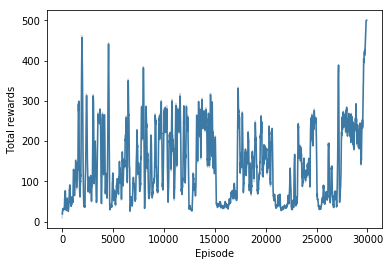

In [42]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

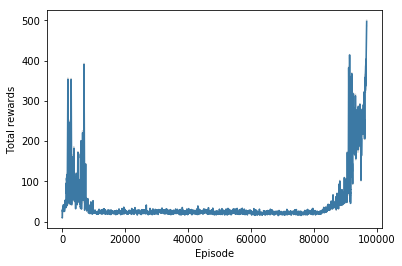

In [27]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [28]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

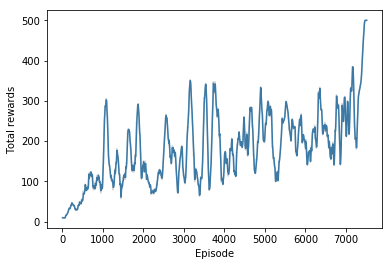

In [29]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

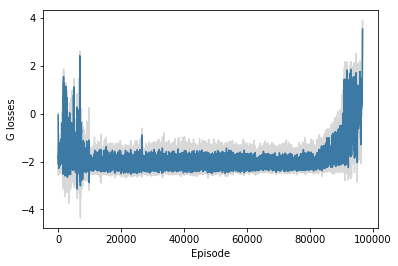

In [29]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

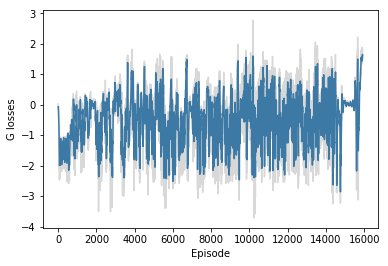

In [31]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

Text(0,0.5,'G losses')

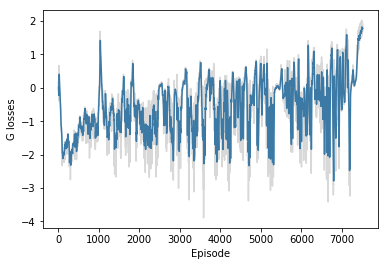

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

Text(0,0.5,'D losses')

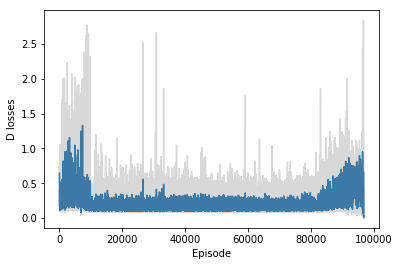

In [30]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

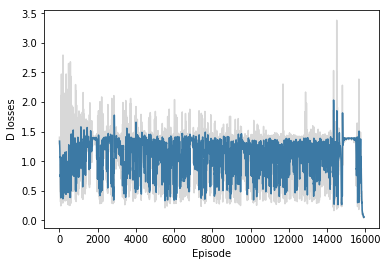

In [32]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

Text(0,0.5,'D losses')

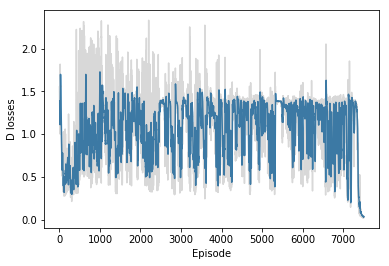

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

Text(0,0.5,'D losses R')

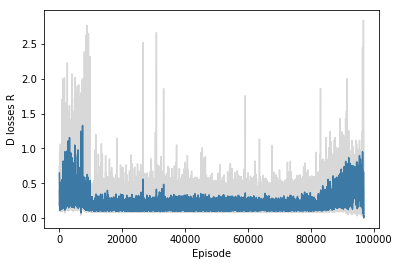

In [31]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

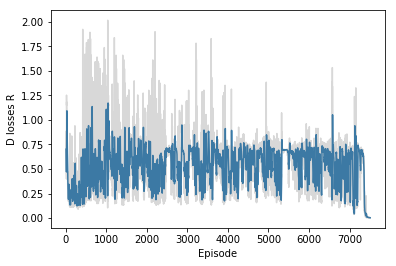

In [32]:
# eps, arr = np.array(d_lossR_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

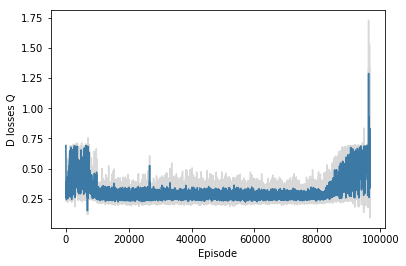

In [32]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

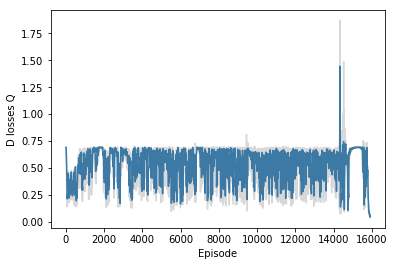

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

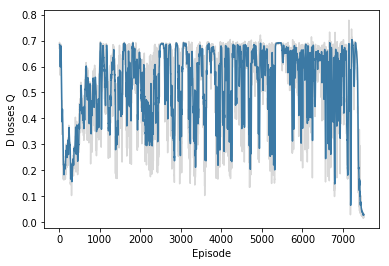

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.